In [1]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

2025-03-09 15:29:25.498057: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-09 15:29:25.506320: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-09 15:29:25.602526: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-09 15:29:25.675148: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741514365.737807  156694 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741514365.76

In [2]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

In [3]:
# Load dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize and reshape data
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# One-hot encoding
y_train_one_hot = np.eye(10)[y_train]
y_test_one_hot = np.eye(10)[y_test]

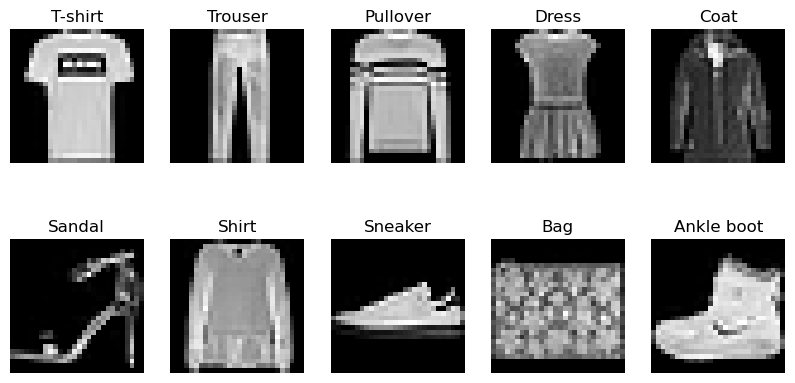

In [4]:
# Display one sample per class
classes = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
           "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    sample_idx = np.where(y_train == i)[0][0]
    ax.imshow(X_train[sample_idx].reshape(28, 28), cmap="gray")
    ax.set_title(classes[i])
    ax.axis("off")
plt.show()


In [ ]:
class NeuralNetwork:
    def __init__(self, layers, activation=None, output_activation = 'softmax', weight_init=None):
        
        self.layers = layers
        self.activation = activation
        self.output_activation = output_activation  # Separate activation for output layer
        self.weight_init = weight_init
        self.weights, self.biases = self._initialize_weights()

    def _initialize_weights(self):
        
        np.random.seed(42)
        weights, biases = [], []

        for i in range(len(self.layers) - 1):
            if self.weight_init == "xavier":
                limit = np.sqrt(6 / (self.layers[i] + self.layers[i+1]))
                w = np.random.uniform(-limit, limit, (self.layers[i], self.layers[i+1]))
            else:  # Default: Random small values
                w = np.random.randn(self.layers[i], self.layers[i+1]) * 0.01
            
            b = np.zeros((1, self.layers[i+1]))
            weights.append(w)
            biases.append(b)
        
        return weights, biases

    def _activation(self, x, func, derivative=False):
        
        if func == "relu":
            return np.where(x > 0, 1, 0) if derivative else np.maximum(0, x)
        elif func == "tanh":
            t = np.tanh(x)
            return 1 - t**2 if derivative else t
        elif func == "sigmoid":
            sig = 1 / (1 + np.exp(-x))
            return sig * (1 - sig) if derivative else sig
        elif func == "softmax":
            exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Stability trick
            return exp_x / np.sum(exp_x, axis=1, keepdims=True)
        else:  # Linear (no activation)
            return x

    def forward(self, X):
        
        activations, zs = [X], []

        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            z = np.dot(activations[-1], w) + b
            zs.append(z)

            # Use different activation for last layer
            if i == len(self.weights) - 1:
                activations.append(self._activation(z, self.output_activation))
            else:
                activations.append(self._activation(z, self.activation))
        
        return activations, zs

    def backward(self, y_true, activations, zs, learning_rate):
        
        grads_w, grads_b = [], []
        m = y_true.shape[0]
        
        # Compute loss gradient (assuming MSE loss for now)
        dA = activations[-1] - y_true  

        for i in reversed(range(len(self.weights))):
            activation_func = self.output_activation if i == len(self.weights) - 1 else self.activation
            dz = dA * self._activation(zs[i], activation_func, derivative=True)
            dw = np.dot(activations[i].T, dz) / m
            db = np.sum(dz, axis=0, keepdims=True) / m
            dA = np.dot(dz, self.weights[i].T)

            grads_w.insert(0, dw)
            grads_b.insert(0, db)

        return grads_w, grads_b


In [24]:
# Optimizers
class Optimizer:
    def __init__(self, method= None, lr=None, beta=0.9, beta2=0.999, epsilon=1e-8):
        self.method = method
        self.lr = lr
        self.beta = beta  
        self.beta2 = beta2  
        self.epsilon = epsilon  
        self.m_w = None  
        self.v_w = None  
        self.m_b = None  
        self.v_b = None  
        self.t = 0 

    def update(self, weights, biases, grads_w, grads_b):
        if self.method == "sgd":
            weights = [w - self.lr * dw for w, dw in zip(weights, grads_w)]
            biases = [b - self.lr * db for b, db in zip(biases, grads_b)]

        elif self.method in ["momentum", "nesterov"]:
            if self.m_w is None:  # Initialize momentum terms
                self.m_w = [np.zeros_like(w) for w in weights]
                self.m_b = [np.zeros_like(b) for b in biases]

            for i in range(len(weights)):
                if self.method == "nesterov":
                    # Look-ahead step
                    look_ahead_w = weights[i] - self.beta * self.m_w[i]
                    look_ahead_b = biases[i] - self.beta * self.m_b[i]

                    # Compute gradients at look-ahead position
                    self.m_w[i] = self.beta * self.m_w[i] + self.lr * grads_w[i]
                    self.m_b[i] = self.beta * self.m_b[i] + self.lr * grads_b[i]

                    weights[i] = look_ahead_w - self.m_w[i]
                    biases[i] = look_ahead_b - self.m_b[i]

                else:  # Normal momentum
                    self.m_w[i] = self.beta * self.m_w[i] + self.lr * grads_w[i]
                    self.m_b[i] = self.beta * self.m_b[i] + self.lr * grads_b[i]
                    weights[i] -= self.m_w[i]
                    biases[i] -= self.m_b[i]

        elif self.method in ["rmsprop", "adam", "nadam"]:
            if self.m_w is None:  # Initialize moment estimates
                self.m_w = [np.zeros_like(w) for w in weights]
                self.v_w = [np.zeros_like(w) for w in weights]
                self.m_b = [np.zeros_like(b) for b in biases]
                self.v_b = [np.zeros_like(b) for b in biases]

            self.t += 1  # Update time step

            for i in range(len(weights)):
                if self.method == "rmsprop":
                    
                    self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * grads_w[i] ** 2
                    self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * grads_b[i] ** 2

                    
                    weights[i] -= self.lr * grads_w[i] / (np.sqrt(self.v_w[i]) + self.epsilon)
                    biases[i] -= self.lr * grads_b[i] / (np.sqrt(self.v_b[i]) + self.epsilon)

                elif self.method in ["adam", "nadam"]:
                    
                    self.m_w[i] = self.beta * self.m_w[i] + (1 - self.beta) * grads_w[i]
                    self.m_b[i] = self.beta * self.m_b[i] + (1 - self.beta) * grads_b[i]

                    
                    self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (grads_w[i] ** 2)
                    self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (grads_b[i] ** 2)

                    
                    m_hat_w = self.m_w[i] / (1 - self.beta ** self.t)
                    v_hat_w = self.v_w[i] / (1 - self.beta2 ** self.t)
                    m_hat_b = self.m_b[i] / (1 - self.beta ** self.t)
                    v_hat_b = self.v_b[i] / (1 - self.beta2 ** self.t)

                    if self.method == "adam":
                        # Adam update rule
                        weights[i] -= self.lr * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
                        biases[i] -= self.lr * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

                    elif self.method == "nadam":
                        # Nadam additional momentum correction
                        nadam_m_w = self.beta * m_hat_w + (1 - self.beta) * grads_w[i] / (1 - self.beta ** self.t)
                        nadam_m_b = self.beta * m_hat_b + (1 - self.beta) * grads_b[i] / (1 - self.beta ** self.t)

                        weights[i] -= self.lr * nadam_m_w / (np.sqrt(v_hat_w) + self.epsilon)
                        biases[i] -= self.lr * nadam_m_b / (np.sqrt(v_hat_b) + self.epsilon)

        return weights, biases

In [32]:
def train():
    wandb.init(project="Assignment1_Attempt3")
    config = wandb.config  # Get hyperparameters
    run_name = f"hl_{config.hidden_layers}_bs_{config.batch_size}_ac_{config.activation}_e_{config.epochs}"
    print(run_name)
    wandb.run.name = run_name

    # Extract hyperparameters from WandB
    layers = [784] + [config.hidden_size] * config.hidden_layers + [10]
    activation = config.activation
    weight_init = config.weight_init
    learning_rate = config.learning_rate
    batch_size = config.batch_size
    optimizer = config.optimizer
    epochs = config.epochs


    # Initialize Neural Network
    model = NeuralNetwork(layers, activation=activation, weight_init=weight_init)
    optimizer = Optimizer(method=optimizer, lr=learning_rate)

    for epoch in range(epochs):
        num_batches = len(X_train) // batch_size
        train_loss, train_acc = 0, 0

        for i in range(num_batches):
            start, end = i * batch_size, (i + 1) * batch_size
            X_batch, y_batch = X_train[start:end], y_train_one_hot[start:end]

            # Forward propagation
            activations, zs = model.forward(X_batch)
            preds = np.argmax(activations[-1], axis=1)
            y_true_labels = np.argmax(y_batch, axis=1)

            # Compute loss and accuracy
            batch_loss = np.mean((activations[-1] - y_batch) ** 2)
            batch_acc = np.mean(preds == y_true_labels)

            train_loss += batch_loss
            train_acc += batch_acc

            # Backpropagation
            grads_w, grads_b = model.backward(y_batch, activations, zs, learning_rate)
            model.weights, model.biases = optimizer.update(model.weights, model.biases, grads_w, grads_b)

        # Average loss and accuracy
        train_loss /= num_batches
        train_acc /= num_batches

        # Validation phase
        val_activations, _ = model.forward(X_test)
        val_preds = np.argmax(val_activations[-1], axis=1)
        val_true_labels = np.argmax(y_test_one_hot, axis=1)

        val_loss = np.mean((val_activations[-1] - y_test_one_hot) ** 2)
        val_acc = np.mean(val_preds == val_true_labels)

        # Log metrics to WandB
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_accuracy": train_acc,
            "val_accuracy": val_acc
        })

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")


In [42]:
def cross_entropy_loss(y_pred, y_true):
    epsilon = 1e-9  # Small constant to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Prevents log(0) issues
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

def train_2():
    wandb.init(project="Assignment_Attempt3")
    config = wandb.config
    run_name = f"hl_{config.hidden_layers}_bs_{config.batch_size}_ac_{config.activation}_lr_{config.learning_rate}_hs_{config.hidden_size}_opt_{config.optimizer}_init_{config.weight_init}_e_{config.epochs}"
    wandb.run.name = run_name

    # Extract hyperparameters from WandB
    layers = [784] + [config.hidden_size] * config.hidden_layers + [10]
    activation = config.activation
    weight_init = config.weight_init
    learning_rate = config.learning_rate
    batch_size = config.batch_size
    optimizer = config.optimizer
    epochs = config.epochs

    # Initialize Neural Network
    model = NeuralNetwork(layers, activation=activation, weight_init=weight_init)
    optimizer = Optimizer(method=optimizer, lr=learning_rate)

    for epoch in range(epochs):
        num_batches = len(X_train) // batch_size
        train_loss, train_acc = 0, 0

        for i in range(num_batches):
            start, end = i * batch_size, (i + 1) * batch_size
            X_batch, y_batch = X_train[start:end], y_train_one_hot[start:end]

            
            activations, zs = model.forward(X_batch)
            preds = np.argmax(activations[-1], axis=1)
            y_true_labels = np.argmax(y_batch, axis=1)

            
            batch_loss = np.mean((activations[-1] - y_batch) ** 2)  
            batch_acc = np.mean(preds == y_true_labels)

            train_loss += batch_loss
            train_acc += batch_acc

            
            grads_w, grads_b = model.backward(y_batch, activations, zs, learning_rate)
            model.weights, model.biases = optimizer.update(model.weights, model.biases, grads_w, grads_b)

        
        train_loss /= num_batches
        train_acc /= num_batches

        
        val_activations, _ = model.forward(X_test)
        val_preds = np.argmax(val_activations[-1], axis=1)
        val_true_labels = np.argmax(y_test_one_hot, axis=1)

        
        val_mse_loss = np.mean((val_activations[-1] - y_test_one_hot) ** 2)  # MSE Loss
        val_ce_loss = cross_entropy_loss(val_activations[-1], y_test_one_hot)  # Cross Entropy Loss

        
        val_acc = np.mean(val_preds == val_true_labels)

        
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_mse_loss": val_mse_loss,
            "val_ce_loss": val_ce_loss,
            "train_accuracy": train_acc,
            "val_accuracy": val_acc
        })

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Val MSE Loss={val_mse_loss:.4f}, Val CE Loss={val_ce_loss:.4f}, Val Acc={val_acc:.4f}")

In [33]:
sweep_config = {
    'method': 'bayes',  
    'metric': {'name': 'val_loss', 'goal': 'minimize'},  # Optimize for lowest validation loss
    'parameters': {
        'epochs': {'values': [5, 10, 15, 20]},
        'hidden_layers': {'values': [3, 4, 5]},
        'hidden_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [1e-3, 1e-4]},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']},  
        'epsilon': {'values': [0.8, 0.9, 0.95]}
    }
}


In [34]:
sweep_id = wandb.sweep(sweep_config, project="Assignment_Attempt3")
wandb.agent(sweep_id, train, count=200) 

Create sweep with ID: 2eskfzbe
Sweep URL: https://wandb.ai/vinyk-sd-indian-institute-of-technology-madras/Assignment_Attempt3/sweeps/2eskfzbe


wandb: Agent Starting Run: f8qnzz7f with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_15
Epoch 1: Train Loss=0.0271, Train Acc=0.8047, Val Loss=0.0251, Val Acc=0.8232
Epoch 2: Train Loss=0.0216, Train Acc=0.8469, Val Loss=0.0216, Val Acc=0.8473
Epoch 3: Train Loss=0.0199, Train Acc=0.8590, Val Loss=0.0202, Val Acc=0.8590
Epoch 4: Train Loss=0.0189, Train Acc=0.8660, Val Loss=0.0220, Val Acc=0.8414
Epoch 5: Train Loss=0.0183, Train Acc=0.8690, Val Loss=0.0221, Val Acc=0.8451
Epoch 6: Train Loss=0.0177, Train Acc=0.8741, Val Loss=0.0206, Val Acc=0.8546
Epoch 7: Train Loss=0.0174, Train Acc=0.8759, Val Loss=0.0207, Val Acc=0.8524
Epoch 8: Train Loss=0.0172, Train Acc=0.8786, Val Loss=0.0212, Val Acc=0.8512
Epoch 9: Train Loss=0.0171, Train Acc=0.8784, Val Loss=0.0215, Val Acc=0.8512
Epoch 10: Train Loss=0.0169, Train Acc=0.8798, Val Loss=0.0212, Val Acc=0.8470
Epoch 11: Train Loss=0.0164, Train Acc=0.8835, Val Loss=0.0215, Val Acc=0.8475
Epoch 12: Train Loss=0.0162, Train Acc=0.8843, Val Loss=0.0205, Val Acc=0.8543
Epoch 13: Train Loss=0.0163, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▇▇▇▇▇▇█████
train_loss,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▆█▅▅▇▇▆▆▆▆▇▇▅█
val_loss,█▃▁▄▄▂▂▃▃▂▃▂▂▄▁
epoch,15
train_accuracy,0.88572
train_loss,0.01596
val_accuracy,0.8575
val_loss,0.02025


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vdwefxc6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


hl_4_bs_32_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0810, Train Acc=0.1489, Val Loss=0.0783, Val Acc=0.1559
Epoch 2: Train Loss=0.0824, Train Acc=0.1833, Val Loss=0.0813, Val Acc=0.1904
Epoch 3: Train Loss=0.0802, Train Acc=0.2175, Val Loss=0.0776, Val Acc=0.2874
Epoch 4: Train Loss=0.0818, Train Acc=0.2020, Val Loss=0.0820, Val Acc=0.1883
Epoch 5: Train Loss=0.0807, Train Acc=0.2118, Val Loss=0.0817, Val Acc=0.2460
Epoch 6: Train Loss=0.0810, Train Acc=0.2066, Val Loss=0.0812, Val Acc=0.1792
Epoch 7: Train Loss=0.0809, Train Acc=0.2237, Val Loss=0.0804, Val Acc=0.1934
Epoch 8: Train Loss=0.0801, Train Acc=0.2215, Val Loss=0.0793, Val Acc=0.1917
Epoch 9: Train Loss=0.0833, Train Acc=0.1806, Val Loss=0.0859, Val Acc=0.1863
Epoch 10: Train Loss=0.0839, Train Acc=0.1759, Val Loss=0.0818, Val Acc=0.1729
Epoch 11: Train Loss=0.0816, Train Acc=0.2010, Val Loss=0.0839, Val Acc=0.1813
Epoch 12: Train Loss=0.0812, Train Acc=0.2018, Val Loss=0.0802, Val Acc=0.1965
Epoch 13: Train Loss=0.0807, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▇▅▆▆▇▇▄▃▅▅▆▆▆▆█▇▃▅
train_loss,▂▄▁▃▂▂▂▁▅▆▃▂▂▁▁▂▁▂█▆
val_accuracy,▃▄█▄▆▄▄▄▄▄▄▅▆▆▅█▄▅▁▃
val_loss,▂▄▁▅▄▄▃▂█▅▆▃▅▄▂▂▃▅▇▇
epoch,20
train_accuracy,0.19987
train_loss,0.08422
val_accuracy,0.1558
val_loss,0.08416


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y6kcugi2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_4_bs_64_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0928, Train Acc=0.1000, Val Loss=0.0914, Val Acc=0.1000
Epoch 2: Train Loss=0.0911, Train Acc=0.1000, Val Loss=0.0908, Val Acc=0.1000
Epoch 3: Train Loss=0.0906, Train Acc=0.1000, Val Loss=0.0905, Val Acc=0.1000
Epoch 4: Train Loss=0.0904, Train Acc=0.1000, Val Loss=0.0903, Val Acc=0.1000
Epoch 5: Train Loss=0.0902, Train Acc=0.1000, Val Loss=0.0902, Val Acc=0.1000
Epoch 6: Train Loss=0.0902, Train Acc=0.1000, Val Loss=0.0901, Val Acc=0.1000
Epoch 7: Train Loss=0.0901, Train Acc=0.1051, Val Loss=0.0901, Val Acc=0.1007
Epoch 8: Train Loss=0.0901, Train Acc=0.1344, Val Loss=0.0900, Val Acc=0.1063
Epoch 9: Train Loss=0.0900, Train Acc=0.1476, Val Loss=0.0900, Val Acc=0.1225
Epoch 10: Train Loss=0.0900, Train Acc=0.1503, Val Loss=0.0900, Val Acc=0.1390
Epoch 11: Train Loss=0.0900, Train Acc=0.1538, Val Loss=0.0900, Val Acc=0.1505
Epoch 12: Train Loss=0.0900, Train Acc=0.1551, Val Loss=0.0900, Val Acc=0.1557
Epoch 13: Train Loss=0.0900, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▁▁▁▁▁▂▅▇▇█████▇▇███
train_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▂▄▆▇████▇▇▇▇▇
val_loss,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.15672
train_loss,0.09
val_accuracy,0.145
val_loss,0.09


wandb: Agent Starting Run: or1rwy7a with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


hl_3_bs_32_ac_relu_e_20
Epoch 1: Train Loss=0.0900, Train Acc=0.0938, Val Loss=0.0900, Val Acc=0.1031
Epoch 2: Train Loss=0.0900, Train Acc=0.0965, Val Loss=0.0900, Val Acc=0.0805
Epoch 3: Train Loss=0.0900, Train Acc=0.0978, Val Loss=0.0900, Val Acc=0.0829
Epoch 4: Train Loss=0.0900, Train Acc=0.1004, Val Loss=0.0900, Val Acc=0.1199
Epoch 5: Train Loss=0.0900, Train Acc=0.1019, Val Loss=0.0900, Val Acc=0.1490
Epoch 6: Train Loss=0.0900, Train Acc=0.1024, Val Loss=0.0900, Val Acc=0.1617
Epoch 7: Train Loss=0.0900, Train Acc=0.1025, Val Loss=0.0900, Val Acc=0.1628
Epoch 8: Train Loss=0.0900, Train Acc=0.1031, Val Loss=0.0900, Val Acc=0.1622
Epoch 9: Train Loss=0.0900, Train Acc=0.1039, Val Loss=0.0900, Val Acc=0.1629
Epoch 10: Train Loss=0.0900, Train Acc=0.1048, Val Loss=0.0900, Val Acc=0.1634
Epoch 11: Train Loss=0.0900, Train Acc=0.1060, Val Loss=0.0900, Val Acc=0.1628
Epoch 12: Train Loss=0.0900, Train Acc=0.1074, Val Loss=0.0900, Val Acc=0.1613
Epoch 13: Train Loss=0.0900, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▂▃▄▄▄▅▅▅▅▆▇▇▇▇█████
train_loss,█▆▅▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▃▁▁▄▇██████████▇▇▇▇▇
val_loss,█▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
epoch,20
train_accuracy,0.11037
train_loss,0.09
val_accuracy,0.1543
val_loss,0.09


wandb: Agent Starting Run: hz62bhv0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_10
Epoch 1: Train Loss=0.0915, Train Acc=0.0986, Val Loss=0.0910, Val Acc=0.1105
Epoch 2: Train Loss=0.0906, Train Acc=0.1269, Val Loss=0.0902, Val Acc=0.1512
Epoch 3: Train Loss=0.0898, Train Acc=0.1812, Val Loss=0.0894, Val Acc=0.2132
Epoch 4: Train Loss=0.0890, Train Acc=0.2334, Val Loss=0.0886, Val Acc=0.2472
Epoch 5: Train Loss=0.0882, Train Acc=0.2614, Val Loss=0.0878, Val Acc=0.2659
Epoch 6: Train Loss=0.0874, Train Acc=0.2780, Val Loss=0.0870, Val Acc=0.2833
Epoch 7: Train Loss=0.0866, Train Acc=0.2917, Val Loss=0.0862, Val Acc=0.2968
Epoch 8: Train Loss=0.0857, Train Acc=0.3060, Val Loss=0.0853, Val Acc=0.3144
Epoch 9: Train Loss=0.0848, Train Acc=0.3222, Val Loss=0.0844, Val Acc=0.3309
Epoch 10: Train Loss=0.0839, Train Acc=0.3422, Val Loss=0.0835, Val Acc=0.3550


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▅▆▆▇▇▇█
train_loss,█▇▆▆▅▄▃▃▂▁
val_accuracy,▁▂▄▅▅▆▆▇▇█
val_loss,█▇▇▆▅▄▄▃▂▁
epoch,10
train_accuracy,0.34225
train_loss,0.0839
val_accuracy,0.355
val_loss,0.08345


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ssfzg83l with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_3_bs_16_ac_relu_e_20
Epoch 1: Train Loss=0.0878, Train Acc=0.2440, Val Loss=0.0846, Val Acc=0.3636
Epoch 2: Train Loss=0.0782, Train Acc=0.4546, Val Loss=0.0686, Val Acc=0.4893
Epoch 3: Train Loss=0.0585, Train Acc=0.5625, Val Loss=0.0527, Val Acc=0.6044
Epoch 4: Train Loss=0.0499, Train Acc=0.6236, Val Loss=0.0510, Val Acc=0.6109
Epoch 5: Train Loss=0.0461, Train Acc=0.6497, Val Loss=0.0467, Val Acc=0.6299
Epoch 6: Train Loss=0.0435, Train Acc=0.6675, Val Loss=0.0439, Val Acc=0.6552
Epoch 7: Train Loss=0.0411, Train Acc=0.6825, Val Loss=0.0418, Val Acc=0.6783
Epoch 8: Train Loss=0.0393, Train Acc=0.6986, Val Loss=0.0400, Val Acc=0.7035
Epoch 9: Train Loss=0.0381, Train Acc=0.7235, Val Loss=0.0384, Val Acc=0.7371
Epoch 10: Train Loss=0.0369, Train Acc=0.7438, Val Loss=0.0365, Val Acc=0.7491
Epoch 11: Train Loss=0.0356, Train Acc=0.7539, Val Loss=0.0349, Val Acc=0.7612
Epoch 12: Train Loss=0.0334, Train Acc=0.7660, Val Loss=0.0324, Val Acc=0.7755
Epoch 13: Train Loss=0.0314, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▅▆▆▆▆▇▇▇▇▇████████
train_loss,█▇▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▃▅▅▅▆▆▆▇▇▇█████████
val_loss,█▆▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.81095
train_loss,0.02645
val_accuracy,0.8068
val_loss,0.02719


wandb: Agent Starting Run: zpzmeumq with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_4_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0361, Train Acc=0.7404, Val Loss=0.0297, Val Acc=0.7921
Epoch 2: Train Loss=0.0267, Train Acc=0.8132, Val Loss=0.0266, Val Acc=0.8117
Epoch 3: Train Loss=0.0243, Train Acc=0.8286, Val Loss=0.0251, Val Acc=0.8236
Epoch 4: Train Loss=0.0230, Train Acc=0.8379, Val Loss=0.0243, Val Acc=0.8293
Epoch 5: Train Loss=0.0223, Train Acc=0.8424, Val Loss=0.0243, Val Acc=0.8283


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.8424
train_loss,0.02229
val_accuracy,0.8283
val_loss,0.02433


wandb: Agent Starting Run: t4d9mogv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


hl_3_bs_64_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0871, Train Acc=0.1626, Val Loss=0.0814, Val Acc=0.1984
Epoch 2: Train Loss=0.0807, Train Acc=0.2011, Val Loss=0.0805, Val Acc=0.2051
Epoch 3: Train Loss=0.0776, Train Acc=0.2652, Val Loss=0.0744, Val Acc=0.2922
Epoch 4: Train Loss=0.0733, Train Acc=0.3031, Val Loss=0.0727, Val Acc=0.2988
Epoch 5: Train Loss=0.0723, Train Acc=0.3088, Val Loss=0.0721, Val Acc=0.3039
Epoch 6: Train Loss=0.0718, Train Acc=0.3221, Val Loss=0.0716, Val Acc=0.3336
Epoch 7: Train Loss=0.0706, Train Acc=0.3525, Val Loss=0.0696, Val Acc=0.3612
Epoch 8: Train Loss=0.0683, Train Acc=0.3692, Val Loss=0.0674, Val Acc=0.3726
Epoch 9: Train Loss=0.0663, Train Acc=0.3877, Val Loss=0.0658, Val Acc=0.3919
Epoch 10: Train Loss=0.0648, Train Acc=0.4115, Val Loss=0.0646, Val Acc=0.4121
Epoch 11: Train Loss=0.0697, Train Acc=0.3669, Val Loss=0.0928, Val Acc=0.1126
Epoch 12: Train Loss=0.0906, Train Acc=0.1164, Val Loss=0.0861, Val Acc=0.1000
Epoch 13: Train Loss=0.0841, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▂▃▅▅▆▆▇▇▇█▇▁▄▅▅▅▅▅▅▅
train_loss,▇▅▄▃▃▃▃▂▁▁▂█▆▆▅▄▄▄▅▄
val_accuracy,▃▃▅▅▆▆▇▇██▁▁▅▅▅▅▅▆▅▅
val_loss,▅▅▃▃▃▃▂▂▁▁█▆▆▅▄▄▄▄▄▄
epoch,20
train_accuracy,0.29646
train_loss,0.07603
val_accuracy,0.2885
val_loss,0.07576


wandb: Agent Starting Run: 3cnamd28 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_3_bs_64_ac_relu_e_10
Epoch 1: Train Loss=0.0701, Train Acc=0.4209, Val Loss=0.0595, Val Acc=0.5123
Epoch 2: Train Loss=0.0434, Train Acc=0.6743, Val Loss=0.0402, Val Acc=0.6900
Epoch 3: Train Loss=0.0351, Train Acc=0.7383, Val Loss=0.0325, Val Acc=0.7672
Epoch 4: Train Loss=0.0290, Train Acc=0.7924, Val Loss=0.0281, Val Acc=0.7988
Epoch 5: Train Loss=0.0262, Train Acc=0.8117, Val Loss=0.0272, Val Acc=0.8040
Epoch 6: Train Loss=0.0251, Train Acc=0.8198, Val Loss=0.0271, Val Acc=0.8047
Epoch 7: Train Loss=0.0243, Train Acc=0.8267, Val Loss=0.0260, Val Acc=0.8122
Epoch 8: Train Loss=0.0238, Train Acc=0.8302, Val Loss=0.0252, Val Acc=0.8202
Epoch 9: Train Loss=0.0233, Train Acc=0.8326, Val Loss=0.0263, Val Acc=0.8099
Epoch 10: Train Loss=0.0228, Train Acc=0.8355, Val Loss=0.0252, Val Acc=0.8192


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇██████
train_loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▅▇███████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_accuracy,0.83555
train_loss,0.02283
val_accuracy,0.8192
val_loss,0.02524


wandb: Agent Starting Run: p0v1jktq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


hl_4_bs_32_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0821, Train Acc=0.1726, Val Loss=0.0781, Val Acc=0.2618
Epoch 2: Train Loss=0.0843, Train Acc=0.1827, Val Loss=0.0836, Val Acc=0.2050
Epoch 3: Train Loss=0.0816, Train Acc=0.2059, Val Loss=0.0841, Val Acc=0.1889
Epoch 4: Train Loss=0.0827, Train Acc=0.2014, Val Loss=0.0818, Val Acc=0.1912
Epoch 5: Train Loss=0.0813, Train Acc=0.2136, Val Loss=0.0799, Val Acc=0.2629
Epoch 6: Train Loss=0.0841, Train Acc=0.1983, Val Loss=0.0829, Val Acc=0.1427
Epoch 7: Train Loss=0.0809, Train Acc=0.2462, Val Loss=0.0850, Val Acc=0.1844
Epoch 8: Train Loss=0.0821, Train Acc=0.1943, Val Loss=0.0782, Val Acc=0.2722
Epoch 9: Train Loss=0.0811, Train Acc=0.2273, Val Loss=0.0845, Val Acc=0.1842
Epoch 10: Train Loss=0.0831, Train Acc=0.2186, Val Loss=0.0810, Val Acc=0.2942
Epoch 11: Train Loss=0.0830, Train Acc=0.2050, Val Loss=0.0830, Val Acc=0.1912
Epoch 12: Train Loss=0.0813, Train Acc=0.2124, Val Loss=0.0806, Val Acc=0.2030
Epoch 13: Train Loss=0.0798, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▂▃▃▃▃▅▂▄▄▃▃▆▃▅▅▆▇██
train_loss,▆█▆▇▅█▅▆▅▇▇▅▄▅▇█▅▂▁▃
val_accuracy,▅▃▂▃▅▁▂▅▂▆▃▃▂▅▅▅▅▆█▄
val_loss,▃▇▇▆▄▆█▃▇▅▆▅█▅█▇▄▂▁▆
epoch,20
train_accuracy,0.2851
train_loss,0.07894
val_accuracy,0.236
val_loss,0.08264


wandb: Agent Starting Run: nfjfe01o with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0321, Train Acc=0.7707, Val Loss=0.0280, Val Acc=0.8045
Epoch 2: Train Loss=0.0236, Train Acc=0.8323, Val Loss=0.0241, Val Acc=0.8311
Epoch 3: Train Loss=0.0213, Train Acc=0.8483, Val Loss=0.0226, Val Acc=0.8428
Epoch 4: Train Loss=0.0199, Train Acc=0.8585, Val Loss=0.0217, Val Acc=0.8468
Epoch 5: Train Loss=0.0189, Train Acc=0.8660, Val Loss=0.0211, Val Acc=0.8528


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.86597
train_loss,0.01888
val_accuracy,0.8528
val_loss,0.02112


wandb: Agent Starting Run: zkw9zo2m with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_15
Epoch 1: Train Loss=0.0283, Train Acc=0.7954, Val Loss=0.0240, Val Acc=0.8267
Epoch 2: Train Loss=0.0212, Train Acc=0.8495, Val Loss=0.0214, Val Acc=0.8505
Epoch 3: Train Loss=0.0195, Train Acc=0.8617, Val Loss=0.0215, Val Acc=0.8456
Epoch 4: Train Loss=0.0181, Train Acc=0.8718, Val Loss=0.0214, Val Acc=0.8474
Epoch 5: Train Loss=0.0173, Train Acc=0.8779, Val Loss=0.0190, Val Acc=0.8662
Epoch 6: Train Loss=0.0166, Train Acc=0.8832, Val Loss=0.0187, Val Acc=0.8671
Epoch 7: Train Loss=0.0160, Train Acc=0.8866, Val Loss=0.0184, Val Acc=0.8705
Epoch 8: Train Loss=0.0155, Train Acc=0.8907, Val Loss=0.0182, Val Acc=0.8720
Epoch 9: Train Loss=0.0151, Train Acc=0.8927, Val Loss=0.0197, Val Acc=0.8576
Epoch 10: Train Loss=0.0148, Train Acc=0.8943, Val Loss=0.0190, Val Acc=0.8662
Epoch 11: Train Loss=0.0145, Train Acc=0.8961, Val Loss=0.0184, Val Acc=0.8722
Epoch 12: Train Loss=0.0144, Train Acc=0.8967, Val Loss=0.0186, Val Acc=0.8736
Epoch 13: Train Loss=0.0140, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▃▆▆▇▇▇▇███████▁
train_loss,▄▃▂▂▂▂▁▁▁▁▁▁▁▁█
val_accuracy,██████████████▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
epoch,15
train_accuracy,0.73703
train_loss,0.04766
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: n4oa5n3a with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.0411, Train Acc=0.6916, Val Loss=0.0340, Val Acc=0.7630
Epoch 2: Train Loss=0.0284, Train Acc=0.7984, Val Loss=0.0296, Val Acc=0.7912
Epoch 3: Train Loss=0.0261, Train Acc=0.8154, Val Loss=0.0276, Val Acc=0.7988
Epoch 4: Train Loss=0.0245, Train Acc=0.8253, Val Loss=0.0258, Val Acc=0.8154
Epoch 5: Train Loss=0.0233, Train Acc=0.8338, Val Loss=0.0253, Val Acc=0.8175


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▆██
val_loss,█▄▃▁▁
epoch,5
train_accuracy,0.8338
train_loss,0.02331
val_accuracy,0.8175
val_loss,0.02534


wandb: Agent Starting Run: gop9xmt6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_20
Epoch 1: Train Loss=0.0269, Train Acc=0.8075, Val Loss=0.0232, Val Acc=0.8374
Epoch 2: Train Loss=0.0207, Train Acc=0.8530, Val Loss=0.0212, Val Acc=0.8515
Epoch 3: Train Loss=0.0190, Train Acc=0.8662, Val Loss=0.0203, Val Acc=0.8564
Epoch 4: Train Loss=0.0179, Train Acc=0.8731, Val Loss=0.0193, Val Acc=0.8625
Epoch 5: Train Loss=0.0171, Train Acc=0.8791, Val Loss=0.0193, Val Acc=0.8618
Epoch 6: Train Loss=0.0165, Train Acc=0.8830, Val Loss=0.0190, Val Acc=0.8669
Epoch 7: Train Loss=0.0159, Train Acc=0.8883, Val Loss=0.0182, Val Acc=0.8719
Epoch 8: Train Loss=0.0154, Train Acc=0.8905, Val Loss=0.0189, Val Acc=0.8667
Epoch 9: Train Loss=0.0150, Train Acc=0.8933, Val Loss=0.0183, Val Acc=0.8735
Epoch 10: Train Loss=0.0148, Train Acc=0.8954, Val Loss=0.0184, Val Acc=0.8720
Epoch 11: Train Loss=0.0144, Train Acc=0.8974, Val Loss=0.0181, Val Acc=0.8764
Epoch 12: Train Loss=0.0142, Train Acc=0.8989, Val Loss=0.0178, Val Acc=0.8769
Epoch 13: Train Loss=0.0137, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▇█████████████▃▁▁▁▁▁
train_loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▆█████
val_accuracy,██████████████▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁██████
epoch,20
train_accuracy,0.09873
train_loss,0.18025
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: h70p9fq4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_4_bs_16_ac_tanh_e_5
Epoch 1: Train Loss=0.0274, Train Acc=0.8066, Val Loss=0.0230, Val Acc=0.8356
Epoch 2: Train Loss=0.0208, Train Acc=0.8526, Val Loss=0.0213, Val Acc=0.8482
Epoch 3: Train Loss=0.0192, Train Acc=0.8631, Val Loss=0.0205, Val Acc=0.8554
Epoch 4: Train Loss=0.0182, Train Acc=0.8708, Val Loss=0.0200, Val Acc=0.8599
Epoch 5: Train Loss=0.0176, Train Acc=0.8759, Val Loss=0.0196, Val Acc=0.8634


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.87592
train_loss,0.01755
val_accuracy,0.8634
val_loss,0.01963


wandb: Agent Starting Run: 86va1gwo with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_10
Epoch 1: Train Loss=0.0338, Train Acc=0.7619, Val Loss=0.0282, Val Acc=0.8058
Epoch 2: Train Loss=0.0255, Train Acc=0.8214, Val Loss=0.0257, Val Acc=0.8165
Epoch 3: Train Loss=0.1344, Train Acc=0.3102, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1799, Train Acc=0.1004, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1804, Train Acc=0.0982, Val Loss=0.1800, Val Acc=0.1000
Epoch 6: Train Loss=0.1798, Train Acc=0.1010, Val Loss=0.1800, Val Acc=0.1000
Epoch 7: Train Loss=0.1800, Train Acc=0.0998, Val Loss=0.1800, Val Acc=0.1000
Epoch 8: Train Loss=0.1799, Train Acc=0.1006, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1798, Train Acc=0.1011, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1800, Train Acc=0.1001, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▇█▃▁▁▁▁▁▁▁
train_loss,▁▁▆███████
val_accuracy,██▁▁▁▁▁▁▁▁
val_loss,▁▁████████
epoch,10
train_accuracy,0.10007
train_loss,0.17999
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: lj819xv6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


hl_4_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.0711, Train Acc=0.5485, Val Loss=0.1800, Val Acc=0.1000
Epoch 2: Train Loss=0.1799, Train Acc=0.1003, Val Loss=0.1800, Val Acc=0.1000
Epoch 3: Train Loss=0.1797, Train Acc=0.1015, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1801, Train Acc=0.0995, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1795, Train Acc=0.1024, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,█▁▁▁▁
train_loss,▁████
val_accuracy,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
train_accuracy,0.10245
train_loss,0.17951
val_accuracy,0.1
val_loss,0.18


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cevtru6f with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


hl_3_bs_32_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0996, Val Loss=0.0900, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0996, Val Loss=0.0900, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0987, Val Loss=0.0900, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0979, Val Loss=0.0900, Val Acc=0.1000
Epoch 11: Train Loss=0.0900, Train Acc=0.0971, Val Loss=0.0900, Val Acc=0.1000
Epoch 12: Train Loss=0.0900, Train Acc=0.0970, Val Loss=0.0900, Val Acc=0.1000
Epoch 13: Train Loss=0.0900, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,██████▇▇▆▅▄▄▂▂▁▁▂▂▂▂
train_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.09605
train_loss,0.09
val_accuracy,0.1
val_loss,0.09


wandb: Agent Starting Run: b8c56vuj with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


hl_3_bs_32_ac_relu_e_15
Epoch 1: Train Loss=0.1215, Train Acc=0.3267, Val Loss=0.1800, Val Acc=0.1000
Epoch 2: Train Loss=0.1796, Train Acc=0.1018, Val Loss=0.1800, Val Acc=0.1000
Epoch 3: Train Loss=0.1798, Train Acc=0.1012, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1802, Train Acc=0.0991, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1800, Train Acc=0.1002, Val Loss=0.1800, Val Acc=0.1000
Epoch 6: Train Loss=0.1802, Train Acc=0.0992, Val Loss=0.1800, Val Acc=0.1000
Epoch 7: Train Loss=0.1804, Train Acc=0.0979, Val Loss=0.1800, Val Acc=0.1000
Epoch 8: Train Loss=0.1802, Train Acc=0.0992, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1797, Train Acc=0.1016, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1801, Train Acc=0.0997, Val Loss=0.1800, Val Acc=0.1000
Epoch 11: Train Loss=0.1804, Train Acc=0.0981, Val Loss=0.1800, Val Acc=0.1000
Epoch 12: Train Loss=0.1798, Train Acc=0.1012, Val Loss=0.1800, Val Acc=0.1000
Epoch 13: Train Loss=0.1800, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁██████████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.10173
train_loss,0.17965
val_accuracy,0.1
val_loss,0.18


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 443l79q8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.0530, Train Acc=0.5914, Val Loss=0.0438, Val Acc=0.6779
Epoch 2: Train Loss=0.0349, Train Acc=0.7571, Val Loss=0.0367, Val Acc=0.7482
Epoch 3: Train Loss=0.0665, Train Acc=0.5988, Val Loss=0.1624, Val Acc=0.1824
Epoch 4: Train Loss=0.1779, Train Acc=0.1087, Val Loss=0.1664, Val Acc=0.1000
Epoch 5: Train Loss=0.1796, Train Acc=0.1017, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▆█▆▁▁
train_loss,▂▁▃██
val_accuracy,▇█▂▁▁
val_loss,▁▁▇▇█
epoch,5
train_accuracy,0.10172
train_loss,0.17964
val_accuracy,0.1
val_loss,0.18


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: inlwm0ms with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_4_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0886, Train Acc=0.1900, Val Loss=0.0869, Val Acc=0.3382
Epoch 2: Train Loss=0.0829, Train Acc=0.3274, Val Loss=0.0772, Val Acc=0.3176
Epoch 3: Train Loss=0.0689, Train Acc=0.4702, Val Loss=0.0623, Val Acc=0.5337
Epoch 4: Train Loss=0.0583, Train Acc=0.5601, Val Loss=0.0574, Val Acc=0.5480
Epoch 5: Train Loss=0.0531, Train Acc=0.5932, Val Loss=0.0521, Val Acc=0.6138


epoch,▁▃▅▆█
train_accuracy,▁▃▆▇█
train_loss,█▇▄▂▁
val_accuracy,▁▁▆▆█
val_loss,█▆▃▂▁
epoch,5
train_accuracy,0.59318
train_loss,0.05307
val_accuracy,0.6138
val_loss,0.05215


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fs6v7awo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


hl_5_bs_16_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0900, Train Acc=0.0989, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0982, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0982, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0982, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0982, Val Loss=0.0900, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0982, Val Loss=0.0900, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0982, Val Loss=0.0900, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0982, Val Loss=0.0900, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0982, Val Loss=0.0900, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0982, Val Loss=0.0900, Val Acc=0.1000
Epoch 11: Train Loss=0.0900, Train Acc=0.0982, Val Loss=0.0900, Val Acc=0.1000
Epoch 12: Train Loss=0.0900, Train Acc=0.0982, Val Loss=0.0900, Val Acc=0.1000
Epoch 13: Train Loss=0.0900, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁▇█████████▇▇▇▇
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▇██████████▇▇▇
epoch,15
train_accuracy,0.09822
train_loss,0.09
val_accuracy,0.1
val_loss,0.09


wandb: Agent Starting Run: vtb8trao with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


hl_3_bs_16_ac_sigmoid_e_5
Epoch 1: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0978, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0975, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0971, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0966, Val Loss=0.0900, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,█▃▃▂▁
train_loss,█▁▁▁▁
val_accuracy,▁▁▁▁▁
val_loss,█▁▂▂▂
epoch,5
train_accuracy,0.09658
train_loss,0.09
val_accuracy,0.1
val_loss,0.09


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8khjhgw8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


hl_5_bs_32_ac_sigmoid_e_10
Epoch 1: Train Loss=0.0900, Train Acc=0.0990, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0977, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0976, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0977, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0977, Val Loss=0.0900, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0977, Val Loss=0.0900, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0977, Val Loss=0.0900, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0977, Val Loss=0.0900, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0977, Val Loss=0.0900, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0977, Val Loss=0.0900, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▁▁▁▁▁▁▁▁▁
train_loss,▁▅████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▇███████▇
epoch,10
train_accuracy,0.09765
train_loss,0.09
val_accuracy,0.1
val_loss,0.09


wandb: Agent Starting Run: p4exad19 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_3_bs_16_ac_relu_e_20
Epoch 1: Train Loss=0.0276, Train Acc=0.7995, Val Loss=0.0236, Val Acc=0.8325
Epoch 2: Train Loss=0.0209, Train Acc=0.8522, Val Loss=0.0211, Val Acc=0.8511
Epoch 3: Train Loss=0.0192, Train Acc=0.8647, Val Loss=0.0204, Val Acc=0.8566
Epoch 4: Train Loss=0.0180, Train Acc=0.8737, Val Loss=0.0191, Val Acc=0.8657
Epoch 5: Train Loss=0.0174, Train Acc=0.8781, Val Loss=0.0188, Val Acc=0.8670
Epoch 6: Train Loss=0.0292, Train Acc=0.8205, Val Loss=0.1800, Val Acc=0.1000
Epoch 7: Train Loss=0.1803, Train Acc=0.0986, Val Loss=0.1800, Val Acc=0.1000
Epoch 8: Train Loss=0.1801, Train Acc=0.0996, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1801, Train Acc=0.0997, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1801, Train Acc=0.0994, Val Loss=0.1800, Val Acc=0.1000
Epoch 11: Train Loss=0.1801, Train Acc=0.0994, Val Loss=0.1800, Val Acc=0.1000
Epoch 12: Train Loss=0.1799, Train Acc=0.1005, Val Loss=0.1800, Val Acc=0.1000
Epoch 13: Train Loss=0.1799, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▇████▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▂██████████████
val_accuracy,█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁███████████████
epoch,20
train_accuracy,0.09887
train_loss,0.18023
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: 59sf35wn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


hl_4_bs_16_ac_tanh_e_20
Epoch 1: Train Loss=0.0388, Train Acc=0.6958, Val Loss=0.0296, Val Acc=0.7792
Epoch 2: Train Loss=0.0265, Train Acc=0.8094, Val Loss=0.0249, Val Acc=0.8261
Epoch 3: Train Loss=0.0229, Train Acc=0.8376, Val Loss=0.0230, Val Acc=0.8359
Epoch 4: Train Loss=0.0218, Train Acc=0.8466, Val Loss=0.0234, Val Acc=0.8365
Epoch 5: Train Loss=0.0209, Train Acc=0.8519, Val Loss=0.0226, Val Acc=0.8419
Epoch 6: Train Loss=0.0204, Train Acc=0.8551, Val Loss=0.0220, Val Acc=0.8460
Epoch 7: Train Loss=0.0199, Train Acc=0.8573, Val Loss=0.0238, Val Acc=0.8325
Epoch 8: Train Loss=0.0196, Train Acc=0.8619, Val Loss=0.0212, Val Acc=0.8466
Epoch 9: Train Loss=0.0192, Train Acc=0.8643, Val Loss=0.0217, Val Acc=0.8465
Epoch 10: Train Loss=0.0192, Train Acc=0.8634, Val Loss=0.0219, Val Acc=0.8441
Epoch 11: Train Loss=0.0187, Train Acc=0.8666, Val Loss=0.0211, Val Acc=0.8498
Epoch 12: Train Loss=0.0186, Train Acc=0.8683, Val Loss=0.0210, Val Acc=0.8507
Epoch 13: Train Loss=0.0185, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▅▇▇▇▇▇█████████████
train_loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▆▇▇▆▇▇▇▇█▇██▇████
val_loss,█▅▃▃▃▂▄▂▂▂▂▂▂▂▂▂▂▁▁▁
epoch,20
train_accuracy,0.87118
train_loss,0.01796
val_accuracy,0.855
val_loss,0.02047


wandb: Agent Starting Run: pzvmmnit with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


hl_4_bs_64_ac_tanh_e_5
Epoch 1: Train Loss=0.0550, Train Acc=0.5396, Val Loss=0.0464, Val Acc=0.6582
Epoch 2: Train Loss=0.0417, Train Acc=0.6903, Val Loss=0.0376, Val Acc=0.7162
Epoch 3: Train Loss=0.0378, Train Acc=0.7188, Val Loss=0.0429, Val Acc=0.6680
Epoch 4: Train Loss=0.0341, Train Acc=0.7486, Val Loss=0.0326, Val Acc=0.7598
Epoch 5: Train Loss=0.0318, Train Acc=0.7659, Val Loss=0.0322, Val Acc=0.7618


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▄▃▂▁
val_accuracy,▁▅▂██
val_loss,█▄▆▁▁
epoch,5
train_accuracy,0.76591
train_loss,0.03179
val_accuracy,0.7618
val_loss,0.03219


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: di03ebr5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


hl_4_bs_32_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0893, Train Acc=0.1376, Val Loss=0.0881, Val Acc=0.1981
Epoch 2: Train Loss=0.0867, Train Acc=0.1785, Val Loss=0.0860, Val Acc=0.1981
Epoch 3: Train Loss=0.0861, Train Acc=0.1903, Val Loss=0.0860, Val Acc=0.1943
Epoch 4: Train Loss=0.0842, Train Acc=0.1980, Val Loss=0.0827, Val Acc=0.2047
Epoch 5: Train Loss=0.0809, Train Acc=0.2251, Val Loss=0.0791, Val Acc=0.2653
Epoch 6: Train Loss=0.0776, Train Acc=0.2801, Val Loss=0.0763, Val Acc=0.2857
Epoch 7: Train Loss=0.0748, Train Acc=0.2919, Val Loss=0.0739, Val Acc=0.2975
Epoch 8: Train Loss=0.0728, Train Acc=0.3334, Val Loss=0.0723, Val Acc=0.3573
Epoch 9: Train Loss=0.0712, Train Acc=0.3628, Val Loss=0.0708, Val Acc=0.3603
Epoch 10: Train Loss=0.0699, Train Acc=0.3662, Val Loss=0.0698, Val Acc=0.3619
Epoch 11: Train Loss=0.0690, Train Acc=0.3678, Val Loss=0.0691, Val Acc=0.3638
Epoch 12: Train Loss=0.0684, Train Acc=0.3696, Val Loss=0.0686, Val Acc=0.3640
Epoch 13: Train Loss=0.0678, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▂▂▂▃▄▄▅▆▆▆▆▆▇▇████▂
train_loss,█▇▇▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▇
val_accuracy,▂▂▂▂▄▄▄▆▆▆▆▆▆▇▇██▇▇▁
val_loss,█▇▇▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▃▆
epoch,20
train_accuracy,0.20368
train_loss,0.0867
val_accuracy,0.1411
val_loss,0.08262


wandb: Agent Starting Run: mtiavwkm with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_3_bs_16_ac_relu_e_10
Epoch 1: Train Loss=0.0426, Train Acc=0.6803, Val Loss=0.0293, Val Acc=0.7947
Epoch 2: Train Loss=0.0260, Train Acc=0.8136, Val Loss=0.0261, Val Acc=0.8137
Epoch 3: Train Loss=0.0229, Train Acc=0.8358, Val Loss=0.0241, Val Acc=0.8273
Epoch 4: Train Loss=0.0214, Train Acc=0.8474, Val Loss=0.0242, Val Acc=0.8268
Epoch 5: Train Loss=0.0204, Train Acc=0.8538, Val Loss=0.0236, Val Acc=0.8311
Epoch 6: Train Loss=0.0197, Train Acc=0.8595, Val Loss=0.0234, Val Acc=0.8348
Epoch 7: Train Loss=0.0192, Train Acc=0.8642, Val Loss=0.0221, Val Acc=0.8456
Epoch 8: Train Loss=0.0187, Train Acc=0.8665, Val Loss=0.0223, Val Acc=0.8435
Epoch 9: Train Loss=0.0183, Train Acc=0.8696, Val Loss=0.0213, Val Acc=0.8509
Epoch 10: Train Loss=0.0180, Train Acc=0.8715, Val Loss=0.0213, Val Acc=0.8520


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▃▅▅▅▆▇▇██
val_loss,█▅▃▄▃▃▂▂▁▁
epoch,10
train_accuracy,0.8715
train_loss,0.01804
val_accuracy,0.852
val_loss,0.02125


wandb: Agent Starting Run: zkp5fa0a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_4_bs_32_ac_tanh_e_15
Epoch 1: Train Loss=0.0405, Train Acc=0.7132, Val Loss=0.0290, Val Acc=0.7938
Epoch 2: Train Loss=0.0254, Train Acc=0.8219, Val Loss=0.0252, Val Acc=0.8238
Epoch 3: Train Loss=0.0227, Train Acc=0.8397, Val Loss=0.0237, Val Acc=0.8319
Epoch 4: Train Loss=0.0214, Train Acc=0.8496, Val Loss=0.0228, Val Acc=0.8390
Epoch 5: Train Loss=0.0204, Train Acc=0.8560, Val Loss=0.0221, Val Acc=0.8430
Epoch 6: Train Loss=0.0197, Train Acc=0.8608, Val Loss=0.0216, Val Acc=0.8467
Epoch 7: Train Loss=0.0192, Train Acc=0.8635, Val Loss=0.0212, Val Acc=0.8483
Epoch 8: Train Loss=0.0187, Train Acc=0.8669, Val Loss=0.0209, Val Acc=0.8522
Epoch 9: Train Loss=0.0183, Train Acc=0.8697, Val Loss=0.0207, Val Acc=0.8551
Epoch 10: Train Loss=0.0180, Train Acc=0.8720, Val Loss=0.0205, Val Acc=0.8564
Epoch 11: Train Loss=0.0177, Train Acc=0.8738, Val Loss=0.0204, Val Acc=0.8563
Epoch 12: Train Loss=0.0174, Train Acc=0.8754, Val Loss=0.0202, Val Acc=0.8571
Epoch 13: Train Loss=0.0172, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▆▆▇▇▇▇▇███████
train_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇███████
val_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁
epoch,15
train_accuracy,0.88048
train_loss,0.01682
val_accuracy,0.8594
val_loss,0.01991


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dkn26oyo with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


hl_4_bs_64_ac_relu_e_10
Epoch 1: Train Loss=0.0710, Train Acc=0.3530, Val Loss=0.0599, Val Acc=0.4737
Epoch 2: Train Loss=0.0599, Train Acc=0.4929, Val Loss=0.0719, Val Acc=0.4435
Epoch 3: Train Loss=0.1397, Train Acc=0.2290, Val Loss=0.1607, Val Acc=0.1836
Epoch 4: Train Loss=0.1765, Train Acc=0.1137, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1793, Train Acc=0.1024, Val Loss=0.1800, Val Acc=0.1000
Epoch 6: Train Loss=0.1798, Train Acc=0.1004, Val Loss=0.1800, Val Acc=0.1000
Epoch 7: Train Loss=0.1801, Train Acc=0.0990, Val Loss=0.1800, Val Acc=0.1000
Epoch 8: Train Loss=0.1798, Train Acc=0.1009, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1802, Train Acc=0.0987, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1798, Train Acc=0.1012, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▆█▃▁▁▁▁▁▁▁
train_loss,▂▁▆███████
val_accuracy,█▇▃▁▁▁▁▁▁▁
val_loss,▁▂▇███████
epoch,10
train_accuracy,0.10117
train_loss,0.17976
val_accuracy,0.1
val_loss,0.18


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ubs3734d with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


hl_5_bs_16_ac_sigmoid_e_5
Epoch 1: Train Loss=0.0900, Train Acc=0.0996, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0992, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0975, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0978, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0964, Val Loss=0.0900, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,█▇▃▄▁
train_loss,█▃▂▁▁
val_accuracy,▁▁▁▁▁
val_loss,█▃▂▁▁
epoch,5
train_accuracy,0.0964
train_loss,0.09
val_accuracy,0.1
val_loss,0.09


wandb: Agent Starting Run: uthc3x8b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_3_bs_64_ac_tanh_e_15
Epoch 1: Train Loss=0.0282, Train Acc=0.8007, Val Loss=0.0248, Val Acc=0.8241
Epoch 2: Train Loss=0.0223, Train Acc=0.8415, Val Loss=0.0231, Val Acc=0.8374
Epoch 3: Train Loss=0.0209, Train Acc=0.8525, Val Loss=0.0222, Val Acc=0.8430
Epoch 4: Train Loss=0.0199, Train Acc=0.8599, Val Loss=0.0216, Val Acc=0.8463
Epoch 5: Train Loss=0.0192, Train Acc=0.8641, Val Loss=0.0211, Val Acc=0.8506
Epoch 6: Train Loss=0.0187, Train Acc=0.8674, Val Loss=0.0208, Val Acc=0.8524
Epoch 7: Train Loss=0.0183, Train Acc=0.8705, Val Loss=0.0205, Val Acc=0.8546
Epoch 8: Train Loss=0.0179, Train Acc=0.8736, Val Loss=0.0202, Val Acc=0.8575
Epoch 9: Train Loss=0.0176, Train Acc=0.8758, Val Loss=0.0200, Val Acc=0.8585
Epoch 10: Train Loss=0.0173, Train Acc=0.8776, Val Loss=0.0198, Val Acc=0.8603
Epoch 11: Train Loss=0.0170, Train Acc=0.8798, Val Loss=0.0196, Val Acc=0.8611
Epoch 12: Train Loss=0.0168, Train Acc=0.8815, Val Loss=0.0195, Val Acc=0.8614
Epoch 13: Train Loss=0.0166, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▄▅▆▆▇▇▇▇▇█████
train_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇███
val_loss,█▆▅▄▃▃▃▂▂▂▂▁▁▁▁
epoch,15
train_accuracy,0.88546
train_loss,0.01625
val_accuracy,0.8647
val_loss,0.01911


wandb: Agent Starting Run: v7amv9gi with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


hl_5_bs_32_ac_relu_e_20
Epoch 1: Train Loss=0.0900, Train Acc=0.0989, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0979, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0979, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0978, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0978, Val Loss=0.0900, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0978, Val Loss=0.0900, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0978, Val Loss=0.0900, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0978, Val Loss=0.0900, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0978, Val Loss=0.0900, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0978, Val Loss=0.0900, Val Acc=0.1000
Epoch 11: Train Loss=0.0900, Train Acc=0.0978, Val Loss=0.0900, Val Acc=0.1000
Epoch 12: Train Loss=0.0900, Train Acc=0.0978, Val Loss=0.0900, Val Acc=0.1000
Epoch 13: Train Loss=0.0900, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.0978
train_loss,0.09
val_accuracy,0.1
val_loss,0.09


wandb: Agent Starting Run: sy8p8by4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_3_bs_32_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0682, Train Acc=0.5088, Val Loss=0.0587, Val Acc=0.6306
Epoch 2: Train Loss=0.0550, Train Acc=0.6374, Val Loss=0.0526, Val Acc=0.6447
Epoch 3: Train Loss=0.0502, Train Acc=0.6585, Val Loss=0.0483, Val Acc=0.6695
Epoch 4: Train Loss=0.0460, Train Acc=0.6892, Val Loss=0.0442, Val Acc=0.7033
Epoch 5: Train Loss=0.0418, Train Acc=0.7172, Val Loss=0.0404, Val Acc=0.7225
Epoch 6: Train Loss=0.0385, Train Acc=0.7252, Val Loss=0.0378, Val Acc=0.7239
Epoch 7: Train Loss=0.0362, Train Acc=0.7314, Val Loss=0.0360, Val Acc=0.7218
Epoch 8: Train Loss=0.0345, Train Acc=0.7372, Val Loss=0.0346, Val Acc=0.7278
Epoch 9: Train Loss=0.0333, Train Acc=0.7418, Val Loss=0.0336, Val Acc=0.7325
Epoch 10: Train Loss=0.0323, Train Acc=0.7462, Val Loss=0.0328, Val Acc=0.7369
Epoch 11: Train Loss=0.0315, Train Acc=0.7496, Val Loss=0.0322, Val Acc=0.7390
Epoch 12: Train Loss=0.0308, Train Acc=0.7532, Val Loss=0.0317, Val Acc=0.7433
Epoch 13: Train Loss=0.0303, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▄▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▂▃▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇██
val_loss,█▇▆▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
epoch,20
train_accuracy,0.82012
train_loss,0.02644
val_accuracy,0.8063
val_loss,0.02785


wandb: Agent Starting Run: lx05mcwg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


hl_3_bs_64_ac_sigmoid_e_10
Epoch 1: Train Loss=0.0900, Train Acc=0.0993, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0975, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0965, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0966, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0964, Val Loss=0.0900, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0964, Val Loss=0.0900, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0966, Val Loss=0.0900, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0965, Val Loss=0.0900, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0965, Val Loss=0.0900, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0965, Val Loss=0.0900, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▄▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▂▂▃▃▃▃▃▃
epoch,10
train_accuracy,0.09648
train_loss,0.09
val_accuracy,0.1
val_loss,0.09


wandb: Agent Starting Run: bzydaren with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


hl_4_bs_32_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0900, Train Acc=0.0989, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0990, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0988, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0988, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0985, Val Loss=0.0900, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0977, Val Loss=0.0900, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0976, Val Loss=0.0900, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0983, Val Loss=0.0900, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0969, Val Loss=0.0900, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0965, Val Loss=0.0900, Val Acc=0.1000
Epoch 11: Train Loss=0.0900, Train Acc=0.0965, Val Loss=0.0900, Val Acc=0.1000
Epoch 12: Train Loss=0.0900, Train Acc=0.0965, Val Loss=0.0900, Val Acc=0.1000
Epoch 13: Train Loss=0.0900, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,███▇▇▅▅▆▃▂▂▂▁▁▁
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.09637
train_loss,0.09
val_accuracy,0.1
val_loss,0.09


wandb: Agent Starting Run: k1b9ukwf with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


hl_3_bs_16_ac_relu_e_20
Epoch 1: Train Loss=0.1530, Train Acc=0.1826, Val Loss=0.1800, Val Acc=0.1000
Epoch 2: Train Loss=0.1799, Train Acc=0.1003, Val Loss=0.1800, Val Acc=0.1000
Epoch 3: Train Loss=0.1798, Train Acc=0.1011, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1800, Train Acc=0.0998, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1804, Train Acc=0.0982, Val Loss=0.1800, Val Acc=0.1000
Epoch 6: Train Loss=0.1800, Train Acc=0.1001, Val Loss=0.1800, Val Acc=0.1000
Epoch 7: Train Loss=0.1803, Train Acc=0.0984, Val Loss=0.1800, Val Acc=0.1000
Epoch 8: Train Loss=0.1794, Train Acc=0.1031, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1798, Train Acc=0.1011, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1804, Train Acc=0.0982, Val Loss=0.1800, Val Acc=0.1000
Epoch 11: Train Loss=0.1799, Train Acc=0.1004, Val Loss=0.1800, Val Acc=0.1000
Epoch 12: Train Loss=0.1798, Train Acc=0.1010, Val Loss=0.1800, Val Acc=0.1000
Epoch 13: Train Loss=0.1801, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁███████████████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.10027
train_loss,0.17995
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: br6e6mk1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


hl_4_bs_64_ac_sigmoid_e_5
Epoch 1: Train Loss=0.0900, Train Acc=0.1002, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0981, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0982, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0894, Train Acc=0.1418, Val Loss=0.0855, Val Acc=0.1981
Epoch 5: Train Loss=0.0819, Train Acc=0.1964, Val Loss=0.0809, Val Acc=0.2001


epoch,▁▃▅▆█
train_accuracy,▁▁▁▄█
train_loss,███▇▁
val_accuracy,▁▁▁██
val_loss,███▅▁
epoch,5
train_accuracy,0.1964
train_loss,0.08194
val_accuracy,0.2001
val_loss,0.08085


wandb: Agent Starting Run: 1j2scnzz with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_3_bs_16_ac_relu_e_10
Epoch 1: Train Loss=0.0270, Train Acc=0.8065, Val Loss=0.0219, Val Acc=0.8473
Epoch 2: Train Loss=0.0207, Train Acc=0.8542, Val Loss=0.0202, Val Acc=0.8570
Epoch 3: Train Loss=0.0188, Train Acc=0.8672, Val Loss=0.0196, Val Acc=0.8649
Epoch 4: Train Loss=0.0177, Train Acc=0.8751, Val Loss=0.0185, Val Acc=0.8704
Epoch 5: Train Loss=0.0168, Train Acc=0.8816, Val Loss=0.0199, Val Acc=0.8620
Epoch 6: Train Loss=0.1020, Train Acc=0.4719, Val Loss=0.1800, Val Acc=0.1000
Epoch 7: Train Loss=0.1802, Train Acc=0.0989, Val Loss=0.1800, Val Acc=0.1000
Epoch 8: Train Loss=0.1798, Train Acc=0.1009, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1798, Train Acc=0.1010, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1804, Train Acc=0.0979, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▇████▄▁▁▁▁
train_loss,▁▁▁▁▁▅████
val_accuracy,█████▁▁▁▁▁
val_loss,▁▁▁▁▁█████
epoch,10
train_accuracy,0.09793
train_loss,0.18041
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: u2uns76q with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


hl_5_bs_64_ac_sigmoid_e_5
Epoch 1: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,█▆▄▂▁
val_accuracy,▁▁▁▁▁
val_loss,█▆▄▂▁
epoch,5
train_accuracy,0.1
train_loss,0.09
val_accuracy,0.1
val_loss,0.09


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4f0a4cd6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_64_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0676, Train Acc=0.3500, Val Loss=0.0640, Val Acc=0.3985
Epoch 2: Train Loss=0.0577, Train Acc=0.4526, Val Loss=0.0554, Val Acc=0.5534
Epoch 3: Train Loss=0.0430, Train Acc=0.6404, Val Loss=0.0378, Val Acc=0.7127
Epoch 4: Train Loss=0.0474, Train Acc=0.6106, Val Loss=0.0507, Val Acc=0.5548
Epoch 5: Train Loss=0.0455, Train Acc=0.6551, Val Loss=0.0438, Val Acc=0.6724
Epoch 6: Train Loss=0.0443, Train Acc=0.6605, Val Loss=0.0507, Val Acc=0.5800
Epoch 7: Train Loss=0.0469, Train Acc=0.6287, Val Loss=0.0439, Val Acc=0.6711
Epoch 8: Train Loss=0.0447, Train Acc=0.6476, Val Loss=0.0437, Val Acc=0.6602
Epoch 9: Train Loss=0.0412, Train Acc=0.6828, Val Loss=0.0410, Val Acc=0.6824
Epoch 10: Train Loss=0.0398, Train Acc=0.6856, Val Loss=0.0400, Val Acc=0.6831
Epoch 11: Train Loss=0.0386, Train Acc=0.6903, Val Loss=0.0395, Val Acc=0.6877
Epoch 12: Train Loss=0.0375, Train Acc=0.6979, Val Loss=0.0389, Val Acc=0.6918
Epoch 13: Train Loss=0.0370, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▃▇▆▇▇▆▇▇███████████
train_loss,█▆▃▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄█▄▇▅▇▇▇▇▇████████▇
val_loss,█▆▁▅▃▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.69275
train_loss,0.03683
val_accuracy,0.6876
val_loss,0.0383


wandb: Agent Starting Run: 5oc6npk4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


hl_3_bs_32_ac_tanh_e_15
Epoch 1: Train Loss=0.0349, Train Acc=0.7344, Val Loss=0.0248, Val Acc=0.8211
Epoch 2: Train Loss=0.0229, Train Acc=0.8353, Val Loss=0.0230, Val Acc=0.8338
Epoch 3: Train Loss=0.0209, Train Acc=0.8494, Val Loss=0.0222, Val Acc=0.8395
Epoch 4: Train Loss=0.0197, Train Acc=0.8584, Val Loss=0.0204, Val Acc=0.8543
Epoch 5: Train Loss=0.0190, Train Acc=0.8643, Val Loss=0.0203, Val Acc=0.8560
Epoch 6: Train Loss=0.0186, Train Acc=0.8674, Val Loss=0.0208, Val Acc=0.8518
Epoch 7: Train Loss=0.0181, Train Acc=0.8701, Val Loss=0.0202, Val Acc=0.8574
Epoch 8: Train Loss=0.0177, Train Acc=0.8730, Val Loss=0.0208, Val Acc=0.8540
Epoch 9: Train Loss=0.0175, Train Acc=0.8738, Val Loss=0.0206, Val Acc=0.8557
Epoch 10: Train Loss=0.0175, Train Acc=0.8735, Val Loss=0.0207, Val Acc=0.8521
Epoch 11: Train Loss=0.0171, Train Acc=0.8767, Val Loss=0.0204, Val Acc=0.8591
Epoch 12: Train Loss=0.0171, Train Acc=0.8761, Val Loss=0.0202, Val Acc=0.8577
Epoch 13: Train Loss=0.0167, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▆▇▇▇▇█████████
train_loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▇▇▆▇▇▇▆█▇▇█▇
val_loss,█▅▄▂▁▂▁▂▂▂▁▁▂▁▁
epoch,15
train_accuracy,0.88008
train_loss,0.01651
val_accuracy,0.8567
val_loss,0.02015


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9tpvmivy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


hl_5_bs_64_ac_sigmoid_e_10
Epoch 1: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,0.1
train_loss,0.09
val_accuracy,0.1
val_loss,0.09


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7s49qy4s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_3_bs_64_ac_tanh_e_10
Epoch 1: Train Loss=0.0864, Train Acc=0.2231, Val Loss=0.0791, Val Acc=0.3814
Epoch 2: Train Loss=0.0713, Train Acc=0.4534, Val Loss=0.0647, Val Acc=0.5175
Epoch 3: Train Loss=0.0595, Train Acc=0.5749, Val Loss=0.0555, Val Acc=0.6062
Epoch 4: Train Loss=0.0522, Train Acc=0.6254, Val Loss=0.0502, Val Acc=0.6334
Epoch 5: Train Loss=0.0482, Train Acc=0.6452, Val Loss=0.0471, Val Acc=0.6513
Epoch 6: Train Loss=0.0454, Train Acc=0.6577, Val Loss=0.0447, Val Acc=0.6620
Epoch 7: Train Loss=0.0428, Train Acc=0.6764, Val Loss=0.0422, Val Acc=0.6850
Epoch 8: Train Loss=0.0402, Train Acc=0.7039, Val Loss=0.0398, Val Acc=0.7134
Epoch 9: Train Loss=0.0381, Train Acc=0.7288, Val Loss=0.0381, Val Acc=0.7281
Epoch 10: Train Loss=0.0367, Train Acc=0.7433, Val Loss=0.0370, Val Acc=0.7389


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇▇▇██
train_loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▆▆▇███
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,0.74333
train_loss,0.03668
val_accuracy,0.7389
val_loss,0.037


wandb: Agent Starting Run: h072d1mw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_4_bs_32_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0918, Train Acc=0.0980, Val Loss=0.0911, Val Acc=0.1000
Epoch 2: Train Loss=0.0908, Train Acc=0.0958, Val Loss=0.0906, Val Acc=0.0939
Epoch 3: Train Loss=0.0904, Train Acc=0.0864, Val Loss=0.0903, Val Acc=0.0680
Epoch 4: Train Loss=0.0902, Train Acc=0.0854, Val Loss=0.0901, Val Acc=0.0590
Epoch 5: Train Loss=0.0901, Train Acc=0.0700, Val Loss=0.0901, Val Acc=0.0733
Epoch 6: Train Loss=0.0900, Train Acc=0.0984, Val Loss=0.0900, Val Acc=0.0799
Epoch 7: Train Loss=0.0900, Train Acc=0.1110, Val Loss=0.0900, Val Acc=0.0849
Epoch 8: Train Loss=0.0900, Train Acc=0.1205, Val Loss=0.0900, Val Acc=0.0937
Epoch 9: Train Loss=0.0900, Train Acc=0.1323, Val Loss=0.0900, Val Acc=0.1049
Epoch 10: Train Loss=0.0900, Train Acc=0.1397, Val Loss=0.0900, Val Acc=0.1139
Epoch 11: Train Loss=0.0900, Train Acc=0.1440, Val Loss=0.0900, Val Acc=0.1208
Epoch 12: Train Loss=0.0900, Train Acc=0.1461, Val Loss=0.0900, Val Acc=0.1211
Epoch 13: Train Loss=0.0900, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▃▃▂▂▁▃▄▅▆▇▇▇████████
train_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▅▄▂▁▂▃▃▄▅▆▆▇▇▇▇▇▇███
val_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.15222
train_loss,0.09
val_accuracy,0.1379
val_loss,0.09


wandb: Agent Starting Run: qlnbpri7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_3_bs_64_ac_relu_e_15
Epoch 1: Train Loss=0.0280, Train Acc=0.7987, Val Loss=0.0243, Val Acc=0.8272
Epoch 2: Train Loss=0.0208, Train Acc=0.8539, Val Loss=0.0225, Val Acc=0.8425
Epoch 3: Train Loss=0.0190, Train Acc=0.8659, Val Loss=0.0211, Val Acc=0.8526
Epoch 4: Train Loss=0.0181, Train Acc=0.8726, Val Loss=0.0205, Val Acc=0.8564
Epoch 5: Train Loss=0.0175, Train Acc=0.8773, Val Loss=0.0206, Val Acc=0.8563
Epoch 6: Train Loss=0.0168, Train Acc=0.8820, Val Loss=0.0201, Val Acc=0.8601
Epoch 7: Train Loss=0.0164, Train Acc=0.8846, Val Loss=0.0200, Val Acc=0.8603
Epoch 8: Train Loss=0.0257, Train Acc=0.8390, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1799, Train Acc=0.1003, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1800, Train Acc=0.0999, Val Loss=0.1800, Val Acc=0.1000
Epoch 11: Train Loss=0.1798, Train Acc=0.1010, Val Loss=0.1800, Val Acc=0.1000
Epoch 12: Train Loss=0.1798, Train Acc=0.1012, Val Loss=0.1800, Val Acc=0.1000
Epoch 13: Train Loss=0.1800, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▇███████▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁███████
val_accuracy,███████▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁████████
epoch,15
train_accuracy,0.0972
train_loss,0.18056
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: vduqq9tf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


hl_5_bs_32_ac_sigmoid_e_10
Epoch 1: Train Loss=0.0900, Train Acc=0.0990, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0980, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0979, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0979, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0979, Val Loss=0.0900, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0979, Val Loss=0.0900, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0979, Val Loss=0.0900, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0979, Val Loss=0.0900, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0979, Val Loss=0.0900, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0979, Val Loss=0.0900, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▂▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁█▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.09795
train_loss,0.09001
val_accuracy,0.1
val_loss,0.09


wandb: Agent Starting Run: hovmzpbp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_10
Epoch 1: Train Loss=0.0393, Train Acc=0.7173, Val Loss=0.0285, Val Acc=0.7996
Epoch 2: Train Loss=0.0253, Train Acc=0.8231, Val Loss=0.0251, Val Acc=0.8236
Epoch 3: Train Loss=0.0230, Train Acc=0.8369, Val Loss=0.0233, Val Acc=0.8351
Epoch 4: Train Loss=0.0216, Train Acc=0.8467, Val Loss=0.0223, Val Acc=0.8420
Epoch 5: Train Loss=0.0206, Train Acc=0.8545, Val Loss=0.0217, Val Acc=0.8476
Epoch 6: Train Loss=0.0198, Train Acc=0.8594, Val Loss=0.0212, Val Acc=0.8501
Epoch 7: Train Loss=0.0193, Train Acc=0.8634, Val Loss=0.0211, Val Acc=0.8516
Epoch 8: Train Loss=0.0188, Train Acc=0.8670, Val Loss=0.0208, Val Acc=0.8513
Epoch 9: Train Loss=0.0184, Train Acc=0.8698, Val Loss=0.0204, Val Acc=0.8542
Epoch 10: Train Loss=0.0181, Train Acc=0.8720, Val Loss=0.0202, Val Acc=0.8544


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▆▇▇▇████
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▆▇▇████
val_loss,█▅▄▃▂▂▂▂▁▁
epoch,10
train_accuracy,0.872
train_loss,0.01811
val_accuracy,0.8544
val_loss,0.02016


wandb: Agent Starting Run: sx6h4y8a with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


hl_4_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.1379, Train Acc=0.2223, Val Loss=0.1800, Val Acc=0.1000
Epoch 2: Train Loss=0.1802, Train Acc=0.0988, Val Loss=0.1800, Val Acc=0.1000
Epoch 3: Train Loss=0.1796, Train Acc=0.1018, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1797, Train Acc=0.1014, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1798, Train Acc=0.1012, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,█▁▁▁▁
train_loss,▁████
val_accuracy,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
train_accuracy,0.10118
train_loss,0.17976
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: 0uhc6ny4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


hl_4_bs_32_ac_relu_e_20
Epoch 1: Train Loss=0.0900, Train Acc=0.0995, Val Loss=0.0900, Val Acc=0.1652
Epoch 2: Train Loss=0.0900, Train Acc=0.1008, Val Loss=0.0900, Val Acc=0.1476
Epoch 3: Train Loss=0.0900, Train Acc=0.1017, Val Loss=0.0900, Val Acc=0.1407
Epoch 4: Train Loss=0.0900, Train Acc=0.1025, Val Loss=0.0900, Val Acc=0.1286
Epoch 5: Train Loss=0.0900, Train Acc=0.1030, Val Loss=0.0900, Val Acc=0.1178
Epoch 6: Train Loss=0.0900, Train Acc=0.1034, Val Loss=0.0900, Val Acc=0.1101
Epoch 7: Train Loss=0.0900, Train Acc=0.1032, Val Loss=0.0900, Val Acc=0.1052
Epoch 8: Train Loss=0.0900, Train Acc=0.1030, Val Loss=0.0900, Val Acc=0.1028
Epoch 9: Train Loss=0.0900, Train Acc=0.1031, Val Loss=0.0900, Val Acc=0.1015
Epoch 10: Train Loss=0.0900, Train Acc=0.1031, Val Loss=0.0900, Val Acc=0.1004
Epoch 11: Train Loss=0.0900, Train Acc=0.1035, Val Loss=0.0900, Val Acc=0.1001
Epoch 12: Train Loss=0.0900, Train Acc=0.1037, Val Loss=0.0900, Val Acc=0.1000
Epoch 13: Train Loss=0.0900, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▃▃▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇██
train_loss,█▅▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂
val_loss,█▆▅▅▅▅▅▅▃▃▃▃▃▃▃▃▃▁▁▁
epoch,20
train_accuracy,0.10587
train_loss,0.09
val_accuracy,0.106
val_loss,0.09


wandb: Agent Starting Run: 16bmn2yv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


hl_3_bs_64_ac_relu_e_15
Epoch 1: Train Loss=0.1295, Train Acc=0.2300, Val Loss=0.1800, Val Acc=0.1000
Epoch 2: Train Loss=0.1796, Train Acc=0.1018, Val Loss=0.1800, Val Acc=0.1000
Epoch 3: Train Loss=0.1796, Train Acc=0.1018, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1798, Train Acc=0.1010, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1799, Train Acc=0.1007, Val Loss=0.1800, Val Acc=0.1000
Epoch 6: Train Loss=0.1803, Train Acc=0.0983, Val Loss=0.1800, Val Acc=0.1000
Epoch 7: Train Loss=0.1801, Train Acc=0.0995, Val Loss=0.1800, Val Acc=0.1000
Epoch 8: Train Loss=0.1802, Train Acc=0.0989, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1802, Train Acc=0.0991, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1801, Train Acc=0.0993, Val Loss=0.1800, Val Acc=0.1000
Epoch 11: Train Loss=0.1801, Train Acc=0.0996, Val Loss=0.1800, Val Acc=0.1000
Epoch 12: Train Loss=0.1801, Train Acc=0.0994, Val Loss=0.1800, Val Acc=0.1000
Epoch 13: Train Loss=0.1798, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁██████████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.09887
train_loss,0.18023
val_accuracy,0.1
val_loss,0.18


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ih7b1npw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_10
Epoch 1: Train Loss=0.0317, Train Acc=0.7748, Val Loss=0.0248, Val Acc=0.8229
Epoch 2: Train Loss=0.0221, Train Acc=0.8452, Val Loss=0.0225, Val Acc=0.8424
Epoch 3: Train Loss=0.0203, Train Acc=0.8578, Val Loss=0.0214, Val Acc=0.8490
Epoch 4: Train Loss=0.0192, Train Acc=0.8648, Val Loss=0.0207, Val Acc=0.8544
Epoch 5: Train Loss=0.0185, Train Acc=0.8702, Val Loss=0.0202, Val Acc=0.8579
Epoch 6: Train Loss=0.0179, Train Acc=0.8747, Val Loss=0.0199, Val Acc=0.8593
Epoch 7: Train Loss=0.0174, Train Acc=0.8778, Val Loss=0.0197, Val Acc=0.8608
Epoch 8: Train Loss=0.0170, Train Acc=0.8810, Val Loss=0.0195, Val Acc=0.8608
Epoch 9: Train Loss=0.0166, Train Acc=0.8834, Val Loss=0.0193, Val Acc=0.8614
Epoch 10: Train Loss=0.0163, Train Acc=0.8859, Val Loss=0.0192, Val Acc=0.8627


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.88587
train_loss,0.01627
val_accuracy,0.8627
val_loss,0.0192


wandb: Agent Starting Run: d397j4x2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_5
Epoch 1: Train Loss=0.0287, Train Acc=0.7966, Val Loss=0.0237, Val Acc=0.8317
Epoch 2: Train Loss=0.0212, Train Acc=0.8523, Val Loss=0.0218, Val Acc=0.8468
Epoch 3: Train Loss=0.0196, Train Acc=0.8627, Val Loss=0.0210, Val Acc=0.8511
Epoch 4: Train Loss=0.0185, Train Acc=0.8698, Val Loss=0.0206, Val Acc=0.8555
Epoch 5: Train Loss=0.0178, Train Acc=0.8752, Val Loss=0.0203, Val Acc=0.8581


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.87523
train_loss,0.0178
val_accuracy,0.8581
val_loss,0.02028


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9vk2y74h with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_10
Epoch 1: Train Loss=0.0256, Train Acc=0.8172, Val Loss=0.0227, Val Acc=0.8401
Epoch 2: Train Loss=0.0203, Train Acc=0.8567, Val Loss=0.0211, Val Acc=0.8516
Epoch 3: Train Loss=0.0189, Train Acc=0.8665, Val Loss=0.0202, Val Acc=0.8594
Epoch 4: Train Loss=0.0181, Train Acc=0.8728, Val Loss=0.0197, Val Acc=0.8618
Epoch 5: Train Loss=0.0174, Train Acc=0.8772, Val Loss=0.0193, Val Acc=0.8641
Epoch 6: Train Loss=0.0169, Train Acc=0.8813, Val Loss=0.0191, Val Acc=0.8657
Epoch 7: Train Loss=0.0164, Train Acc=0.8850, Val Loss=0.0189, Val Acc=0.8678
Epoch 8: Train Loss=0.0160, Train Acc=0.8882, Val Loss=0.0187, Val Acc=0.8681
Epoch 9: Train Loss=0.0156, Train Acc=0.8907, Val Loss=0.0186, Val Acc=0.8696
Epoch 10: Train Loss=0.0153, Train Acc=0.8928, Val Loss=0.0184, Val Acc=0.8711


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.89275
train_loss,0.01529
val_accuracy,0.8711
val_loss,0.01841


wandb: Agent Starting Run: xi6wekm2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_15
Epoch 1: Train Loss=0.0314, Train Acc=0.7786, Val Loss=0.0247, Val Acc=0.8251
Epoch 2: Train Loss=0.0219, Train Acc=0.8464, Val Loss=0.0225, Val Acc=0.8405
Epoch 3: Train Loss=0.0202, Train Acc=0.8588, Val Loss=0.0213, Val Acc=0.8480
Epoch 4: Train Loss=0.0191, Train Acc=0.8657, Val Loss=0.0206, Val Acc=0.8544
Epoch 5: Train Loss=0.0183, Train Acc=0.8707, Val Loss=0.0202, Val Acc=0.8578
Epoch 6: Train Loss=0.0177, Train Acc=0.8750, Val Loss=0.0199, Val Acc=0.8610
Epoch 7: Train Loss=0.0172, Train Acc=0.8779, Val Loss=0.0196, Val Acc=0.8617
Epoch 8: Train Loss=0.0168, Train Acc=0.8812, Val Loss=0.0194, Val Acc=0.8619
Epoch 9: Train Loss=0.0165, Train Acc=0.8836, Val Loss=0.0193, Val Acc=0.8623
Epoch 10: Train Loss=0.0162, Train Acc=0.8862, Val Loss=0.0191, Val Acc=0.8631
Epoch 11: Train Loss=0.0159, Train Acc=0.8885, Val Loss=0.0190, Val Acc=0.8634
Epoch 12: Train Loss=0.0156, Train Acc=0.8905, Val Loss=0.0190, Val Acc=0.8639
Epoch 13: Train Loss=0.0154, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▇▇▇▇▇▇█████
train_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇▇▇▇████
val_loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.89479
train_loss,0.01493
val_accuracy,0.8666
val_loss,0.01884


wandb: Agent Starting Run: t4283ttm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_64_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0829, Train Acc=0.2216, Val Loss=0.0737, Val Acc=0.2927
Epoch 2: Train Loss=0.0719, Train Acc=0.3057, Val Loss=0.0715, Val Acc=0.3067
Epoch 3: Train Loss=0.0708, Train Acc=0.3345, Val Loss=0.0698, Val Acc=0.3592
Epoch 4: Train Loss=0.0671, Train Acc=0.3882, Val Loss=0.0651, Val Acc=0.3850
Epoch 5: Train Loss=0.0632, Train Acc=0.4344, Val Loss=0.0619, Val Acc=0.4378
Epoch 6: Train Loss=0.0619, Train Acc=0.4411, Val Loss=0.0617, Val Acc=0.4391
Epoch 7: Train Loss=0.0596, Train Acc=0.4733, Val Loss=0.0588, Val Acc=0.4681
Epoch 8: Train Loss=0.0579, Train Acc=0.5228, Val Loss=0.0573, Val Acc=0.5566
Epoch 9: Train Loss=0.0551, Train Acc=0.5424, Val Loss=0.0526, Val Acc=0.5466
Epoch 10: Train Loss=0.0509, Train Acc=0.5630, Val Loss=0.0503, Val Acc=0.5637
Epoch 11: Train Loss=0.0493, Train Acc=0.6045, Val Loss=0.0492, Val Acc=0.6193
Epoch 12: Train Loss=0.0479, Train Acc=0.6426, Val Loss=0.0478, Val Acc=0.6384
Epoch 13: Train Loss=0.0488, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▂▃▄▄▄▅▆▆▆▇████
train_loss,█▆▆▅▄▄▃▃▃▂▁▁▁▂▁
val_accuracy,▁▁▂▃▄▄▄▆▆▆▇▇▇██
val_loss,█▇▇▆▅▅▄▄▂▂▂▁▂▁▁
epoch,15
train_accuracy,0.66802
train_loss,0.04721
val_accuracy,0.6742
val_loss,0.04713


wandb: Agent Starting Run: qdh3dczp with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0321, Train Acc=0.7707, Val Loss=0.0280, Val Acc=0.8045
Epoch 2: Train Loss=0.0236, Train Acc=0.8323, Val Loss=0.0241, Val Acc=0.8311
Epoch 3: Train Loss=0.0213, Train Acc=0.8483, Val Loss=0.0226, Val Acc=0.8428
Epoch 4: Train Loss=0.0199, Train Acc=0.8585, Val Loss=0.0217, Val Acc=0.8468
Epoch 5: Train Loss=0.0189, Train Acc=0.8660, Val Loss=0.0211, Val Acc=0.8528


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.86597
train_loss,0.01888
val_accuracy,0.8528
val_loss,0.02112


wandb: Agent Starting Run: ph8oph9r with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_10
Epoch 1: Train Loss=0.0889, Train Acc=0.2285, Val Loss=0.0878, Val Acc=0.2554
Epoch 2: Train Loss=0.0860, Train Acc=0.2747, Val Loss=0.0836, Val Acc=0.2805
Epoch 3: Train Loss=0.0796, Train Acc=0.3141, Val Loss=0.0747, Val Acc=0.3849
Epoch 4: Train Loss=0.0659, Train Acc=0.5154, Val Loss=0.0611, Val Acc=0.5789
Epoch 5: Train Loss=0.0531, Train Acc=0.6207, Val Loss=0.0494, Val Acc=0.6250
Epoch 6: Train Loss=0.0490, Train Acc=0.6280, Val Loss=0.0492, Val Acc=0.6223
Epoch 7: Train Loss=0.0439, Train Acc=0.6782, Val Loss=0.0407, Val Acc=0.7031
Epoch 8: Train Loss=0.0393, Train Acc=0.7189, Val Loss=0.0412, Val Acc=0.6999
Epoch 9: Train Loss=0.0395, Train Acc=0.7148, Val Loss=0.0444, Val Acc=0.6713
Epoch 10: Train Loss=0.0393, Train Acc=0.7097, Val Loss=0.0380, Val Acc=0.7227


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▂▅▇▇▇███
train_loss,██▇▅▃▂▂▁▁▁
val_accuracy,▁▁▃▆▇▆██▇█
val_loss,█▇▆▄▃▃▁▁▂▁
epoch,10
train_accuracy,0.70972
train_loss,0.03933
val_accuracy,0.7227
val_loss,0.038


wandb: Agent Starting Run: 6807d0fe with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0719, Train Acc=0.3434, Val Loss=0.0658, Val Acc=0.4323
Epoch 2: Train Loss=0.0603, Train Acc=0.5015, Val Loss=0.0545, Val Acc=0.5861
Epoch 3: Train Loss=0.0486, Train Acc=0.6418, Val Loss=0.0447, Val Acc=0.6776
Epoch 4: Train Loss=0.0419, Train Acc=0.6969, Val Loss=0.0405, Val Acc=0.6985
Epoch 5: Train Loss=0.0390, Train Acc=0.7082, Val Loss=0.0386, Val Acc=0.7042
Epoch 6: Train Loss=0.0380, Train Acc=0.7119, Val Loss=0.0385, Val Acc=0.7067
Epoch 7: Train Loss=0.0402, Train Acc=0.6995, Val Loss=0.0451, Val Acc=0.6680
Epoch 8: Train Loss=0.0439, Train Acc=0.6705, Val Loss=0.0440, Val Acc=0.6645
Epoch 9: Train Loss=0.0434, Train Acc=0.6695, Val Loss=0.0434, Val Acc=0.6689
Epoch 10: Train Loss=0.0418, Train Acc=0.6840, Val Loss=0.0411, Val Acc=0.6941
Epoch 11: Train Loss=0.0444, Train Acc=0.6583, Val Loss=0.0452, Val Acc=0.6302
Epoch 12: Train Loss=0.0429, Train Acc=0.6539, Val Loss=0.0412, Val Acc=0.6770
Epoch 13: Train Loss=0.0404, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▄▇████▇▇▇▇▇█▇▆
train_loss,█▆▃▂▁▁▁▂▂▂▂▂▁▂▄
val_accuracy,▁▅▇███▇▇▇█▆▇▇▆▃
val_loss,█▅▃▂▁▁▃▂▂▂▃▂▂▄▇
epoch,15
train_accuracy,0.60005
train_loss,0.05131
val_accuracy,0.5242
val_loss,0.06035


wandb: Agent Starting Run: o0uamaz4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_15
Epoch 1: Train Loss=0.0314, Train Acc=0.7786, Val Loss=0.0247, Val Acc=0.8251
Epoch 2: Train Loss=0.0219, Train Acc=0.8464, Val Loss=0.0225, Val Acc=0.8405
Epoch 3: Train Loss=0.0202, Train Acc=0.8588, Val Loss=0.0213, Val Acc=0.8480
Epoch 4: Train Loss=0.0191, Train Acc=0.8657, Val Loss=0.0206, Val Acc=0.8544
Epoch 5: Train Loss=0.0183, Train Acc=0.8707, Val Loss=0.0202, Val Acc=0.8578
Epoch 6: Train Loss=0.0177, Train Acc=0.8750, Val Loss=0.0199, Val Acc=0.8610
Epoch 7: Train Loss=0.0172, Train Acc=0.8779, Val Loss=0.0196, Val Acc=0.8617
Epoch 8: Train Loss=0.0168, Train Acc=0.8812, Val Loss=0.0194, Val Acc=0.8619
Epoch 9: Train Loss=0.0165, Train Acc=0.8836, Val Loss=0.0193, Val Acc=0.8623
Epoch 10: Train Loss=0.0162, Train Acc=0.8862, Val Loss=0.0191, Val Acc=0.8631
Epoch 11: Train Loss=0.0159, Train Acc=0.8885, Val Loss=0.0190, Val Acc=0.8634
Epoch 12: Train Loss=0.0156, Train Acc=0.8905, Val Loss=0.0190, Val Acc=0.8639
Epoch 13: Train Loss=0.0154, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▇▇▇▇▇▇█████
train_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇▇▇▇████
val_loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.89479
train_loss,0.01493
val_accuracy,0.8666
val_loss,0.01884


wandb: Agent Starting Run: arwt21ej with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.0338, Train Acc=0.7619, Val Loss=0.0282, Val Acc=0.8058
Epoch 2: Train Loss=0.0255, Train Acc=0.8214, Val Loss=0.0257, Val Acc=0.8165
Epoch 3: Train Loss=0.1344, Train Acc=0.3102, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1799, Train Acc=0.1004, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1804, Train Acc=0.0982, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▇█▃▁▁
train_loss,▁▁▆██
val_accuracy,██▁▁▁
val_loss,▁▁███
epoch,5
train_accuracy,0.09822
train_loss,0.18036
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: 70p4hhgt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0789, Train Acc=0.2499, Val Loss=0.0718, Val Acc=0.3047
Epoch 2: Train Loss=0.0712, Train Acc=0.3177, Val Loss=0.0704, Val Acc=0.3563
Epoch 3: Train Loss=0.0664, Train Acc=0.3943, Val Loss=0.0631, Val Acc=0.4182
Epoch 4: Train Loss=0.0608, Train Acc=0.4523, Val Loss=0.0594, Val Acc=0.4501
Epoch 5: Train Loss=0.0585, Train Acc=0.4828, Val Loss=0.0578, Val Acc=0.4781
Epoch 6: Train Loss=0.0563, Train Acc=0.5291, Val Loss=0.0540, Val Acc=0.5465
Epoch 7: Train Loss=0.0514, Train Acc=0.5659, Val Loss=0.0500, Val Acc=0.5858
Epoch 8: Train Loss=0.0484, Train Acc=0.6221, Val Loss=0.0476, Val Acc=0.6239
Epoch 9: Train Loss=0.0459, Train Acc=0.6540, Val Loss=0.0459, Val Acc=0.6486
Epoch 10: Train Loss=0.0487, Train Acc=0.6434, Val Loss=0.0494, Val Acc=0.6561
Epoch 11: Train Loss=0.0468, Train Acc=0.6551, Val Loss=0.0461, Val Acc=0.6772
Epoch 12: Train Loss=0.0439, Train Acc=0.6790, Val Loss=0.0434, Val Acc=0.7001
Epoch 13: Train Loss=0.0414, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▂▃▄▄▅▆▇▇▇▇▇███████▆
train_loss,█▇▆▅▅▄▄▃▃▃▃▂▂▂▁▁▁▁▁▃
val_accuracy,▁▂▃▃▄▅▆▆▇▇▇▇███████▂
val_loss,▇▇▆▅▅▄▄▃▃▄▃▂▂▂▁▁▁▁▁█
epoch,20
train_accuracy,0.58802
train_loss,0.05002
val_accuracy,0.3746
val_loss,0.07469


wandb: Agent Starting Run: 7ohrk0fo with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_10
Epoch 1: Train Loss=0.0310, Train Acc=0.7749, Val Loss=0.0286, Val Acc=0.7924
Epoch 2: Train Loss=0.0250, Train Acc=0.8255, Val Loss=0.0266, Val Acc=0.8089
Epoch 3: Train Loss=0.0482, Train Acc=0.7150, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1805, Train Acc=0.0977, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1803, Train Acc=0.0986, Val Loss=0.1800, Val Acc=0.1000
Epoch 6: Train Loss=0.1798, Train Acc=0.1010, Val Loss=0.1800, Val Acc=0.1000
Epoch 7: Train Loss=0.1803, Train Acc=0.0987, Val Loss=0.1800, Val Acc=0.1000
Epoch 8: Train Loss=0.1804, Train Acc=0.0982, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1801, Train Acc=0.0993, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1803, Train Acc=0.0984, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,██▇▁▁▁▁▁▁▁
train_loss,▁▁▂███████
val_accuracy,██▁▁▁▁▁▁▁▁
val_loss,▁▁████████
epoch,10
train_accuracy,0.0984
train_loss,0.18032
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: d7s8dg03 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_64_ac_tanh_e_15
Epoch 1: Train Loss=0.0325, Train Acc=0.7679, Val Loss=0.0255, Val Acc=0.8200
Epoch 2: Train Loss=0.0223, Train Acc=0.8427, Val Loss=0.0230, Val Acc=0.8356
Epoch 3: Train Loss=0.0205, Train Acc=0.8552, Val Loss=0.0219, Val Acc=0.8431
Epoch 4: Train Loss=0.0194, Train Acc=0.8628, Val Loss=0.0213, Val Acc=0.8486
Epoch 5: Train Loss=0.0186, Train Acc=0.8684, Val Loss=0.0208, Val Acc=0.8521
Epoch 6: Train Loss=0.0181, Train Acc=0.8729, Val Loss=0.0204, Val Acc=0.8547
Epoch 7: Train Loss=0.0176, Train Acc=0.8760, Val Loss=0.0202, Val Acc=0.8569
Epoch 8: Train Loss=0.0172, Train Acc=0.8783, Val Loss=0.0200, Val Acc=0.8577
Epoch 9: Train Loss=0.0169, Train Acc=0.8809, Val Loss=0.0198, Val Acc=0.8599
Epoch 10: Train Loss=0.0166, Train Acc=0.8831, Val Loss=0.0197, Val Acc=0.8602
Epoch 11: Train Loss=0.0163, Train Acc=0.8848, Val Loss=0.0195, Val Acc=0.8620
Epoch 12: Train Loss=0.0161, Train Acc=0.8866, Val Loss=0.0194, Val Acc=0.8628
Epoch 13: Train Loss=0.0159, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▇▇▇▇▇██████
train_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇███
val_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁
epoch,15
train_accuracy,0.89133
train_loss,0.01547
val_accuracy,0.867
val_loss,0.01902


wandb: Agent Starting Run: wg4fv169 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_32_ac_tanh_e_15
Epoch 1: Train Loss=0.0295, Train Acc=0.7897, Val Loss=0.0250, Val Acc=0.8208
Epoch 2: Train Loss=0.0216, Train Acc=0.8475, Val Loss=0.0227, Val Acc=0.8389
Epoch 3: Train Loss=0.0199, Train Acc=0.8590, Val Loss=0.0218, Val Acc=0.8452
Epoch 4: Train Loss=0.0189, Train Acc=0.8666, Val Loss=0.0212, Val Acc=0.8519
Epoch 5: Train Loss=0.0181, Train Acc=0.8713, Val Loss=0.0208, Val Acc=0.8545
Epoch 6: Train Loss=0.0176, Train Acc=0.8752, Val Loss=0.0205, Val Acc=0.8558
Epoch 7: Train Loss=0.0171, Train Acc=0.8792, Val Loss=0.0204, Val Acc=0.8552
Epoch 8: Train Loss=0.0168, Train Acc=0.8822, Val Loss=0.0203, Val Acc=0.8584
Epoch 9: Train Loss=0.0164, Train Acc=0.8846, Val Loss=0.0201, Val Acc=0.8580
Epoch 10: Train Loss=0.0161, Train Acc=0.8870, Val Loss=0.0200, Val Acc=0.8595
Epoch 11: Train Loss=0.0158, Train Acc=0.8891, Val Loss=0.0198, Val Acc=0.8599
Epoch 12: Train Loss=0.0155, Train Acc=0.8909, Val Loss=0.0197, Val Acc=0.8604
Epoch 13: Train Loss=0.0153, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▆▇▇▇▇▇█████
train_loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇▇▇▇▇███
val_loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁
epoch,15
train_accuracy,0.89518
train_loss,0.01487
val_accuracy,0.8636
val_loss,0.01945


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qw9k79m3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0323, Train Acc=0.7690, Val Loss=0.0286, Val Acc=0.7959
Epoch 2: Train Loss=0.0240, Train Acc=0.8300, Val Loss=0.0245, Val Acc=0.8255
Epoch 3: Train Loss=0.0218, Train Acc=0.8447, Val Loss=0.0226, Val Acc=0.8402
Epoch 4: Train Loss=0.0204, Train Acc=0.8544, Val Loss=0.0223, Val Acc=0.8399
Epoch 5: Train Loss=0.0196, Train Acc=0.8600, Val Loss=0.0223, Val Acc=0.8391


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▆███
val_loss,█▃▁▁▁
epoch,5
train_accuracy,0.86002
train_loss,0.01958
val_accuracy,0.8391
val_loss,0.02233


wandb: Agent Starting Run: z8541rms with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_4_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0322, Train Acc=0.7708, Val Loss=0.0274, Val Acc=0.8061
Epoch 2: Train Loss=0.0242, Train Acc=0.8281, Val Loss=0.0246, Val Acc=0.8242
Epoch 3: Train Loss=0.0219, Train Acc=0.8446, Val Loss=0.0231, Val Acc=0.8349
Epoch 4: Train Loss=0.0206, Train Acc=0.8537, Val Loss=0.0226, Val Acc=0.8397
Epoch 5: Train Loss=0.0198, Train Acc=0.8597, Val Loss=0.0225, Val Acc=0.8402


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.85965
train_loss,0.01978
val_accuracy,0.8402
val_loss,0.02254


wandb: Agent Starting Run: 9d71g7w7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_10
Epoch 1: Train Loss=0.0251, Train Acc=0.8206, Val Loss=0.0221, Val Acc=0.8440
Epoch 2: Train Loss=0.0201, Train Acc=0.8586, Val Loss=0.0206, Val Acc=0.8535
Epoch 3: Train Loss=0.0187, Train Acc=0.8682, Val Loss=0.0199, Val Acc=0.8590
Epoch 4: Train Loss=0.0178, Train Acc=0.8746, Val Loss=0.0196, Val Acc=0.8626
Epoch 5: Train Loss=0.0172, Train Acc=0.8794, Val Loss=0.0193, Val Acc=0.8651
Epoch 6: Train Loss=0.0166, Train Acc=0.8834, Val Loss=0.0191, Val Acc=0.8656
Epoch 7: Train Loss=0.0161, Train Acc=0.8868, Val Loss=0.0189, Val Acc=0.8663
Epoch 8: Train Loss=0.0157, Train Acc=0.8897, Val Loss=0.0188, Val Acc=0.8686
Epoch 9: Train Loss=0.0153, Train Acc=0.8921, Val Loss=0.0186, Val Acc=0.8703
Epoch 10: Train Loss=0.0149, Train Acc=0.8945, Val Loss=0.0185, Val Acc=0.8724


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▆▆▆▆▇▇█
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.8945
train_loss,0.01489
val_accuracy,0.8724
val_loss,0.01847


wandb: Agent Starting Run: h146lulw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_4_bs_32_ac_tanh_e_10
Epoch 1: Train Loss=0.0255, Train Acc=0.8200, Val Loss=0.0229, Val Acc=0.8362
Epoch 2: Train Loss=0.0206, Train Acc=0.8555, Val Loss=0.0214, Val Acc=0.8464
Epoch 3: Train Loss=0.0192, Train Acc=0.8646, Val Loss=0.0206, Val Acc=0.8508
Epoch 4: Train Loss=0.0183, Train Acc=0.8711, Val Loss=0.0201, Val Acc=0.8564
Epoch 5: Train Loss=0.0177, Train Acc=0.8757, Val Loss=0.0197, Val Acc=0.8606
Epoch 6: Train Loss=0.0171, Train Acc=0.8794, Val Loss=0.0194, Val Acc=0.8630
Epoch 7: Train Loss=0.0167, Train Acc=0.8825, Val Loss=0.0192, Val Acc=0.8652
Epoch 8: Train Loss=0.0163, Train Acc=0.8848, Val Loss=0.0190, Val Acc=0.8661
Epoch 9: Train Loss=0.0159, Train Acc=0.8877, Val Loss=0.0188, Val Acc=0.8675
Epoch 10: Train Loss=0.0156, Train Acc=0.8899, Val Loss=0.0187, Val Acc=0.8681


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▅▆▇▇▇▇██
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▄▅▆▇▇███
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.88985
train_loss,0.01563
val_accuracy,0.8681
val_loss,0.01866


wandb: Agent Starting Run: 92yn59w1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_10
Epoch 1: Train Loss=0.0271, Train Acc=0.8047, Val Loss=0.0251, Val Acc=0.8232
Epoch 2: Train Loss=0.0216, Train Acc=0.8469, Val Loss=0.0216, Val Acc=0.8473
Epoch 3: Train Loss=0.0199, Train Acc=0.8590, Val Loss=0.0202, Val Acc=0.8590
Epoch 4: Train Loss=0.0189, Train Acc=0.8660, Val Loss=0.0220, Val Acc=0.8414
Epoch 5: Train Loss=0.0183, Train Acc=0.8690, Val Loss=0.0221, Val Acc=0.8451
Epoch 6: Train Loss=0.0177, Train Acc=0.8741, Val Loss=0.0206, Val Acc=0.8546
Epoch 7: Train Loss=0.0174, Train Acc=0.8759, Val Loss=0.0207, Val Acc=0.8524
Epoch 8: Train Loss=0.0172, Train Acc=0.8786, Val Loss=0.0212, Val Acc=0.8512
Epoch 9: Train Loss=0.0171, Train Acc=0.8784, Val Loss=0.0215, Val Acc=0.8512
Epoch 10: Train Loss=0.0169, Train Acc=0.8798, Val Loss=0.0212, Val Acc=0.8470


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▆█▅▅▇▇▆▆▆
val_loss,█▃▁▄▄▂▂▃▃▂
epoch,10
train_accuracy,0.87977
train_loss,0.01686
val_accuracy,0.847
val_loss,0.02117


wandb: Agent Starting Run: 3juq87jd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_10
Epoch 1: Train Loss=0.0760, Train Acc=0.4133, Val Loss=0.0619, Val Acc=0.5523
Epoch 2: Train Loss=0.0532, Train Acc=0.6143, Val Loss=0.0475, Val Acc=0.6679
Epoch 3: Train Loss=0.0429, Train Acc=0.7095, Val Loss=0.0404, Val Acc=0.7286
Epoch 4: Train Loss=0.0374, Train Acc=0.7458, Val Loss=0.0365, Val Acc=0.7451
Epoch 5: Train Loss=0.0342, Train Acc=0.7598, Val Loss=0.0341, Val Acc=0.7576
Epoch 6: Train Loss=0.0321, Train Acc=0.7728, Val Loss=0.0324, Val Acc=0.7688
Epoch 7: Train Loss=0.0304, Train Acc=0.7853, Val Loss=0.0310, Val Acc=0.7809
Epoch 8: Train Loss=0.0291, Train Acc=0.7959, Val Loss=0.0299, Val Acc=0.7885
Epoch 9: Train Loss=0.0281, Train Acc=0.8029, Val Loss=0.0291, Val Acc=0.7963
Epoch 10: Train Loss=0.0272, Train Acc=0.8093, Val Loss=0.0283, Val Acc=0.7993


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.80927
train_loss,0.02717
val_accuracy,0.7993
val_loss,0.02834


wandb: Agent Starting Run: ugfn0h77 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_15
Epoch 1: Train Loss=0.0255, Train Acc=0.8177, Val Loss=0.0219, Val Acc=0.8466
Epoch 2: Train Loss=0.0206, Train Acc=0.8532, Val Loss=0.0220, Val Acc=0.8459
Epoch 3: Train Loss=0.0192, Train Acc=0.8652, Val Loss=0.0201, Val Acc=0.8599
Epoch 4: Train Loss=0.0184, Train Acc=0.8689, Val Loss=0.0219, Val Acc=0.8381
Epoch 5: Train Loss=0.0178, Train Acc=0.8728, Val Loss=0.0206, Val Acc=0.8528
Epoch 6: Train Loss=0.0174, Train Acc=0.8761, Val Loss=0.0209, Val Acc=0.8493
Epoch 7: Train Loss=0.0170, Train Acc=0.8785, Val Loss=0.0208, Val Acc=0.8526
Epoch 8: Train Loss=0.0168, Train Acc=0.8801, Val Loss=0.0198, Val Acc=0.8629
Epoch 9: Train Loss=0.0166, Train Acc=0.8820, Val Loss=0.0201, Val Acc=0.8581
Epoch 10: Train Loss=0.0163, Train Acc=0.8843, Val Loss=0.0205, Val Acc=0.8540
Epoch 11: Train Loss=0.0162, Train Acc=0.8841, Val Loss=0.0199, Val Acc=0.8590
Epoch 12: Train Loss=0.0160, Train Acc=0.8865, Val Loss=0.0196, Val Acc=0.8575
Epoch 13: Train Loss=0.0159, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▆▇▇▇▇██████
train_loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,▃▃▇▁▅▄▅█▇▅▇▆▅█▆
val_loss,██▃█▄▅▅▂▃▄▂▁▃▁▃
epoch,15
train_accuracy,0.88855
train_loss,0.01549
val_accuracy,0.8571
val_loss,0.02041


wandb: Agent Starting Run: cyu13xd8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_10
Epoch 1: Train Loss=0.0834, Train Acc=0.3163, Val Loss=0.0764, Val Acc=0.4286
Epoch 2: Train Loss=0.0686, Train Acc=0.5155, Val Loss=0.0619, Val Acc=0.5531
Epoch 3: Train Loss=0.0567, Train Acc=0.5807, Val Loss=0.0531, Val Acc=0.6148
Epoch 4: Train Loss=0.0496, Train Acc=0.6483, Val Loss=0.0474, Val Acc=0.6693
Epoch 5: Train Loss=0.0447, Train Acc=0.6949, Val Loss=0.0433, Val Acc=0.7076
Epoch 6: Train Loss=0.0410, Train Acc=0.7269, Val Loss=0.0403, Val Acc=0.7270
Epoch 7: Train Loss=0.0383, Train Acc=0.7416, Val Loss=0.0381, Val Acc=0.7378
Epoch 8: Train Loss=0.0363, Train Acc=0.7504, Val Loss=0.0364, Val Acc=0.7453
Epoch 9: Train Loss=0.0348, Train Acc=0.7572, Val Loss=0.0351, Val Acc=0.7518
Epoch 10: Train Loss=0.0335, Train Acc=0.7629, Val Loss=0.0340, Val Acc=0.7580


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇████
train_loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,0.76286
train_loss,0.03355
val_accuracy,0.758
val_loss,0.03403


wandb: Agent Starting Run: oweojiw9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_10
Epoch 1: Train Loss=0.0251, Train Acc=0.8206, Val Loss=0.0221, Val Acc=0.8440
Epoch 2: Train Loss=0.0201, Train Acc=0.8586, Val Loss=0.0206, Val Acc=0.8535
Epoch 3: Train Loss=0.0187, Train Acc=0.8682, Val Loss=0.0199, Val Acc=0.8590
Epoch 4: Train Loss=0.0178, Train Acc=0.8746, Val Loss=0.0196, Val Acc=0.8626
Epoch 5: Train Loss=0.0172, Train Acc=0.8794, Val Loss=0.0193, Val Acc=0.8651
Epoch 6: Train Loss=0.0166, Train Acc=0.8834, Val Loss=0.0191, Val Acc=0.8656
Epoch 7: Train Loss=0.0161, Train Acc=0.8868, Val Loss=0.0189, Val Acc=0.8663
Epoch 8: Train Loss=0.0157, Train Acc=0.8897, Val Loss=0.0188, Val Acc=0.8686
Epoch 9: Train Loss=0.0153, Train Acc=0.8921, Val Loss=0.0186, Val Acc=0.8703
Epoch 10: Train Loss=0.0149, Train Acc=0.8945, Val Loss=0.0185, Val Acc=0.8724


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▆▆▆▆▇▇█
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.8945
train_loss,0.01489
val_accuracy,0.8724
val_loss,0.01847


wandb: Agent Starting Run: xxtmhr4m with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_32_ac_tanh_e_15
Epoch 1: Train Loss=0.0293, Train Acc=0.7916, Val Loss=0.0244, Val Acc=0.8234
Epoch 2: Train Loss=0.0215, Train Acc=0.8480, Val Loss=0.0224, Val Acc=0.8397
Epoch 3: Train Loss=0.0198, Train Acc=0.8595, Val Loss=0.0216, Val Acc=0.8471
Epoch 4: Train Loss=0.0188, Train Acc=0.8669, Val Loss=0.0210, Val Acc=0.8525
Epoch 5: Train Loss=0.0181, Train Acc=0.8716, Val Loss=0.0205, Val Acc=0.8561
Epoch 6: Train Loss=0.0175, Train Acc=0.8759, Val Loss=0.0203, Val Acc=0.8572
Epoch 7: Train Loss=0.0171, Train Acc=0.8798, Val Loss=0.0201, Val Acc=0.8579
Epoch 8: Train Loss=0.0167, Train Acc=0.8830, Val Loss=0.0199, Val Acc=0.8586
Epoch 9: Train Loss=0.0163, Train Acc=0.8852, Val Loss=0.0198, Val Acc=0.8595
Epoch 10: Train Loss=0.0160, Train Acc=0.8871, Val Loss=0.0197, Val Acc=0.8604
Epoch 11: Train Loss=0.0157, Train Acc=0.8890, Val Loss=0.0196, Val Acc=0.8612
Epoch 12: Train Loss=0.0155, Train Acc=0.8910, Val Loss=0.0195, Val Acc=0.8616
Epoch 13: Train Loss=0.0152, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▆▇▇▇▇▇█████
train_loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇▇▇▇▇███
val_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
epoch,15
train_accuracy,0.8955
train_loss,0.01482
val_accuracy,0.8659
val_loss,0.01934


wandb: Agent Starting Run: inivzyjc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_10
Epoch 1: Train Loss=0.0287, Train Acc=0.7966, Val Loss=0.0237, Val Acc=0.8317
Epoch 2: Train Loss=0.0212, Train Acc=0.8523, Val Loss=0.0218, Val Acc=0.8468
Epoch 3: Train Loss=0.0196, Train Acc=0.8627, Val Loss=0.0210, Val Acc=0.8511
Epoch 4: Train Loss=0.0185, Train Acc=0.8698, Val Loss=0.0206, Val Acc=0.8555
Epoch 5: Train Loss=0.0178, Train Acc=0.8752, Val Loss=0.0203, Val Acc=0.8581
Epoch 6: Train Loss=0.0172, Train Acc=0.8789, Val Loss=0.0200, Val Acc=0.8597
Epoch 7: Train Loss=0.0167, Train Acc=0.8824, Val Loss=0.0198, Val Acc=0.8619
Epoch 8: Train Loss=0.0163, Train Acc=0.8855, Val Loss=0.0195, Val Acc=0.8624
Epoch 9: Train Loss=0.0160, Train Acc=0.8882, Val Loss=0.0193, Val Acc=0.8640
Epoch 10: Train Loss=0.0156, Train Acc=0.8907, Val Loss=0.0191, Val Acc=0.8657


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.89065
train_loss,0.01563
val_accuracy,0.8657
val_loss,0.01913


wandb: Agent Starting Run: 95i7i0vb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_10
Epoch 1: Train Loss=0.0719, Train Acc=0.3434, Val Loss=0.0658, Val Acc=0.4323
Epoch 2: Train Loss=0.0603, Train Acc=0.5015, Val Loss=0.0545, Val Acc=0.5861
Epoch 3: Train Loss=0.0486, Train Acc=0.6418, Val Loss=0.0447, Val Acc=0.6776
Epoch 4: Train Loss=0.0419, Train Acc=0.6969, Val Loss=0.0405, Val Acc=0.6985
Epoch 5: Train Loss=0.0390, Train Acc=0.7082, Val Loss=0.0386, Val Acc=0.7042
Epoch 6: Train Loss=0.0380, Train Acc=0.7119, Val Loss=0.0385, Val Acc=0.7067
Epoch 7: Train Loss=0.0402, Train Acc=0.6995, Val Loss=0.0451, Val Acc=0.6680
Epoch 8: Train Loss=0.0439, Train Acc=0.6705, Val Loss=0.0440, Val Acc=0.6645
Epoch 9: Train Loss=0.0434, Train Acc=0.6695, Val Loss=0.0434, Val Acc=0.6689
Epoch 10: Train Loss=0.0418, Train Acc=0.6840, Val Loss=0.0411, Val Acc=0.6941


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▇████▇▇▇
train_loss,█▆▃▂▁▁▁▂▂▂
val_accuracy,▁▅▇███▇▇▇█
val_loss,█▅▃▂▁▁▃▂▂▂
epoch,10
train_accuracy,0.68398
train_loss,0.04179
val_accuracy,0.6941
val_loss,0.04111


wandb: Agent Starting Run: 6u496yw9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_10
Epoch 1: Train Loss=0.0269, Train Acc=0.8092, Val Loss=0.0226, Val Acc=0.8403
Epoch 2: Train Loss=0.0207, Train Acc=0.8547, Val Loss=0.0211, Val Acc=0.8527
Epoch 3: Train Loss=0.0191, Train Acc=0.8653, Val Loss=0.0203, Val Acc=0.8576
Epoch 4: Train Loss=0.0181, Train Acc=0.8726, Val Loss=0.0197, Val Acc=0.8604
Epoch 5: Train Loss=0.0174, Train Acc=0.8777, Val Loss=0.0194, Val Acc=0.8627
Epoch 6: Train Loss=0.0168, Train Acc=0.8824, Val Loss=0.0191, Val Acc=0.8656
Epoch 7: Train Loss=0.0163, Train Acc=0.8866, Val Loss=0.0189, Val Acc=0.8663
Epoch 8: Train Loss=0.0158, Train Acc=0.8895, Val Loss=0.0187, Val Acc=0.8705
Epoch 9: Train Loss=0.0154, Train Acc=0.8918, Val Loss=0.0186, Val Acc=0.8718
Epoch 10: Train Loss=0.0151, Train Acc=0.8939, Val Loss=0.0184, Val Acc=0.8719


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▅▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,0.89388
train_loss,0.01508
val_accuracy,0.8719
val_loss,0.01844


wandb: Agent Starting Run: 0lx1tc8i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_5
Epoch 1: Train Loss=0.0314, Train Acc=0.7786, Val Loss=0.0247, Val Acc=0.8251
Epoch 2: Train Loss=0.0219, Train Acc=0.8464, Val Loss=0.0225, Val Acc=0.8405
Epoch 3: Train Loss=0.0202, Train Acc=0.8588, Val Loss=0.0213, Val Acc=0.8480
Epoch 4: Train Loss=0.0191, Train Acc=0.8657, Val Loss=0.0206, Val Acc=0.8544
Epoch 5: Train Loss=0.0183, Train Acc=0.8707, Val Loss=0.0202, Val Acc=0.8578


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.87071
train_loss,0.01832
val_accuracy,0.8578
val_loss,0.02018


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ttl9kgqm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0788, Train Acc=0.2510, Val Loss=0.0718, Val Acc=0.3056
Epoch 2: Train Loss=0.0711, Train Acc=0.3183, Val Loss=0.0703, Val Acc=0.3566
Epoch 3: Train Loss=0.0663, Train Acc=0.3956, Val Loss=0.0630, Val Acc=0.4200
Epoch 4: Train Loss=0.0607, Train Acc=0.4512, Val Loss=0.0594, Val Acc=0.4498
Epoch 5: Train Loss=0.0585, Train Acc=0.4743, Val Loss=0.0579, Val Acc=0.4579
Epoch 6: Train Loss=0.0570, Train Acc=0.5218, Val Loss=0.0557, Val Acc=0.5460
Epoch 7: Train Loss=0.0526, Train Acc=0.5511, Val Loss=0.0506, Val Acc=0.5610
Epoch 8: Train Loss=0.0489, Train Acc=0.6098, Val Loss=0.0481, Val Acc=0.6220
Epoch 9: Train Loss=0.0465, Train Acc=0.6486, Val Loss=0.0461, Val Acc=0.6440
Epoch 10: Train Loss=0.0487, Train Acc=0.6426, Val Loss=0.0500, Val Acc=0.6523
Epoch 11: Train Loss=0.0474, Train Acc=0.6516, Val Loss=0.0466, Val Acc=0.6733
Epoch 12: Train Loss=0.0450, Train Acc=0.6716, Val Loss=0.0444, Val Acc=0.6911
Epoch 13: Train Loss=0.0422, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▂▃▄▄▅▅▆▇▇▇▇███
train_loss,█▇▆▅▅▄▄▃▃▃▃▂▂▁▁
val_accuracy,▁▂▃▃▄▅▅▆▇▇▇▇███
val_loss,██▆▅▅▅▄▃▃▄▃▂▂▁▁
epoch,15
train_accuracy,0.71965
train_loss,0.03717
val_accuracy,0.7145
val_loss,0.03766


wandb: Agent Starting Run: hzvw49rj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_10
Epoch 1: Train Loss=0.0287, Train Acc=0.7966, Val Loss=0.0237, Val Acc=0.8317
Epoch 2: Train Loss=0.0212, Train Acc=0.8523, Val Loss=0.0218, Val Acc=0.8468
Epoch 3: Train Loss=0.0196, Train Acc=0.8627, Val Loss=0.0210, Val Acc=0.8511
Epoch 4: Train Loss=0.0185, Train Acc=0.8698, Val Loss=0.0206, Val Acc=0.8555
Epoch 5: Train Loss=0.0178, Train Acc=0.8752, Val Loss=0.0203, Val Acc=0.8581
Epoch 6: Train Loss=0.0172, Train Acc=0.8789, Val Loss=0.0200, Val Acc=0.8597
Epoch 7: Train Loss=0.0167, Train Acc=0.8824, Val Loss=0.0198, Val Acc=0.8619
Epoch 8: Train Loss=0.0163, Train Acc=0.8855, Val Loss=0.0195, Val Acc=0.8624
Epoch 9: Train Loss=0.0160, Train Acc=0.8882, Val Loss=0.0193, Val Acc=0.8640
Epoch 10: Train Loss=0.0156, Train Acc=0.8907, Val Loss=0.0191, Val Acc=0.8657


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.89065
train_loss,0.01563
val_accuracy,0.8657
val_loss,0.01913


wandb: Agent Starting Run: nmtdbbvp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_64_ac_sigmoid_e_10
Epoch 1: Train Loss=0.0829, Train Acc=0.2216, Val Loss=0.0737, Val Acc=0.2927
Epoch 2: Train Loss=0.0719, Train Acc=0.3057, Val Loss=0.0715, Val Acc=0.3067
Epoch 3: Train Loss=0.0708, Train Acc=0.3345, Val Loss=0.0698, Val Acc=0.3592
Epoch 4: Train Loss=0.0671, Train Acc=0.3882, Val Loss=0.0651, Val Acc=0.3850
Epoch 5: Train Loss=0.0632, Train Acc=0.4344, Val Loss=0.0619, Val Acc=0.4378
Epoch 6: Train Loss=0.0619, Train Acc=0.4411, Val Loss=0.0617, Val Acc=0.4391
Epoch 7: Train Loss=0.0596, Train Acc=0.4733, Val Loss=0.0588, Val Acc=0.4681
Epoch 8: Train Loss=0.0579, Train Acc=0.5228, Val Loss=0.0573, Val Acc=0.5566
Epoch 9: Train Loss=0.0551, Train Acc=0.5424, Val Loss=0.0526, Val Acc=0.5466
Epoch 10: Train Loss=0.0509, Train Acc=0.5630, Val Loss=0.0503, Val Acc=0.5637


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▄▅▅▆▇██
train_loss,█▆▅▅▄▃▃▃▂▁
val_accuracy,▁▁▃▃▅▅▆███
val_loss,█▇▇▅▄▄▄▃▂▁
epoch,10
train_accuracy,0.56303
train_loss,0.05086
val_accuracy,0.5637
val_loss,0.05026


wandb: Agent Starting Run: i2egxyhi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_10
Epoch 1: Train Loss=0.0314, Train Acc=0.7786, Val Loss=0.0247, Val Acc=0.8251
Epoch 2: Train Loss=0.0219, Train Acc=0.8464, Val Loss=0.0225, Val Acc=0.8405
Epoch 3: Train Loss=0.0202, Train Acc=0.8588, Val Loss=0.0213, Val Acc=0.8480
Epoch 4: Train Loss=0.0191, Train Acc=0.8657, Val Loss=0.0206, Val Acc=0.8544
Epoch 5: Train Loss=0.0183, Train Acc=0.8707, Val Loss=0.0202, Val Acc=0.8578
Epoch 6: Train Loss=0.0177, Train Acc=0.8750, Val Loss=0.0199, Val Acc=0.8610
Epoch 7: Train Loss=0.0172, Train Acc=0.8779, Val Loss=0.0196, Val Acc=0.8617
Epoch 8: Train Loss=0.0168, Train Acc=0.8812, Val Loss=0.0194, Val Acc=0.8619
Epoch 9: Train Loss=0.0165, Train Acc=0.8836, Val Loss=0.0193, Val Acc=0.8623
Epoch 10: Train Loss=0.0162, Train Acc=0.8862, Val Loss=0.0191, Val Acc=0.8631


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇█████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.88619
train_loss,0.01616
val_accuracy,0.8631
val_loss,0.01913


wandb: Agent Starting Run: es0ylaly with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0530, Train Acc=0.5475, Val Loss=0.0627, Val Acc=0.5328
Epoch 2: Train Loss=0.0573, Train Acc=0.5328, Val Loss=0.0708, Val Acc=0.3900
Epoch 3: Train Loss=0.0500, Train Acc=0.5847, Val Loss=0.0512, Val Acc=0.5809
Epoch 4: Train Loss=0.0452, Train Acc=0.6175, Val Loss=0.0436, Val Acc=0.6251
Epoch 5: Train Loss=0.0398, Train Acc=0.6656, Val Loss=0.0346, Val Acc=0.7266
Epoch 6: Train Loss=0.0436, Train Acc=0.6552, Val Loss=0.0398, Val Acc=0.6907
Epoch 7: Train Loss=0.0352, Train Acc=0.7198, Val Loss=0.0341, Val Acc=0.7233
Epoch 8: Train Loss=0.0317, Train Acc=0.7494, Val Loss=0.0310, Val Acc=0.7508
Epoch 9: Train Loss=0.0300, Train Acc=0.7627, Val Loss=0.0296, Val Acc=0.7691
Epoch 10: Train Loss=0.0287, Train Acc=0.7710, Val Loss=0.0292, Val Acc=0.7729
Epoch 11: Train Loss=0.0290, Train Acc=0.7669, Val Loss=0.0289, Val Acc=0.7796
Epoch 12: Train Loss=0.0289, Train Acc=0.7699, Val Loss=0.0325, Val Acc=0.7505
Epoch 13: Train Loss=0.0277, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▁▂▃▄▄▆▇▇▇▇▇▇██
train_loss,▇█▆▅▄▅▃▂▂▂▂▂▂▁▁
val_accuracy,▃▁▄▅▇▆▇▇███▇███
val_loss,▇█▅▄▂▃▂▂▁▁▁▂▁▁▁
epoch,15
train_accuracy,0.80292
train_loss,0.02533
val_accuracy,0.7773
val_loss,0.02864


wandb: Agent Starting Run: b178ex7n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_15
Epoch 1: Train Loss=0.0271, Train Acc=0.8047, Val Loss=0.0251, Val Acc=0.8232
Epoch 2: Train Loss=0.0216, Train Acc=0.8469, Val Loss=0.0216, Val Acc=0.8473
Epoch 3: Train Loss=0.0199, Train Acc=0.8590, Val Loss=0.0202, Val Acc=0.8590
Epoch 4: Train Loss=0.0189, Train Acc=0.8660, Val Loss=0.0220, Val Acc=0.8414
Epoch 5: Train Loss=0.0183, Train Acc=0.8690, Val Loss=0.0221, Val Acc=0.8451
Epoch 6: Train Loss=0.0177, Train Acc=0.8741, Val Loss=0.0206, Val Acc=0.8546
Epoch 7: Train Loss=0.0174, Train Acc=0.8759, Val Loss=0.0207, Val Acc=0.8524
Epoch 8: Train Loss=0.0172, Train Acc=0.8786, Val Loss=0.0212, Val Acc=0.8512
Epoch 9: Train Loss=0.0171, Train Acc=0.8784, Val Loss=0.0215, Val Acc=0.8512
Epoch 10: Train Loss=0.0169, Train Acc=0.8798, Val Loss=0.0212, Val Acc=0.8470
Epoch 11: Train Loss=0.0164, Train Acc=0.8835, Val Loss=0.0215, Val Acc=0.8475
Epoch 12: Train Loss=0.0162, Train Acc=0.8843, Val Loss=0.0205, Val Acc=0.8543
Epoch 13: Train Loss=0.0163, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▇▇▇▇▇▇█████
train_loss,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▆█▅▅▇▇▆▆▆▆▇▇▅█
val_loss,█▃▁▄▄▂▂▃▃▂▃▂▂▄▁
epoch,15
train_accuracy,0.88572
train_loss,0.01596
val_accuracy,0.8575
val_loss,0.02025


wandb: Agent Starting Run: vl91wbua with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_4_bs_32_ac_sigmoid_e_10
Epoch 1: Train Loss=0.0773, Train Acc=0.3356, Val Loss=0.0622, Val Acc=0.4972
Epoch 2: Train Loss=0.0558, Train Acc=0.5486, Val Loss=0.0527, Val Acc=0.5650
Epoch 3: Train Loss=0.0505, Train Acc=0.5925, Val Loss=0.0471, Val Acc=0.6398
Epoch 4: Train Loss=0.0440, Train Acc=0.6556, Val Loss=0.0420, Val Acc=0.6645
Epoch 5: Train Loss=0.0398, Train Acc=0.7015, Val Loss=0.0389, Val Acc=0.7078
Epoch 6: Train Loss=0.0372, Train Acc=0.7241, Val Loss=0.0370, Val Acc=0.7141
Epoch 7: Train Loss=0.0356, Train Acc=0.7293, Val Loss=0.0356, Val Acc=0.7164
Epoch 8: Train Loss=0.0341, Train Acc=0.7343, Val Loss=0.0345, Val Acc=0.7198
Epoch 9: Train Loss=0.0330, Train Acc=0.7440, Val Loss=0.0335, Val Acc=0.7540
Epoch 10: Train Loss=0.0320, Train Acc=0.7569, Val Loss=0.0325, Val Acc=0.7685


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▅▆▇▇████
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▅▅▆▇▇▇██
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.75685
train_loss,0.03196
val_accuracy,0.7685
val_loss,0.03251


wandb: Agent Starting Run: zjmo4dzf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_10
Epoch 1: Train Loss=0.0287, Train Acc=0.7966, Val Loss=0.0237, Val Acc=0.8317
Epoch 2: Train Loss=0.0212, Train Acc=0.8523, Val Loss=0.0218, Val Acc=0.8468
Epoch 3: Train Loss=0.0196, Train Acc=0.8627, Val Loss=0.0210, Val Acc=0.8511
Epoch 4: Train Loss=0.0185, Train Acc=0.8698, Val Loss=0.0206, Val Acc=0.8555
Epoch 5: Train Loss=0.0178, Train Acc=0.8752, Val Loss=0.0203, Val Acc=0.8581
Epoch 6: Train Loss=0.0172, Train Acc=0.8789, Val Loss=0.0200, Val Acc=0.8597
Epoch 7: Train Loss=0.0167, Train Acc=0.8824, Val Loss=0.0198, Val Acc=0.8619
Epoch 8: Train Loss=0.0163, Train Acc=0.8855, Val Loss=0.0195, Val Acc=0.8624
Epoch 9: Train Loss=0.0160, Train Acc=0.8882, Val Loss=0.0193, Val Acc=0.8640
Epoch 10: Train Loss=0.0156, Train Acc=0.8907, Val Loss=0.0191, Val Acc=0.8657


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.89065
train_loss,0.01563
val_accuracy,0.8657
val_loss,0.01913


wandb: Agent Starting Run: wtrx1f5x with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_15
Epoch 1: Train Loss=0.0287, Train Acc=0.7966, Val Loss=0.0237, Val Acc=0.8317
Epoch 2: Train Loss=0.0212, Train Acc=0.8523, Val Loss=0.0218, Val Acc=0.8468
Epoch 3: Train Loss=0.0196, Train Acc=0.8627, Val Loss=0.0210, Val Acc=0.8511
Epoch 4: Train Loss=0.0185, Train Acc=0.8698, Val Loss=0.0206, Val Acc=0.8555
Epoch 5: Train Loss=0.0178, Train Acc=0.8752, Val Loss=0.0203, Val Acc=0.8581
Epoch 6: Train Loss=0.0172, Train Acc=0.8789, Val Loss=0.0200, Val Acc=0.8597
Epoch 7: Train Loss=0.0167, Train Acc=0.8824, Val Loss=0.0198, Val Acc=0.8619
Epoch 8: Train Loss=0.0163, Train Acc=0.8855, Val Loss=0.0195, Val Acc=0.8624
Epoch 9: Train Loss=0.0160, Train Acc=0.8882, Val Loss=0.0193, Val Acc=0.8640
Epoch 10: Train Loss=0.0156, Train Acc=0.8907, Val Loss=0.0191, Val Acc=0.8657
Epoch 11: Train Loss=0.0153, Train Acc=0.8926, Val Loss=0.0190, Val Acc=0.8667
Epoch 12: Train Loss=0.0151, Train Acc=0.8944, Val Loss=0.0189, Val Acc=0.8673
Epoch 13: Train Loss=0.0148, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▆▇▇▇▇▇█████
train_loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▆▆▇▇▇▇█████
val_loss,█▅▄▄▃▃▃▂▂▂▁▁▁▁▁
epoch,15
train_accuracy,0.89868
train_loss,0.01437
val_accuracy,0.8687
val_loss,0.01863


wandb: Agent Starting Run: 366bzehd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_5
Epoch 1: Train Loss=0.0314, Train Acc=0.7786, Val Loss=0.0247, Val Acc=0.8251
Epoch 2: Train Loss=0.0219, Train Acc=0.8464, Val Loss=0.0225, Val Acc=0.8405
Epoch 3: Train Loss=0.0202, Train Acc=0.8588, Val Loss=0.0213, Val Acc=0.8480
Epoch 4: Train Loss=0.0191, Train Acc=0.8657, Val Loss=0.0206, Val Acc=0.8544
Epoch 5: Train Loss=0.0183, Train Acc=0.8707, Val Loss=0.0202, Val Acc=0.8578


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.87071
train_loss,0.01832
val_accuracy,0.8578
val_loss,0.02018


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sp5ci1zd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_10
Epoch 1: Train Loss=0.0530, Train Acc=0.5475, Val Loss=0.0627, Val Acc=0.5328
Epoch 2: Train Loss=0.0573, Train Acc=0.5328, Val Loss=0.0708, Val Acc=0.3900
Epoch 3: Train Loss=0.0500, Train Acc=0.5847, Val Loss=0.0512, Val Acc=0.5809
Epoch 4: Train Loss=0.0452, Train Acc=0.6175, Val Loss=0.0436, Val Acc=0.6251
Epoch 5: Train Loss=0.0398, Train Acc=0.6656, Val Loss=0.0346, Val Acc=0.7266
Epoch 6: Train Loss=0.0436, Train Acc=0.6552, Val Loss=0.0398, Val Acc=0.6907
Epoch 7: Train Loss=0.0352, Train Acc=0.7198, Val Loss=0.0341, Val Acc=0.7233
Epoch 8: Train Loss=0.0317, Train Acc=0.7494, Val Loss=0.0310, Val Acc=0.7508
Epoch 9: Train Loss=0.0300, Train Acc=0.7627, Val Loss=0.0296, Val Acc=0.7691
Epoch 10: Train Loss=0.0287, Train Acc=0.7710, Val Loss=0.0292, Val Acc=0.7729


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▃▃▅▅▆▇██
train_loss,▇█▆▅▄▅▃▂▁▁
val_accuracy,▄▁▄▅▇▆▇███
val_loss,▇█▅▃▂▃▂▁▁▁
epoch,10
train_accuracy,0.77102
train_loss,0.02872
val_accuracy,0.7729
val_loss,0.02915


wandb: Agent Starting Run: 2gbnlvup with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_5
Epoch 1: Train Loss=0.0317, Train Acc=0.7748, Val Loss=0.0248, Val Acc=0.8229
Epoch 2: Train Loss=0.0221, Train Acc=0.8452, Val Loss=0.0225, Val Acc=0.8424
Epoch 3: Train Loss=0.0203, Train Acc=0.8578, Val Loss=0.0214, Val Acc=0.8490
Epoch 4: Train Loss=0.0192, Train Acc=0.8648, Val Loss=0.0207, Val Acc=0.8544
Epoch 5: Train Loss=0.0185, Train Acc=0.8702, Val Loss=0.0202, Val Acc=0.8579


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.87016
train_loss,0.01846
val_accuracy,0.8579
val_loss,0.0202


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mc8qisdh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_15
Epoch 1: Train Loss=0.0270, Train Acc=0.8063, Val Loss=0.0261, Val Acc=0.8221
Epoch 2: Train Loss=0.0222, Train Acc=0.8433, Val Loss=0.0223, Val Acc=0.8438
Epoch 3: Train Loss=0.0207, Train Acc=0.8540, Val Loss=0.0219, Val Acc=0.8441
Epoch 4: Train Loss=0.0198, Train Acc=0.8596, Val Loss=0.0224, Val Acc=0.8461
Epoch 5: Train Loss=0.0195, Train Acc=0.8625, Val Loss=0.0219, Val Acc=0.8465
Epoch 6: Train Loss=0.0189, Train Acc=0.8658, Val Loss=0.0209, Val Acc=0.8491
Epoch 7: Train Loss=0.0184, Train Acc=0.8697, Val Loss=0.0208, Val Acc=0.8546
Epoch 8: Train Loss=0.0185, Train Acc=0.8696, Val Loss=0.0207, Val Acc=0.8562
Epoch 9: Train Loss=0.0183, Train Acc=0.8711, Val Loss=0.0204, Val Acc=0.8574
Epoch 10: Train Loss=0.0183, Train Acc=0.8703, Val Loss=0.0208, Val Acc=0.8551
Epoch 11: Train Loss=0.0183, Train Acc=0.8706, Val Loss=0.0207, Val Acc=0.8567
Epoch 12: Train Loss=0.0181, Train Acc=0.8720, Val Loss=0.0211, Val Acc=0.8515
Epoch 13: Train Loss=0.0182, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▇▇▇█████████
train_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▆▆▇▇█▇█▇█▆▄
val_loss,█▃▃▃▃▂▂▁▁▂▁▂▁▂▄
epoch,15
train_accuracy,0.87048
train_loss,0.01815
val_accuracy,0.8393
val_loss,0.02263


wandb: Agent Starting Run: 5xiiglkh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_16_ac_sigmoid_e_10
Epoch 1: Train Loss=0.0697, Train Acc=0.4213, Val Loss=0.0543, Val Acc=0.6100
Epoch 2: Train Loss=0.0468, Train Acc=0.6608, Val Loss=0.0409, Val Acc=0.7085
Epoch 3: Train Loss=0.0375, Train Acc=0.7307, Val Loss=0.0357, Val Acc=0.7474
Epoch 4: Train Loss=0.0336, Train Acc=0.7615, Val Loss=0.0329, Val Acc=0.7746
Epoch 5: Train Loss=0.0314, Train Acc=0.7861, Val Loss=0.0319, Val Acc=0.7828
Epoch 6: Train Loss=0.0304, Train Acc=0.7958, Val Loss=0.0306, Val Acc=0.7884
Epoch 7: Train Loss=0.0288, Train Acc=0.8044, Val Loss=0.0294, Val Acc=0.7936
Epoch 8: Train Loss=0.0275, Train Acc=0.8100, Val Loss=0.0285, Val Acc=0.7951
Epoch 9: Train Loss=0.0266, Train Acc=0.8141, Val Loss=0.0279, Val Acc=0.8001
Epoch 10: Train Loss=0.0281, Train Acc=0.7992, Val Loss=0.0493, Val Acc=0.6151


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▇▇██████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇████▁
val_loss,█▄▃▂▂▂▁▁▁▇
epoch,10
train_accuracy,0.79918
train_loss,0.02807
val_accuracy,0.6151
val_loss,0.04933


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fc2ie8n6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_15
Epoch 1: Train Loss=0.0269, Train Acc=0.8092, Val Loss=0.0226, Val Acc=0.8403
Epoch 2: Train Loss=0.0207, Train Acc=0.8547, Val Loss=0.0211, Val Acc=0.8527
Epoch 3: Train Loss=0.0191, Train Acc=0.8653, Val Loss=0.0203, Val Acc=0.8576
Epoch 4: Train Loss=0.0181, Train Acc=0.8726, Val Loss=0.0197, Val Acc=0.8604
Epoch 5: Train Loss=0.0174, Train Acc=0.8777, Val Loss=0.0194, Val Acc=0.8627
Epoch 6: Train Loss=0.0168, Train Acc=0.8824, Val Loss=0.0191, Val Acc=0.8656
Epoch 7: Train Loss=0.0163, Train Acc=0.8866, Val Loss=0.0189, Val Acc=0.8663
Epoch 8: Train Loss=0.0158, Train Acc=0.8895, Val Loss=0.0187, Val Acc=0.8705
Epoch 9: Train Loss=0.0154, Train Acc=0.8918, Val Loss=0.0186, Val Acc=0.8718
Epoch 10: Train Loss=0.0151, Train Acc=0.8939, Val Loss=0.0184, Val Acc=0.8719
Epoch 11: Train Loss=0.0148, Train Acc=0.8959, Val Loss=0.0183, Val Acc=0.8732
Epoch 12: Train Loss=0.0145, Train Acc=0.8976, Val Loss=0.0182, Val Acc=0.8742
Epoch 13: Train Loss=0.0143, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▄▅▆▆▇▇▇▇▇█████
train_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆▇███████
val_loss,█▆▄▄▃▃▂▂▂▂▁▁▁▁▁
epoch,15
train_accuracy,0.90233
train_loss,0.01381
val_accuracy,0.8723
val_loss,0.01826


wandb: Agent Starting Run: qwtyb73h with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_10
Epoch 1: Train Loss=0.0287, Train Acc=0.7966, Val Loss=0.0237, Val Acc=0.8317
Epoch 2: Train Loss=0.0212, Train Acc=0.8523, Val Loss=0.0218, Val Acc=0.8468
Epoch 3: Train Loss=0.0196, Train Acc=0.8627, Val Loss=0.0210, Val Acc=0.8511
Epoch 4: Train Loss=0.0185, Train Acc=0.8698, Val Loss=0.0206, Val Acc=0.8555
Epoch 5: Train Loss=0.0178, Train Acc=0.8752, Val Loss=0.0203, Val Acc=0.8581
Epoch 6: Train Loss=0.0172, Train Acc=0.8789, Val Loss=0.0200, Val Acc=0.8597
Epoch 7: Train Loss=0.0167, Train Acc=0.8824, Val Loss=0.0198, Val Acc=0.8619
Epoch 8: Train Loss=0.0163, Train Acc=0.8855, Val Loss=0.0195, Val Acc=0.8624
Epoch 9: Train Loss=0.0160, Train Acc=0.8882, Val Loss=0.0193, Val Acc=0.8640
Epoch 10: Train Loss=0.0156, Train Acc=0.8907, Val Loss=0.0191, Val Acc=0.8657


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.89065
train_loss,0.01563
val_accuracy,0.8657
val_loss,0.01913


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nip17eyh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0530, Train Acc=0.5475, Val Loss=0.0627, Val Acc=0.5328
Epoch 2: Train Loss=0.0573, Train Acc=0.5328, Val Loss=0.0708, Val Acc=0.3900
Epoch 3: Train Loss=0.0500, Train Acc=0.5847, Val Loss=0.0512, Val Acc=0.5809
Epoch 4: Train Loss=0.0452, Train Acc=0.6175, Val Loss=0.0436, Val Acc=0.6251
Epoch 5: Train Loss=0.0398, Train Acc=0.6656, Val Loss=0.0346, Val Acc=0.7266
Epoch 6: Train Loss=0.0436, Train Acc=0.6552, Val Loss=0.0398, Val Acc=0.6907
Epoch 7: Train Loss=0.0352, Train Acc=0.7198, Val Loss=0.0341, Val Acc=0.7233
Epoch 8: Train Loss=0.0317, Train Acc=0.7494, Val Loss=0.0310, Val Acc=0.7508
Epoch 9: Train Loss=0.0300, Train Acc=0.7627, Val Loss=0.0296, Val Acc=0.7691
Epoch 10: Train Loss=0.0287, Train Acc=0.7710, Val Loss=0.0292, Val Acc=0.7729
Epoch 11: Train Loss=0.0290, Train Acc=0.7669, Val Loss=0.0289, Val Acc=0.7796
Epoch 12: Train Loss=0.0289, Train Acc=0.7699, Val Loss=0.0325, Val Acc=0.7505
Epoch 13: Train Loss=0.0277, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▁▂▃▄▄▆▆▇▇▇▇▇███████
train_loss,▇█▇▆▄▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▃▁▄▅▇▆▇▇███▇███▇████
val_loss,▇█▅▄▂▃▂▂▂▁▁▂▁▂▁▂▁▁▁▁
epoch,20
train_accuracy,0.8164
train_loss,0.02333
val_accuracy,0.7872
val_loss,0.02654


wandb: Agent Starting Run: lo0ni1iu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_4_bs_64_ac_tanh_e_5
Epoch 1: Train Loss=0.0328, Train Acc=0.7647, Val Loss=0.0256, Val Acc=0.8176
Epoch 2: Train Loss=0.0225, Train Acc=0.8421, Val Loss=0.0231, Val Acc=0.8343
Epoch 3: Train Loss=0.0206, Train Acc=0.8545, Val Loss=0.0220, Val Acc=0.8427
Epoch 4: Train Loss=0.0195, Train Acc=0.8621, Val Loss=0.0213, Val Acc=0.8484
Epoch 5: Train Loss=0.0187, Train Acc=0.8673, Val Loss=0.0209, Val Acc=0.8507


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▆██
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.86726
train_loss,0.01874
val_accuracy,0.8507
val_loss,0.02087


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2behxcyq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_64_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0585, Train Acc=0.4850, Val Loss=0.0450, Val Acc=0.6135
Epoch 2: Train Loss=0.0399, Train Acc=0.6841, Val Loss=0.0555, Val Acc=0.5512
Epoch 3: Train Loss=0.0778, Train Acc=0.2993, Val Loss=0.0729, Val Acc=0.3723
Epoch 4: Train Loss=0.0772, Train Acc=0.3090, Val Loss=0.0822, Val Acc=0.2393
Epoch 5: Train Loss=0.0722, Train Acc=0.3752, Val Loss=0.0669, Val Acc=0.3744
Epoch 6: Train Loss=0.0640, Train Acc=0.4256, Val Loss=0.0569, Val Acc=0.4868
Epoch 7: Train Loss=0.0720, Train Acc=0.3642, Val Loss=0.0803, Val Acc=0.2634
Epoch 8: Train Loss=0.0799, Train Acc=0.2598, Val Loss=0.0801, Val Acc=0.2797
Epoch 9: Train Loss=0.0824, Train Acc=0.2425, Val Loss=0.0734, Val Acc=0.3061
Epoch 10: Train Loss=0.0774, Train Acc=0.3063, Val Loss=0.0752, Val Acc=0.3480
Epoch 11: Train Loss=0.0834, Train Acc=0.2111, Val Loss=0.0900, Val Acc=0.1185
Epoch 12: Train Loss=0.0859, Train Acc=0.1852, Val Loss=0.0747, Val Acc=0.3499
Epoch 13: Train Loss=0.0759, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▅█▃▃▄▄▄▂▂▃▁▁▃▂▂
train_loss,▄▁▇▇▆▅▆▇▇▇██▆▇▇
val_accuracy,█▇▅▃▅▆▃▃▄▄▁▄▄▃▂
val_loss,▁▃▅▇▄▃▆▆▅▆█▆▆▇▇
epoch,15
train_accuracy,0.24526
train_loss,0.07976
val_accuracy,0.2181
val_loss,0.08227


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m44c2lj1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_5
Epoch 1: Train Loss=0.0314, Train Acc=0.7786, Val Loss=0.0247, Val Acc=0.8251
Epoch 2: Train Loss=0.0219, Train Acc=0.8464, Val Loss=0.0225, Val Acc=0.8405
Epoch 3: Train Loss=0.0202, Train Acc=0.8588, Val Loss=0.0213, Val Acc=0.8480
Epoch 4: Train Loss=0.0191, Train Acc=0.8657, Val Loss=0.0206, Val Acc=0.8544
Epoch 5: Train Loss=0.0183, Train Acc=0.8707, Val Loss=0.0202, Val Acc=0.8578


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.87071
train_loss,0.01832
val_accuracy,0.8578
val_loss,0.02018


wandb: Agent Starting Run: jfrwm3jr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_16_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0409, Train Acc=0.6814, Val Loss=0.0625, Val Acc=0.5212
Epoch 2: Train Loss=0.0407, Train Acc=0.6915, Val Loss=0.0338, Val Acc=0.7429
Epoch 3: Train Loss=0.0292, Train Acc=0.7766, Val Loss=0.0301, Val Acc=0.7674
Epoch 4: Train Loss=0.0271, Train Acc=0.7909, Val Loss=0.0269, Val Acc=0.7919
Epoch 5: Train Loss=0.0263, Train Acc=0.7972, Val Loss=0.0282, Val Acc=0.7797
Epoch 6: Train Loss=0.0259, Train Acc=0.8004, Val Loss=0.0276, Val Acc=0.7866
Epoch 7: Train Loss=0.0248, Train Acc=0.8110, Val Loss=0.0265, Val Acc=0.8054
Epoch 8: Train Loss=0.0250, Train Acc=0.8114, Val Loss=0.0255, Val Acc=0.8125
Epoch 9: Train Loss=0.0243, Train Acc=0.8163, Val Loss=0.0261, Val Acc=0.8017
Epoch 10: Train Loss=0.0236, Train Acc=0.8209, Val Loss=0.0260, Val Acc=0.8014
Epoch 11: Train Loss=0.0238, Train Acc=0.8208, Val Loss=0.0247, Val Acc=0.8170
Epoch 12: Train Loss=0.0232, Train Acc=0.8236, Val Loss=0.0245, Val Acc=0.8182
Epoch 13: Train Loss=0.0232, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▁▅▆▆▆▇▇▇▇▇▇▇███████
train_loss,██▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▆▇▇▇▇██▇▇█████████▇
val_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂
epoch,20
train_accuracy,0.8386
train_loss,0.02164
val_accuracy,0.7997
val_loss,0.02708


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7ejc0t0t with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_64_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0566, Train Acc=0.5070, Val Loss=0.0402, Val Acc=0.6947
Epoch 2: Train Loss=0.0388, Train Acc=0.7023, Val Loss=0.0373, Val Acc=0.7289
Epoch 3: Train Loss=0.0630, Train Acc=0.4506, Val Loss=0.0833, Val Acc=0.1804
Epoch 4: Train Loss=0.0833, Train Acc=0.2304, Val Loss=0.0905, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1015, Val Loss=0.0895, Val Acc=0.1022
Epoch 6: Train Loss=0.0872, Train Acc=0.1474, Val Loss=0.0900, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.1003, Val Loss=0.0900, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0997, Val Loss=0.0900, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0996, Val Loss=0.0900, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0994, Val Loss=0.0901, Val Acc=0.1000
Epoch 11: Train Loss=0.0900, Train Acc=0.0993, Val Loss=0.0901, Val Acc=0.1000
Epoch 12: Train Loss=0.0900, Train Acc=0.0993, Val Loss=0.0901, Val Acc=0.1000
Epoch 13: Train Loss=0.0900, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▆█▅▃▁▂▁▁▁▁▁▁▁▁▁
train_loss,▃▁▄▇███████████
val_accuracy,██▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▇████████████
epoch,15
train_accuracy,0.09969
train_loss,0.09005
val_accuracy,0.1
val_loss,0.09006


wandb: Agent Starting Run: 672l4pcr with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_10
Epoch 1: Train Loss=0.0894, Train Acc=0.2111, Val Loss=0.0889, Val Acc=0.2311
Epoch 2: Train Loss=0.0884, Train Acc=0.2451, Val Loss=0.0878, Val Acc=0.2563
Epoch 3: Train Loss=0.0870, Train Acc=0.2693, Val Loss=0.0862, Val Acc=0.2771
Epoch 4: Train Loss=0.0850, Train Acc=0.2811, Val Loss=0.0836, Val Acc=0.2803
Epoch 5: Train Loss=0.0817, Train Acc=0.2866, Val Loss=0.0796, Val Acc=0.2990
Epoch 6: Train Loss=0.0774, Train Acc=0.3415, Val Loss=0.0747, Val Acc=0.3885
Epoch 7: Train Loss=0.0704, Train Acc=0.4686, Val Loss=0.0655, Val Acc=0.5380
Epoch 8: Train Loss=0.0611, Train Acc=0.5718, Val Loss=0.0605, Val Acc=0.5744
Epoch 9: Train Loss=0.0554, Train Acc=0.6066, Val Loss=0.0539, Val Acc=0.6164
Epoch 10: Train Loss=0.0527, Train Acc=0.6240, Val Loss=0.0526, Val Acc=0.6116


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▂▂▂▃▅▇██
train_loss,███▇▇▆▄▃▂▁
val_accuracy,▁▁▂▂▂▄▇▇██
val_loss,██▇▇▆▅▃▃▁▁
epoch,10
train_accuracy,0.62397
train_loss,0.05268
val_accuracy,0.6116
val_loss,0.05262


wandb: Agent Starting Run: f17s59mv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_64_ac_sigmoid_e_5
Epoch 1: Train Loss=0.0829, Train Acc=0.2216, Val Loss=0.0737, Val Acc=0.2927
Epoch 2: Train Loss=0.0719, Train Acc=0.3057, Val Loss=0.0715, Val Acc=0.3067
Epoch 3: Train Loss=0.0708, Train Acc=0.3345, Val Loss=0.0698, Val Acc=0.3592
Epoch 4: Train Loss=0.0671, Train Acc=0.3882, Val Loss=0.0651, Val Acc=0.3850
Epoch 5: Train Loss=0.0632, Train Acc=0.4344, Val Loss=0.0619, Val Acc=0.4378


epoch,▁▃▅▆█
train_accuracy,▁▄▅▆█
train_loss,█▄▄▂▁
val_accuracy,▁▂▄▅█
val_loss,█▇▆▃▁
epoch,5
train_accuracy,0.43445
train_loss,0.06323
val_accuracy,0.4378
val_loss,0.06194


wandb: Agent Starting Run: ncx0b2dc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0557, Train Acc=0.5291, Val Loss=0.0666, Val Acc=0.4123
Epoch 2: Train Loss=0.0657, Train Acc=0.4395, Val Loss=0.0718, Val Acc=0.3145
Epoch 3: Train Loss=0.0751, Train Acc=0.3311, Val Loss=0.0594, Val Acc=0.5339
Epoch 4: Train Loss=0.0688, Train Acc=0.4091, Val Loss=0.0621, Val Acc=0.5096
Epoch 5: Train Loss=0.0676, Train Acc=0.4026, Val Loss=0.0790, Val Acc=0.3313
Epoch 6: Train Loss=0.0778, Train Acc=0.2885, Val Loss=0.0534, Val Acc=0.5394
Epoch 7: Train Loss=0.0550, Train Acc=0.5323, Val Loss=0.0473, Val Acc=0.6247
Epoch 8: Train Loss=0.0514, Train Acc=0.5596, Val Loss=0.0386, Val Acc=0.6845
Epoch 9: Train Loss=0.0383, Train Acc=0.6749, Val Loss=0.0379, Val Acc=0.6577
Epoch 10: Train Loss=0.0372, Train Acc=0.6817, Val Loss=0.0376, Val Acc=0.6980
Epoch 11: Train Loss=0.0411, Train Acc=0.6509, Val Loss=0.0359, Val Acc=0.7154
Epoch 12: Train Loss=0.0353, Train Acc=0.7035, Val Loss=0.0344, Val Acc=0.7220
Epoch 13: Train Loss=0.0361, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▄▃▂▃▃▁▄▅▆▇▆▇▇▇▇▇▇▇██
train_loss,▅▆█▇▇█▅▄▂▂▃▂▂▂▂▂▂▁▁▁
val_accuracy,▂▁▄▄▁▄▆▇▆▇▇▇▇▇▇▇▇▇██
val_loss,▆▇▅▆█▄▄▂▂▂▂▂▂▂▂▂▁▂▁▁
epoch,20
train_accuracy,0.7818
train_loss,0.02852
val_accuracy,0.775
val_loss,0.02963


wandb: Agent Starting Run: v9kj241v with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0530, Train Acc=0.5475, Val Loss=0.0627, Val Acc=0.5328
Epoch 2: Train Loss=0.0573, Train Acc=0.5328, Val Loss=0.0708, Val Acc=0.3900
Epoch 3: Train Loss=0.0500, Train Acc=0.5847, Val Loss=0.0512, Val Acc=0.5809
Epoch 4: Train Loss=0.0452, Train Acc=0.6175, Val Loss=0.0436, Val Acc=0.6251
Epoch 5: Train Loss=0.0398, Train Acc=0.6656, Val Loss=0.0346, Val Acc=0.7266
Epoch 6: Train Loss=0.0436, Train Acc=0.6552, Val Loss=0.0398, Val Acc=0.6907
Epoch 7: Train Loss=0.0352, Train Acc=0.7198, Val Loss=0.0341, Val Acc=0.7233
Epoch 8: Train Loss=0.0317, Train Acc=0.7494, Val Loss=0.0310, Val Acc=0.7508
Epoch 9: Train Loss=0.0300, Train Acc=0.7627, Val Loss=0.0296, Val Acc=0.7691
Epoch 10: Train Loss=0.0287, Train Acc=0.7710, Val Loss=0.0292, Val Acc=0.7729
Epoch 11: Train Loss=0.0290, Train Acc=0.7669, Val Loss=0.0289, Val Acc=0.7796
Epoch 12: Train Loss=0.0289, Train Acc=0.7699, Val Loss=0.0325, Val Acc=0.7505
Epoch 13: Train Loss=0.0277, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▁▂▃▄▄▆▇▇▇▇▇▇██
train_loss,▇█▆▅▄▅▃▂▂▂▂▂▂▁▁
val_accuracy,▃▁▄▅▇▆▇▇███▇███
val_loss,▇█▅▄▂▃▂▂▁▁▁▂▁▁▁
epoch,15
train_accuracy,0.80292
train_loss,0.02533
val_accuracy,0.7773
val_loss,0.02864


wandb: Agent Starting Run: wugdqx9v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_5
Epoch 1: Train Loss=0.0271, Train Acc=0.8047, Val Loss=0.0251, Val Acc=0.8232
Epoch 2: Train Loss=0.0216, Train Acc=0.8469, Val Loss=0.0216, Val Acc=0.8473
Epoch 3: Train Loss=0.0199, Train Acc=0.8590, Val Loss=0.0202, Val Acc=0.8590
Epoch 4: Train Loss=0.0189, Train Acc=0.8660, Val Loss=0.0220, Val Acc=0.8414
Epoch 5: Train Loss=0.0183, Train Acc=0.8690, Val Loss=0.0221, Val Acc=0.8451


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▁▁
val_accuracy,▁▆█▅▅
val_loss,█▃▁▄▄
epoch,5
train_accuracy,0.869
train_loss,0.01832
val_accuracy,0.8451
val_loss,0.02206


wandb: Agent Starting Run: 8mwxpwy7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0788, Train Acc=0.2510, Val Loss=0.0718, Val Acc=0.3056
Epoch 2: Train Loss=0.0711, Train Acc=0.3183, Val Loss=0.0703, Val Acc=0.3566
Epoch 3: Train Loss=0.0663, Train Acc=0.3956, Val Loss=0.0630, Val Acc=0.4200
Epoch 4: Train Loss=0.0607, Train Acc=0.4512, Val Loss=0.0594, Val Acc=0.4498
Epoch 5: Train Loss=0.0585, Train Acc=0.4743, Val Loss=0.0579, Val Acc=0.4579
Epoch 6: Train Loss=0.0570, Train Acc=0.5218, Val Loss=0.0557, Val Acc=0.5460
Epoch 7: Train Loss=0.0526, Train Acc=0.5511, Val Loss=0.0506, Val Acc=0.5610
Epoch 8: Train Loss=0.0489, Train Acc=0.6098, Val Loss=0.0481, Val Acc=0.6220
Epoch 9: Train Loss=0.0465, Train Acc=0.6486, Val Loss=0.0461, Val Acc=0.6440
Epoch 10: Train Loss=0.0487, Train Acc=0.6426, Val Loss=0.0500, Val Acc=0.6523
Epoch 11: Train Loss=0.0474, Train Acc=0.6516, Val Loss=0.0466, Val Acc=0.6733
Epoch 12: Train Loss=0.0450, Train Acc=0.6716, Val Loss=0.0444, Val Acc=0.6911
Epoch 13: Train Loss=0.0422, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▂▃▄▄▅▅▆▇▇▇▇███
train_loss,█▇▆▅▅▄▄▃▃▃▃▂▂▁▁
val_accuracy,▁▂▃▃▄▅▅▆▇▇▇▇███
val_loss,██▆▅▅▅▄▃▃▄▃▂▂▁▁
epoch,15
train_accuracy,0.71965
train_loss,0.03717
val_accuracy,0.7145
val_loss,0.03766


wandb: Agent Starting Run: 4mpr30bh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_10
Epoch 1: Train Loss=0.0251, Train Acc=0.8206, Val Loss=0.0221, Val Acc=0.8440
Epoch 2: Train Loss=0.0201, Train Acc=0.8586, Val Loss=0.0206, Val Acc=0.8535
Epoch 3: Train Loss=0.0187, Train Acc=0.8682, Val Loss=0.0199, Val Acc=0.8590
Epoch 4: Train Loss=0.0178, Train Acc=0.8746, Val Loss=0.0196, Val Acc=0.8626
Epoch 5: Train Loss=0.0172, Train Acc=0.8794, Val Loss=0.0193, Val Acc=0.8651
Epoch 6: Train Loss=0.0166, Train Acc=0.8834, Val Loss=0.0191, Val Acc=0.8656
Epoch 7: Train Loss=0.0161, Train Acc=0.8868, Val Loss=0.0189, Val Acc=0.8663
Epoch 8: Train Loss=0.0157, Train Acc=0.8897, Val Loss=0.0188, Val Acc=0.8686
Epoch 9: Train Loss=0.0153, Train Acc=0.8921, Val Loss=0.0186, Val Acc=0.8703
Epoch 10: Train Loss=0.0149, Train Acc=0.8945, Val Loss=0.0185, Val Acc=0.8724


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▆▆▆▆▇▇█
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.8945
train_loss,0.01489
val_accuracy,0.8724
val_loss,0.01847


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9rn2h0sk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_15
Epoch 1: Train Loss=0.0270, Train Acc=0.8063, Val Loss=0.0261, Val Acc=0.8221
Epoch 2: Train Loss=0.0222, Train Acc=0.8433, Val Loss=0.0223, Val Acc=0.8438
Epoch 3: Train Loss=0.0207, Train Acc=0.8540, Val Loss=0.0219, Val Acc=0.8441
Epoch 4: Train Loss=0.0198, Train Acc=0.8596, Val Loss=0.0224, Val Acc=0.8461
Epoch 5: Train Loss=0.0195, Train Acc=0.8625, Val Loss=0.0219, Val Acc=0.8465
Epoch 6: Train Loss=0.0189, Train Acc=0.8658, Val Loss=0.0209, Val Acc=0.8491
Epoch 7: Train Loss=0.0184, Train Acc=0.8697, Val Loss=0.0208, Val Acc=0.8546
Epoch 8: Train Loss=0.0185, Train Acc=0.8696, Val Loss=0.0207, Val Acc=0.8562
Epoch 9: Train Loss=0.0183, Train Acc=0.8711, Val Loss=0.0204, Val Acc=0.8574
Epoch 10: Train Loss=0.0183, Train Acc=0.8703, Val Loss=0.0208, Val Acc=0.8551
Epoch 11: Train Loss=0.0183, Train Acc=0.8706, Val Loss=0.0207, Val Acc=0.8567
Epoch 12: Train Loss=0.0181, Train Acc=0.8720, Val Loss=0.0211, Val Acc=0.8515
Epoch 13: Train Loss=0.0182, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▇▇▇█████████
train_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▆▆▇▇█▇█▇█▆▄
val_loss,█▃▃▃▃▂▂▁▁▂▁▂▁▂▄
epoch,15
train_accuracy,0.87048
train_loss,0.01815
val_accuracy,0.8393
val_loss,0.02263


wandb: Agent Starting Run: qjakcaf2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_5
Epoch 1: Train Loss=0.0287, Train Acc=0.7966, Val Loss=0.0237, Val Acc=0.8317
Epoch 2: Train Loss=0.0212, Train Acc=0.8523, Val Loss=0.0218, Val Acc=0.8468
Epoch 3: Train Loss=0.0196, Train Acc=0.8627, Val Loss=0.0210, Val Acc=0.8511
Epoch 4: Train Loss=0.0185, Train Acc=0.8698, Val Loss=0.0206, Val Acc=0.8555
Epoch 5: Train Loss=0.0178, Train Acc=0.8752, Val Loss=0.0203, Val Acc=0.8581


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.87523
train_loss,0.0178
val_accuracy,0.8581
val_loss,0.02028


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tgwy86zv with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_4_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0283, Train Acc=0.7968, Val Loss=0.0247, Val Acc=0.8216
Epoch 2: Train Loss=0.0223, Train Acc=0.8421, Val Loss=0.0225, Val Acc=0.8389
Epoch 3: Train Loss=0.0206, Train Acc=0.8531, Val Loss=0.0214, Val Acc=0.8466
Epoch 4: Train Loss=0.0196, Train Acc=0.8611, Val Loss=0.0207, Val Acc=0.8538
Epoch 5: Train Loss=0.0188, Train Acc=0.8667, Val Loss=0.0202, Val Acc=0.8579


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▄▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.86672
train_loss,0.01876
val_accuracy,0.8579
val_loss,0.02016


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zlwyoyvf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


hl_5_bs_16_ac_tanh_e_20
Epoch 1: Train Loss=0.0593, Train Acc=0.4748, Val Loss=0.0403, Val Acc=0.6833
Epoch 2: Train Loss=0.0359, Train Acc=0.7170, Val Loss=0.0315, Val Acc=0.7626
Epoch 3: Train Loss=0.0309, Train Acc=0.7742, Val Loss=0.0303, Val Acc=0.7842
Epoch 4: Train Loss=0.0269, Train Acc=0.8022, Val Loss=0.0280, Val Acc=0.7883
Epoch 5: Train Loss=0.0247, Train Acc=0.8219, Val Loss=0.0257, Val Acc=0.8208
Epoch 6: Train Loss=0.0233, Train Acc=0.8326, Val Loss=0.0244, Val Acc=0.8296
Epoch 7: Train Loss=0.0231, Train Acc=0.8333, Val Loss=0.0246, Val Acc=0.8244
Epoch 8: Train Loss=0.0223, Train Acc=0.8396, Val Loss=0.0248, Val Acc=0.8251
Epoch 9: Train Loss=0.0213, Train Acc=0.8461, Val Loss=0.0232, Val Acc=0.8363
Epoch 10: Train Loss=0.0211, Train Acc=0.8506, Val Loss=0.0258, Val Acc=0.8224
Epoch 11: Train Loss=0.0208, Train Acc=0.8515, Val Loss=0.0229, Val Acc=0.8355
Epoch 12: Train Loss=0.0208, Train Acc=0.8526, Val Loss=0.0223, Val Acc=0.8470
Epoch 13: Train Loss=0.0208, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▅▇▇▇███████████████
train_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▇▇▇▇█▇████▇▇█▇▇█
val_loss,█▅▄▃▂▂▂▂▁▂▁▁▁▁▁▂▁▁▂▁
epoch,20
train_accuracy,0.8533
train_loss,0.02048
val_accuracy,0.8378
val_loss,0.02292


wandb: Agent Starting Run: 9nz5jih2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_5
Epoch 1: Train Loss=0.0251, Train Acc=0.8206, Val Loss=0.0221, Val Acc=0.8440
Epoch 2: Train Loss=0.0201, Train Acc=0.8586, Val Loss=0.0206, Val Acc=0.8535
Epoch 3: Train Loss=0.0187, Train Acc=0.8682, Val Loss=0.0199, Val Acc=0.8590
Epoch 4: Train Loss=0.0178, Train Acc=0.8746, Val Loss=0.0196, Val Acc=0.8626
Epoch 5: Train Loss=0.0172, Train Acc=0.8794, Val Loss=0.0193, Val Acc=0.8651


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▄▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.87938
train_loss,0.01716
val_accuracy,0.8651
val_loss,0.01929


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7gh7em25 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0551, Train Acc=0.5093, Val Loss=0.0343, Val Acc=0.7447
Epoch 2: Train Loss=0.0290, Train Acc=0.7859, Val Loss=0.0274, Val Acc=0.7994
Epoch 3: Train Loss=0.0249, Train Acc=0.8217, Val Loss=0.0242, Val Acc=0.8245
Epoch 4: Train Loss=0.0228, Train Acc=0.8333, Val Loss=0.0246, Val Acc=0.8156
Epoch 5: Train Loss=0.0211, Train Acc=0.8468, Val Loss=0.0219, Val Acc=0.8412
Epoch 6: Train Loss=0.0204, Train Acc=0.8511, Val Loss=0.0233, Val Acc=0.8271
Epoch 7: Train Loss=0.0194, Train Acc=0.8579, Val Loss=0.0210, Val Acc=0.8475
Epoch 8: Train Loss=0.0187, Train Acc=0.8628, Val Loss=0.0204, Val Acc=0.8515
Epoch 9: Train Loss=0.0184, Train Acc=0.8650, Val Loss=0.0208, Val Acc=0.8479
Epoch 10: Train Loss=0.0179, Train Acc=0.8701, Val Loss=0.0200, Val Acc=0.8543
Epoch 11: Train Loss=0.0175, Train Acc=0.8715, Val Loss=0.0199, Val Acc=0.8568
Epoch 12: Train Loss=0.0172, Train Acc=0.8745, Val Loss=0.0194, Val Acc=0.8594
Epoch 13: Train Loss=0.0169, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▆▇▇▇▇▇▇████████████
train_loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▅▆▆▇▇▇▇▇██▇██████
val_loss,█▅▄▄▂▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁
epoch,20
train_accuracy,0.89222
train_loss,0.01487
val_accuracy,0.8666
val_loss,0.01871


wandb: Agent Starting Run: hrgz2ymw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_16_ac_tanh_e_15
Epoch 1: Train Loss=0.0275, Train Acc=0.8049, Val Loss=0.0232, Val Acc=0.8355
Epoch 2: Train Loss=0.0209, Train Acc=0.8517, Val Loss=0.0214, Val Acc=0.8481
Epoch 3: Train Loss=0.0193, Train Acc=0.8626, Val Loss=0.0206, Val Acc=0.8551
Epoch 4: Train Loss=0.0183, Train Acc=0.8698, Val Loss=0.0201, Val Acc=0.8589
Epoch 5: Train Loss=0.0176, Train Acc=0.8749, Val Loss=0.0198, Val Acc=0.8623
Epoch 6: Train Loss=0.0171, Train Acc=0.8792, Val Loss=0.0195, Val Acc=0.8640
Epoch 7: Train Loss=0.0166, Train Acc=0.8826, Val Loss=0.0193, Val Acc=0.8662
Epoch 8: Train Loss=0.0162, Train Acc=0.8857, Val Loss=0.0191, Val Acc=0.8666
Epoch 9: Train Loss=0.0158, Train Acc=0.8885, Val Loss=0.0190, Val Acc=0.8679
Epoch 10: Train Loss=0.0155, Train Acc=0.8905, Val Loss=0.0189, Val Acc=0.8683
Epoch 11: Train Loss=0.0152, Train Acc=0.8924, Val Loss=0.0189, Val Acc=0.8678
Epoch 12: Train Loss=0.0150, Train Acc=0.8940, Val Loss=0.0189, Val Acc=0.8676
Epoch 13: Train Loss=0.0147, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▅▆▆▇▇▇▇▇█████
train_loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇███████
val_loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.8983
train_loss,0.01435
val_accuracy,0.8684
val_loss,0.01887


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0qtmz34o with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_4_bs_16_ac_relu_e_10
Epoch 1: Train Loss=0.0534, Train Acc=0.5978, Val Loss=0.0360, Val Acc=0.7340
Epoch 2: Train Loss=0.0317, Train Acc=0.7695, Val Loss=0.0286, Val Acc=0.7989
Epoch 3: Train Loss=0.0263, Train Acc=0.8110, Val Loss=0.0263, Val Acc=0.8097
Epoch 4: Train Loss=0.0238, Train Acc=0.8287, Val Loss=0.0246, Val Acc=0.8216
Epoch 5: Train Loss=0.0226, Train Acc=0.8375, Val Loss=0.0235, Val Acc=0.8314
Epoch 6: Train Loss=0.0217, Train Acc=0.8432, Val Loss=0.0228, Val Acc=0.8375
Epoch 7: Train Loss=0.0212, Train Acc=0.8478, Val Loss=0.0222, Val Acc=0.8427
Epoch 8: Train Loss=0.0205, Train Acc=0.8537, Val Loss=0.0218, Val Acc=0.8459
Epoch 9: Train Loss=0.0201, Train Acc=0.8568, Val Loss=0.0212, Val Acc=0.8518
Epoch 10: Train Loss=0.0197, Train Acc=0.8596, Val Loss=0.0217, Val Acc=0.8470


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▅▆▇▇▇███
val_loss,█▄▃▃▂▂▁▁▁▁
epoch,10
train_accuracy,0.85957
train_loss,0.01971
val_accuracy,0.847
val_loss,0.02168


wandb: Agent Starting Run: oybhemyy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_5
Epoch 1: Train Loss=0.0329, Train Acc=0.7687, Val Loss=0.0251, Val Acc=0.8232
Epoch 2: Train Loss=0.0222, Train Acc=0.8452, Val Loss=0.0229, Val Acc=0.8402
Epoch 3: Train Loss=0.0206, Train Acc=0.8555, Val Loss=0.0220, Val Acc=0.8455
Epoch 4: Train Loss=0.0196, Train Acc=0.8619, Val Loss=0.0214, Val Acc=0.8483
Epoch 5: Train Loss=0.0188, Train Acc=0.8674, Val Loss=0.0210, Val Acc=0.8513


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.8674
train_loss,0.01883
val_accuracy,0.8513
val_loss,0.021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8gj8uwsg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_16_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0458, Train Acc=0.6195, Val Loss=0.0338, Val Acc=0.7466
Epoch 2: Train Loss=0.0316, Train Acc=0.7618, Val Loss=0.0382, Val Acc=0.7098
Epoch 3: Train Loss=0.0677, Train Acc=0.4157, Val Loss=0.0395, Val Acc=0.6981
Epoch 4: Train Loss=0.0408, Train Acc=0.6806, Val Loss=0.0319, Val Acc=0.7598
Epoch 5: Train Loss=0.0326, Train Acc=0.7421, Val Loss=0.0304, Val Acc=0.7636
Epoch 6: Train Loss=0.0308, Train Acc=0.7600, Val Loss=0.0342, Val Acc=0.7087
Epoch 7: Train Loss=0.0287, Train Acc=0.7798, Val Loss=0.0327, Val Acc=0.7480
Epoch 8: Train Loss=0.0286, Train Acc=0.7781, Val Loss=0.0316, Val Acc=0.7364
Epoch 9: Train Loss=0.0270, Train Acc=0.7924, Val Loss=0.0281, Val Acc=0.7808
Epoch 10: Train Loss=0.0263, Train Acc=0.7991, Val Loss=0.0308, Val Acc=0.7618
Epoch 11: Train Loss=0.0256, Train Acc=0.8048, Val Loss=0.0261, Val Acc=0.8046
Epoch 12: Train Loss=0.0250, Train Acc=0.8102, Val Loss=0.0264, Val Acc=0.8023
Epoch 13: Train Loss=0.0238, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▄▇▁▅▆▇▇▇▇▇██████████
train_loss,▅▂█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▄▂▁▄▅▂▄▃▆▄▇▇▇▆▆▆██▇█
val_loss,▅▇█▅▄▆▅▄▃▄▂▂▂▃▃▂▁▁▂▁
epoch,20
train_accuracy,0.8338
train_loss,0.022
val_accuracy,0.8257
val_loss,0.02382


wandb: Agent Starting Run: vy5z8fuk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_16_ac_tanh_e_15
Epoch 1: Train Loss=0.0274, Train Acc=0.8066, Val Loss=0.0230, Val Acc=0.8356
Epoch 2: Train Loss=0.0208, Train Acc=0.8526, Val Loss=0.0213, Val Acc=0.8482
Epoch 3: Train Loss=0.0192, Train Acc=0.8631, Val Loss=0.0205, Val Acc=0.8554
Epoch 4: Train Loss=0.0182, Train Acc=0.8708, Val Loss=0.0200, Val Acc=0.8599
Epoch 5: Train Loss=0.0176, Train Acc=0.8759, Val Loss=0.0196, Val Acc=0.8634
Epoch 6: Train Loss=0.0170, Train Acc=0.8795, Val Loss=0.0193, Val Acc=0.8659
Epoch 7: Train Loss=0.0165, Train Acc=0.8829, Val Loss=0.0191, Val Acc=0.8680
Epoch 8: Train Loss=0.0161, Train Acc=0.8859, Val Loss=0.0190, Val Acc=0.8687
Epoch 9: Train Loss=0.0158, Train Acc=0.8885, Val Loss=0.0188, Val Acc=0.8692
Epoch 10: Train Loss=0.0154, Train Acc=0.8908, Val Loss=0.0187, Val Acc=0.8697
Epoch 11: Train Loss=0.0152, Train Acc=0.8927, Val Loss=0.0187, Val Acc=0.8701
Epoch 12: Train Loss=0.0149, Train Acc=0.8943, Val Loss=0.0187, Val Acc=0.8705
Epoch 13: Train Loss=0.0147, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▅▆▆▇▇▇▇▇█████
train_loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▅▆▇▇▇████████
val_loss,█▅▄▃▃▂▂▁▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.89798
train_loss,0.01433
val_accuracy,0.8709
val_loss,0.0187


wandb: Agent Starting Run: u6jsz124 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_4_bs_64_ac_relu_e_10
Epoch 1: Train Loss=0.0894, Train Acc=0.1447, Val Loss=0.0886, Val Acc=0.2427
Epoch 2: Train Loss=0.0877, Train Acc=0.3315, Val Loss=0.0868, Val Acc=0.4058
Epoch 3: Train Loss=0.0855, Train Acc=0.4438, Val Loss=0.0840, Val Acc=0.4596
Epoch 4: Train Loss=0.0813, Train Acc=0.4516, Val Loss=0.0779, Val Acc=0.4173
Epoch 5: Train Loss=0.0724, Train Acc=0.4188, Val Loss=0.0670, Val Acc=0.4888
Epoch 6: Train Loss=0.0615, Train Acc=0.5511, Val Loss=0.0570, Val Acc=0.6088
Epoch 7: Train Loss=0.0545, Train Acc=0.6294, Val Loss=0.0538, Val Acc=0.6289
Epoch 8: Train Loss=0.0521, Train Acc=0.6412, Val Loss=0.0520, Val Acc=0.6368
Epoch 9: Train Loss=0.0507, Train Acc=0.6395, Val Loss=0.0503, Val Acc=0.6317
Epoch 10: Train Loss=0.0481, Train Acc=0.6441, Val Loss=0.0475, Val Acc=0.6434


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▅▇████
train_loss,██▇▇▅▃▂▂▁▁
val_accuracy,▁▄▅▄▅▇████
val_loss,██▇▆▄▃▂▂▁▁
epoch,10
train_accuracy,0.64409
train_loss,0.04805
val_accuracy,0.6434
val_loss,0.04754


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: et09a7d0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_16_ac_sigmoid_e_10
Epoch 1: Train Loss=0.0763, Train Acc=0.2708, Val Loss=0.0714, Val Acc=0.3331
Epoch 2: Train Loss=0.0682, Train Acc=0.3822, Val Loss=0.0629, Val Acc=0.5024
Epoch 3: Train Loss=0.0561, Train Acc=0.5418, Val Loss=0.0512, Val Acc=0.5999
Epoch 4: Train Loss=0.0481, Train Acc=0.6371, Val Loss=0.0446, Val Acc=0.6642
Epoch 5: Train Loss=0.0434, Train Acc=0.6801, Val Loss=0.0474, Val Acc=0.6514
Epoch 6: Train Loss=0.0461, Train Acc=0.6666, Val Loss=0.0457, Val Acc=0.6768
Epoch 7: Train Loss=0.0434, Train Acc=0.6739, Val Loss=0.0426, Val Acc=0.6950
Epoch 8: Train Loss=0.0408, Train Acc=0.6887, Val Loss=0.0411, Val Acc=0.6858
Epoch 9: Train Loss=0.0399, Train Acc=0.6890, Val Loss=0.0388, Val Acc=0.6896
Epoch 10: Train Loss=0.0363, Train Acc=0.7066, Val Loss=0.0358, Val Acc=0.7054


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▇█▇▇███
train_loss,█▇▄▃▂▃▂▂▂▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▆▄▃▃▃▂▂▂▁
epoch,10
train_accuracy,0.7066
train_loss,0.03625
val_accuracy,0.7054
val_loss,0.03582


wandb: Agent Starting Run: w2b5xncy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_5
Epoch 1: Train Loss=0.0255, Train Acc=0.8177, Val Loss=0.0219, Val Acc=0.8466
Epoch 2: Train Loss=0.0206, Train Acc=0.8532, Val Loss=0.0220, Val Acc=0.8459
Epoch 3: Train Loss=0.0192, Train Acc=0.8652, Val Loss=0.0201, Val Acc=0.8599
Epoch 4: Train Loss=0.0184, Train Acc=0.8689, Val Loss=0.0219, Val Acc=0.8381
Epoch 5: Train Loss=0.0178, Train Acc=0.8728, Val Loss=0.0206, Val Acc=0.8528


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▂▁
val_accuracy,▄▄█▁▆
val_loss,██▁█▃
epoch,5
train_accuracy,0.87275
train_loss,0.01777
val_accuracy,0.8528
val_loss,0.02057


wandb: Agent Starting Run: rc6nk3md with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_15
Epoch 1: Train Loss=0.0276, Train Acc=0.8024, Val Loss=0.0247, Val Acc=0.8208
Epoch 2: Train Loss=0.0216, Train Acc=0.8477, Val Loss=0.0224, Val Acc=0.8392
Epoch 3: Train Loss=0.0199, Train Acc=0.8601, Val Loss=0.0212, Val Acc=0.8482
Epoch 4: Train Loss=0.0188, Train Acc=0.8670, Val Loss=0.0203, Val Acc=0.8569
Epoch 5: Train Loss=0.0180, Train Acc=0.8728, Val Loss=0.0203, Val Acc=0.8582
Epoch 6: Train Loss=0.0174, Train Acc=0.8773, Val Loss=0.0203, Val Acc=0.8557
Epoch 7: Train Loss=0.0170, Train Acc=0.8797, Val Loss=0.0201, Val Acc=0.8571
Epoch 8: Train Loss=0.0166, Train Acc=0.8826, Val Loss=0.0201, Val Acc=0.8593
Epoch 9: Train Loss=0.0162, Train Acc=0.8849, Val Loss=0.0197, Val Acc=0.8617
Epoch 10: Train Loss=0.0159, Train Acc=0.8865, Val Loss=0.0194, Val Acc=0.8649
Epoch 11: Train Loss=0.0157, Train Acc=0.8891, Val Loss=0.0189, Val Acc=0.8663
Epoch 12: Train Loss=0.0154, Train Acc=0.8902, Val Loss=0.0189, Val Acc=0.8675
Epoch 13: Train Loss=0.0151, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▄▅▆▆▇▇▇▇▇█████
train_loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▆▆▆▆▇▇▇████
val_loss,█▅▄▃▃▃▃▃▂▂▁▁▁▁▁
epoch,15
train_accuracy,0.89382
train_loss,0.01469
val_accuracy,0.8703
val_loss,0.01861


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p4kvg9xa with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_15
Epoch 1: Train Loss=0.0269, Train Acc=0.8092, Val Loss=0.0226, Val Acc=0.8403
Epoch 2: Train Loss=0.0207, Train Acc=0.8547, Val Loss=0.0211, Val Acc=0.8527
Epoch 3: Train Loss=0.0191, Train Acc=0.8653, Val Loss=0.0203, Val Acc=0.8576
Epoch 4: Train Loss=0.0181, Train Acc=0.8726, Val Loss=0.0197, Val Acc=0.8604
Epoch 5: Train Loss=0.0174, Train Acc=0.8777, Val Loss=0.0194, Val Acc=0.8627
Epoch 6: Train Loss=0.0168, Train Acc=0.8824, Val Loss=0.0191, Val Acc=0.8656
Epoch 7: Train Loss=0.0163, Train Acc=0.8866, Val Loss=0.0189, Val Acc=0.8663
Epoch 8: Train Loss=0.0158, Train Acc=0.8895, Val Loss=0.0187, Val Acc=0.8705
Epoch 9: Train Loss=0.0154, Train Acc=0.8918, Val Loss=0.0186, Val Acc=0.8718
Epoch 10: Train Loss=0.0151, Train Acc=0.8939, Val Loss=0.0184, Val Acc=0.8719
Epoch 11: Train Loss=0.0148, Train Acc=0.8959, Val Loss=0.0183, Val Acc=0.8732
Epoch 12: Train Loss=0.0145, Train Acc=0.8976, Val Loss=0.0182, Val Acc=0.8742
Epoch 13: Train Loss=0.0143, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▄▅▆▆▇▇▇▇▇█████
train_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆▇███████
val_loss,█▆▄▄▃▃▂▂▂▂▁▁▁▁▁
epoch,15
train_accuracy,0.90233
train_loss,0.01381
val_accuracy,0.8723
val_loss,0.01826


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xl5nz0v7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_5
Epoch 1: Train Loss=0.0289, Train Acc=0.7946, Val Loss=0.0242, Val Acc=0.8275
Epoch 2: Train Loss=0.0214, Train Acc=0.8506, Val Loss=0.0224, Val Acc=0.8419
Epoch 3: Train Loss=0.0197, Train Acc=0.8611, Val Loss=0.0217, Val Acc=0.8468
Epoch 4: Train Loss=0.0187, Train Acc=0.8688, Val Loss=0.0213, Val Acc=0.8498
Epoch 5: Train Loss=0.0179, Train Acc=0.8741, Val Loss=0.0210, Val Acc=0.8525


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.87412
train_loss,0.01793
val_accuracy,0.8525
val_loss,0.02098


wandb: Agent Starting Run: pty0babg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.0286, Train Acc=0.7928, Val Loss=0.0237, Val Acc=0.8339
Epoch 2: Train Loss=0.0213, Train Acc=0.8483, Val Loss=0.0233, Val Acc=0.8350
Epoch 3: Train Loss=0.0193, Train Acc=0.8629, Val Loss=0.0221, Val Acc=0.8406
Epoch 4: Train Loss=0.0180, Train Acc=0.8726, Val Loss=0.0214, Val Acc=0.8478
Epoch 5: Train Loss=0.0172, Train Acc=0.8776, Val Loss=0.0197, Val Acc=0.8620


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▂▁
val_accuracy,▁▁▃▄█
val_loss,█▇▅▄▁
epoch,5
train_accuracy,0.87762
train_loss,0.0172
val_accuracy,0.862
val_loss,0.01973


wandb: Agent Starting Run: eeptsk75 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0458, Train Acc=0.6195, Val Loss=0.0338, Val Acc=0.7466
Epoch 2: Train Loss=0.0316, Train Acc=0.7618, Val Loss=0.0382, Val Acc=0.7098
Epoch 3: Train Loss=0.0677, Train Acc=0.4157, Val Loss=0.0395, Val Acc=0.6981
Epoch 4: Train Loss=0.0408, Train Acc=0.6806, Val Loss=0.0319, Val Acc=0.7598
Epoch 5: Train Loss=0.0326, Train Acc=0.7421, Val Loss=0.0304, Val Acc=0.7636
Epoch 6: Train Loss=0.0308, Train Acc=0.7600, Val Loss=0.0342, Val Acc=0.7087
Epoch 7: Train Loss=0.0287, Train Acc=0.7798, Val Loss=0.0327, Val Acc=0.7480
Epoch 8: Train Loss=0.0286, Train Acc=0.7781, Val Loss=0.0316, Val Acc=0.7364
Epoch 9: Train Loss=0.0270, Train Acc=0.7924, Val Loss=0.0281, Val Acc=0.7808
Epoch 10: Train Loss=0.0263, Train Acc=0.7991, Val Loss=0.0308, Val Acc=0.7618
Epoch 11: Train Loss=0.0256, Train Acc=0.8048, Val Loss=0.0261, Val Acc=0.8046
Epoch 12: Train Loss=0.0250, Train Acc=0.8102, Val Loss=0.0264, Val Acc=0.8023
Epoch 13: Train Loss=0.0238, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▄▇▁▅▆▇▇▇▇▇██████████
train_loss,▅▂█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▄▂▁▄▅▂▄▃▆▄▇▇▇▆▆▆██▇█
val_loss,▅▇█▅▄▆▅▄▃▄▂▂▂▃▃▂▁▁▂▁
epoch,20
train_accuracy,0.8338
train_loss,0.022
val_accuracy,0.8257
val_loss,0.02382


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bkn67gbn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_4_bs_16_ac_tanh_e_5
Epoch 1: Train Loss=0.0261, Train Acc=0.8116, Val Loss=0.0242, Val Acc=0.8257
Epoch 2: Train Loss=0.0210, Train Acc=0.8524, Val Loss=0.0225, Val Acc=0.8370
Epoch 3: Train Loss=0.0196, Train Acc=0.8612, Val Loss=0.0225, Val Acc=0.8380
Epoch 4: Train Loss=0.0190, Train Acc=0.8653, Val Loss=0.0205, Val Acc=0.8577
Epoch 5: Train Loss=0.0184, Train Acc=0.8705, Val Loss=0.0209, Val Acc=0.8519


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▃▄█▇
val_loss,█▅▅▁▂
epoch,5
train_accuracy,0.87052
train_loss,0.01838
val_accuracy,0.8519
val_loss,0.02085


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6thg9bln with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_32_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0771, Train Acc=0.3381, Val Loss=0.0620, Val Acc=0.4966
Epoch 2: Train Loss=0.0558, Train Acc=0.5490, Val Loss=0.0527, Val Acc=0.5653
Epoch 3: Train Loss=0.0504, Train Acc=0.5952, Val Loss=0.0467, Val Acc=0.6441
Epoch 4: Train Loss=0.0437, Train Acc=0.6592, Val Loss=0.0419, Val Acc=0.6688
Epoch 5: Train Loss=0.0398, Train Acc=0.7021, Val Loss=0.0388, Val Acc=0.7084
Epoch 6: Train Loss=0.0372, Train Acc=0.7248, Val Loss=0.0370, Val Acc=0.7142
Epoch 7: Train Loss=0.0355, Train Acc=0.7290, Val Loss=0.0355, Val Acc=0.7170
Epoch 8: Train Loss=0.0340, Train Acc=0.7375, Val Loss=0.0344, Val Acc=0.7529
Epoch 9: Train Loss=0.0328, Train Acc=0.7494, Val Loss=0.0334, Val Acc=0.7635
Epoch 10: Train Loss=0.0318, Train Acc=0.7621, Val Loss=0.0322, Val Acc=0.7761
Epoch 11: Train Loss=0.0303, Train Acc=0.7881, Val Loss=0.0308, Val Acc=0.7830
Epoch 12: Train Loss=0.0289, Train Acc=0.7990, Val Loss=0.0298, Val Acc=0.7877
Epoch 13: Train Loss=0.0280, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▄▅▆▆▇▇▇▇▇█████
train_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▇▇█████▇
val_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▂
epoch,15
train_accuracy,0.78538
train_loss,0.03091
val_accuracy,0.7746
val_loss,0.03212


wandb: Agent Starting Run: i5sig2n4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.0283, Train Acc=0.7954, Val Loss=0.0240, Val Acc=0.8267
Epoch 2: Train Loss=0.0212, Train Acc=0.8495, Val Loss=0.0214, Val Acc=0.8505
Epoch 3: Train Loss=0.0195, Train Acc=0.8617, Val Loss=0.0215, Val Acc=0.8456
Epoch 4: Train Loss=0.0181, Train Acc=0.8718, Val Loss=0.0214, Val Acc=0.8474
Epoch 5: Train Loss=0.0173, Train Acc=0.8779, Val Loss=0.0190, Val Acc=0.8662


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▅▄▅█
val_loss,█▄▅▄▁
epoch,5
train_accuracy,0.8779
train_loss,0.01726
val_accuracy,0.8662
val_loss,0.01901


wandb: Agent Starting Run: knfu8qd0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0278, Train Acc=0.8003, Val Loss=0.0223, Val Acc=0.8421
Epoch 2: Train Loss=0.0210, Train Acc=0.8513, Val Loss=0.0214, Val Acc=0.8479
Epoch 3: Train Loss=0.0192, Train Acc=0.8650, Val Loss=0.0203, Val Acc=0.8575
Epoch 4: Train Loss=0.0182, Train Acc=0.8714, Val Loss=0.0195, Val Acc=0.8598
Epoch 5: Train Loss=0.0175, Train Acc=0.8769, Val Loss=0.0201, Val Acc=0.8590


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▃▇██
val_loss,█▆▃▁▂
epoch,5
train_accuracy,0.87688
train_loss,0.01754
val_accuracy,0.859
val_loss,0.02009


wandb: Agent Starting Run: ctcj7ppb with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_3_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0878, Train Acc=0.2450, Val Loss=0.0846, Val Acc=0.3646
Epoch 2: Train Loss=0.0781, Train Acc=0.4551, Val Loss=0.0684, Val Acc=0.4900
Epoch 3: Train Loss=0.0598, Train Acc=0.5486, Val Loss=0.0558, Val Acc=0.5717
Epoch 4: Train Loss=0.0502, Train Acc=0.6210, Val Loss=0.0498, Val Acc=0.6165
Epoch 5: Train Loss=0.0462, Train Acc=0.6494, Val Loss=0.0468, Val Acc=0.6442


epoch,▁▃▅▆█
train_accuracy,▁▅▆██
train_loss,█▆▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.64942
train_loss,0.04617
val_accuracy,0.6442
val_loss,0.04678


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 26za7h8y with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_5
Epoch 1: Train Loss=0.0255, Train Acc=0.8177, Val Loss=0.0219, Val Acc=0.8466
Epoch 2: Train Loss=0.0206, Train Acc=0.8532, Val Loss=0.0220, Val Acc=0.8459
Epoch 3: Train Loss=0.0192, Train Acc=0.8652, Val Loss=0.0201, Val Acc=0.8599
Epoch 4: Train Loss=0.0184, Train Acc=0.8689, Val Loss=0.0219, Val Acc=0.8381
Epoch 5: Train Loss=0.0178, Train Acc=0.8728, Val Loss=0.0206, Val Acc=0.8528


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▂▁
val_accuracy,▄▄█▁▆
val_loss,██▁█▃
epoch,5
train_accuracy,0.87275
train_loss,0.01777
val_accuracy,0.8528
val_loss,0.02057


wandb: Agent Starting Run: hrah7spb with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_4_bs_64_ac_relu_e_5
Epoch 1: Train Loss=0.0291, Train Acc=0.7898, Val Loss=0.0272, Val Acc=0.7992
Epoch 2: Train Loss=0.0213, Train Acc=0.8491, Val Loss=0.0258, Val Acc=0.8100
Epoch 3: Train Loss=0.0195, Train Acc=0.8628, Val Loss=0.0206, Val Acc=0.8537
Epoch 4: Train Loss=0.0182, Train Acc=0.8717, Val Loss=0.0207, Val Acc=0.8553
Epoch 5: Train Loss=0.0172, Train Acc=0.8775, Val Loss=0.0195, Val Acc=0.8640


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▂▁
val_accuracy,▁▂▇▇█
val_loss,█▇▂▂▁
epoch,5
train_accuracy,0.8775
train_loss,0.01724
val_accuracy,0.864
val_loss,0.01951


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zyt985os with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_10
Epoch 1: Train Loss=0.0278, Train Acc=0.8003, Val Loss=0.0223, Val Acc=0.8421
Epoch 2: Train Loss=0.0210, Train Acc=0.8513, Val Loss=0.0214, Val Acc=0.8479
Epoch 3: Train Loss=0.0192, Train Acc=0.8650, Val Loss=0.0203, Val Acc=0.8575
Epoch 4: Train Loss=0.0182, Train Acc=0.8714, Val Loss=0.0195, Val Acc=0.8598
Epoch 5: Train Loss=0.0175, Train Acc=0.8769, Val Loss=0.0201, Val Acc=0.8590
Epoch 6: Train Loss=0.0167, Train Acc=0.8826, Val Loss=0.0190, Val Acc=0.8628
Epoch 7: Train Loss=0.0164, Train Acc=0.8847, Val Loss=0.0187, Val Acc=0.8659
Epoch 8: Train Loss=0.1756, Train Acc=0.1211, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1803, Train Acc=0.0987, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1799, Train Acc=0.1004, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▇██████▁▁▁
train_loss,▁▁▁▁▁▁▁███
val_accuracy,███████▁▁▁
val_loss,▁▁▁▁▁▁▁███
epoch,10
train_accuracy,0.10045
train_loss,0.17991
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: 650lwnlo with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_4_bs_64_ac_relu_e_10
Epoch 1: Train Loss=0.0377, Train Acc=0.7298, Val Loss=0.0312, Val Acc=0.7737
Epoch 2: Train Loss=0.0276, Train Acc=0.8075, Val Loss=0.0279, Val Acc=0.8033
Epoch 3: Train Loss=0.0251, Train Acc=0.8238, Val Loss=0.0261, Val Acc=0.8104
Epoch 4: Train Loss=0.0233, Train Acc=0.8357, Val Loss=0.0242, Val Acc=0.8252
Epoch 5: Train Loss=0.0221, Train Acc=0.8433, Val Loss=0.0233, Val Acc=0.8312
Epoch 6: Train Loss=0.0213, Train Acc=0.8480, Val Loss=0.0227, Val Acc=0.8377
Epoch 7: Train Loss=0.0207, Train Acc=0.8522, Val Loss=0.0224, Val Acc=0.8417
Epoch 8: Train Loss=0.0203, Train Acc=0.8555, Val Loss=0.0221, Val Acc=0.8438
Epoch 9: Train Loss=0.0199, Train Acc=0.8580, Val Loss=0.0218, Val Acc=0.8457
Epoch 10: Train Loss=0.0196, Train Acc=0.8601, Val Loss=0.0216, Val Acc=0.8459


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.86006
train_loss,0.01964
val_accuracy,0.8459
val_loss,0.0216


wandb: Agent Starting Run: n667o1te with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_64_ac_relu_e_5
Epoch 1: Train Loss=0.0377, Train Acc=0.7298, Val Loss=0.0312, Val Acc=0.7737
Epoch 2: Train Loss=0.0276, Train Acc=0.8075, Val Loss=0.0279, Val Acc=0.8033
Epoch 3: Train Loss=0.0251, Train Acc=0.8238, Val Loss=0.0261, Val Acc=0.8104
Epoch 4: Train Loss=0.0233, Train Acc=0.8357, Val Loss=0.0242, Val Acc=0.8252
Epoch 5: Train Loss=0.0221, Train Acc=0.8433, Val Loss=0.0233, Val Acc=0.8312


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▂▁
val_accuracy,▁▅▅▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.84332
train_loss,0.02209
val_accuracy,0.8312
val_loss,0.02332


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cwdnuqz4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_10
Epoch 1: Train Loss=0.0337, Train Acc=0.7572, Val Loss=0.0257, Val Acc=0.8217
Epoch 2: Train Loss=0.0237, Train Acc=0.8307, Val Loss=0.0231, Val Acc=0.8340
Epoch 3: Train Loss=0.0216, Train Acc=0.8463, Val Loss=0.0225, Val Acc=0.8413
Epoch 4: Train Loss=0.0204, Train Acc=0.8549, Val Loss=0.0221, Val Acc=0.8441
Epoch 5: Train Loss=0.0195, Train Acc=0.8616, Val Loss=0.0218, Val Acc=0.8438
Epoch 6: Train Loss=0.0189, Train Acc=0.8658, Val Loss=0.0224, Val Acc=0.8388
Epoch 7: Train Loss=0.0184, Train Acc=0.8681, Val Loss=0.0216, Val Acc=0.8437
Epoch 8: Train Loss=0.0180, Train Acc=0.8714, Val Loss=0.0214, Val Acc=0.8462
Epoch 9: Train Loss=0.0177, Train Acc=0.8745, Val Loss=0.0209, Val Acc=0.8506
Epoch 10: Train Loss=0.0174, Train Acc=0.8771, Val Loss=0.0201, Val Acc=0.8551


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▆▅▆▆▇█
val_loss,█▅▄▃▃▄▃▃▂▁
epoch,10
train_accuracy,0.87715
train_loss,0.01741
val_accuracy,0.8551
val_loss,0.02013


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qs0xo2sl with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0278, Train Acc=0.8003, Val Loss=0.0223, Val Acc=0.8421
Epoch 2: Train Loss=0.0210, Train Acc=0.8513, Val Loss=0.0214, Val Acc=0.8479
Epoch 3: Train Loss=0.0192, Train Acc=0.8650, Val Loss=0.0203, Val Acc=0.8575
Epoch 4: Train Loss=0.0182, Train Acc=0.8714, Val Loss=0.0195, Val Acc=0.8598
Epoch 5: Train Loss=0.0175, Train Acc=0.8769, Val Loss=0.0201, Val Acc=0.8590


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▃▇██
val_loss,█▆▃▁▂
epoch,5
train_accuracy,0.87688
train_loss,0.01754
val_accuracy,0.859
val_loss,0.02009


wandb: Agent Starting Run: 9hl6g3yc with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_10
Epoch 1: Train Loss=0.0284, Train Acc=0.7971, Val Loss=0.0229, Val Acc=0.8377
Epoch 2: Train Loss=0.0214, Train Acc=0.8498, Val Loss=0.0230, Val Acc=0.8335
Epoch 3: Train Loss=0.0195, Train Acc=0.8620, Val Loss=0.0198, Val Acc=0.8600
Epoch 4: Train Loss=0.0186, Train Acc=0.8685, Val Loss=0.0201, Val Acc=0.8556
Epoch 5: Train Loss=0.0175, Train Acc=0.8760, Val Loss=0.0191, Val Acc=0.8631
Epoch 6: Train Loss=0.0244, Train Acc=0.8442, Val Loss=0.1800, Val Acc=0.1000
Epoch 7: Train Loss=0.1807, Train Acc=0.0967, Val Loss=0.1800, Val Acc=0.1000
Epoch 8: Train Loss=0.1800, Train Acc=0.0999, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1797, Train Acc=0.1017, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1796, Train Acc=0.1018, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▇█████▁▁▁▁
train_loss,▁▁▁▁▁▁████
val_accuracy,█████▁▁▁▁▁
val_loss,▁▁▁▁▁█████
epoch,10
train_accuracy,0.10183
train_loss,0.17963
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: l1uznt76 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0323, Train Acc=0.7690, Val Loss=0.0286, Val Acc=0.7959
Epoch 2: Train Loss=0.0240, Train Acc=0.8300, Val Loss=0.0245, Val Acc=0.8255
Epoch 3: Train Loss=0.0218, Train Acc=0.8447, Val Loss=0.0226, Val Acc=0.8402
Epoch 4: Train Loss=0.0204, Train Acc=0.8544, Val Loss=0.0223, Val Acc=0.8399
Epoch 5: Train Loss=0.0196, Train Acc=0.8600, Val Loss=0.0223, Val Acc=0.8391


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▆███
val_loss,█▃▁▁▁
epoch,5
train_accuracy,0.86002
train_loss,0.01958
val_accuracy,0.8391
val_loss,0.02233


wandb: Agent Starting Run: klvp7dso with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_10
Epoch 1: Train Loss=0.0750, Train Acc=0.4232, Val Loss=0.0604, Val Acc=0.5575
Epoch 2: Train Loss=0.0520, Train Acc=0.6259, Val Loss=0.0464, Val Acc=0.6765
Epoch 3: Train Loss=0.0419, Train Acc=0.7182, Val Loss=0.0396, Val Acc=0.7317
Epoch 4: Train Loss=0.0366, Train Acc=0.7489, Val Loss=0.0359, Val Acc=0.7482
Epoch 5: Train Loss=0.0336, Train Acc=0.7628, Val Loss=0.0336, Val Acc=0.7605
Epoch 6: Train Loss=0.0315, Train Acc=0.7764, Val Loss=0.0319, Val Acc=0.7731
Epoch 7: Train Loss=0.0299, Train Acc=0.7894, Val Loss=0.0306, Val Acc=0.7854
Epoch 8: Train Loss=0.0287, Train Acc=0.7993, Val Loss=0.0295, Val Acc=0.7917
Epoch 9: Train Loss=0.0276, Train Acc=0.8059, Val Loss=0.0287, Val Acc=0.7990
Epoch 10: Train Loss=0.0268, Train Acc=0.8132, Val Loss=0.0280, Val Acc=0.8021


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.81318
train_loss,0.02677
val_accuracy,0.8021
val_loss,0.02795


wandb: Agent Starting Run: lt0pv3zj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_10
Epoch 1: Train Loss=0.0269, Train Acc=0.8092, Val Loss=0.0226, Val Acc=0.8403
Epoch 2: Train Loss=0.0207, Train Acc=0.8547, Val Loss=0.0211, Val Acc=0.8527
Epoch 3: Train Loss=0.0191, Train Acc=0.8653, Val Loss=0.0203, Val Acc=0.8576
Epoch 4: Train Loss=0.0181, Train Acc=0.8726, Val Loss=0.0197, Val Acc=0.8604
Epoch 5: Train Loss=0.0174, Train Acc=0.8777, Val Loss=0.0194, Val Acc=0.8627
Epoch 6: Train Loss=0.0168, Train Acc=0.8824, Val Loss=0.0191, Val Acc=0.8656
Epoch 7: Train Loss=0.0163, Train Acc=0.8866, Val Loss=0.0189, Val Acc=0.8663
Epoch 8: Train Loss=0.0158, Train Acc=0.8895, Val Loss=0.0187, Val Acc=0.8705
Epoch 9: Train Loss=0.0154, Train Acc=0.8918, Val Loss=0.0186, Val Acc=0.8718
Epoch 10: Train Loss=0.0151, Train Acc=0.8939, Val Loss=0.0184, Val Acc=0.8719


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▅▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,0.89388
train_loss,0.01508
val_accuracy,0.8719
val_loss,0.01844


wandb: Agent Starting Run: i65u5com with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_5
Epoch 1: Train Loss=0.0751, Train Acc=0.4223, Val Loss=0.0605, Val Acc=0.5560
Epoch 2: Train Loss=0.0520, Train Acc=0.6251, Val Loss=0.0464, Val Acc=0.6761
Epoch 3: Train Loss=0.0419, Train Acc=0.7177, Val Loss=0.0396, Val Acc=0.7318
Epoch 4: Train Loss=0.0366, Train Acc=0.7486, Val Loss=0.0359, Val Acc=0.7483
Epoch 5: Train Loss=0.0336, Train Acc=0.7625, Val Loss=0.0336, Val Acc=0.7612


epoch,▁▃▅▆█
train_accuracy,▁▅▇██
train_loss,█▄▂▂▁
val_accuracy,▁▅▇██
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.76255
train_loss,0.03363
val_accuracy,0.7612
val_loss,0.03359


wandb: Agent Starting Run: a2a3ied4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_64_ac_relu_e_15
Epoch 1: Train Loss=0.0291, Train Acc=0.7910, Val Loss=0.0244, Val Acc=0.8273
Epoch 2: Train Loss=0.0222, Train Acc=0.8425, Val Loss=0.0220, Val Acc=0.8425
Epoch 3: Train Loss=0.0205, Train Acc=0.8545, Val Loss=0.0211, Val Acc=0.8495
Epoch 4: Train Loss=0.0195, Train Acc=0.8617, Val Loss=0.0206, Val Acc=0.8533
Epoch 5: Train Loss=0.0190, Train Acc=0.8656, Val Loss=0.0203, Val Acc=0.8570
Epoch 6: Train Loss=0.0185, Train Acc=0.8686, Val Loss=0.0200, Val Acc=0.8573
Epoch 7: Train Loss=0.0181, Train Acc=0.8711, Val Loss=0.0199, Val Acc=0.8584
Epoch 8: Train Loss=0.0179, Train Acc=0.8729, Val Loss=0.0200, Val Acc=0.8581
Epoch 9: Train Loss=0.0176, Train Acc=0.8750, Val Loss=0.0204, Val Acc=0.8549
Epoch 10: Train Loss=0.0175, Train Acc=0.8752, Val Loss=0.0201, Val Acc=0.8574
Epoch 11: Train Loss=0.0173, Train Acc=0.8767, Val Loss=0.0197, Val Acc=0.8606
Epoch 12: Train Loss=0.0172, Train Acc=0.8772, Val Loss=0.0198, Val Acc=0.8598
Epoch 13: Train Loss=0.0171, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▇▇▇▇▇███████
train_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇▆▇▇▇██▇
val_loss,█▅▃▃▂▂▂▂▂▂▁▂▁▁▁
epoch,15
train_accuracy,0.8797
train_loss,0.01683
val_accuracy,0.8609
val_loss,0.01959


wandb: Agent Starting Run: 5dwqrfkk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_32_ac_tanh_e_15
Epoch 1: Train Loss=0.0293, Train Acc=0.7916, Val Loss=0.0244, Val Acc=0.8234
Epoch 2: Train Loss=0.0215, Train Acc=0.8480, Val Loss=0.0224, Val Acc=0.8397
Epoch 3: Train Loss=0.0198, Train Acc=0.8595, Val Loss=0.0216, Val Acc=0.8471
Epoch 4: Train Loss=0.0188, Train Acc=0.8669, Val Loss=0.0210, Val Acc=0.8525
Epoch 5: Train Loss=0.0181, Train Acc=0.8716, Val Loss=0.0205, Val Acc=0.8561
Epoch 6: Train Loss=0.0175, Train Acc=0.8759, Val Loss=0.0203, Val Acc=0.8572
Epoch 7: Train Loss=0.0171, Train Acc=0.8798, Val Loss=0.0201, Val Acc=0.8579
Epoch 8: Train Loss=0.0167, Train Acc=0.8830, Val Loss=0.0199, Val Acc=0.8586
Epoch 9: Train Loss=0.0163, Train Acc=0.8852, Val Loss=0.0198, Val Acc=0.8595
Epoch 10: Train Loss=0.0160, Train Acc=0.8871, Val Loss=0.0197, Val Acc=0.8604
Epoch 11: Train Loss=0.0157, Train Acc=0.8890, Val Loss=0.0196, Val Acc=0.8612
Epoch 12: Train Loss=0.0155, Train Acc=0.8910, Val Loss=0.0195, Val Acc=0.8616
Epoch 13: Train Loss=0.0152, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▆▇▇▇▇▇█████
train_loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇▇▇▇▇███
val_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
epoch,15
train_accuracy,0.8955
train_loss,0.01482
val_accuracy,0.8659
val_loss,0.01934


wandb: Agent Starting Run: b07wkl0k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_15
Epoch 1: Train Loss=0.0270, Train Acc=0.8063, Val Loss=0.0261, Val Acc=0.8221
Epoch 2: Train Loss=0.0222, Train Acc=0.8433, Val Loss=0.0223, Val Acc=0.8438
Epoch 3: Train Loss=0.0207, Train Acc=0.8540, Val Loss=0.0219, Val Acc=0.8441
Epoch 4: Train Loss=0.0198, Train Acc=0.8596, Val Loss=0.0224, Val Acc=0.8461
Epoch 5: Train Loss=0.0195, Train Acc=0.8625, Val Loss=0.0219, Val Acc=0.8465
Epoch 6: Train Loss=0.0189, Train Acc=0.8658, Val Loss=0.0209, Val Acc=0.8491
Epoch 7: Train Loss=0.0184, Train Acc=0.8697, Val Loss=0.0208, Val Acc=0.8546
Epoch 8: Train Loss=0.0185, Train Acc=0.8696, Val Loss=0.0207, Val Acc=0.8562
Epoch 9: Train Loss=0.0183, Train Acc=0.8711, Val Loss=0.0204, Val Acc=0.8574
Epoch 10: Train Loss=0.0183, Train Acc=0.8703, Val Loss=0.0208, Val Acc=0.8551
Epoch 11: Train Loss=0.0183, Train Acc=0.8706, Val Loss=0.0207, Val Acc=0.8567
Epoch 12: Train Loss=0.0181, Train Acc=0.8720, Val Loss=0.0211, Val Acc=0.8515
Epoch 13: Train Loss=0.0182, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▇▇▇█████████
train_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▆▆▇▇█▇█▇█▆▄
val_loss,█▃▃▃▃▂▂▁▁▂▁▂▁▂▄
epoch,15
train_accuracy,0.87048
train_loss,0.01815
val_accuracy,0.8393
val_loss,0.02263


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zherssxr with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_3_bs_64_ac_relu_e_10
Epoch 1: Train Loss=0.0281, Train Acc=0.7997, Val Loss=0.0248, Val Acc=0.8232
Epoch 2: Train Loss=0.0209, Train Acc=0.8526, Val Loss=0.0225, Val Acc=0.8397
Epoch 3: Train Loss=0.0191, Train Acc=0.8654, Val Loss=0.0202, Val Acc=0.8607
Epoch 4: Train Loss=0.0180, Train Acc=0.8731, Val Loss=0.0196, Val Acc=0.8648
Epoch 5: Train Loss=0.0170, Train Acc=0.8792, Val Loss=0.0188, Val Acc=0.8693
Epoch 6: Train Loss=0.0164, Train Acc=0.8835, Val Loss=0.0207, Val Acc=0.8533
Epoch 7: Train Loss=0.0158, Train Acc=0.8875, Val Loss=0.0190, Val Acc=0.8686
Epoch 8: Train Loss=0.0154, Train Acc=0.8916, Val Loss=0.0192, Val Acc=0.8622
Epoch 9: Train Loss=0.0148, Train Acc=0.8947, Val Loss=0.0191, Val Acc=0.8649
Epoch 10: Train Loss=0.0148, Train Acc=0.8947, Val Loss=0.0455, Val Acc=0.7027


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▆▇███▇███▁
val_loss,▃▂▁▁▁▂▁▁▁█
epoch,10
train_accuracy,0.89466
train_loss,0.01476
val_accuracy,0.7027
val_loss,0.04552


wandb: Agent Starting Run: 0i744xuc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_4_bs_64_ac_relu_e_5
Epoch 1: Train Loss=0.0698, Train Acc=0.4676, Val Loss=0.0453, Val Acc=0.6541
Epoch 2: Train Loss=0.0388, Train Acc=0.7161, Val Loss=0.0360, Val Acc=0.7278
Epoch 3: Train Loss=0.0344, Train Acc=0.7479, Val Loss=0.0391, Val Acc=0.7039
Epoch 4: Train Loss=nan, Train Acc=0.2278, Val Loss=nan, Val Acc=0.1000
Epoch 5: Train Loss=nan, Train Acc=0.1000, Val Loss=nan, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▅██▂▁
train_loss,█▂▁
val_accuracy,▇██▁▁
val_loss,█▁▃
epoch,5
train_accuracy,0.1
train_loss,nan
val_accuracy,0.1
val_loss,nan


wandb: Agent Starting Run: eqn43ibn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_5
Epoch 1: Train Loss=0.0263, Train Acc=0.8116, Val Loss=0.0229, Val Acc=0.8379
Epoch 2: Train Loss=0.0208, Train Acc=0.8539, Val Loss=0.0215, Val Acc=0.8501
Epoch 3: Train Loss=0.0194, Train Acc=0.8633, Val Loss=0.0207, Val Acc=0.8536
Epoch 4: Train Loss=0.0185, Train Acc=0.8698, Val Loss=0.0202, Val Acc=0.8563
Epoch 5: Train Loss=0.0178, Train Acc=0.8747, Val Loss=0.0198, Val Acc=0.8593


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.87467
train_loss,0.01784
val_accuracy,0.8593
val_loss,0.01978


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bzei22uy with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_10
Epoch 1: Train Loss=0.0284, Train Acc=0.7971, Val Loss=0.0229, Val Acc=0.8377
Epoch 2: Train Loss=0.0214, Train Acc=0.8498, Val Loss=0.0230, Val Acc=0.8335
Epoch 3: Train Loss=0.0195, Train Acc=0.8620, Val Loss=0.0198, Val Acc=0.8600
Epoch 4: Train Loss=0.0186, Train Acc=0.8685, Val Loss=0.0201, Val Acc=0.8556
Epoch 5: Train Loss=0.0175, Train Acc=0.8760, Val Loss=0.0191, Val Acc=0.8631
Epoch 6: Train Loss=0.0244, Train Acc=0.8442, Val Loss=0.1800, Val Acc=0.1000
Epoch 7: Train Loss=0.1807, Train Acc=0.0967, Val Loss=0.1800, Val Acc=0.1000
Epoch 8: Train Loss=0.1800, Train Acc=0.0999, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1797, Train Acc=0.1017, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1796, Train Acc=0.1018, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▇█████▁▁▁▁
train_loss,▁▁▁▁▁▁████
val_accuracy,█████▁▁▁▁▁
val_loss,▁▁▁▁▁█████
epoch,10
train_accuracy,0.10183
train_loss,0.17963
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: rj1y4l85 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_4_bs_64_ac_tanh_e_20
Epoch 1: Train Loss=0.0837, Train Acc=0.2969, Val Loss=0.0760, Val Acc=0.4309
Epoch 2: Train Loss=0.0694, Train Acc=0.4433, Val Loss=0.0644, Val Acc=0.4526
Epoch 3: Train Loss=0.0603, Train Acc=0.4917, Val Loss=0.0565, Val Acc=0.5692
Epoch 4: Train Loss=0.0524, Train Acc=0.6221, Val Loss=0.0494, Val Acc=0.6556
Epoch 5: Train Loss=0.0463, Train Acc=0.6900, Val Loss=0.0446, Val Acc=0.7039
Epoch 6: Train Loss=0.0423, Train Acc=0.7207, Val Loss=0.0415, Val Acc=0.7228
Epoch 7: Train Loss=0.0396, Train Acc=0.7347, Val Loss=0.0392, Val Acc=0.7306
Epoch 8: Train Loss=0.0375, Train Acc=0.7435, Val Loss=0.0374, Val Acc=0.7378
Epoch 9: Train Loss=0.0359, Train Acc=0.7491, Val Loss=0.0361, Val Acc=0.7435
Epoch 10: Train Loss=0.0346, Train Acc=0.7536, Val Loss=0.0351, Val Acc=0.7480
Epoch 11: Train Loss=0.0336, Train Acc=0.7579, Val Loss=0.0342, Val Acc=0.7527
Epoch 12: Train Loss=0.0328, Train Acc=0.7630, Val Loss=0.0335, Val Acc=0.7574
Epoch 13: Train Loss=0.0321, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▃▄▆▆▇▇▇▇▇▇▇████████
train_loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▁▄▅▆▇▇▇▇▇▇▇▇███████
val_loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.79889
train_loss,0.02843
val_accuracy,0.7862
val_loss,0.02965


wandb: Agent Starting Run: odwseb3t with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0876, Train Acc=0.2499, Val Loss=0.0843, Val Acc=0.2793
Epoch 2: Train Loss=0.0749, Train Acc=0.3880, Val Loss=0.0632, Val Acc=0.5878
Epoch 3: Train Loss=0.0517, Train Acc=0.6221, Val Loss=0.0486, Val Acc=0.6212
Epoch 4: Train Loss=0.0425, Train Acc=0.6918, Val Loss=0.0389, Val Acc=0.7249
Epoch 5: Train Loss=nan, Train Acc=0.5944, Val Loss=nan, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▁▃▇█▆
train_loss,█▆▂▁
val_accuracy,▃▆▇█▁
val_loss,█▅▂▁
epoch,5
train_accuracy,0.59443
train_loss,nan
val_accuracy,0.1
val_loss,nan


wandb: Agent Starting Run: yhy87vjj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0788, Train Acc=0.2510, Val Loss=0.0718, Val Acc=0.3056
Epoch 2: Train Loss=0.0711, Train Acc=0.3183, Val Loss=0.0703, Val Acc=0.3566
Epoch 3: Train Loss=0.0663, Train Acc=0.3956, Val Loss=0.0630, Val Acc=0.4200
Epoch 4: Train Loss=0.0607, Train Acc=0.4512, Val Loss=0.0594, Val Acc=0.4498
Epoch 5: Train Loss=0.0585, Train Acc=0.4743, Val Loss=0.0579, Val Acc=0.4579
Epoch 6: Train Loss=0.0570, Train Acc=0.5218, Val Loss=0.0557, Val Acc=0.5460
Epoch 7: Train Loss=0.0526, Train Acc=0.5511, Val Loss=0.0506, Val Acc=0.5610
Epoch 8: Train Loss=0.0489, Train Acc=0.6098, Val Loss=0.0481, Val Acc=0.6220
Epoch 9: Train Loss=0.0465, Train Acc=0.6486, Val Loss=0.0461, Val Acc=0.6440
Epoch 10: Train Loss=0.0487, Train Acc=0.6426, Val Loss=0.0500, Val Acc=0.6523
Epoch 11: Train Loss=0.0474, Train Acc=0.6516, Val Loss=0.0466, Val Acc=0.6733
Epoch 12: Train Loss=0.0450, Train Acc=0.6716, Val Loss=0.0444, Val Acc=0.6911
Epoch 13: Train Loss=0.0422, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▂▃▄▄▅▅▆▇▇▇▇████████
train_loss,█▇▆▅▅▅▄▃▃▃▃▃▂▂▁▁▁▁▁▁
val_accuracy,▁▂▃▃▄▅▅▆▇▇▇▇████████
val_loss,██▆▆▅▅▄▄▃▄▃▃▂▂▂▁▁▁▁▁
epoch,20
train_accuracy,0.7183
train_loss,0.03433
val_accuracy,0.714
val_loss,0.03477


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7szs1nua with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.0338, Train Acc=0.7619, Val Loss=0.0282, Val Acc=0.8058
Epoch 2: Train Loss=0.0255, Train Acc=0.8214, Val Loss=0.0257, Val Acc=0.8165
Epoch 3: Train Loss=0.1344, Train Acc=0.3102, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1799, Train Acc=0.1004, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1804, Train Acc=0.0982, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▇█▃▁▁
train_loss,▁▁▆██
val_accuracy,██▁▁▁
val_loss,▁▁███
epoch,5
train_accuracy,0.09822
train_loss,0.18036
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: jkk3vdwi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_5
Epoch 1: Train Loss=0.0271, Train Acc=0.8047, Val Loss=0.0251, Val Acc=0.8232
Epoch 2: Train Loss=0.0216, Train Acc=0.8469, Val Loss=0.0216, Val Acc=0.8473
Epoch 3: Train Loss=0.0199, Train Acc=0.8590, Val Loss=0.0202, Val Acc=0.8590
Epoch 4: Train Loss=0.0189, Train Acc=0.8660, Val Loss=0.0220, Val Acc=0.8414
Epoch 5: Train Loss=0.0183, Train Acc=0.8690, Val Loss=0.0221, Val Acc=0.8451


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▁▁
val_accuracy,▁▆█▅▅
val_loss,█▃▁▄▄
epoch,5
train_accuracy,0.869
train_loss,0.01832
val_accuracy,0.8451
val_loss,0.02206


wandb: Agent Starting Run: xesfk38j with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_64_ac_relu_e_15
Epoch 1: Train Loss=0.0291, Train Acc=0.7910, Val Loss=0.0244, Val Acc=0.8273
Epoch 2: Train Loss=0.0222, Train Acc=0.8425, Val Loss=0.0220, Val Acc=0.8425
Epoch 3: Train Loss=0.0205, Train Acc=0.8545, Val Loss=0.0211, Val Acc=0.8495
Epoch 4: Train Loss=0.0195, Train Acc=0.8617, Val Loss=0.0206, Val Acc=0.8533
Epoch 5: Train Loss=0.0190, Train Acc=0.8656, Val Loss=0.0203, Val Acc=0.8570
Epoch 6: Train Loss=0.0185, Train Acc=0.8686, Val Loss=0.0200, Val Acc=0.8573
Epoch 7: Train Loss=0.0181, Train Acc=0.8711, Val Loss=0.0199, Val Acc=0.8584
Epoch 8: Train Loss=0.0179, Train Acc=0.8729, Val Loss=0.0200, Val Acc=0.8581
Epoch 9: Train Loss=0.0176, Train Acc=0.8750, Val Loss=0.0204, Val Acc=0.8549
Epoch 10: Train Loss=0.0175, Train Acc=0.8752, Val Loss=0.0201, Val Acc=0.8574
Epoch 11: Train Loss=0.0173, Train Acc=0.8767, Val Loss=0.0197, Val Acc=0.8606
Epoch 12: Train Loss=0.0172, Train Acc=0.8772, Val Loss=0.0198, Val Acc=0.8598
Epoch 13: Train Loss=0.0171, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▇▇▇▇▇███████
train_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇▆▇▇▇██▇
val_loss,█▅▃▃▂▂▂▂▂▂▁▂▁▁▁
epoch,15
train_accuracy,0.8797
train_loss,0.01683
val_accuracy,0.8609
val_loss,0.01959


wandb: Agent Starting Run: w3sysk9p with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0315, Train Acc=0.7756, Val Loss=0.0269, Val Acc=0.8124
Epoch 2: Train Loss=0.0233, Train Acc=0.8344, Val Loss=0.0234, Val Acc=0.8357
Epoch 3: Train Loss=0.0211, Train Acc=0.8496, Val Loss=0.0220, Val Acc=0.8447
Epoch 4: Train Loss=0.0198, Train Acc=0.8593, Val Loss=0.0217, Val Acc=0.8468
Epoch 5: Train Loss=0.0189, Train Acc=0.8659, Val Loss=0.0214, Val Acc=0.8493


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.86592
train_loss,0.01889
val_accuracy,0.8493
val_loss,0.02141


wandb: Agent Starting Run: ef8g9xmy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_32_ac_tanh_e_5
Epoch 1: Train Loss=0.0250, Train Acc=0.8207, Val Loss=0.0226, Val Acc=0.8381
Epoch 2: Train Loss=0.0201, Train Acc=0.8589, Val Loss=0.0206, Val Acc=0.8515
Epoch 3: Train Loss=0.0186, Train Acc=0.8685, Val Loss=0.0205, Val Acc=0.8527
Epoch 4: Train Loss=0.0176, Train Acc=0.8754, Val Loss=0.0198, Val Acc=0.8607
Epoch 5: Train Loss=0.0170, Train Acc=0.8797, Val Loss=0.0199, Val Acc=0.8590


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▄▂▂▁
val_accuracy,▁▅▆█▇
val_loss,█▃▃▁▁
epoch,5
train_accuracy,0.8797
train_loss,0.01698
val_accuracy,0.859
val_loss,0.01986


wandb: Agent Starting Run: nq72wc8j with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_sigmoid_e_5
Epoch 1: Train Loss=0.0551, Train Acc=0.5093, Val Loss=0.0343, Val Acc=0.7447
Epoch 2: Train Loss=0.0290, Train Acc=0.7859, Val Loss=0.0274, Val Acc=0.7994
Epoch 3: Train Loss=0.0249, Train Acc=0.8217, Val Loss=0.0242, Val Acc=0.8245
Epoch 4: Train Loss=0.0228, Train Acc=0.8333, Val Loss=0.0246, Val Acc=0.8156
Epoch 5: Train Loss=0.0211, Train Acc=0.8468, Val Loss=0.0219, Val Acc=0.8412


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▇▆█
val_loss,█▄▂▃▁
epoch,5
train_accuracy,0.84685
train_loss,0.02115
val_accuracy,0.8412
val_loss,0.02186


wandb: Agent Starting Run: j7pw73nl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_15
Epoch 1: Train Loss=0.0289, Train Acc=0.7946, Val Loss=0.0242, Val Acc=0.8275
Epoch 2: Train Loss=0.0214, Train Acc=0.8506, Val Loss=0.0224, Val Acc=0.8419
Epoch 3: Train Loss=0.0197, Train Acc=0.8611, Val Loss=0.0217, Val Acc=0.8468
Epoch 4: Train Loss=0.0187, Train Acc=0.8688, Val Loss=0.0213, Val Acc=0.8498
Epoch 5: Train Loss=0.0179, Train Acc=0.8741, Val Loss=0.0210, Val Acc=0.8525
Epoch 6: Train Loss=0.0174, Train Acc=0.8778, Val Loss=0.0206, Val Acc=0.8556
Epoch 7: Train Loss=0.0169, Train Acc=0.8812, Val Loss=0.0202, Val Acc=0.8583
Epoch 8: Train Loss=0.0164, Train Acc=0.8844, Val Loss=0.0199, Val Acc=0.8607
Epoch 9: Train Loss=0.0161, Train Acc=0.8873, Val Loss=0.0195, Val Acc=0.8637
Epoch 10: Train Loss=0.0157, Train Acc=0.8898, Val Loss=0.0193, Val Acc=0.8656
Epoch 11: Train Loss=0.0154, Train Acc=0.8921, Val Loss=0.0190, Val Acc=0.8668
Epoch 12: Train Loss=0.0151, Train Acc=0.8941, Val Loss=0.0189, Val Acc=0.8664
Epoch 13: Train Loss=0.0149, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▅▆▆▇▇▇▇▇█████
train_loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▄▅▅▆▆▆▇▇█▇███
val_loss,█▆▅▄▄▃▃▃▂▂▂▁▁▁▁
epoch,15
train_accuracy,0.89872
train_loss,0.01442
val_accuracy,0.8698
val_loss,0.01862


wandb: Agent Starting Run: m7wo06hx with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_64_ac_relu_e_5
Epoch 1: Train Loss=0.0291, Train Acc=0.7915, Val Loss=0.0279, Val Acc=0.7963
Epoch 2: Train Loss=0.0214, Train Acc=0.8493, Val Loss=0.0250, Val Acc=0.8193
Epoch 3: Train Loss=0.0193, Train Acc=0.8636, Val Loss=0.0240, Val Acc=0.8278
Epoch 4: Train Loss=0.0181, Train Acc=0.8708, Val Loss=0.0212, Val Acc=0.8495
Epoch 5: Train Loss=0.0173, Train Acc=0.8774, Val Loss=0.0196, Val Acc=0.8598


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▄▄▇█
val_loss,█▆▅▂▁
epoch,5
train_accuracy,0.87737
train_loss,0.0173
val_accuracy,0.8598
val_loss,0.01963


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xh4yrleo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_5
Epoch 1: Train Loss=0.0287, Train Acc=0.7966, Val Loss=0.0237, Val Acc=0.8317
Epoch 2: Train Loss=0.0212, Train Acc=0.8523, Val Loss=0.0218, Val Acc=0.8468
Epoch 3: Train Loss=0.0196, Train Acc=0.8627, Val Loss=0.0210, Val Acc=0.8511
Epoch 4: Train Loss=0.0185, Train Acc=0.8698, Val Loss=0.0206, Val Acc=0.8555
Epoch 5: Train Loss=0.0178, Train Acc=0.8752, Val Loss=0.0203, Val Acc=0.8581


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.87523
train_loss,0.0178
val_accuracy,0.8581
val_loss,0.02028


wandb: Agent Starting Run: qut13ctp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_20
Epoch 1: Train Loss=0.0271, Train Acc=0.8084, Val Loss=0.0232, Val Acc=0.8373
Epoch 2: Train Loss=0.0208, Train Acc=0.8534, Val Loss=0.0215, Val Acc=0.8505
Epoch 3: Train Loss=0.0192, Train Acc=0.8646, Val Loss=0.0205, Val Acc=0.8570
Epoch 4: Train Loss=0.0182, Train Acc=0.8721, Val Loss=0.0198, Val Acc=0.8591
Epoch 5: Train Loss=0.0174, Train Acc=0.8773, Val Loss=0.0195, Val Acc=0.8620
Epoch 6: Train Loss=0.0168, Train Acc=0.8821, Val Loss=0.0192, Val Acc=0.8651
Epoch 7: Train Loss=0.0163, Train Acc=0.8861, Val Loss=0.0190, Val Acc=0.8667
Epoch 8: Train Loss=0.0159, Train Acc=0.8895, Val Loss=0.0188, Val Acc=0.8700
Epoch 9: Train Loss=0.0155, Train Acc=0.8919, Val Loss=0.0186, Val Acc=0.8707
Epoch 10: Train Loss=0.0151, Train Acc=0.8941, Val Loss=0.0185, Val Acc=0.8716
Epoch 11: Train Loss=0.0148, Train Acc=0.8957, Val Loss=0.0184, Val Acc=0.8728
Epoch 12: Train Loss=0.0145, Train Acc=0.8973, Val Loss=0.0183, Val Acc=0.8723
Epoch 13: Train Loss=0.0143, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇███████
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▇▇████████▇▇▇█
val_loss,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁▁▂▂▂▂
epoch,20
train_accuracy,0.90692
train_loss,0.01297
val_accuracy,0.8711
val_loss,0.01877


wandb: Agent Starting Run: rql0ialb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_10
Epoch 1: Train Loss=0.0314, Train Acc=0.7786, Val Loss=0.0247, Val Acc=0.8251
Epoch 2: Train Loss=0.0219, Train Acc=0.8464, Val Loss=0.0225, Val Acc=0.8405
Epoch 3: Train Loss=0.0202, Train Acc=0.8588, Val Loss=0.0213, Val Acc=0.8480
Epoch 4: Train Loss=0.0191, Train Acc=0.8657, Val Loss=0.0206, Val Acc=0.8544
Epoch 5: Train Loss=0.0183, Train Acc=0.8707, Val Loss=0.0202, Val Acc=0.8578
Epoch 6: Train Loss=0.0177, Train Acc=0.8750, Val Loss=0.0199, Val Acc=0.8610
Epoch 7: Train Loss=0.0172, Train Acc=0.8779, Val Loss=0.0196, Val Acc=0.8617
Epoch 8: Train Loss=0.0168, Train Acc=0.8812, Val Loss=0.0194, Val Acc=0.8619
Epoch 9: Train Loss=0.0165, Train Acc=0.8836, Val Loss=0.0193, Val Acc=0.8623
Epoch 10: Train Loss=0.0162, Train Acc=0.8862, Val Loss=0.0191, Val Acc=0.8631


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇█████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.88619
train_loss,0.01616
val_accuracy,0.8631
val_loss,0.01913


wandb: Agent Starting Run: 5vivo7jq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.0338, Train Acc=0.7619, Val Loss=0.0282, Val Acc=0.8058
Epoch 2: Train Loss=0.0255, Train Acc=0.8214, Val Loss=0.0257, Val Acc=0.8165
Epoch 3: Train Loss=0.1344, Train Acc=0.3102, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1799, Train Acc=0.1004, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1804, Train Acc=0.0982, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▇█▃▁▁
train_loss,▁▁▆██
val_accuracy,██▁▁▁
val_loss,▁▁███
epoch,5
train_accuracy,0.09822
train_loss,0.18036
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: ivxq5oi7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_16_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0763, Train Acc=0.2712, Val Loss=0.0714, Val Acc=0.3355
Epoch 2: Train Loss=0.0681, Train Acc=0.3797, Val Loss=0.0630, Val Acc=0.5034
Epoch 3: Train Loss=0.0572, Train Acc=0.5264, Val Loss=0.0518, Val Acc=0.5727
Epoch 4: Train Loss=0.0485, Train Acc=0.6261, Val Loss=0.0448, Val Acc=0.6617
Epoch 5: Train Loss=0.0433, Train Acc=0.6750, Val Loss=0.0471, Val Acc=0.6543
Epoch 6: Train Loss=0.0458, Train Acc=0.6692, Val Loss=0.0447, Val Acc=0.6827
Epoch 7: Train Loss=0.0429, Train Acc=0.6817, Val Loss=0.0428, Val Acc=0.6927
Epoch 8: Train Loss=0.0411, Train Acc=0.6882, Val Loss=0.0415, Val Acc=0.6852
Epoch 9: Train Loss=0.0401, Train Acc=0.6872, Val Loss=0.0406, Val Acc=0.6780
Epoch 10: Train Loss=0.0384, Train Acc=0.6929, Val Loss=0.0369, Val Acc=0.7015
Epoch 11: Train Loss=0.0352, Train Acc=0.7134, Val Loss=0.0352, Val Acc=0.7132
Epoch 12: Train Loss=0.0342, Train Acc=0.7185, Val Loss=0.0344, Val Acc=0.7147
Epoch 13: Train Loss=0.0335, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▃▅▆▇▇▇▇▇▇█████
train_loss,█▇▅▄▃▃▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▇▇▇▇▇▇██████
val_loss,█▆▄▃▄▃▃▃▂▂▁▁▁▁▁
epoch,15
train_accuracy,0.72953
train_loss,0.03234
val_accuracy,0.7293
val_loss,0.0329


wandb: Agent Starting Run: wwplbrku with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_5
Epoch 1: Train Loss=0.0267, Train Acc=0.8109, Val Loss=0.0249, Val Acc=0.8210
Epoch 2: Train Loss=0.0209, Train Acc=0.8522, Val Loss=0.0241, Val Acc=0.8245
Epoch 3: Train Loss=0.0193, Train Acc=0.8622, Val Loss=0.0226, Val Acc=0.8376
Epoch 4: Train Loss=0.0181, Train Acc=0.8714, Val Loss=0.0213, Val Acc=0.8486
Epoch 5: Train Loss=0.0174, Train Acc=0.8762, Val Loss=0.0218, Val Acc=0.8430


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▄▂▂▁
val_accuracy,▁▂▅█▇
val_loss,█▇▄▁▂
epoch,5
train_accuracy,0.87615
train_loss,0.01737
val_accuracy,0.843
val_loss,0.02176


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iavhro0y with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0788, Train Acc=0.2510, Val Loss=0.0718, Val Acc=0.3056
Epoch 2: Train Loss=0.0711, Train Acc=0.3183, Val Loss=0.0703, Val Acc=0.3566
Epoch 3: Train Loss=0.0663, Train Acc=0.3956, Val Loss=0.0630, Val Acc=0.4200
Epoch 4: Train Loss=0.0607, Train Acc=0.4512, Val Loss=0.0594, Val Acc=0.4498
Epoch 5: Train Loss=0.0585, Train Acc=0.4743, Val Loss=0.0579, Val Acc=0.4579
Epoch 6: Train Loss=0.0570, Train Acc=0.5218, Val Loss=0.0557, Val Acc=0.5460
Epoch 7: Train Loss=0.0526, Train Acc=0.5511, Val Loss=0.0506, Val Acc=0.5610
Epoch 8: Train Loss=0.0489, Train Acc=0.6098, Val Loss=0.0481, Val Acc=0.6220
Epoch 9: Train Loss=0.0465, Train Acc=0.6486, Val Loss=0.0461, Val Acc=0.6440
Epoch 10: Train Loss=0.0487, Train Acc=0.6426, Val Loss=0.0500, Val Acc=0.6523
Epoch 11: Train Loss=0.0474, Train Acc=0.6516, Val Loss=0.0466, Val Acc=0.6733
Epoch 12: Train Loss=0.0450, Train Acc=0.6716, Val Loss=0.0444, Val Acc=0.6911
Epoch 13: Train Loss=0.0422, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▂▃▄▄▅▅▆▇▇▇▇███
train_loss,█▇▆▅▅▄▄▃▃▃▃▂▂▁▁
val_accuracy,▁▂▃▃▄▅▅▆▇▇▇▇███
val_loss,██▆▅▅▅▄▃▃▄▃▂▂▁▁
epoch,15
train_accuracy,0.71965
train_loss,0.03717
val_accuracy,0.7145
val_loss,0.03766


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4xgonclq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_20
Epoch 1: Train Loss=0.0269, Train Acc=0.8092, Val Loss=0.0226, Val Acc=0.8403
Epoch 2: Train Loss=0.0207, Train Acc=0.8547, Val Loss=0.0211, Val Acc=0.8527
Epoch 3: Train Loss=0.0191, Train Acc=0.8653, Val Loss=0.0203, Val Acc=0.8576
Epoch 4: Train Loss=0.0181, Train Acc=0.8726, Val Loss=0.0197, Val Acc=0.8604
Epoch 5: Train Loss=0.0174, Train Acc=0.8777, Val Loss=0.0194, Val Acc=0.8627
Epoch 6: Train Loss=0.0168, Train Acc=0.8824, Val Loss=0.0191, Val Acc=0.8656
Epoch 7: Train Loss=0.0163, Train Acc=0.8866, Val Loss=0.0189, Val Acc=0.8663
Epoch 8: Train Loss=0.0158, Train Acc=0.8895, Val Loss=0.0187, Val Acc=0.8705
Epoch 9: Train Loss=0.0154, Train Acc=0.8918, Val Loss=0.0186, Val Acc=0.8718
Epoch 10: Train Loss=0.0151, Train Acc=0.8939, Val Loss=0.0184, Val Acc=0.8719
Epoch 11: Train Loss=0.0148, Train Acc=0.8959, Val Loss=0.0183, Val Acc=0.8732
Epoch 12: Train Loss=0.0145, Train Acc=0.8976, Val Loss=0.0182, Val Acc=0.8742
Epoch 13: Train Loss=0.0143, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇███████
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆▇███████▇▇▇▇▇
val_loss,█▆▄▄▃▃▂▂▂▂▁▁▁▁▁▂▂▂▁▁
epoch,20
train_accuracy,0.90732
train_loss,0.01299
val_accuracy,0.8713
val_loss,0.01834


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: slc75fo2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_sigmoid_e_10
Epoch 1: Train Loss=0.0763, Train Acc=0.2712, Val Loss=0.0714, Val Acc=0.3355
Epoch 2: Train Loss=0.0681, Train Acc=0.3797, Val Loss=0.0630, Val Acc=0.5034
Epoch 3: Train Loss=0.0572, Train Acc=0.5264, Val Loss=0.0518, Val Acc=0.5727
Epoch 4: Train Loss=0.0485, Train Acc=0.6261, Val Loss=0.0448, Val Acc=0.6617
Epoch 5: Train Loss=0.0433, Train Acc=0.6750, Val Loss=0.0471, Val Acc=0.6543
Epoch 6: Train Loss=0.0458, Train Acc=0.6692, Val Loss=0.0447, Val Acc=0.6827
Epoch 7: Train Loss=0.0429, Train Acc=0.6817, Val Loss=0.0428, Val Acc=0.6927
Epoch 8: Train Loss=0.0411, Train Acc=0.6882, Val Loss=0.0415, Val Acc=0.6852
Epoch 9: Train Loss=0.0401, Train Acc=0.6872, Val Loss=0.0406, Val Acc=0.6780
Epoch 10: Train Loss=0.0384, Train Acc=0.6929, Val Loss=0.0369, Val Acc=0.7015


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▇██████
train_loss,█▆▄▃▂▂▂▂▁▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▆▄▃▃▃▂▂▂▁
epoch,10
train_accuracy,0.69293
train_loss,0.0384
val_accuracy,0.7015
val_loss,0.03691


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6dkh5qcl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0789, Train Acc=0.2499, Val Loss=0.0718, Val Acc=0.3047
Epoch 2: Train Loss=0.0712, Train Acc=0.3177, Val Loss=0.0704, Val Acc=0.3563
Epoch 3: Train Loss=0.0664, Train Acc=0.3943, Val Loss=0.0631, Val Acc=0.4182
Epoch 4: Train Loss=0.0608, Train Acc=0.4523, Val Loss=0.0594, Val Acc=0.4501
Epoch 5: Train Loss=0.0585, Train Acc=0.4828, Val Loss=0.0578, Val Acc=0.4781
Epoch 6: Train Loss=0.0563, Train Acc=0.5291, Val Loss=0.0540, Val Acc=0.5465
Epoch 7: Train Loss=0.0514, Train Acc=0.5659, Val Loss=0.0500, Val Acc=0.5858
Epoch 8: Train Loss=0.0484, Train Acc=0.6221, Val Loss=0.0476, Val Acc=0.6239
Epoch 9: Train Loss=0.0459, Train Acc=0.6540, Val Loss=0.0459, Val Acc=0.6486
Epoch 10: Train Loss=0.0487, Train Acc=0.6434, Val Loss=0.0494, Val Acc=0.6561
Epoch 11: Train Loss=0.0468, Train Acc=0.6551, Val Loss=0.0461, Val Acc=0.6772
Epoch 12: Train Loss=0.0439, Train Acc=0.6790, Val Loss=0.0434, Val Acc=0.7001
Epoch 13: Train Loss=0.0414, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▂▃▄▄▅▆▇▇▇▇▇███
train_loss,█▇▆▅▅▄▃▃▂▃▃▂▂▁▁
val_accuracy,▁▂▃▃▄▅▆▆▇▇▇▇███
val_loss,██▆▅▅▄▄▃▃▃▃▂▂▁▁
epoch,15
train_accuracy,0.71777
train_loss,0.03698
val_accuracy,0.7117
val_loss,0.03753


wandb: Agent Starting Run: 3bzcgtt0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_4_bs_64_ac_tanh_e_10
Epoch 1: Train Loss=0.0325, Train Acc=0.7679, Val Loss=0.0255, Val Acc=0.8200
Epoch 2: Train Loss=0.0223, Train Acc=0.8427, Val Loss=0.0230, Val Acc=0.8356
Epoch 3: Train Loss=0.0205, Train Acc=0.8552, Val Loss=0.0219, Val Acc=0.8431
Epoch 4: Train Loss=0.0194, Train Acc=0.8628, Val Loss=0.0213, Val Acc=0.8486
Epoch 5: Train Loss=0.0186, Train Acc=0.8684, Val Loss=0.0208, Val Acc=0.8521
Epoch 6: Train Loss=0.0181, Train Acc=0.8729, Val Loss=0.0204, Val Acc=0.8547
Epoch 7: Train Loss=0.0176, Train Acc=0.8760, Val Loss=0.0202, Val Acc=0.8569
Epoch 8: Train Loss=0.0172, Train Acc=0.8783, Val Loss=0.0200, Val Acc=0.8577
Epoch 9: Train Loss=0.0169, Train Acc=0.8809, Val Loss=0.0198, Val Acc=0.8599
Epoch 10: Train Loss=0.0166, Train Acc=0.8831, Val Loss=0.0197, Val Acc=0.8602


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.88314
train_loss,0.01658
val_accuracy,0.8602
val_loss,0.01968


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rtq1bnu9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_10
Epoch 1: Train Loss=0.0751, Train Acc=0.4223, Val Loss=0.0605, Val Acc=0.5560
Epoch 2: Train Loss=0.0520, Train Acc=0.6251, Val Loss=0.0464, Val Acc=0.6761
Epoch 3: Train Loss=0.0419, Train Acc=0.7177, Val Loss=0.0396, Val Acc=0.7318
Epoch 4: Train Loss=0.0366, Train Acc=0.7486, Val Loss=0.0359, Val Acc=0.7483
Epoch 5: Train Loss=0.0336, Train Acc=0.7625, Val Loss=0.0336, Val Acc=0.7612
Epoch 6: Train Loss=0.0315, Train Acc=0.7767, Val Loss=0.0319, Val Acc=0.7740
Epoch 7: Train Loss=0.0299, Train Acc=0.7890, Val Loss=0.0306, Val Acc=0.7853
Epoch 8: Train Loss=0.0287, Train Acc=0.7994, Val Loss=0.0295, Val Acc=0.7915
Epoch 9: Train Loss=0.0277, Train Acc=0.8057, Val Loss=0.0287, Val Acc=0.7987
Epoch 10: Train Loss=0.0268, Train Acc=0.8129, Val Loss=0.0280, Val Acc=0.8020


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▆▇▇████
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.81292
train_loss,0.02677
val_accuracy,0.802
val_loss,0.02797


wandb: Agent Starting Run: hb5lku54 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_64_ac_relu_e_5
Epoch 1: Train Loss=0.1794, Train Acc=0.0987, Val Loss=0.1800, Val Acc=0.1000
Epoch 2: Train Loss=0.1798, Train Acc=0.1012, Val Loss=0.1800, Val Acc=0.1000
Epoch 3: Train Loss=0.1803, Train Acc=0.0985, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1797, Train Acc=0.1014, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1800, Train Acc=0.1000, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▂█▁█▅
train_loss,▁▄█▄▆
val_accuracy,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
train_accuracy,0.09995
train_loss,0.18001
val_accuracy,0.1
val_loss,0.18


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8sgab712 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_15
Epoch 1: Train Loss=0.0255, Train Acc=0.8177, Val Loss=0.0219, Val Acc=0.8466
Epoch 2: Train Loss=0.0206, Train Acc=0.8532, Val Loss=0.0220, Val Acc=0.8459
Epoch 3: Train Loss=0.0192, Train Acc=0.8652, Val Loss=0.0201, Val Acc=0.8599
Epoch 4: Train Loss=0.0184, Train Acc=0.8689, Val Loss=0.0219, Val Acc=0.8381
Epoch 5: Train Loss=0.0178, Train Acc=0.8728, Val Loss=0.0206, Val Acc=0.8528
Epoch 6: Train Loss=0.0174, Train Acc=0.8761, Val Loss=0.0209, Val Acc=0.8493
Epoch 7: Train Loss=0.0170, Train Acc=0.8785, Val Loss=0.0208, Val Acc=0.8526
Epoch 8: Train Loss=0.0168, Train Acc=0.8801, Val Loss=0.0198, Val Acc=0.8629
Epoch 9: Train Loss=0.0166, Train Acc=0.8820, Val Loss=0.0201, Val Acc=0.8581
Epoch 10: Train Loss=0.0163, Train Acc=0.8843, Val Loss=0.0205, Val Acc=0.8540
Epoch 11: Train Loss=0.0162, Train Acc=0.8841, Val Loss=0.0199, Val Acc=0.8590
Epoch 12: Train Loss=0.0160, Train Acc=0.8865, Val Loss=0.0196, Val Acc=0.8575
Epoch 13: Train Loss=0.0159, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▆▇▇▇▇██████
train_loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,▃▃▇▁▅▄▅█▇▅▇▆▅█▆
val_loss,██▃█▄▅▅▂▃▄▂▁▃▁▃
epoch,15
train_accuracy,0.88855
train_loss,0.01549
val_accuracy,0.8571
val_loss,0.02041


wandb: Agent Starting Run: 22na2zsg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_5
Epoch 1: Train Loss=0.0287, Train Acc=0.7966, Val Loss=0.0237, Val Acc=0.8317
Epoch 2: Train Loss=0.0212, Train Acc=0.8523, Val Loss=0.0218, Val Acc=0.8468
Epoch 3: Train Loss=0.0196, Train Acc=0.8627, Val Loss=0.0210, Val Acc=0.8511
Epoch 4: Train Loss=0.0185, Train Acc=0.8698, Val Loss=0.0206, Val Acc=0.8555
Epoch 5: Train Loss=0.0178, Train Acc=0.8752, Val Loss=0.0203, Val Acc=0.8581


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.87523
train_loss,0.0178
val_accuracy,0.8581
val_loss,0.02028


wandb: Agent Starting Run: rh79iwm7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_10
Epoch 1: Train Loss=0.0314, Train Acc=0.7786, Val Loss=0.0247, Val Acc=0.8251
Epoch 2: Train Loss=0.0219, Train Acc=0.8464, Val Loss=0.0225, Val Acc=0.8405
Epoch 3: Train Loss=0.0202, Train Acc=0.8588, Val Loss=0.0213, Val Acc=0.8480
Epoch 4: Train Loss=0.0191, Train Acc=0.8657, Val Loss=0.0206, Val Acc=0.8544
Epoch 5: Train Loss=0.0183, Train Acc=0.8707, Val Loss=0.0202, Val Acc=0.8578
Epoch 6: Train Loss=0.0177, Train Acc=0.8750, Val Loss=0.0199, Val Acc=0.8610
Epoch 7: Train Loss=0.0172, Train Acc=0.8779, Val Loss=0.0196, Val Acc=0.8617
Epoch 8: Train Loss=0.0168, Train Acc=0.8812, Val Loss=0.0194, Val Acc=0.8619
Epoch 9: Train Loss=0.0165, Train Acc=0.8836, Val Loss=0.0193, Val Acc=0.8623
Epoch 10: Train Loss=0.0162, Train Acc=0.8862, Val Loss=0.0191, Val Acc=0.8631


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇█████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.88619
train_loss,0.01616
val_accuracy,0.8631
val_loss,0.01913


wandb: Agent Starting Run: k7g14p3h with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.0342, Train Acc=0.7569, Val Loss=0.0305, Val Acc=0.7876
Epoch 2: Train Loss=0.0757, Train Acc=0.5817, Val Loss=0.1800, Val Acc=0.1000
Epoch 3: Train Loss=0.1800, Train Acc=0.1001, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1800, Train Acc=0.1002, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1801, Train Acc=0.0996, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,█▆▁▁▁
train_loss,▁▃███
val_accuracy,█▁▁▁▁
val_loss,▁████
epoch,5
train_accuracy,0.09963
train_loss,0.18007
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: j4rmi83i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_5
Epoch 1: Train Loss=0.0269, Train Acc=0.8092, Val Loss=0.0226, Val Acc=0.8403
Epoch 2: Train Loss=0.0207, Train Acc=0.8547, Val Loss=0.0211, Val Acc=0.8527
Epoch 3: Train Loss=0.0191, Train Acc=0.8653, Val Loss=0.0203, Val Acc=0.8576
Epoch 4: Train Loss=0.0181, Train Acc=0.8726, Val Loss=0.0197, Val Acc=0.8604
Epoch 5: Train Loss=0.0174, Train Acc=0.8777, Val Loss=0.0194, Val Acc=0.8627


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.87768
train_loss,0.01736
val_accuracy,0.8627
val_loss,0.01938


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jv2zm7rg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_10
Epoch 1: Train Loss=0.0906, Train Acc=0.1000, Val Loss=0.0902, Val Acc=0.1000
Epoch 2: Train Loss=0.0901, Train Acc=0.1014, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1024, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.1021, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1005, Val Loss=0.0900, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.1003, Val Loss=0.0900, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.1006, Val Loss=0.0900, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.1009, Val Loss=0.0900, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.1009, Val Loss=0.0900, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.1009, Val Loss=0.0900, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅█▇▂▂▃▄▄▄
train_loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.10092
train_loss,0.09
val_accuracy,0.1
val_loss,0.09


wandb: Agent Starting Run: pi3m6bv7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0788, Train Acc=0.2510, Val Loss=0.0718, Val Acc=0.3056
Epoch 2: Train Loss=0.0711, Train Acc=0.3183, Val Loss=0.0703, Val Acc=0.3566
Epoch 3: Train Loss=0.0663, Train Acc=0.3956, Val Loss=0.0630, Val Acc=0.4200
Epoch 4: Train Loss=0.0607, Train Acc=0.4512, Val Loss=0.0594, Val Acc=0.4498
Epoch 5: Train Loss=0.0585, Train Acc=0.4743, Val Loss=0.0579, Val Acc=0.4579
Epoch 6: Train Loss=0.0570, Train Acc=0.5218, Val Loss=0.0557, Val Acc=0.5460
Epoch 7: Train Loss=0.0526, Train Acc=0.5511, Val Loss=0.0506, Val Acc=0.5610
Epoch 8: Train Loss=0.0489, Train Acc=0.6098, Val Loss=0.0481, Val Acc=0.6220
Epoch 9: Train Loss=0.0465, Train Acc=0.6486, Val Loss=0.0461, Val Acc=0.6440
Epoch 10: Train Loss=0.0487, Train Acc=0.6426, Val Loss=0.0500, Val Acc=0.6523
Epoch 11: Train Loss=0.0474, Train Acc=0.6516, Val Loss=0.0466, Val Acc=0.6733
Epoch 12: Train Loss=0.0450, Train Acc=0.6716, Val Loss=0.0444, Val Acc=0.6911
Epoch 13: Train Loss=0.0422, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▂▃▄▄▅▅▆▇▇▇▇████████
train_loss,█▇▆▅▅▅▄▃▃▃▃▃▂▂▁▁▁▁▁▁
val_accuracy,▁▂▃▃▄▅▅▆▇▇▇▇████████
val_loss,██▆▆▅▅▄▄▃▄▃▃▂▂▂▁▁▁▁▁
epoch,20
train_accuracy,0.7183
train_loss,0.03433
val_accuracy,0.714
val_loss,0.03477


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 79vs4amf with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0284, Train Acc=0.7971, Val Loss=0.0229, Val Acc=0.8377
Epoch 2: Train Loss=0.0214, Train Acc=0.8498, Val Loss=0.0230, Val Acc=0.8335
Epoch 3: Train Loss=0.0195, Train Acc=0.8620, Val Loss=0.0198, Val Acc=0.8600
Epoch 4: Train Loss=0.0186, Train Acc=0.8685, Val Loss=0.0201, Val Acc=0.8556
Epoch 5: Train Loss=0.0175, Train Acc=0.8760, Val Loss=0.0191, Val Acc=0.8631


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▂▁
val_accuracy,▂▁▇▆█
val_loss,██▂▃▁
epoch,5
train_accuracy,0.87603
train_loss,0.01752
val_accuracy,0.8631
val_loss,0.01913


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r7a54n15 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_4_bs_16_ac_tanh_e_5
Epoch 1: Train Loss=0.0274, Train Acc=0.8066, Val Loss=0.0230, Val Acc=0.8356
Epoch 2: Train Loss=0.0208, Train Acc=0.8526, Val Loss=0.0213, Val Acc=0.8482
Epoch 3: Train Loss=0.0192, Train Acc=0.8631, Val Loss=0.0205, Val Acc=0.8554
Epoch 4: Train Loss=0.0182, Train Acc=0.8708, Val Loss=0.0200, Val Acc=0.8599
Epoch 5: Train Loss=0.0176, Train Acc=0.8759, Val Loss=0.0196, Val Acc=0.8634


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.87592
train_loss,0.01755
val_accuracy,0.8634
val_loss,0.01963


wandb: Agent Starting Run: vofbm3bt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_10
Epoch 1: Train Loss=0.0255, Train Acc=0.8177, Val Loss=0.0219, Val Acc=0.8466
Epoch 2: Train Loss=0.0206, Train Acc=0.8532, Val Loss=0.0220, Val Acc=0.8459
Epoch 3: Train Loss=0.0192, Train Acc=0.8652, Val Loss=0.0201, Val Acc=0.8599
Epoch 4: Train Loss=0.0184, Train Acc=0.8689, Val Loss=0.0219, Val Acc=0.8381
Epoch 5: Train Loss=0.0178, Train Acc=0.8728, Val Loss=0.0206, Val Acc=0.8528
Epoch 6: Train Loss=0.0174, Train Acc=0.8761, Val Loss=0.0209, Val Acc=0.8493
Epoch 7: Train Loss=0.0170, Train Acc=0.8785, Val Loss=0.0208, Val Acc=0.8526
Epoch 8: Train Loss=0.0168, Train Acc=0.8801, Val Loss=0.0198, Val Acc=0.8629
Epoch 9: Train Loss=0.0166, Train Acc=0.8820, Val Loss=0.0201, Val Acc=0.8581
Epoch 10: Train Loss=0.0163, Train Acc=0.8843, Val Loss=0.0205, Val Acc=0.8540


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▃▃▇▁▅▄▅█▇▅
val_loss,██▂█▄▅▄▁▂▃
epoch,10
train_accuracy,0.88427
train_loss,0.01626
val_accuracy,0.854
val_loss,0.0205


wandb: Agent Starting Run: q35m1olb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_16_ac_tanh_e_5
Epoch 1: Train Loss=0.0271, Train Acc=0.8064, Val Loss=0.0225, Val Acc=0.8420
Epoch 2: Train Loss=0.0218, Train Acc=0.8461, Val Loss=0.0223, Val Acc=0.8409
Epoch 3: Train Loss=0.0203, Train Acc=0.8564, Val Loss=0.0241, Val Acc=0.8282
Epoch 4: Train Loss=0.0193, Train Acc=0.8619, Val Loss=0.0211, Val Acc=0.8487
Epoch 5: Train Loss=0.0188, Train Acc=0.8669, Val Loss=0.0208, Val Acc=0.8549


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▄▂▁▁
val_accuracy,▅▄▁▆█
val_loss,▅▄█▂▁
epoch,5
train_accuracy,0.86692
train_loss,0.01878
val_accuracy,0.8549
val_loss,0.02076


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f4pckrl3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_20
Epoch 1: Train Loss=0.0256, Train Acc=0.8172, Val Loss=0.0227, Val Acc=0.8401
Epoch 2: Train Loss=0.0203, Train Acc=0.8567, Val Loss=0.0211, Val Acc=0.8516
Epoch 3: Train Loss=0.0189, Train Acc=0.8665, Val Loss=0.0202, Val Acc=0.8594
Epoch 4: Train Loss=0.0181, Train Acc=0.8728, Val Loss=0.0197, Val Acc=0.8618
Epoch 5: Train Loss=0.0174, Train Acc=0.8772, Val Loss=0.0193, Val Acc=0.8641
Epoch 6: Train Loss=0.0169, Train Acc=0.8813, Val Loss=0.0191, Val Acc=0.8657
Epoch 7: Train Loss=0.0164, Train Acc=0.8850, Val Loss=0.0189, Val Acc=0.8678
Epoch 8: Train Loss=0.0160, Train Acc=0.8882, Val Loss=0.0187, Val Acc=0.8681
Epoch 9: Train Loss=0.0156, Train Acc=0.8907, Val Loss=0.0186, Val Acc=0.8696
Epoch 10: Train Loss=0.0153, Train Acc=0.8928, Val Loss=0.0184, Val Acc=0.8711
Epoch 11: Train Loss=0.0150, Train Acc=0.8949, Val Loss=0.0183, Val Acc=0.8733
Epoch 12: Train Loss=0.0147, Train Acc=0.8968, Val Loss=0.0181, Val Acc=0.8748
Epoch 13: Train Loss=0.0144, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇██████
train_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▄▅▅▅▆▆▆▆▇▇▇███████
val_loss,█▆▅▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.90732
train_loss,0.01306
val_accuracy,0.8798
val_loss,0.0176


wandb: Agent Starting Run: dstlouz1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.0347, Train Acc=0.7497, Val Loss=0.0324, Val Acc=0.7681
Epoch 2: Train Loss=0.0258, Train Acc=0.8184, Val Loss=0.0303, Val Acc=0.7803
Epoch 3: Train Loss=0.0234, Train Acc=0.8338, Val Loss=0.0273, Val Acc=0.8012
Epoch 4: Train Loss=0.0220, Train Acc=0.8432, Val Loss=0.0261, Val Acc=0.8108
Epoch 5: Train Loss=0.0210, Train Acc=0.8509, Val Loss=0.0258, Val Acc=0.8125


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▃▆██
val_loss,█▆▃▁▁
epoch,5
train_accuracy,0.85087
train_loss,0.02103
val_accuracy,0.8125
val_loss,0.02582


wandb: Agent Starting Run: pqalnbpi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_5
Epoch 1: Train Loss=0.0287, Train Acc=0.7966, Val Loss=0.0237, Val Acc=0.8317
Epoch 2: Train Loss=0.0212, Train Acc=0.8523, Val Loss=0.0218, Val Acc=0.8468
Epoch 3: Train Loss=0.0196, Train Acc=0.8627, Val Loss=0.0210, Val Acc=0.8511
Epoch 4: Train Loss=0.0185, Train Acc=0.8698, Val Loss=0.0206, Val Acc=0.8555
Epoch 5: Train Loss=0.0178, Train Acc=0.8752, Val Loss=0.0203, Val Acc=0.8581


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.87523
train_loss,0.0178
val_accuracy,0.8581
val_loss,0.02028


wandb: Agent Starting Run: z7ngjufj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_64_ac_relu_e_5
Epoch 1: Train Loss=0.0378, Train Acc=0.7313, Val Loss=0.0305, Val Acc=0.7830
Epoch 2: Train Loss=0.0266, Train Acc=0.8139, Val Loss=0.0373, Val Acc=0.7283
Epoch 3: Train Loss=0.1372, Train Acc=0.2942, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1797, Train Acc=0.1014, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1803, Train Acc=0.0983, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▇█▃▁▁
train_loss,▂▁▆██
val_accuracy,█▇▁▁▁
val_loss,▁▁███
epoch,5
train_accuracy,0.09832
train_loss,0.18034
val_accuracy,0.1
val_loss,0.18


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 54vjw847 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_4_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0322, Train Acc=0.7708, Val Loss=0.0274, Val Acc=0.8061
Epoch 2: Train Loss=0.0242, Train Acc=0.8281, Val Loss=0.0246, Val Acc=0.8242
Epoch 3: Train Loss=0.0219, Train Acc=0.8446, Val Loss=0.0231, Val Acc=0.8349
Epoch 4: Train Loss=0.0206, Train Acc=0.8537, Val Loss=0.0226, Val Acc=0.8397
Epoch 5: Train Loss=0.0198, Train Acc=0.8597, Val Loss=0.0225, Val Acc=0.8402


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.85965
train_loss,0.01978
val_accuracy,0.8402
val_loss,0.02254


wandb: Agent Starting Run: 6ohna2fg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.0292, Train Acc=0.7892, Val Loss=0.0234, Val Acc=0.8364
Epoch 2: Train Loss=0.0219, Train Acc=0.8449, Val Loss=0.0220, Val Acc=0.8454
Epoch 3: Train Loss=0.0200, Train Acc=0.8587, Val Loss=0.0218, Val Acc=0.8461
Epoch 4: Train Loss=0.0189, Train Acc=0.8663, Val Loss=0.0212, Val Acc=0.8476
Epoch 5: Train Loss=0.0183, Train Acc=0.8701, Val Loss=0.0211, Val Acc=0.8495


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▆▆▇█
val_loss,█▄▃▁▁
epoch,5
train_accuracy,0.8701
train_loss,0.0183
val_accuracy,0.8495
val_loss,0.02114


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9ndop0av with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_4_bs_32_ac_tanh_e_10
Epoch 1: Train Loss=0.0293, Train Acc=0.7916, Val Loss=0.0244, Val Acc=0.8234
Epoch 2: Train Loss=0.0215, Train Acc=0.8480, Val Loss=0.0224, Val Acc=0.8397
Epoch 3: Train Loss=0.0198, Train Acc=0.8595, Val Loss=0.0216, Val Acc=0.8471
Epoch 4: Train Loss=0.0188, Train Acc=0.8669, Val Loss=0.0210, Val Acc=0.8525
Epoch 5: Train Loss=0.0181, Train Acc=0.8716, Val Loss=0.0205, Val Acc=0.8561
Epoch 6: Train Loss=0.0175, Train Acc=0.8759, Val Loss=0.0203, Val Acc=0.8572
Epoch 7: Train Loss=0.0171, Train Acc=0.8798, Val Loss=0.0201, Val Acc=0.8579
Epoch 8: Train Loss=0.0167, Train Acc=0.8830, Val Loss=0.0199, Val Acc=0.8586
Epoch 9: Train Loss=0.0163, Train Acc=0.8852, Val Loss=0.0198, Val Acc=0.8595
Epoch 10: Train Loss=0.0160, Train Acc=0.8871, Val Loss=0.0197, Val Acc=0.8604


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▅▇▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.88712
train_loss,0.016
val_accuracy,0.8604
val_loss,0.0197


wandb: Agent Starting Run: su4zignz with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_10
Epoch 1: Train Loss=0.0338, Train Acc=0.7619, Val Loss=0.0282, Val Acc=0.8058
Epoch 2: Train Loss=0.0255, Train Acc=0.8214, Val Loss=0.0257, Val Acc=0.8165
Epoch 3: Train Loss=0.1344, Train Acc=0.3102, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1799, Train Acc=0.1004, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1804, Train Acc=0.0982, Val Loss=0.1800, Val Acc=0.1000
Epoch 6: Train Loss=0.1798, Train Acc=0.1010, Val Loss=0.1800, Val Acc=0.1000
Epoch 7: Train Loss=0.1800, Train Acc=0.0998, Val Loss=0.1800, Val Acc=0.1000
Epoch 8: Train Loss=0.1799, Train Acc=0.1006, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1798, Train Acc=0.1011, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1800, Train Acc=0.1001, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▇█▃▁▁▁▁▁▁▁
train_loss,▁▁▆███████
val_accuracy,██▁▁▁▁▁▁▁▁
val_loss,▁▁████████
epoch,10
train_accuracy,0.10007
train_loss,0.17999
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: d4aqq5g4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_64_ac_sigmoid_e_5
Epoch 1: Train Loss=0.0687, Train Acc=0.3489, Val Loss=0.0570, Val Acc=0.5423
Epoch 2: Train Loss=0.0434, Train Acc=0.6506, Val Loss=0.0350, Val Acc=0.7315
Epoch 3: Train Loss=0.0298, Train Acc=0.7755, Val Loss=0.0289, Val Acc=0.7969
Epoch 4: Train Loss=0.0260, Train Acc=0.8094, Val Loss=0.0261, Val Acc=0.8096
Epoch 5: Train Loss=0.0244, Train Acc=0.8215, Val Loss=0.0260, Val Acc=0.8061


epoch,▁▃▅▆█
train_accuracy,▁▅▇██
train_loss,█▄▂▁▁
val_accuracy,▁▆███
val_loss,█▃▂▁▁
epoch,5
train_accuracy,0.82147
train_loss,0.02439
val_accuracy,0.8061
val_loss,0.02595


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uugzaavk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_10
Epoch 1: Train Loss=0.0287, Train Acc=0.7966, Val Loss=0.0237, Val Acc=0.8317
Epoch 2: Train Loss=0.0212, Train Acc=0.8523, Val Loss=0.0218, Val Acc=0.8468
Epoch 3: Train Loss=0.0196, Train Acc=0.8627, Val Loss=0.0210, Val Acc=0.8511
Epoch 4: Train Loss=0.0185, Train Acc=0.8698, Val Loss=0.0206, Val Acc=0.8555
Epoch 5: Train Loss=0.0178, Train Acc=0.8752, Val Loss=0.0203, Val Acc=0.8581
Epoch 6: Train Loss=0.0172, Train Acc=0.8789, Val Loss=0.0200, Val Acc=0.8597
Epoch 7: Train Loss=0.0167, Train Acc=0.8824, Val Loss=0.0198, Val Acc=0.8619
Epoch 8: Train Loss=0.0163, Train Acc=0.8855, Val Loss=0.0195, Val Acc=0.8624
Epoch 9: Train Loss=0.0160, Train Acc=0.8882, Val Loss=0.0193, Val Acc=0.8640
Epoch 10: Train Loss=0.0156, Train Acc=0.8907, Val Loss=0.0191, Val Acc=0.8657


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.89065
train_loss,0.01563
val_accuracy,0.8657
val_loss,0.01913


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ox5atyff with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_5
Epoch 1: Train Loss=0.0282, Train Acc=0.7974, Val Loss=0.0255, Val Acc=0.8222
Epoch 2: Train Loss=0.0225, Train Acc=0.8404, Val Loss=0.0228, Val Acc=0.8411
Epoch 3: Train Loss=0.0209, Train Acc=0.8527, Val Loss=0.0215, Val Acc=0.8447
Epoch 4: Train Loss=0.0201, Train Acc=0.8572, Val Loss=0.0220, Val Acc=0.8465
Epoch 5: Train Loss=0.0199, Train Acc=0.8586, Val Loss=0.0214, Val Acc=0.8508


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▆▇▇█
val_loss,█▃▁▂▁
epoch,5
train_accuracy,0.85857
train_loss,0.01986
val_accuracy,0.8508
val_loss,0.02142


wandb: Agent Starting Run: 7wmsfzbp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.0283, Train Acc=0.7954, Val Loss=0.0240, Val Acc=0.8267
Epoch 2: Train Loss=0.0212, Train Acc=0.8495, Val Loss=0.0214, Val Acc=0.8505
Epoch 3: Train Loss=0.0195, Train Acc=0.8617, Val Loss=0.0215, Val Acc=0.8456
Epoch 4: Train Loss=0.0181, Train Acc=0.8718, Val Loss=0.0214, Val Acc=0.8474
Epoch 5: Train Loss=0.0173, Train Acc=0.8779, Val Loss=0.0190, Val Acc=0.8662


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▅▄▅█
val_loss,█▄▅▄▁
epoch,5
train_accuracy,0.8779
train_loss,0.01726
val_accuracy,0.8662
val_loss,0.01901


wandb: Agent Starting Run: rfskd87h with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_10
Epoch 1: Train Loss=0.0269, Train Acc=0.8092, Val Loss=0.0226, Val Acc=0.8403
Epoch 2: Train Loss=0.0207, Train Acc=0.8547, Val Loss=0.0211, Val Acc=0.8527
Epoch 3: Train Loss=0.0191, Train Acc=0.8653, Val Loss=0.0203, Val Acc=0.8576
Epoch 4: Train Loss=0.0181, Train Acc=0.8726, Val Loss=0.0197, Val Acc=0.8604
Epoch 5: Train Loss=0.0174, Train Acc=0.8777, Val Loss=0.0194, Val Acc=0.8627
Epoch 6: Train Loss=0.0168, Train Acc=0.8824, Val Loss=0.0191, Val Acc=0.8656
Epoch 7: Train Loss=0.0163, Train Acc=0.8866, Val Loss=0.0189, Val Acc=0.8663
Epoch 8: Train Loss=0.0158, Train Acc=0.8895, Val Loss=0.0187, Val Acc=0.8705
Epoch 9: Train Loss=0.0154, Train Acc=0.8918, Val Loss=0.0186, Val Acc=0.8718
Epoch 10: Train Loss=0.0151, Train Acc=0.8939, Val Loss=0.0184, Val Acc=0.8719


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▅▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,0.89388
train_loss,0.01508
val_accuracy,0.8719
val_loss,0.01844


In [44]:
sweep_id = wandb.sweep(sweep_config, project="Assignment_Attempt3")
wandb.agent(sweep_id, train_2, count=200)  

Create sweep with ID: 5zypfaf6
Sweep URL: https://wandb.ai/vinyk-sd-indian-institute-of-technology-madras/Assignment_Attempt3/sweeps/5zypfaf6


wandb: Agent Starting Run: pc83zkdo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0973, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1029
Epoch 2: Train Loss=0.0900, Train Acc=0.0993, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1001
Epoch 3: Train Loss=0.0900, Train Acc=0.0998, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0995, Val MSE Loss=0.0900, Val CE Loss=2.3025, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1028, Val MSE Loss=0.0900, Val CE Loss=2.3025, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.1039, Val MSE Loss=0.0900, Val CE Loss=2.3025, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.1068, Val MSE Loss=0.0900, Val CE Loss=2.3025, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.1088, Val MSE Loss=0.0900, Val CE Loss=2.3025, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.1110, Val MSE Loss=0.0900, Val CE Loss=2.3025, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.1136, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▄▅▆██▇
train_loss,████████████▇▇▇▇▆▆▄▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▆▇███
val_ce_loss,█████████████▇▇▇▇▆▅▁
val_mse_loss,█████████████▇▇▇▇▆▅▁
epoch,20
train_accuracy,0.21895
train_loss,0.08995
val_accuracy,0.1951
val_ce_loss,2.29873


wandb: Agent Starting Run: zbp7eflq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0716, Train Acc=0.4311, Val MSE Loss=0.0539, Val CE Loss=1.2782, Val Acc=0.6353
Epoch 2: Train Loss=0.0448, Train Acc=0.6911, Val MSE Loss=0.0396, Val CE Loss=0.9256, Val Acc=0.7235
Epoch 3: Train Loss=0.0350, Train Acc=0.7527, Val MSE Loss=0.0328, Val CE Loss=0.7029, Val Acc=0.7674
Epoch 4: Train Loss=0.0295, Train Acc=0.7967, Val MSE Loss=0.0292, Val CE Loss=0.6148, Val Acc=0.7966
Epoch 5: Train Loss=0.0266, Train Acc=0.8160, Val MSE Loss=0.0273, Val CE Loss=0.5702, Val Acc=0.8063


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▁▁
val_accuracy,▁▅▆██
val_ce_loss,█▅▂▁▁
val_mse_loss,█▄▂▂▁
epoch,5
train_accuracy,0.816
train_loss,0.02658
val_accuracy,0.8063
val_ce_loss,0.5702


wandb: Agent Starting Run: hrjhjlcp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0511, Train Acc=0.6380, Val MSE Loss=0.0429, Val CE Loss=0.9827, Val Acc=0.7030
Epoch 2: Train Loss=0.0402, Train Acc=0.7163, Val MSE Loss=0.0384, Val CE Loss=0.8684, Val Acc=0.7152
Epoch 3: Train Loss=0.0362, Train Acc=0.7271, Val MSE Loss=0.0346, Val CE Loss=0.7573, Val Acc=0.7257
Epoch 4: Train Loss=0.0333, Train Acc=0.7388, Val MSE Loss=0.0336, Val CE Loss=0.7359, Val Acc=0.7282
Epoch 5: Train Loss=0.0327, Train Acc=0.7432, Val MSE Loss=0.0333, Val CE Loss=0.7451, Val Acc=0.7308
Epoch 6: Train Loss=0.0322, Train Acc=0.7439, Val MSE Loss=0.0325, Val CE Loss=0.7238, Val Acc=0.7340
Epoch 7: Train Loss=0.0310, Train Acc=0.7511, Val MSE Loss=0.0315, Val CE Loss=0.6862, Val Acc=0.7414
Epoch 8: Train Loss=0.0303, Train Acc=0.7556, Val MSE Loss=0.0311, Val CE Loss=0.6747, Val Acc=0.7460
Epoch 9: Train Loss=0.0298, Train Acc=0.7601, Val MSE Loss=0.0305, Val CE Loss=0.6537, Val Acc=0.7502
Epoch 10: Train Loss=0.0291, Train Acc=0.7665, Val MSE Loss=0.0300, Val CE Loss=0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇▇██
train_loss,█▅▃▂▂▂▂▁▁▁
val_accuracy,▁▃▄▄▅▅▆▆▇█
val_ce_loss,█▆▃▃▃▃▂▂▁▁
val_mse_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.7665
train_loss,0.02909
val_accuracy,0.7578
val_ce_loss,0.63386


wandb: Agent Starting Run: otg21sfh with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0364, Train Acc=0.7345, Val MSE Loss=0.0335, Val CE Loss=0.8348, Val Acc=0.7607
Epoch 2: Train Loss=0.0301, Train Acc=0.7905, Val MSE Loss=0.0307, Val CE Loss=0.7645, Val Acc=0.7903
Epoch 3: Train Loss=0.0283, Train Acc=0.8075, Val MSE Loss=0.0300, Val CE Loss=0.7660, Val Acc=0.7932
Epoch 4: Train Loss=0.0289, Train Acc=0.8011, Val MSE Loss=0.0635, Val CE Loss=2.5713, Val Acc=0.5941
Epoch 5: Train Loss=0.1576, Train Acc=0.1938, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▇███▁
train_loss,▁▁▁▁█
val_accuracy,███▆▁
val_ce_loss,▁▁▁▂█
val_mse_loss,▁▁▁▃█
epoch,5
train_accuracy,0.1938
train_loss,0.15763
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Agent Starting Run: jcxb65ef with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0302, Train Acc=0.7870, Val MSE Loss=0.0245, Val CE Loss=0.5023, Val Acc=0.8261
Epoch 2: Train Loss=0.0216, Train Acc=0.8481, Val MSE Loss=0.0228, Val CE Loss=0.4670, Val Acc=0.8372
Epoch 3: Train Loss=0.0200, Train Acc=0.8599, Val MSE Loss=0.0216, Val CE Loss=0.4396, Val Acc=0.8466
Epoch 4: Train Loss=0.0189, Train Acc=0.8666, Val MSE Loss=0.0209, Val CE Loss=0.4231, Val Acc=0.8514
Epoch 5: Train Loss=0.0181, Train Acc=0.8721, Val MSE Loss=0.0204, Val CE Loss=0.4122, Val Acc=0.8546
Epoch 6: Train Loss=0.0175, Train Acc=0.8763, Val MSE Loss=0.0200, Val CE Loss=0.4046, Val Acc=0.8569
Epoch 7: Train Loss=0.0170, Train Acc=0.8802, Val MSE Loss=0.0197, Val CE Loss=0.3989, Val Acc=0.8588
Epoch 8: Train Loss=0.0166, Train Acc=0.8832, Val MSE Loss=0.0195, Val CE Loss=0.3945, Val Acc=0.8622
Epoch 9: Train Loss=0.0163, Train Acc=0.8856, Val MSE Loss=0.0193, Val CE Loss=0.3914, Val Acc=0.8636
Epoch 10: Train Loss=0.0160, Train Acc=0.8878, Val MSE Loss=0.0192, Val CE Loss=0.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▇▇▇▇▇██████
train_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃▅▅▆▆▇▇█▇█████
val_ce_loss,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁
val_mse_loss,█▆▄▄▃▂▂▂▂▁▁▁▁▁▁
epoch,15
train_accuracy,0.89527
train_loss,0.01492
val_accuracy,0.8663
val_ce_loss,0.39102


wandb: Agent Starting Run: gqm8dcoq with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0631, Train Acc=0.4495, Val MSE Loss=0.0639, Val CE Loss=1.7745, Val Acc=0.4449
Epoch 2: Train Loss=0.1202, Train Acc=0.2685, Val MSE Loss=0.1596, Val CE Loss=15.5076, Val Acc=0.1891
Epoch 3: Train Loss=0.1716, Train Acc=0.1297, Val MSE Loss=0.1583, Val CE Loss=16.6021, Val Acc=0.1970
Epoch 4: Train Loss=0.1771, Train Acc=0.1111, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 5: Train Loss=0.1786, Train Acc=0.1052, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 6: Train Loss=0.1796, Train Acc=0.1014, Val MSE Loss=0.1800, Val CE Loss=18.6505, Val Acc=0.1000
Epoch 7: Train Loss=0.1800, Train Acc=0.0997, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 8: Train Loss=0.1795, Train Acc=0.1020, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 9: Train Loss=0.1799, Train Acc=0.1003, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 10: Train Loss=0.1801, Train Acc=0.0993, Val MSE Loss=0.1800, Val CE

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▄▂▁▁▁▁▁▁▁
train_loss,▁▄▇███████
val_accuracy,█▃▃▁▁▁▁▁▁▁
val_ce_loss,▁▇▇███████
val_mse_loss,▁▇▇███████
epoch,10
train_accuracy,0.09927
train_loss,0.18012
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Agent Starting Run: ukiafwv0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0373, Train Acc=0.7273, Val MSE Loss=0.0358, Val CE Loss=0.8938, Val Acc=0.7507
Epoch 2: Train Loss=0.1132, Train Acc=0.3921, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 3: Train Loss=0.1799, Train Acc=0.1005, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 4: Train Loss=0.1799, Train Acc=0.1003, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 5: Train Loss=0.1803, Train Acc=0.0988, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 6: Train Loss=0.1797, Train Acc=0.1017, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 7: Train Loss=0.1801, Train Acc=0.0998, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 8: Train Loss=0.1802, Train Acc=0.0990, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 9: Train Loss=0.1797, Train Acc=0.1013, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 10: Train Loss=0.1800, Train Acc=0.0999, Val MSE Loss=0.1800, Val CE

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁▅█████████████
val_accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁██████████████
val_mse_loss,▁██████████████
epoch,15
train_accuracy,0.10337
train_loss,0.17933
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Agent Starting Run: ouqd4nia with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0334, Train Acc=0.7542, Val MSE Loss=0.0288, Val CE Loss=0.6388, Val Acc=0.7876
Epoch 2: Train Loss=0.0267, Train Acc=0.8130, Val MSE Loss=0.0272, Val CE Loss=0.6206, Val Acc=0.8070
Epoch 3: Train Loss=0.0258, Train Acc=0.8200, Val MSE Loss=0.0270, Val CE Loss=0.6361, Val Acc=0.8072
Epoch 4: Train Loss=0.0256, Train Acc=0.8212, Val MSE Loss=0.0284, Val CE Loss=0.6876, Val Acc=0.8016
Epoch 5: Train Loss=0.1569, Train Acc=0.2033, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 6: Train Loss=0.1797, Train Acc=0.1014, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 7: Train Loss=0.1801, Train Acc=0.0995, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 8: Train Loss=0.1804, Train Acc=0.0978, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 9: Train Loss=0.1799, Train Acc=0.1003, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 10: Train Loss=0.1797, Train Acc=0.1016, Val MSE Loss=0.1800, Val CE Lo

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▇███▂▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▇██████████
val_accuracy,████▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁▁▁▁███████████
val_mse_loss,▁▁▁▁███████████
epoch,15
train_accuracy,0.09905
train_loss,0.18019
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Agent Starting Run: 4669s7tp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0707, Train Acc=0.3419, Val MSE Loss=0.0699, Val CE Loss=1.9483, Val Acc=0.3266
Epoch 2: Train Loss=0.0673, Train Acc=0.4287, Val MSE Loss=0.0600, Val CE Loss=1.3963, Val Acc=0.5215
Epoch 3: Train Loss=0.0564, Train Acc=0.5359, Val MSE Loss=0.0669, Val CE Loss=1.9512, Val Acc=0.4072
Epoch 4: Train Loss=0.0691, Train Acc=0.4238, Val MSE Loss=0.0707, Val CE Loss=1.9758, Val Acc=0.4354
Epoch 5: Train Loss=0.0740, Train Acc=0.3326, Val MSE Loss=0.0670, Val CE Loss=1.4187, Val Acc=0.3937
Epoch 6: Train Loss=0.0782, Train Acc=0.2747, Val MSE Loss=0.0740, Val CE Loss=1.7278, Val Acc=0.3170
Epoch 7: Train Loss=0.0720, Train Acc=0.3550, Val MSE Loss=0.0897, Val CE Loss=2.6438, Val Acc=0.2065
Epoch 8: Train Loss=0.0739, Train Acc=0.3271, Val MSE Loss=0.0664, Val CE Loss=2.0770, Val Acc=0.4422
Epoch 9: Train Loss=0.0748, Train Acc=0.3340, Val MSE Loss=0.0697, Val CE Loss=2.4278, Val Acc=0.4405
Epoch 10: Train Loss=0.0745, Train Acc=0.3422, Val MSE Loss=0.0760, Val CE Loss=1.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▃▅█▅▃▁▃▂▃▃▂▃▂▅▄
train_loss,▆▄▁▅▇█▆▇▇▇▇▅▇▅▅
val_accuracy,▄█▅▆▅▃▁▆▆▃▂▅▃▆▃
val_ce_loss,▄▁▄▄▁▃▇▄▆▃▃▂▄▁█
val_mse_loss,▃▁▃▄▃▄█▃▃▅▄▂▄▂▅
epoch,15
train_accuracy,0.37492
train_loss,0.06947
val_accuracy,0.2998
val_ce_loss,2.79119


wandb: Agent Starting Run: cjw0692p with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0990, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0987, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0981, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0974, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,██████▆▆▅▄▃▃▂▁▂▂▃▃▃▃
train_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.09643
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30259


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7jnkakuq with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0272, Train Acc=0.8040, Val MSE Loss=0.0240, Val CE Loss=0.5099, Val Acc=0.8283
Epoch 2: Train Loss=0.0205, Train Acc=0.8548, Val MSE Loss=0.0233, Val CE Loss=0.4868, Val Acc=0.8316
Epoch 3: Train Loss=0.0187, Train Acc=0.8679, Val MSE Loss=0.0223, Val CE Loss=0.4669, Val Acc=0.8407
Epoch 4: Train Loss=0.0176, Train Acc=0.8750, Val MSE Loss=0.0212, Val CE Loss=0.4427, Val Acc=0.8520
Epoch 5: Train Loss=0.0168, Train Acc=0.8806, Val MSE Loss=0.0199, Val CE Loss=0.4080, Val Acc=0.8615
Epoch 6: Train Loss=0.0161, Train Acc=0.8862, Val MSE Loss=0.0199, Val CE Loss=0.4176, Val Acc=0.8618
Epoch 7: Train Loss=0.0156, Train Acc=0.8888, Val MSE Loss=0.0198, Val CE Loss=0.4141, Val Acc=0.8639
Epoch 8: Train Loss=0.0151, Train Acc=0.8929, Val MSE Loss=0.0182, Val CE Loss=0.3813, Val Acc=0.8753
Epoch 9: Train Loss=0.0147, Train Acc=0.8946, Val MSE Loss=0.0182, Val CE Loss=0.3869, Val Acc=0.8734
Epoch 10: Train Loss=0.0142, Train Acc=0.8983, Val MSE Loss=0.0176, Val CE Loss=0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▂▁▁
val_accuracy,▁▁▃▄▆▆▆█▇█
val_ce_loss,█▇▆▅▃▃▃▂▂▁
val_mse_loss,█▇▆▅▄▄▃▂▂▁
epoch,10
train_accuracy,0.89826
train_loss,0.01418
val_accuracy,0.8769
val_ce_loss,0.36674


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n9h0n8e9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3032, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3029, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0986, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,█████████▅▆▆▅▁▂
train_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁
val_mse_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.09739
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30259


wandb: Agent Starting Run: 3pop8tuo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0257, Train Acc=0.8186, Val MSE Loss=0.0231, Val CE Loss=0.4707, Val Acc=0.8354
Epoch 2: Train Loss=0.0207, Train Acc=0.8540, Val MSE Loss=0.0217, Val CE Loss=0.4380, Val Acc=0.8456
Epoch 3: Train Loss=0.0193, Train Acc=0.8641, Val MSE Loss=0.0210, Val CE Loss=0.4227, Val Acc=0.8488
Epoch 4: Train Loss=0.0183, Train Acc=0.8713, Val MSE Loss=0.0205, Val CE Loss=0.4120, Val Acc=0.8530
Epoch 5: Train Loss=0.0176, Train Acc=0.8761, Val MSE Loss=0.0201, Val CE Loss=0.4035, Val Acc=0.8554
Epoch 6: Train Loss=0.0171, Train Acc=0.8792, Val MSE Loss=0.0198, Val CE Loss=0.3965, Val Acc=0.8588
Epoch 7: Train Loss=0.0166, Train Acc=0.8827, Val MSE Loss=0.0194, Val CE Loss=0.3913, Val Acc=0.8612
Epoch 8: Train Loss=0.0162, Train Acc=0.8850, Val MSE Loss=0.0192, Val CE Loss=0.3880, Val Acc=0.8632
Epoch 9: Train Loss=0.0159, Train Acc=0.8875, Val MSE Loss=0.0190, Val CE Loss=0.3864, Val Acc=0.8656
Epoch 10: Train Loss=0.0156, Train Acc=0.8895, Val MSE Loss=0.0189, Val CE Loss=0.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇███████
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃▃▄▅▅▆▆▇▇▇▇▇██▇▇███
val_ce_loss,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂
val_mse_loss,█▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.90222
train_loss,0.01373
val_accuracy,0.8737
val_ce_loss,0.39866


wandb: Agent Starting Run: 7y6kz3tg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0251, Train Acc=0.8206, Val MSE Loss=0.0221, Val CE Loss=0.4420, Val Acc=0.8440
Epoch 2: Train Loss=0.0201, Train Acc=0.8586, Val MSE Loss=0.0206, Val CE Loss=0.4141, Val Acc=0.8535
Epoch 3: Train Loss=0.0187, Train Acc=0.8682, Val MSE Loss=0.0199, Val CE Loss=0.4018, Val Acc=0.8590
Epoch 4: Train Loss=0.0178, Train Acc=0.8746, Val MSE Loss=0.0196, Val CE Loss=0.3965, Val Acc=0.8626
Epoch 5: Train Loss=0.0172, Train Acc=0.8794, Val MSE Loss=0.0193, Val CE Loss=0.3942, Val Acc=0.8651


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▄▂▂▁
val_accuracy,▁▄▆▇█
val_ce_loss,█▄▂▁▁
val_mse_loss,█▄▃▂▁
epoch,5
train_accuracy,0.87938
train_loss,0.01716
val_accuracy,0.8651
val_ce_loss,0.39416


wandb: Agent Starting Run: tncgisw3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0901, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0777
Epoch 2: Train Loss=0.0900, Train Acc=0.0913, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0802
Epoch 3: Train Loss=0.0900, Train Acc=0.0925, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0823
Epoch 4: Train Loss=0.0900, Train Acc=0.0939, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0838
Epoch 5: Train Loss=0.0900, Train Acc=0.0947, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0848


epoch,▁▃▅▆█
train_accuracy,▁▃▅▇█
train_loss,▁▁▁▁▁
val_accuracy,▁▃▆▇█
val_ce_loss,██▁▁▁
val_mse_loss,██▁▁▁
epoch,5
train_accuracy,0.09467
train_loss,0.09
val_accuracy,0.0848
val_ce_loss,2.30259


wandb: Agent Starting Run: 7vzwbbb6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0847, Train Acc=0.1793, Val MSE Loss=0.0787, Val CE Loss=1.7826, Val Acc=0.3064
Epoch 2: Train Loss=0.0665, Train Acc=0.4541, Val MSE Loss=0.0604, Val CE Loss=1.2625, Val Acc=0.5630
Epoch 3: Train Loss=0.0543, Train Acc=0.6287, Val MSE Loss=0.0496, Val CE Loss=1.0517, Val Acc=0.6345
Epoch 4: Train Loss=0.0460, Train Acc=0.6842, Val MSE Loss=0.0439, Val CE Loss=0.9533, Val Acc=0.6927
Epoch 5: Train Loss=0.0438, Train Acc=0.6908, Val MSE Loss=0.0478, Val CE Loss=1.0109, Val Acc=0.6618
Epoch 6: Train Loss=0.0535, Train Acc=0.5941, Val MSE Loss=0.0537, Val CE Loss=1.1256, Val Acc=0.5644
Epoch 7: Train Loss=0.0580, Train Acc=0.5089, Val MSE Loss=0.0670, Val CE Loss=1.6945, Val Acc=0.4235
Epoch 8: Train Loss=0.0814, Train Acc=0.3191, Val MSE Loss=0.0850, Val CE Loss=4.3356, Val Acc=0.2911
Epoch 9: Train Loss=0.0826, Train Acc=0.2814, Val MSE Loss=0.0826, Val CE Loss=3.2187, Val Acc=0.3102
Epoch 10: Train Loss=0.0822, Train Acc=0.2822, Val MSE Loss=0.0871, Val CE Loss=3.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▅▇██▇▆▃▂▂▂▂▂▃▃▅▅▅▄▅
train_loss,█▅▃▁▁▃▃▇██▇█▇▆▆▅▅▅▅▅
val_accuracy,▃▆▇██▆▄▂▃▁▃▂▂▃▄▄▅▄▄▅
val_ce_loss,▃▂▁▁▁▁▃█▆▆▅▃▃▃▂▃▃▄▅▅
val_mse_loss,▇▄▂▁▂▃▅█▇█▆▇▆▆▅▅▄▅▅▄
epoch,20
train_accuracy,0.47448
train_loss,0.0646
val_accuracy,0.4964
val_ce_loss,3.0448


wandb: Agent Starting Run: kvo43pfk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0988, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0980, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▂
train_loss,▁██████████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁█████▆▆▆▆▆▆▆▅▅
val_mse_loss,▁████████▆▆▆▆▆▆
epoch,15
train_accuracy,0.098
train_loss,0.09001
val_accuracy,0.1
val_ce_loss,2.30274


wandb: Agent Starting Run: jyypqjse with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0915, Train Acc=0.1000, Val MSE Loss=0.0910, Val CE Loss=2.3572, Val Acc=0.1000
Epoch 2: Train Loss=0.0907, Train Acc=0.1000, Val MSE Loss=0.0905, Val CE Loss=2.3324, Val Acc=0.1000
Epoch 3: Train Loss=0.0904, Train Acc=0.1000, Val MSE Loss=0.0903, Val CE Loss=2.3196, Val Acc=0.1000
Epoch 4: Train Loss=0.0902, Train Acc=0.1000, Val MSE Loss=0.0902, Val CE Loss=2.3124, Val Acc=0.1000
Epoch 5: Train Loss=0.0901, Train Acc=0.1000, Val MSE Loss=0.0901, Val CE Loss=2.3082, Val Acc=0.1000
Epoch 6: Train Loss=0.0901, Train Acc=0.1000, Val MSE Loss=0.0901, Val CE Loss=2.3057, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0999, Val MSE Loss=0.0900, Val CE Loss=2.3043, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0987, Val MSE Loss=0.0900, Val CE Loss=2.3035, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0971, Val MSE Loss=0.0900, Val CE Loss=2.3031, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0963, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,███████▅▂▁
train_loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_ce_loss,█▅▃▂▂▁▁▁▁▁
val_mse_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,0.09632
train_loss,0.09001
val_accuracy,0.1
val_ce_loss,2.30283


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pczj685g with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0913, Train Acc=0.1000, Val MSE Loss=0.0908, Val CE Loss=2.3498, Val Acc=0.1000
Epoch 2: Train Loss=0.0906, Train Acc=0.1000, Val MSE Loss=0.0904, Val CE Loss=2.3288, Val Acc=0.1000
Epoch 3: Train Loss=0.0903, Train Acc=0.1000, Val MSE Loss=0.0903, Val CE Loss=2.3180, Val Acc=0.1000
Epoch 4: Train Loss=0.0902, Train Acc=0.1000, Val MSE Loss=0.0902, Val CE Loss=2.3118, Val Acc=0.1000
Epoch 5: Train Loss=0.0901, Train Acc=0.1000, Val MSE Loss=0.0901, Val CE Loss=2.3081, Val Acc=0.1000
Epoch 6: Train Loss=0.0901, Train Acc=0.1000, Val MSE Loss=0.0901, Val CE Loss=2.3057, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3043, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.1020, Val MSE Loss=0.0900, Val CE Loss=2.3034, Val Acc=0.1314
Epoch 9: Train Loss=0.0900, Train Acc=0.1129, Val MSE Loss=0.0900, Val CE Loss=2.3030, Val Acc=0.1411
Epoch 10: Train Loss=0.0900, Train Acc=0.1116, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▁▁▁▁▁▁▂▅▄▄▄▅▆█
train_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▆█▁▁▃█▅▂
val_ce_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁
val_mse_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.12412
train_loss,0.09
val_accuracy,0.1066
val_ce_loss,2.30248


wandb: Agent Starting Run: 4zoktriu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3029, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,█▅▃▂▁
val_accuracy,▁▁▁▁▁
val_ce_loss,█▅▃▂▁
val_mse_loss,█▅▃▂▁
epoch,5
train_accuracy,0.1
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30266


wandb: Agent Starting Run: wq544mqx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0345, Train Acc=0.7553, Val MSE Loss=0.0260, Val CE Loss=0.5468, Val Acc=0.8176
Epoch 2: Train Loss=0.0232, Train Acc=0.8365, Val MSE Loss=0.0237, Val CE Loss=0.4967, Val Acc=0.8344
Epoch 3: Train Loss=0.0213, Train Acc=0.8494, Val MSE Loss=0.0225, Val CE Loss=0.4697, Val Acc=0.8442
Epoch 4: Train Loss=0.0202, Train Acc=0.8574, Val MSE Loss=0.0217, Val CE Loss=0.4524, Val Acc=0.8481
Epoch 5: Train Loss=0.0193, Train Acc=0.8635, Val MSE Loss=0.0211, Val CE Loss=0.4391, Val Acc=0.8540
Epoch 6: Train Loss=0.0186, Train Acc=0.8685, Val MSE Loss=0.0207, Val CE Loss=0.4287, Val Acc=0.8567
Epoch 7: Train Loss=0.0181, Train Acc=0.8727, Val MSE Loss=0.0203, Val CE Loss=0.4206, Val Acc=0.8604
Epoch 8: Train Loss=0.0176, Train Acc=0.8765, Val MSE Loss=0.0200, Val CE Loss=0.4140, Val Acc=0.8617
Epoch 9: Train Loss=0.0172, Train Acc=0.8791, Val MSE Loss=0.0198, Val CE Loss=0.4087, Val Acc=0.8634
Epoch 10: Train Loss=0.0169, Train Acc=0.8813, Val MSE Loss=0.0196, Val CE Loss=0.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▇▇▇▇▇██████
train_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃▅▅▆▆▇▇▇▇▇▇███
val_ce_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁
val_mse_loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁
epoch,15
train_accuracy,0.89043
train_loss,0.01559
val_accuracy,0.8705
val_ce_loss,0.38974


wandb: Agent Starting Run: i92wpdxh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0903, Train Acc=0.0991, Val MSE Loss=0.0900, Val CE Loss=2.3029, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0980, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.0721
Epoch 3: Train Loss=0.0900, Train Acc=0.0969, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.0854
Epoch 4: Train Loss=0.0900, Train Acc=0.0971, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0857
Epoch 5: Train Loss=0.0900, Train Acc=0.0972, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0860


epoch,▁▃▅▆█
train_accuracy,█▄▁▂▂
train_loss,█▁▁▁▁
val_accuracy,█▁▄▄▄
val_ce_loss,█▂▁▁▁
val_mse_loss,█▂▁▁▁
epoch,5
train_accuracy,0.09723
train_loss,0.09
val_accuracy,0.086
val_ce_loss,2.30264


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: srkveikm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0995, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0981, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0982, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0984, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,█▂▁▂▃
train_loss,▄█▆▃▁
val_accuracy,▁▁▁▁▁
val_ce_loss,██▆▃▁
val_mse_loss,██▆▃▁
epoch,5
train_accuracy,0.09844
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30265


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eqbr1w2p with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0876, Train Acc=0.1878, Val MSE Loss=0.0812, Val CE Loss=1.9137, Val Acc=0.2708
Epoch 2: Train Loss=0.0754, Train Acc=0.5002, Val MSE Loss=0.0709, Val CE Loss=1.5512, Val Acc=0.6079
Epoch 3: Train Loss=0.0674, Train Acc=0.6153, Val MSE Loss=0.0648, Val CE Loss=1.4240, Val Acc=0.6287
Epoch 4: Train Loss=0.0623, Train Acc=0.6306, Val MSE Loss=0.0603, Val CE Loss=1.3354, Val Acc=0.6257
Epoch 5: Train Loss=0.0581, Train Acc=0.6302, Val MSE Loss=0.0567, Val CE Loss=1.2684, Val Acc=0.6326
Epoch 6: Train Loss=0.0549, Train Acc=0.6367, Val MSE Loss=0.0536, Val CE Loss=1.2045, Val Acc=0.6373
Epoch 7: Train Loss=0.0515, Train Acc=0.6437, Val MSE Loss=0.0503, Val CE Loss=1.1264, Val Acc=0.6495
Epoch 8: Train Loss=0.0486, Train Acc=0.6706, Val MSE Loss=0.0477, Val CE Loss=1.0693, Val Acc=0.6906
Epoch 9: Train Loss=0.0460, Train Acc=0.7064, Val MSE Loss=0.0450, Val CE Loss=1.0125, Val Acc=0.7131
Epoch 10: Train Loss=0.0435, Train Acc=0.7218, Val MSE Loss=0.0429, Val CE Loss=0.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▇▇▇▇▇███████
train_loss,█▆▅▅▄▄▃▃▂▂▂▂▁▁▁
val_accuracy,▁▆▆▆▆▇▇▇███████
val_ce_loss,█▆▅▄▄▃▃▃▂▂▂▁▁▁▁
val_mse_loss,█▆▅▅▄▄▃▃▂▂▂▁▁▁▁
epoch,15
train_accuracy,0.73427
train_loss,0.03577
val_accuracy,0.7328
val_ce_loss,0.8204


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3gr606tl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0324, Train Acc=0.7550, Val MSE Loss=0.0254, Val CE Loss=0.5161, Val Acc=0.8168
Epoch 2: Train Loss=0.0214, Train Acc=0.8488, Val MSE Loss=0.0215, Val CE Loss=0.4352, Val Acc=0.8473
Epoch 3: Train Loss=0.0196, Train Acc=0.8627, Val MSE Loss=0.0212, Val CE Loss=0.4279, Val Acc=0.8498
Epoch 4: Train Loss=0.0185, Train Acc=0.8692, Val MSE Loss=0.0204, Val CE Loss=0.4109, Val Acc=0.8547
Epoch 5: Train Loss=0.0177, Train Acc=0.8748, Val MSE Loss=0.0200, Val CE Loss=0.4073, Val Acc=0.8584
Epoch 6: Train Loss=0.0172, Train Acc=0.8778, Val MSE Loss=0.0199, Val CE Loss=0.4013, Val Acc=0.8573
Epoch 7: Train Loss=0.0166, Train Acc=0.8814, Val MSE Loss=0.0202, Val CE Loss=0.4103, Val Acc=0.8573
Epoch 8: Train Loss=0.0163, Train Acc=0.8834, Val MSE Loss=0.0200, Val CE Loss=0.4144, Val Acc=0.8599
Epoch 9: Train Loss=0.0159, Train Acc=0.8859, Val MSE Loss=0.0202, Val CE Loss=0.4156, Val Acc=0.8566
Epoch 10: Train Loss=0.0157, Train Acc=0.8876, Val MSE Loss=0.0199, Val CE Loss=0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇▇████
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▆▆▇████▇█
val_ce_loss,█▃▃▂▁▁▂▂▂▁
val_mse_loss,█▃▃▂▁▁▁▁▁▁
epoch,10
train_accuracy,0.88763
train_loss,0.0157
val_accuracy,0.8581
val_ce_loss,0.40832


wandb: Agent Starting Run: odbn74y1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0703, Train Acc=0.3631, Val MSE Loss=0.0592, Val CE Loss=1.2854, Val Acc=0.4835
Epoch 2: Train Loss=0.0593, Train Acc=0.4979, Val MSE Loss=0.0623, Val CE Loss=1.5543, Val Acc=0.4675
Epoch 3: Train Loss=0.1412, Train Acc=0.2230, Val MSE Loss=0.1749, Val CE Loss=17.6821, Val Acc=0.1216
Epoch 4: Train Loss=0.1763, Train Acc=0.1150, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 5: Train Loss=0.1791, Train Acc=0.1032, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 6: Train Loss=0.1793, Train Acc=0.1029, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 7: Train Loss=0.1797, Train Acc=0.1013, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 8: Train Loss=0.1797, Train Acc=0.1015, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 9: Train Loss=0.1796, Train Acc=0.1019, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 10: Train Loss=0.1800, Train Acc=0.1001, Val MSE Loss=0.1800, Val CE 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▆█▃▁▁▁▁▁▁▁
train_loss,▂▁▆███████
val_accuracy,██▁▁▁▁▁▁▁▁
val_ce_loss,▁▁████████
val_mse_loss,▁▁████████
epoch,10
train_accuracy,0.10005
train_loss,0.17997
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Agent Starting Run: kh295g74 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0988, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0992, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0980, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0980, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▆█▂▁▁
train_loss,▁▁▁▁▁
val_accuracy,▁▁▁▁▁
val_ce_loss,██▁▁▁
val_mse_loss,▁▁▁▁▁
epoch,5
train_accuracy,0.09792
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30258


wandb: Agent Starting Run: r4ym3hj2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0622, Train Acc=0.4576, Val MSE Loss=0.0648, Val CE Loss=1.7910, Val Acc=0.4303
Epoch 2: Train Loss=0.1378, Train Acc=0.2326, Val MSE Loss=0.1595, Val CE Loss=16.6256, Val Acc=0.1259
Epoch 3: Train Loss=0.1742, Train Acc=0.1227, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 4: Train Loss=0.1780, Train Acc=0.1078, Val MSE Loss=0.1800, Val CE Loss=18.6325, Val Acc=0.1000
Epoch 5: Train Loss=0.1788, Train Acc=0.1052, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 6: Train Loss=0.1793, Train Acc=0.1029, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 7: Train Loss=0.1797, Train Acc=0.1009, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 8: Train Loss=0.1796, Train Acc=0.1019, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 9: Train Loss=0.1800, Train Acc=0.0997, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 10: Train Loss=0.1799, Train Acc=0.1004, Val MSE Loss=0.1800, Val CE

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁▅██████████████████
val_accuracy,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁▇██████████████████
val_mse_loss,▁▇██████████████████
epoch,20
train_accuracy,0.10182
train_loss,0.17963
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Agent Starting Run: l0g1ha9e with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0868, Train Acc=0.1515, Val MSE Loss=0.0823, Val CE Loss=1.8708, Val Acc=0.2058
Epoch 2: Train Loss=0.0745, Train Acc=0.3432, Val MSE Loss=0.0660, Val CE Loss=1.3740, Val Acc=0.4188
Epoch 3: Train Loss=0.0616, Train Acc=0.5427, Val MSE Loss=0.0573, Val CE Loss=1.2103, Val Acc=0.5953
Epoch 4: Train Loss=0.0527, Train Acc=0.6540, Val MSE Loss=0.0499, Val CE Loss=1.0561, Val Acc=0.6782
Epoch 5: Train Loss=0.0473, Train Acc=0.6911, Val MSE Loss=0.0463, Val CE Loss=0.9943, Val Acc=0.6971
Epoch 6: Train Loss=0.0491, Train Acc=0.6557, Val MSE Loss=0.0525, Val CE Loss=1.1822, Val Acc=0.5823
Epoch 7: Train Loss=0.0487, Train Acc=0.6221, Val MSE Loss=0.0471, Val CE Loss=1.0471, Val Acc=0.6456
Epoch 8: Train Loss=0.0462, Train Acc=0.6520, Val MSE Loss=0.0509, Val CE Loss=1.0911, Val Acc=0.6086
Epoch 9: Train Loss=0.0502, Train Acc=0.6277, Val MSE Loss=0.0524, Val CE Loss=1.0996, Val Acc=0.6156
Epoch 10: Train Loss=0.0584, Train Acc=0.5540, Val MSE Loss=0.0602, Val CE Loss=1.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▃▆███▇▇▇▆▅▁▂▂▂
train_loss,▇▅▃▂▁▁▁▁▂▃▄██▇▇
val_accuracy,▂▄▇██▆▇▇▇▆▁▂▁▂▂
val_ce_loss,▂▂▁▁▁▁▁▁▁▂█▆▄▄▃
val_mse_loss,▆▄▃▂▁▂▁▂▂▃█▇▇▇▇
epoch,15
train_accuracy,0.20905
train_loss,0.08541
val_accuracy,0.2552
val_ce_loss,2.09926


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5tlbk95k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0661, Train Acc=0.3982, Val MSE Loss=0.0318, Val CE Loss=0.6873, Val Acc=0.7678
Epoch 2: Train Loss=0.0271, Train Acc=0.8001, Val MSE Loss=0.0250, Val CE Loss=0.5214, Val Acc=0.8159
Epoch 3: Train Loss=0.0222, Train Acc=0.8411, Val MSE Loss=0.0229, Val CE Loss=0.4697, Val Acc=0.8312
Epoch 4: Train Loss=0.0203, Train Acc=0.8541, Val MSE Loss=0.0215, Val CE Loss=0.4459, Val Acc=0.8425
Epoch 5: Train Loss=0.0192, Train Acc=0.8620, Val MSE Loss=0.0212, Val CE Loss=0.4379, Val Acc=0.8474


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▂▁▁▁
val_accuracy,▁▅▇██
val_ce_loss,█▃▂▁▁
val_mse_loss,█▃▂▁▁
epoch,5
train_accuracy,0.86201
train_loss,0.01922
val_accuracy,0.8474
val_ce_loss,0.43793


wandb: Agent Starting Run: 0s942os6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0828, Train Acc=0.1435, Val MSE Loss=0.0785, Val CE Loss=1.9729, Val Acc=0.2650
Epoch 2: Train Loss=0.0844, Train Acc=0.1658, Val MSE Loss=0.0810, Val CE Loss=2.0807, Val Acc=0.1653
Epoch 3: Train Loss=0.0818, Train Acc=0.1853, Val MSE Loss=0.0861, Val CE Loss=2.2415, Val Acc=0.1533
Epoch 4: Train Loss=0.0844, Train Acc=0.1616, Val MSE Loss=0.0837, Val CE Loss=2.0520, Val Acc=0.1877
Epoch 5: Train Loss=0.0814, Train Acc=0.1943, Val MSE Loss=0.0810, Val CE Loss=2.0351, Val Acc=0.1923
Epoch 6: Train Loss=0.0835, Train Acc=0.1659, Val MSE Loss=0.0838, Val CE Loss=2.0437, Val Acc=0.1839
Epoch 7: Train Loss=0.0814, Train Acc=0.1910, Val MSE Loss=0.0809, Val CE Loss=2.0350, Val Acc=0.1928
Epoch 8: Train Loss=0.0841, Train Acc=0.1664, Val MSE Loss=0.0849, Val CE Loss=2.1818, Val Acc=0.1628
Epoch 9: Train Loss=0.0824, Train Acc=0.1785, Val MSE Loss=0.0845, Val CE Loss=2.1593, Val Acc=0.1662
Epoch 10: Train Loss=0.0813, Train Acc=0.1965, Val MSE Loss=0.0854, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▄▆▇▆█▆█▆▇█▇▅▁▁▃
train_loss,▂▃▁▃▁▃▁▃▂▁▂▄██▆
val_accuracy,█▄▃▅▅▅▅▄▄▄▅▁▁▁▄
val_ce_loss,▁▃▇▃▂▂▂▅▅▇▄███▅
val_mse_loss,▁▃▆▄▂▄▂▅▅▅▃███▄
epoch,15
train_accuracy,0.13052
train_loss,0.08735
val_accuracy,0.1768
val_ce_loss,2.16159


wandb: Agent Starting Run: eo9j50mc with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0292, Train Acc=0.7892, Val MSE Loss=0.0234, Val CE Loss=0.4986, Val Acc=0.8364
Epoch 2: Train Loss=0.0219, Train Acc=0.8449, Val MSE Loss=0.0220, Val CE Loss=0.4639, Val Acc=0.8454
Epoch 3: Train Loss=0.0200, Train Acc=0.8587, Val MSE Loss=0.0218, Val CE Loss=0.4475, Val Acc=0.8461
Epoch 4: Train Loss=0.0189, Train Acc=0.8663, Val MSE Loss=0.0212, Val CE Loss=0.4311, Val Acc=0.8476
Epoch 5: Train Loss=0.0183, Train Acc=0.8701, Val MSE Loss=0.0211, Val CE Loss=0.4427, Val Acc=0.8495


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▆▆▇█
val_ce_loss,█▄▃▁▂
val_mse_loss,█▄▃▁▁
epoch,5
train_accuracy,0.8701
train_loss,0.0183
val_accuracy,0.8495
val_ce_loss,0.44268


wandb: Agent Starting Run: 46io2mog with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0902, Train Acc=0.0998, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0988, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0988, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0988, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0990, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,█▁▁▁▂
train_loss,█▁▁▁▁
val_accuracy,▁▁▁▁▁
val_ce_loss,█▆▄▃▁
val_mse_loss,█▆▄▃▁
epoch,5
train_accuracy,0.09897
train_loss,0.09001
val_accuracy,0.1
val_ce_loss,2.30276


wandb: Agent Starting Run: 28bt1yw0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0310, Train Acc=0.7749, Val MSE Loss=0.0286, Val CE Loss=0.6540, Val Acc=0.7924
Epoch 2: Train Loss=0.0250, Train Acc=0.8255, Val MSE Loss=0.0266, Val CE Loss=0.6103, Val Acc=0.8089
Epoch 3: Train Loss=0.0482, Train Acc=0.7150, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 4: Train Loss=0.1805, Train Acc=0.0977, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 5: Train Loss=0.1803, Train Acc=0.0986, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 6: Train Loss=0.1798, Train Acc=0.1010, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 7: Train Loss=0.1803, Train Acc=0.0987, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 8: Train Loss=0.1804, Train Acc=0.0982, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 9: Train Loss=0.1801, Train Acc=0.0993, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 10: Train Loss=0.1803, Train Acc=0.0984, Val MSE Loss=0.1800, Val CE 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,██▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▂█████████████████
val_accuracy,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁▁██████████████████
val_mse_loss,▁▁██████████████████
epoch,20
train_accuracy,0.09747
train_loss,0.18051
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2j47aphe with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0318, Train Acc=0.7768, Val MSE Loss=0.0263, Val CE Loss=0.5655, Val Acc=0.8169
Epoch 2: Train Loss=0.0237, Train Acc=0.8333, Val MSE Loss=0.0239, Val CE Loss=0.4955, Val Acc=0.8301
Epoch 3: Train Loss=0.0216, Train Acc=0.8484, Val MSE Loss=0.0228, Val CE Loss=0.4684, Val Acc=0.8377
Epoch 4: Train Loss=0.0205, Train Acc=0.8563, Val MSE Loss=0.0222, Val CE Loss=0.4575, Val Acc=0.8441
Epoch 5: Train Loss=0.0197, Train Acc=0.8612, Val MSE Loss=0.0217, Val CE Loss=0.4470, Val Acc=0.8488
Epoch 6: Train Loss=0.0191, Train Acc=0.8658, Val MSE Loss=0.0212, Val CE Loss=0.4387, Val Acc=0.8505
Epoch 7: Train Loss=0.0186, Train Acc=0.8694, Val MSE Loss=0.0209, Val CE Loss=0.4342, Val Acc=0.8523
Epoch 8: Train Loss=0.0182, Train Acc=0.8719, Val MSE Loss=0.0209, Val CE Loss=0.4355, Val Acc=0.8509
Epoch 9: Train Loss=0.0180, Train Acc=0.8729, Val MSE Loss=0.0205, Val CE Loss=0.4304, Val Acc=0.8534
Epoch 10: Train Loss=0.0180, Train Acc=0.8725, Val MSE Loss=0.0206, Val CE Loss=0.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▇█████████▅▁▁▁▁▁▁▁▁▁
train_loss,▂▁▁▁▁▁▁▁▁▁▄█████████
val_accuracy,██████████▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁▁▁▁▁▁▁▁▁▁██████████
val_mse_loss,▁▁▁▁▁▁▁▁▁▁██████████
epoch,20
train_accuracy,0.10072
train_loss,0.17986
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Agent Starting Run: m7cinoj5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0925, Train Acc=0.1001, Val MSE Loss=0.0911, Val CE Loss=2.3659, Val Acc=0.0999
Epoch 2: Train Loss=0.0907, Train Acc=0.0998, Val MSE Loss=0.0904, Val CE Loss=2.3243, Val Acc=0.1054
Epoch 3: Train Loss=0.0902, Train Acc=0.0995, Val MSE Loss=0.0901, Val CE Loss=2.3101, Val Acc=0.1022
Epoch 4: Train Loss=0.0901, Train Acc=0.0985, Val MSE Loss=0.0900, Val CE Loss=2.3050, Val Acc=0.1034
Epoch 5: Train Loss=0.0900, Train Acc=0.1014, Val MSE Loss=0.0900, Val CE Loss=2.3031, Val Acc=0.1060
Epoch 6: Train Loss=0.0900, Train Acc=0.1067, Val MSE Loss=0.0900, Val CE Loss=2.3023, Val Acc=0.1113
Epoch 7: Train Loss=0.0900, Train Acc=0.1137, Val MSE Loss=0.0900, Val CE Loss=2.3019, Val Acc=0.1408
Epoch 8: Train Loss=0.0900, Train Acc=0.1310, Val MSE Loss=0.0900, Val CE Loss=2.3016, Val Acc=0.1597
Epoch 9: Train Loss=0.0900, Train Acc=0.1447, Val MSE Loss=0.0900, Val CE Loss=2.3014, Val Acc=0.1581
Epoch 10: Train Loss=0.0900, Train Acc=0.1527, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▂▃▅▇█
train_loss,█▃▂▁▁▁▁▁▁▁
val_accuracy,▁▂▁▁▂▂▆███
val_ce_loss,█▄▂▁▁▁▁▁▁▁
val_mse_loss,█▄▂▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.1527
train_loss,0.08997
val_accuracy,0.1571
val_ce_loss,2.30109


wandb: Agent Starting Run: g91hvfp3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0990, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0987, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0976, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0974, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0971, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0976, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0971, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0966, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0967, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,█▇▅▄▃▃▄▂▁▁▂▂▃▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.09667
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30258


wandb: Agent Starting Run: oplf6bsn with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0900, Train Acc=0.0576, Val MSE Loss=0.0897, Val CE Loss=2.2880, Val Acc=0.0598
Epoch 2: Train Loss=0.0895, Train Acc=0.0765, Val MSE Loss=0.0893, Val CE Loss=2.2700, Val Acc=0.1049
Epoch 3: Train Loss=0.0891, Train Acc=0.1335, Val MSE Loss=0.0889, Val CE Loss=2.2504, Val Acc=0.1665
Epoch 4: Train Loss=0.0887, Train Acc=0.1830, Val MSE Loss=0.0884, Val CE Loss=2.2255, Val Acc=0.2074
Epoch 5: Train Loss=0.0880, Train Acc=0.2186, Val MSE Loss=0.0876, Val CE Loss=2.1903, Val Acc=0.2368


epoch,▁▃▅▆█
train_accuracy,▁▂▄▆█
train_loss,█▇▅▃▁
val_accuracy,▁▃▅▇█
val_ce_loss,█▇▅▄▁
val_mse_loss,█▇▅▄▁
epoch,5
train_accuracy,0.21862
train_loss,0.08799
val_accuracy,0.2368
val_ce_loss,2.19028


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vgk7dst2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0627, Train Acc=0.4372, Val MSE Loss=0.0635, Val CE Loss=1.2477, Val Acc=0.4157
Epoch 2: Train Loss=0.0634, Train Acc=0.4392, Val MSE Loss=0.0519, Val CE Loss=1.1168, Val Acc=0.6134
Epoch 3: Train Loss=0.0381, Train Acc=0.6961, Val MSE Loss=0.0325, Val CE Loss=0.6947, Val Acc=0.7571
Epoch 4: Train Loss=0.0276, Train Acc=0.7963, Val MSE Loss=0.0280, Val CE Loss=0.5846, Val Acc=0.7966
Epoch 5: Train Loss=0.0247, Train Acc=0.8214, Val MSE Loss=0.0252, Val CE Loss=0.5494, Val Acc=0.8181
Epoch 6: Train Loss=0.0223, Train Acc=0.8377, Val MSE Loss=0.0239, Val CE Loss=0.5048, Val Acc=0.8257
Epoch 7: Train Loss=0.0208, Train Acc=0.8492, Val MSE Loss=0.0237, Val CE Loss=0.5116, Val Acc=0.8278
Epoch 8: Train Loss=0.0199, Train Acc=0.8559, Val MSE Loss=0.0233, Val CE Loss=0.4886, Val Acc=0.8355
Epoch 9: Train Loss=0.0194, Train Acc=0.8596, Val MSE Loss=0.0227, Val CE Loss=0.4752, Val Acc=0.8339
Epoch 10: Train Loss=0.0188, Train Acc=0.8644, Val MSE Loss=0.0218, Val CE Loss=0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▅▇▇█████
train_loss,██▄▂▂▂▁▁▁▁
val_accuracy,▁▄▇▇██████
val_ce_loss,█▇▃▂▂▁▁▁▁▁
val_mse_loss,█▆▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,0.86443
train_loss,0.01879
val_accuracy,0.8437
val_ce_loss,0.46352


wandb: Agent Starting Run: 03oxvyjf with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.1714, Train Acc=0.1151, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 2: Train Loss=0.1798, Train Acc=0.1012, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 3: Train Loss=0.1800, Train Acc=0.1001, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 4: Train Loss=0.1798, Train Acc=0.1009, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 5: Train Loss=0.1799, Train Acc=0.1003, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,█▂▁▁▁
train_loss,▁████
val_accuracy,▁▁▁▁▁
val_ce_loss,▁▁▁▁▁
val_mse_loss,▁▁▁▁▁
epoch,5
train_accuracy,0.10035
train_loss,0.17993
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Agent Starting Run: yiwkpnw5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.1066, Train Acc=0.2292, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 2: Train Loss=0.1801, Train Acc=0.0992, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 3: Train Loss=0.1799, Train Acc=0.1005, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 4: Train Loss=0.1802, Train Acc=0.0990, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 5: Train Loss=0.1802, Train Acc=0.0990, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 6: Train Loss=0.1798, Train Acc=0.1008, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 7: Train Loss=0.1797, Train Acc=0.1017, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 8: Train Loss=0.1801, Train Acc=0.0996, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 9: Train Loss=0.1802, Train Acc=0.0989, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 10: Train Loss=0.1799, Train Acc=0.1003, Val MSE Loss=0.1800, Val C

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁███████████████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.10179
train_loss,0.17964
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nbghpsi2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0893, Train Acc=0.1524, Val MSE Loss=0.0885, Val CE Loss=2.2295, Val Acc=0.2520
Epoch 2: Train Loss=0.0876, Train Acc=0.3466, Val MSE Loss=0.0866, Val CE Loss=2.1446, Val Acc=0.4176
Epoch 3: Train Loss=0.0851, Train Acc=0.4499, Val MSE Loss=0.0832, Val CE Loss=2.0159, Val Acc=0.4618
Epoch 4: Train Loss=0.0798, Train Acc=0.4393, Val MSE Loss=0.0754, Val CE Loss=1.7896, Val Acc=0.3949
Epoch 5: Train Loss=0.0693, Train Acc=0.4458, Val MSE Loss=0.0643, Val CE Loss=1.7086, Val Acc=0.5010


epoch,▁▃▅▆█
train_accuracy,▁▆███
train_loss,█▇▇▅▁
val_accuracy,▁▆▇▅█
val_ce_loss,█▇▅▂▁
val_mse_loss,█▇▆▄▁
epoch,5
train_accuracy,0.44578
train_loss,0.06934
val_accuracy,0.501
val_ce_loss,1.70858


wandb: Agent Starting Run: f0keq39q with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0718, Train Acc=0.4061, Val MSE Loss=0.0497, Val CE Loss=1.2070, Val Acc=0.6233
Epoch 2: Train Loss=0.0413, Train Acc=0.6922, Val MSE Loss=0.0380, Val CE Loss=0.8379, Val Acc=0.7136
Epoch 3: Train Loss=0.0355, Train Acc=0.7398, Val MSE Loss=0.0366, Val CE Loss=0.8158, Val Acc=0.7333
Epoch 4: Train Loss=0.0306, Train Acc=0.7774, Val MSE Loss=0.0329, Val CE Loss=0.7544, Val Acc=0.7565
Epoch 5: Train Loss=0.0298, Train Acc=0.7852, Val MSE Loss=0.0320, Val CE Loss=0.7617, Val Acc=0.7704
Epoch 6: Train Loss=0.0274, Train Acc=0.8018, Val MSE Loss=0.0287, Val CE Loss=0.6650, Val Acc=0.7927
Epoch 7: Train Loss=0.0262, Train Acc=0.8096, Val MSE Loss=0.0271, Val CE Loss=0.6074, Val Acc=0.8011
Epoch 8: Train Loss=0.0276, Train Acc=0.7977, Val MSE Loss=0.0288, Val CE Loss=0.6769, Val Acc=0.7933
Epoch 9: Train Loss=0.0259, Train Acc=0.8121, Val MSE Loss=0.0261, Val CE Loss=0.5943, Val Acc=0.8141
Epoch 10: Train Loss=0.0258, Train Acc=0.8137, Val MSE Loss=0.0245, Val CE Loss=0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇██████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_ce_loss,█▄▄▃▃▂▂▂▂▁
val_mse_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.81372
train_loss,0.02579
val_accuracy,0.8229
val_ce_loss,0.54012


wandb: Agent Starting Run: ugvk8ox4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0450, Train Acc=0.6689, Val MSE Loss=0.0304, Val CE Loss=0.6276, Val Acc=0.7849
Epoch 2: Train Loss=0.0266, Train Acc=0.8139, Val MSE Loss=0.0262, Val CE Loss=0.5376, Val Acc=0.8143
Epoch 3: Train Loss=0.0237, Train Acc=0.8325, Val MSE Loss=0.0250, Val CE Loss=0.5240, Val Acc=0.8225
Epoch 4: Train Loss=0.0222, Train Acc=0.8436, Val MSE Loss=0.0239, Val CE Loss=0.4990, Val Acc=0.8316
Epoch 5: Train Loss=0.0212, Train Acc=0.8514, Val MSE Loss=0.0230, Val CE Loss=0.4761, Val Acc=0.8384
Epoch 6: Train Loss=0.0204, Train Acc=0.8568, Val MSE Loss=0.0223, Val CE Loss=0.4604, Val Acc=0.8440
Epoch 7: Train Loss=0.0198, Train Acc=0.8603, Val MSE Loss=0.0218, Val CE Loss=0.4502, Val Acc=0.8457
Epoch 8: Train Loss=0.0194, Train Acc=0.8642, Val MSE Loss=0.0215, Val CE Loss=0.4426, Val Acc=0.8476
Epoch 9: Train Loss=0.0190, Train Acc=0.8671, Val MSE Loss=0.0212, Val CE Loss=0.4373, Val Acc=0.8507
Epoch 10: Train Loss=0.0186, Train Acc=0.8693, Val MSE Loss=0.0211, Val CE Loss=0.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▆▆▇▇▇▇▇████████████
train_loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▇▇▇▇███████████
val_ce_loss,█▅▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mse_loss,█▅▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.8822
train_loss,0.0166
val_accuracy,0.8577
val_ce_loss,0.42877


wandb: Agent Starting Run: 6s0foygh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0526, Train Acc=0.6121, Val MSE Loss=0.0356, Val CE Loss=0.7468, Val Acc=0.7590
Epoch 2: Train Loss=0.0300, Train Acc=0.7963, Val MSE Loss=0.0280, Val CE Loss=0.5851, Val Acc=0.8067
Epoch 3: Train Loss=0.0251, Train Acc=0.8260, Val MSE Loss=0.0259, Val CE Loss=0.5409, Val Acc=0.8206
Epoch 4: Train Loss=0.0231, Train Acc=0.8383, Val MSE Loss=0.0250, Val CE Loss=0.5266, Val Acc=0.8255
Epoch 5: Train Loss=0.0220, Train Acc=0.8454, Val MSE Loss=0.0241, Val CE Loss=0.5084, Val Acc=0.8310
Epoch 6: Train Loss=0.0212, Train Acc=0.8512, Val MSE Loss=0.0232, Val CE Loss=0.4877, Val Acc=0.8356
Epoch 7: Train Loss=0.0206, Train Acc=0.8558, Val MSE Loss=0.0226, Val CE Loss=0.4743, Val Acc=0.8404
Epoch 8: Train Loss=0.0201, Train Acc=0.8595, Val MSE Loss=0.0222, Val CE Loss=0.4647, Val Acc=0.8434
Epoch 9: Train Loss=0.0196, Train Acc=0.8623, Val MSE Loss=0.0218, Val CE Loss=0.4559, Val Acc=0.8462
Epoch 10: Train Loss=0.0193, Train Acc=0.8643, Val MSE Loss=0.0216, Val CE Loss=0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆▆▇▇▇███
val_ce_loss,█▄▃▃▂▂▂▁▁▁
val_mse_loss,█▄▃▃▂▂▁▁▁▁
epoch,10
train_accuracy,0.86428
train_loss,0.01927
val_accuracy,0.8481
val_ce_loss,0.44987


wandb: Agent Starting Run: gyy6qp3r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0969, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1345
Epoch 2: Train Loss=0.0900, Train Acc=0.0986, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1192
Epoch 3: Train Loss=0.0900, Train Acc=0.0996, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1088
Epoch 4: Train Loss=0.0900, Train Acc=0.1008, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1036
Epoch 5: Train Loss=0.0900, Train Acc=0.1011, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1022
Epoch 6: Train Loss=0.0900, Train Acc=0.1017, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1015
Epoch 7: Train Loss=0.0900, Train Acc=0.1025, Val MSE Loss=0.0900, Val CE Loss=2.3025, Val Acc=0.1010
Epoch 8: Train Loss=0.0900, Train Acc=0.1033, Val MSE Loss=0.0900, Val CE Loss=2.3025, Val Acc=0.1006
Epoch 9: Train Loss=0.0900, Train Acc=0.1048, Val MSE Loss=0.0900, Val CE Loss=2.3025, Val Acc=0.1006
Epoch 10: Train Loss=0.0900, Train Acc=0.1065, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▁▂▂▂▂▂▂▂▃▃▄▄▄▅▅▆▇▇█
train_loss,██▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▂▂▁
val_accuracy,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,██▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▂▂▁
val_mse_loss,██▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▂▂▁
epoch,20
train_accuracy,0.1348
train_loss,0.09
val_accuracy,0.1006
val_ce_loss,2.30244


wandb: Agent Starting Run: 5nsd94nr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0873, Train Acc=0.1874, Val MSE Loss=0.0825, Val CE Loss=1.9467, Val Acc=0.2019
Epoch 2: Train Loss=0.0811, Train Acc=0.2092, Val MSE Loss=0.0803, Val CE Loss=1.7978, Val Acc=0.2177
Epoch 3: Train Loss=0.0797, Train Acc=0.2589, Val MSE Loss=0.0787, Val CE Loss=1.7553, Val Acc=0.2815
Epoch 4: Train Loss=0.0770, Train Acc=0.2926, Val MSE Loss=0.0752, Val CE Loss=1.7002, Val Acc=0.2886
Epoch 5: Train Loss=0.0741, Train Acc=0.3019, Val MSE Loss=0.0732, Val CE Loss=1.6545, Val Acc=0.2965
Epoch 6: Train Loss=0.0727, Train Acc=0.3174, Val MSE Loss=0.0723, Val CE Loss=1.6277, Val Acc=0.3086
Epoch 7: Train Loss=0.0719, Train Acc=0.3386, Val MSE Loss=0.0714, Val CE Loss=1.6091, Val Acc=0.3484
Epoch 8: Train Loss=0.0707, Train Acc=0.3805, Val MSE Loss=0.0698, Val CE Loss=1.5902, Val Acc=0.3909
Epoch 9: Train Loss=0.0689, Train Acc=0.4256, Val MSE Loss=0.0679, Val CE Loss=1.5638, Val Acc=0.4514
Epoch 10: Train Loss=0.0666, Train Acc=0.4427, Val MSE Loss=0.0650, Val CE Loss=1.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▂▃▃▃▄▄▅▆▆▆▇██▅▃▂▂▂▁
train_loss,█▇▆▆▅▅▄▄▄▃▂▂▁▁▄▇▇▇▇█
val_accuracy,▂▂▃▃▃▄▄▅▆▆▇▇██▃▁▂▂▁▁
val_ce_loss,▃▃▃▂▂▂▂▂▂▂▁▁▁▁███▇▇▆
val_mse_loss,▇▆▆▅▅▄▄▄▃▃▂▂▁▁▇▇▆▇█▇
epoch,20
train_accuracy,0.17461
train_loss,0.08766
val_accuracy,0.1714
val_ce_loss,2.65983


wandb: Agent Starting Run: 62lrb70a with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0437, Train Acc=0.6743, Val MSE Loss=0.0298, Val CE Loss=0.6563, Val Acc=0.7896
Epoch 2: Train Loss=0.0259, Train Acc=0.8124, Val MSE Loss=0.0251, Val CE Loss=0.5326, Val Acc=0.8228
Epoch 3: Train Loss=0.0227, Train Acc=0.8369, Val MSE Loss=0.0227, Val CE Loss=0.4760, Val Acc=0.8372
Epoch 4: Train Loss=0.0211, Train Acc=0.8481, Val MSE Loss=0.0222, Val CE Loss=0.4703, Val Acc=0.8406
Epoch 5: Train Loss=0.0201, Train Acc=0.8570, Val MSE Loss=0.0218, Val CE Loss=0.4606, Val Acc=0.8455
Epoch 6: Train Loss=0.0193, Train Acc=0.8624, Val MSE Loss=0.0215, Val CE Loss=0.4506, Val Acc=0.8503
Epoch 7: Train Loss=0.0187, Train Acc=0.8664, Val MSE Loss=0.0210, Val CE Loss=0.4367, Val Acc=0.8525
Epoch 8: Train Loss=0.0183, Train Acc=0.8691, Val MSE Loss=0.0211, Val CE Loss=0.4408, Val Acc=0.8517
Epoch 9: Train Loss=0.0180, Train Acc=0.8709, Val MSE Loss=0.0212, Val CE Loss=0.4340, Val Acc=0.8494
Epoch 10: Train Loss=0.0177, Train Acc=0.8739, Val MSE Loss=0.0205, Val CE Loss=0.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▆▇▇▇▇█████████
train_loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▆▆▇▇▇▇▇▇██▇█
val_ce_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▂▁
val_mse_loss,█▅▃▃▂▂▂▂▂▂▂▁▁▂▁
epoch,15
train_accuracy,0.88083
train_loss,0.01666
val_accuracy,0.8612
val_ce_loss,0.42488


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h50lfjf8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0918, Train Acc=0.0919, Val MSE Loss=0.0917, Val CE Loss=2.3797, Val Acc=0.0906
Epoch 2: Train Loss=0.0915, Train Acc=0.0887, Val MSE Loss=0.0914, Val CE Loss=2.3676, Val Acc=0.0862
Epoch 3: Train Loss=0.0913, Train Acc=0.0857, Val MSE Loss=0.0912, Val CE Loss=2.3568, Val Acc=0.0835
Epoch 4: Train Loss=0.0910, Train Acc=0.0829, Val MSE Loss=0.0910, Val CE Loss=2.3470, Val Acc=0.0828
Epoch 5: Train Loss=0.0908, Train Acc=0.0810, Val MSE Loss=0.0908, Val CE Loss=2.3378, Val Acc=0.0822
Epoch 6: Train Loss=0.0906, Train Acc=0.0808, Val MSE Loss=0.0906, Val CE Loss=2.3292, Val Acc=0.0820
Epoch 7: Train Loss=0.0905, Train Acc=0.0838, Val MSE Loss=0.0904, Val CE Loss=2.3210, Val Acc=0.0881
Epoch 8: Train Loss=0.0903, Train Acc=0.0935, Val MSE Loss=0.0902, Val CE Loss=2.3130, Val Acc=0.1013
Epoch 9: Train Loss=0.0901, Train Acc=0.1091, Val MSE Loss=0.0900, Val CE Loss=2.3052, Val Acc=0.1193
Epoch 10: Train Loss=0.0899, Train Acc=0.1309, Val MSE Loss=0.0899, Val CE Loss=2.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▃▂▂▁▁▁▁▃▅█
train_loss,█▇▆▅▄▄▃▂▂▁
val_accuracy,▂▁▁▁▁▁▂▃▅█
val_ce_loss,█▇▆▅▄▄▃▂▂▁
val_mse_loss,█▇▆▅▄▄▃▂▂▁
epoch,10
train_accuracy,0.13087
train_loss,0.08992
val_accuracy,0.1428
val_ce_loss,2.29751


wandb: Agent Starting Run: batqrvgr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0771, Train Acc=0.3381, Val MSE Loss=0.0620, Val CE Loss=1.3584, Val Acc=0.4966
Epoch 2: Train Loss=0.0558, Train Acc=0.5490, Val MSE Loss=0.0527, Val CE Loss=1.1474, Val Acc=0.5653
Epoch 3: Train Loss=0.0504, Train Acc=0.5952, Val MSE Loss=0.0467, Val CE Loss=1.0343, Val Acc=0.6441
Epoch 4: Train Loss=0.0437, Train Acc=0.6592, Val MSE Loss=0.0419, Val CE Loss=0.9080, Val Acc=0.6688
Epoch 5: Train Loss=0.0398, Train Acc=0.7021, Val MSE Loss=0.0388, Val CE Loss=0.8271, Val Acc=0.7084
Epoch 6: Train Loss=0.0372, Train Acc=0.7248, Val MSE Loss=0.0370, Val CE Loss=0.7846, Val Acc=0.7142
Epoch 7: Train Loss=0.0355, Train Acc=0.7290, Val MSE Loss=0.0355, Val CE Loss=0.7470, Val Acc=0.7170
Epoch 8: Train Loss=0.0340, Train Acc=0.7375, Val MSE Loss=0.0344, Val CE Loss=0.7238, Val Acc=0.7529
Epoch 9: Train Loss=0.0328, Train Acc=0.7494, Val MSE Loss=0.0334, Val CE Loss=0.7030, Val Acc=0.7635
Epoch 10: Train Loss=0.0318, Train Acc=0.7621, Val MSE Loss=0.0322, Val CE Loss=0.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▅▆▆▇▇▇▇▇████████▃▂
train_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▂▁▁▁▇▇
val_accuracy,▃▄▅▆▆▆▇▇▇████████▆▁▁
val_ce_loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂██
val_mse_loss,▆▅▄▃▃▂▂▂▂▂▁▁▁▁▂▁▁▃██
epoch,20
train_accuracy,0.42662
train_loss,0.06992
val_accuracy,0.422
val_ce_loss,7.49678


wandb: Agent Starting Run: 5169ej2s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0918, Train Acc=0.0934, Val MSE Loss=0.0917, Val CE Loss=2.3889, Val Acc=0.0944
Epoch 2: Train Loss=0.0916, Train Acc=0.0958, Val MSE Loss=0.0914, Val CE Loss=2.3779, Val Acc=0.0977
Epoch 3: Train Loss=0.0913, Train Acc=0.1003, Val MSE Loss=0.0912, Val CE Loss=2.3673, Val Acc=0.1033
Epoch 4: Train Loss=0.0911, Train Acc=0.1061, Val MSE Loss=0.0910, Val CE Loss=2.3570, Val Acc=0.1102
Epoch 5: Train Loss=0.0909, Train Acc=0.1129, Val MSE Loss=0.0908, Val CE Loss=2.3469, Val Acc=0.1183
Epoch 6: Train Loss=0.0907, Train Acc=0.1202, Val MSE Loss=0.0906, Val CE Loss=2.3370, Val Acc=0.1260
Epoch 7: Train Loss=0.0905, Train Acc=0.1305, Val MSE Loss=0.0904, Val CE Loss=2.3273, Val Acc=0.1359
Epoch 8: Train Loss=0.0903, Train Acc=0.1428, Val MSE Loss=0.0902, Val CE Loss=2.3177, Val Acc=0.1513
Epoch 9: Train Loss=0.0901, Train Acc=0.1579, Val MSE Loss=0.0900, Val CE Loss=2.3083, Val Acc=0.1674
Epoch 10: Train Loss=0.0899, Train Acc=0.1738, Val MSE Loss=0.0898, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▁▁▂▂▂▃▃▄▅▆▆▇██
train_loss,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
val_accuracy,▁▁▁▂▂▃▃▄▄▅▆▇▇██
val_ce_loss,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
val_mse_loss,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
epoch,15
train_accuracy,0.23896
train_loss,0.0889
val_accuracy,0.2417
val_ce_loss,2.25458


wandb: Agent Starting Run: ewgoirl9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0919, Train Acc=0.0927, Val MSE Loss=0.0918, Val CE Loss=2.3863, Val Acc=0.0927
Epoch 2: Train Loss=0.0917, Train Acc=0.0912, Val MSE Loss=0.0917, Val CE Loss=2.3797, Val Acc=0.0906
Epoch 3: Train Loss=0.0916, Train Acc=0.0896, Val MSE Loss=0.0915, Val CE Loss=2.3735, Val Acc=0.0881
Epoch 4: Train Loss=0.0915, Train Acc=0.0880, Val MSE Loss=0.0914, Val CE Loss=2.3676, Val Acc=0.0862
Epoch 5: Train Loss=0.0913, Train Acc=0.0865, Val MSE Loss=0.0913, Val CE Loss=2.3621, Val Acc=0.0846
Epoch 6: Train Loss=0.0912, Train Acc=0.0849, Val MSE Loss=0.0912, Val CE Loss=2.3568, Val Acc=0.0835
Epoch 7: Train Loss=0.0911, Train Acc=0.0836, Val MSE Loss=0.0911, Val CE Loss=2.3518, Val Acc=0.0832
Epoch 8: Train Loss=0.0910, Train Acc=0.0824, Val MSE Loss=0.0910, Val CE Loss=2.3470, Val Acc=0.0830
Epoch 9: Train Loss=0.0909, Train Acc=0.0816, Val MSE Loss=0.0909, Val CE Loss=2.3423, Val Acc=0.0825
Epoch 10: Train Loss=0.0908, Train Acc=0.0807, Val MSE Loss=0.0908, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,█▇▆▅▄▃▃▂▁▁▁▂▂▄▇
train_loss,█▇▇▆▆▅▄▄▄▃▃▂▂▁▁
val_accuracy,█▆▅▄▃▂▂▂▁▁▁▁▂▅█
val_ce_loss,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
val_mse_loss,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
epoch,15
train_accuracy,0.09065
train_loss,0.09032
val_accuracy,0.0934
val_ce_loss,2.31693


wandb: Agent Starting Run: pkijnqne with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0337, Train Acc=0.7572, Val MSE Loss=0.0257, Val CE Loss=0.5289, Val Acc=0.8217
Epoch 2: Train Loss=0.0237, Train Acc=0.8307, Val MSE Loss=0.0231, Val CE Loss=0.4817, Val Acc=0.8340
Epoch 3: Train Loss=0.0216, Train Acc=0.8463, Val MSE Loss=0.0225, Val CE Loss=0.4697, Val Acc=0.8413
Epoch 4: Train Loss=0.0204, Train Acc=0.8549, Val MSE Loss=0.0221, Val CE Loss=0.4573, Val Acc=0.8441
Epoch 5: Train Loss=0.0195, Train Acc=0.8616, Val MSE Loss=0.0218, Val CE Loss=0.4529, Val Acc=0.8438


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▇██
val_ce_loss,█▄▃▁▁
val_mse_loss,█▃▂▁▁
epoch,5
train_accuracy,0.8616
train_loss,0.0195
val_accuracy,0.8438
val_ce_loss,0.45288


wandb: Agent Starting Run: snv9ggtj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0733, Train Acc=0.3024, Val MSE Loss=0.0636, Val CE Loss=1.4710, Val Acc=0.4166
Epoch 2: Train Loss=0.0610, Train Acc=0.4375, Val MSE Loss=0.0585, Val CE Loss=1.3938, Val Acc=0.4586
Epoch 3: Train Loss=0.0615, Train Acc=0.4319, Val MSE Loss=0.0573, Val CE Loss=1.3496, Val Acc=0.4587
Epoch 4: Train Loss=0.0577, Train Acc=0.4550, Val MSE Loss=0.0575, Val CE Loss=1.3221, Val Acc=0.4532
Epoch 5: Train Loss=0.0570, Train Acc=0.4611, Val MSE Loss=0.0562, Val CE Loss=1.3106, Val Acc=0.4622


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▃▃▁▁
val_accuracy,▁▇▇▇█
val_ce_loss,█▅▃▂▁
val_mse_loss,█▃▂▂▁
epoch,5
train_accuracy,0.46105
train_loss,0.05696
val_accuracy,0.4622
val_ce_loss,1.31056


wandb: Agent Starting Run: ivl98srq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0751, Train Acc=0.3083, Val MSE Loss=0.0631, Val CE Loss=1.2376, Val Acc=0.4429
Epoch 2: Train Loss=0.0578, Train Acc=0.4912, Val MSE Loss=0.0558, Val CE Loss=1.0607, Val Acc=0.5199
Epoch 3: Train Loss=0.0530, Train Acc=0.5390, Val MSE Loss=0.0527, Val CE Loss=1.0208, Val Acc=0.5377
Epoch 4: Train Loss=0.0512, Train Acc=0.5431, Val MSE Loss=0.0516, Val CE Loss=1.0143, Val Acc=0.5372
Epoch 5: Train Loss=0.0500, Train Acc=0.5520, Val MSE Loss=0.0501, Val CE Loss=1.0007, Val Acc=0.5528
Epoch 6: Train Loss=0.0493, Train Acc=0.5662, Val MSE Loss=0.0498, Val CE Loss=1.0137, Val Acc=0.5699
Epoch 7: Train Loss=0.0482, Train Acc=0.5891, Val MSE Loss=0.0481, Val CE Loss=0.9803, Val Acc=0.5976
Epoch 8: Train Loss=0.0448, Train Acc=0.6690, Val MSE Loss=0.0418, Val CE Loss=0.8633, Val Acc=0.7122
Epoch 9: Train Loss=0.0375, Train Acc=0.7482, Val MSE Loss=0.0353, Val CE Loss=0.7530, Val Acc=0.7555
Epoch 10: Train Loss=0.0318, Train Acc=0.7788, Val MSE Loss=0.0311, Val CE Loss=0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▄▄▅▅▅▆██
train_loss,█▅▄▄▄▄▄▃▂▁
val_accuracy,▁▃▃▃▃▄▄▇██
val_ce_loss,█▆▅▅▅▅▅▃▂▁
val_mse_loss,█▆▆▅▅▅▅▃▂▁
epoch,10
train_accuracy,0.77877
train_loss,0.03183
val_accuracy,0.7782
val_ce_loss,0.6846


wandb: Agent Starting Run: u0u09658 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0781, Train Acc=0.2112, Val MSE Loss=0.0735, Val CE Loss=1.6280, Val Acc=0.2437
Epoch 2: Train Loss=0.0712, Train Acc=0.3157, Val MSE Loss=0.0677, Val CE Loss=1.4652, Val Acc=0.4003
Epoch 3: Train Loss=0.0603, Train Acc=0.4938, Val MSE Loss=0.0506, Val CE Loss=1.0056, Val Acc=0.6277
Epoch 4: Train Loss=0.0464, Train Acc=0.6590, Val MSE Loss=0.0454, Val CE Loss=0.9776, Val Acc=0.6378
Epoch 5: Train Loss=0.0551, Train Acc=0.5718, Val MSE Loss=0.0623, Val CE Loss=2.4502, Val Acc=0.4999
Epoch 6: Train Loss=0.0676, Train Acc=0.4448, Val MSE Loss=0.0743, Val CE Loss=2.3677, Val Acc=0.3592
Epoch 7: Train Loss=0.0688, Train Acc=0.4179, Val MSE Loss=0.0677, Val CE Loss=1.9876, Val Acc=0.4191
Epoch 8: Train Loss=0.0649, Train Acc=0.4951, Val MSE Loss=0.0642, Val CE Loss=1.8671, Val Acc=0.4994
Epoch 9: Train Loss=0.0674, Train Acc=0.4865, Val MSE Loss=0.0673, Val CE Loss=1.9988, Val Acc=0.4872
Epoch 10: Train Loss=0.0654, Train Acc=0.4916, Val MSE Loss=0.0601, Val CE Loss=1.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅█▇▅▄▅▅▅
train_loss,█▆▄▁▃▆▆▅▆▅
val_accuracy,▁▄██▆▃▄▆▅▆
val_ce_loss,▄▃▁▁██▆▅▆▂
val_mse_loss,█▆▂▁▅█▆▆▆▅
epoch,10
train_accuracy,0.49165
train_loss,0.06537
val_accuracy,0.533
val_ce_loss,1.25749


wandb: Agent Starting Run: 0991580f with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0990, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0984, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0984, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0969, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0955, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0962, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0965, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0967, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0964, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0965, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,█▇▇▄▁▂▃▃▃▃▃▃▂▃▃
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mse_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.09625
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30259


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3wnbt03d with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0413, Train Acc=0.6885, Val MSE Loss=0.0332, Val CE Loss=0.7240, Val Acc=0.7307
Epoch 2: Train Loss=0.0312, Train Acc=0.7464, Val MSE Loss=0.0309, Val CE Loss=0.6524, Val Acc=0.7432
Epoch 3: Train Loss=0.0296, Train Acc=0.7582, Val MSE Loss=0.0304, Val CE Loss=0.6372, Val Acc=0.7525
Epoch 4: Train Loss=0.0285, Train Acc=0.7671, Val MSE Loss=0.0289, Val CE Loss=0.6065, Val Acc=0.7745
Epoch 5: Train Loss=0.0272, Train Acc=0.7852, Val MSE Loss=0.0283, Val CE Loss=0.6026, Val Acc=0.7781
Epoch 6: Train Loss=0.0269, Train Acc=0.7904, Val MSE Loss=0.0759, Val CE Loss=3.6830, Val Acc=0.4132
Epoch 7: Train Loss=0.0461, Train Acc=0.6248, Val MSE Loss=0.0408, Val CE Loss=1.5097, Val Acc=0.6725
Epoch 8: Train Loss=0.0385, Train Acc=0.6901, Val MSE Loss=0.0397, Val CE Loss=1.3349, Val Acc=0.6747
Epoch 9: Train Loss=0.0352, Train Acc=0.7240, Val MSE Loss=0.0398, Val CE Loss=0.9464, Val Acc=0.6956
Epoch 10: Train Loss=0.0344, Train Acc=0.7289, Val MSE Loss=0.0341, Val CE Loss=0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▄▆▇▇██▁▄▅▅
train_loss,▆▃▂▂▁▁█▅▄▄
val_accuracy,▇▇███▁▆▆▆▇
val_ce_loss,▁▁▁▁▁█▃▃▂▁
val_mse_loss,▂▁▁▁▁█▃▃▃▂
epoch,10
train_accuracy,0.72892
train_loss,0.03435
val_accuracy,0.7318
val_ce_loss,0.72222


wandb: Agent Starting Run: fffqq9xy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0375, Train Acc=0.7370, Val MSE Loss=0.0299, Val CE Loss=0.6788, Val Acc=0.7925
Epoch 2: Train Loss=0.0271, Train Acc=0.8142, Val MSE Loss=0.0275, Val CE Loss=0.6114, Val Acc=0.8049
Epoch 3: Train Loss=0.0250, Train Acc=0.8252, Val MSE Loss=0.0261, Val CE Loss=0.5645, Val Acc=0.8133
Epoch 4: Train Loss=0.0235, Train Acc=0.8339, Val MSE Loss=0.0255, Val CE Loss=0.5442, Val Acc=0.8176
Epoch 5: Train Loss=0.0226, Train Acc=0.8384, Val MSE Loss=0.0254, Val CE Loss=0.5373, Val Acc=0.8167
Epoch 6: Train Loss=0.0221, Train Acc=0.8429, Val MSE Loss=0.0259, Val CE Loss=0.5541, Val Acc=0.8140
Epoch 7: Train Loss=0.0218, Train Acc=0.8461, Val MSE Loss=0.0260, Val CE Loss=0.5536, Val Acc=0.8111
Epoch 8: Train Loss=0.0220, Train Acc=0.8442, Val MSE Loss=0.0248, Val CE Loss=0.5211, Val Acc=0.8239
Epoch 9: Train Loss=0.0491, Train Acc=0.6964, Val MSE Loss=0.1209, Val CE Loss=11.6133, Val Acc=0.3263
Epoch 10: Train Loss=0.1708, Train Acc=0.1356, Val MSE Loss=0.1800, Val CE Loss=1

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▇███████▇▁▁▁▁▁▁
train_loss,▂▁▁▁▁▁▁▁▂██████
val_accuracy,████████▃▁▁▁▁▁▁
val_ce_loss,▁▁▁▁▁▁▁▁▅██████
val_mse_loss,▁▁▁▁▁▁▁▁▅██████
epoch,15
train_accuracy,0.10234
train_loss,0.1795
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Agent Starting Run: z9wvysus with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0393, Train Acc=0.7216, Val MSE Loss=0.0279, Val CE Loss=0.5883, Val Acc=0.8052
Epoch 2: Train Loss=0.0245, Train Acc=0.8283, Val MSE Loss=0.0251, Val CE Loss=0.5251, Val Acc=0.8256
Epoch 3: Train Loss=0.0223, Train Acc=0.8439, Val MSE Loss=0.0239, Val CE Loss=0.4967, Val Acc=0.8342
Epoch 4: Train Loss=0.0211, Train Acc=0.8522, Val MSE Loss=0.0230, Val CE Loss=0.4767, Val Acc=0.8402
Epoch 5: Train Loss=0.0202, Train Acc=0.8585, Val MSE Loss=0.0223, Val CE Loss=0.4627, Val Acc=0.8449
Epoch 6: Train Loss=0.0196, Train Acc=0.8634, Val MSE Loss=0.0218, Val CE Loss=0.4514, Val Acc=0.8483
Epoch 7: Train Loss=0.0190, Train Acc=0.8666, Val MSE Loss=0.0213, Val CE Loss=0.4421, Val Acc=0.8518
Epoch 8: Train Loss=0.0185, Train Acc=0.8697, Val MSE Loss=0.0210, Val CE Loss=0.4344, Val Acc=0.8546
Epoch 9: Train Loss=0.0181, Train Acc=0.8726, Val MSE Loss=0.0207, Val CE Loss=0.4281, Val Acc=0.8553
Epoch 10: Train Loss=0.0177, Train Acc=0.8751, Val MSE Loss=0.0205, Val CE Loss=0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇▇████
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇███
val_ce_loss,█▅▄▃▃▂▂▁▁▁
val_mse_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,0.87515
train_loss,0.01768
val_accuracy,0.8563
val_ce_loss,0.42305


wandb: Agent Starting Run: qeth2zhv with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0987, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0990, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0989, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0988, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0985, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0985, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0983, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0981, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0977, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0981, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▇██▇▆▆▅▄▂▄▂▁▂▂▄
train_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.09812
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30259


wandb: Agent Starting Run: 2kp10oe6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0906, Train Acc=0.0990, Val MSE Loss=0.0900, Val CE Loss=2.3031, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1031, Val MSE Loss=0.0900, Val CE Loss=2.3024, Val Acc=0.1085
Epoch 3: Train Loss=0.0900, Train Acc=0.1028, Val MSE Loss=0.0900, Val CE Loss=2.3024, Val Acc=0.1458
Epoch 4: Train Loss=0.0900, Train Acc=0.1056, Val MSE Loss=0.0900, Val CE Loss=2.3023, Val Acc=0.1481
Epoch 5: Train Loss=0.0900, Train Acc=0.1068, Val MSE Loss=0.0900, Val CE Loss=2.3022, Val Acc=0.1494
Epoch 6: Train Loss=0.0900, Train Acc=0.1079, Val MSE Loss=0.0900, Val CE Loss=2.3021, Val Acc=0.1506
Epoch 7: Train Loss=0.0900, Train Acc=0.1094, Val MSE Loss=0.0900, Val CE Loss=2.3021, Val Acc=0.1513
Epoch 8: Train Loss=0.0900, Train Acc=0.1110, Val MSE Loss=0.0900, Val CE Loss=2.3020, Val Acc=0.1518
Epoch 9: Train Loss=0.0900, Train Acc=0.1124, Val MSE Loss=0.0900, Val CE Loss=2.3019, Val Acc=0.1530
Epoch 10: Train Loss=0.0900, Train Acc=0.1140, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▂▂▃▃▄▄▅▅▆▆▆▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▇▇▇▇▇▇▇▇█████
val_ce_loss,█▅▅▅▄▄▄▃▃▃▂▂▂▁▁
val_mse_loss,█▅▅▅▄▄▄▃▃▃▂▂▂▁▁
epoch,15
train_accuracy,0.12202
train_loss,0.08998
val_accuracy,0.1578
val_ce_loss,2.30142


wandb: Agent Starting Run: 78t6di5p with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0984, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0984, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0981, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0974, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0977, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0973, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0969, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0969, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0965, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,██▇▆▅▅▄▃▃▂▂▂▁▁▁
train_loss,▁▃▃▆▆▆▆▆███████
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁▃▅▅▆▆▆▆▆██████
val_mse_loss,▁▁▅▅▅▅█████████
epoch,15
train_accuracy,0.09638
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30259


wandb: Agent Starting Run: 0vpss7pi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0507, Train Acc=0.5830, Val MSE Loss=0.0392, Val CE Loss=0.8184, Val Acc=0.6848
Epoch 2: Train Loss=0.0337, Train Acc=0.7418, Val MSE Loss=0.0311, Val CE Loss=0.6618, Val Acc=0.7725
Epoch 3: Train Loss=0.0283, Train Acc=0.7958, Val MSE Loss=0.0282, Val CE Loss=0.6115, Val Acc=0.8022
Epoch 4: Train Loss=0.0256, Train Acc=0.8185, Val MSE Loss=0.0267, Val CE Loss=0.5812, Val Acc=0.8087
Epoch 5: Train Loss=0.0241, Train Acc=0.8297, Val MSE Loss=0.0260, Val CE Loss=0.5662, Val Acc=0.8115
Epoch 6: Train Loss=0.0230, Train Acc=0.8361, Val MSE Loss=0.0252, Val CE Loss=0.5426, Val Acc=0.8181
Epoch 7: Train Loss=0.0222, Train Acc=0.8404, Val MSE Loss=0.0247, Val CE Loss=0.5304, Val Acc=0.8210
Epoch 8: Train Loss=0.0213, Train Acc=0.8469, Val MSE Loss=0.0235, Val CE Loss=0.5040, Val Acc=0.8297
Epoch 9: Train Loss=0.0206, Train Acc=0.8508, Val MSE Loss=0.0230, Val CE Loss=0.4980, Val Acc=0.8350
Epoch 10: Train Loss=0.0201, Train Acc=0.8539, Val MSE Loss=0.0226, Val CE Loss=0.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▇▇▇▇████████
train_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▅▆▆▆▇▇▇▇██████
val_ce_loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁
val_mse_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁
epoch,15
train_accuracy,0.86555
train_loss,0.01856
val_accuracy,0.8466
val_ce_loss,0.47955


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: idynlxyo with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0988, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0989, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0987, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0983, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0978, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0980, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0982, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0981, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▇█▇▄▂▁▂▄▃▂▂▂▃▃▄▂▃▂▃▁
train_loss,██████████▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,█▅▅▅▅▅▅▅▅▅▅▅▅▅▁▁▁▁▁▁
val_mse_loss,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.09775
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30258


wandb: Agent Starting Run: abhkqgs1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0982, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 2: Train Loss=0.0890, Train Acc=0.1337, Val MSE Loss=0.0838, Val CE Loss=2.0009, Val Acc=0.1910
Epoch 3: Train Loss=0.0824, Train Acc=0.1994, Val MSE Loss=0.0821, Val CE Loss=1.8645, Val Acc=0.2103
Epoch 4: Train Loss=0.0782, Train Acc=0.3024, Val MSE Loss=0.0735, Val CE Loss=1.5877, Val Acc=0.3715
Epoch 5: Train Loss=0.0703, Train Acc=0.4212, Val MSE Loss=0.0677, Val CE Loss=1.4306, Val Acc=0.3932
Epoch 6: Train Loss=0.0652, Train Acc=0.4263, Val MSE Loss=0.0631, Val CE Loss=1.3179, Val Acc=0.4699
Epoch 7: Train Loss=0.0612, Train Acc=0.5045, Val MSE Loss=0.0600, Val CE Loss=1.2463, Val Acc=0.5240
Epoch 8: Train Loss=0.0587, Train Acc=0.5425, Val MSE Loss=0.0580, Val CE Loss=1.2038, Val Acc=0.5834
Epoch 9: Train Loss=0.0571, Train Acc=0.5716, Val MSE Loss=0.0568, Val CE Loss=1.1727, Val Acc=0.5846
Epoch 10: Train Loss=0.0558, Train Acc=0.5806, Val MSE Loss=0.0557, Val CE Loss=1.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▁▂▄▅▆▇▇███████▇▅▆▅▃
train_loss,██▇▆▄▃▃▂▂▂▂▁▁▁▁▃▅▄▅█
val_accuracy,▁▂▃▅▅▆▇████████▅▅▇▃▃
val_ce_loss,▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▃▂▂█▇
val_mse_loss,█▇▇▅▄▃▂▂▂▂▁▁▁▁▁▆▅▄██
epoch,20
train_accuracy,0.23714
train_loss,0.08778
val_accuracy,0.2297
val_ce_loss,3.87611


wandb: Agent Starting Run: zad3no9z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0568, Train Acc=0.5018, Val MSE Loss=0.0519, Val CE Loss=1.0098, Val Acc=0.5344
Epoch 2: Train Loss=0.0502, Train Acc=0.5486, Val MSE Loss=0.0499, Val CE Loss=0.9717, Val Acc=0.5505
Epoch 3: Train Loss=0.0487, Train Acc=0.5739, Val MSE Loss=0.0486, Val CE Loss=0.9406, Val Acc=0.6161
Epoch 4: Train Loss=0.0454, Train Acc=0.6428, Val MSE Loss=0.0427, Val CE Loss=0.8409, Val Acc=0.6595
Epoch 5: Train Loss=0.0397, Train Acc=0.6934, Val MSE Loss=0.0385, Val CE Loss=0.7683, Val Acc=0.6985


epoch,▁▃▅▆█
train_accuracy,▁▃▄▆█
train_loss,█▅▅▃▁
val_accuracy,▁▂▄▆█
val_ce_loss,█▇▆▃▁
val_mse_loss,█▇▆▃▁
epoch,5
train_accuracy,0.69343
train_loss,0.03969
val_accuracy,0.6985
val_ce_loss,0.76828


wandb: Agent Starting Run: gq25ob5y with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0891, Train Acc=0.1943, Val MSE Loss=0.0870, Val CE Loss=2.1663, Val Acc=0.2824
Epoch 2: Train Loss=0.0845, Train Acc=0.3241, Val MSE Loss=0.0820, Val CE Loss=1.9818, Val Acc=0.3302
Epoch 3: Train Loss=0.0792, Train Acc=0.3498, Val MSE Loss=0.0766, Val CE Loss=1.8175, Val Acc=0.3784
Epoch 4: Train Loss=0.0737, Train Acc=0.4088, Val MSE Loss=0.0712, Val CE Loss=1.6642, Val Acc=0.4491
Epoch 5: Train Loss=0.0683, Train Acc=0.4916, Val MSE Loss=0.0660, Val CE Loss=1.5265, Val Acc=0.5296
Epoch 6: Train Loss=0.0634, Train Acc=0.5657, Val MSE Loss=0.0616, Val CE Loss=1.4139, Val Acc=0.5854
Epoch 7: Train Loss=0.0594, Train Acc=0.5995, Val MSE Loss=0.0580, Val CE Loss=1.3204, Val Acc=0.6057
Epoch 8: Train Loss=0.0559, Train Acc=0.6162, Val MSE Loss=0.0547, Val CE Loss=1.2346, Val Acc=0.6176
Epoch 9: Train Loss=0.0525, Train Acc=0.6333, Val MSE Loss=0.0513, Val CE Loss=1.1524, Val Acc=0.6353
Epoch 10: Train Loss=0.0492, Train Acc=0.6568, Val MSE Loss=0.0481, Val CE Loss=1.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▄▅▇▇▇██
train_loss,█▇▆▅▄▃▃▂▂▁
val_accuracy,▁▂▃▄▆▇▇▇▇█
val_ce_loss,█▇▆▅▄▃▃▂▁▁
val_mse_loss,█▇▆▅▄▃▃▂▂▁
epoch,10
train_accuracy,0.65678
train_loss,0.04916
val_accuracy,0.6634
val_ce_loss,1.07554


wandb: Agent Starting Run: 2yqnf390 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0342, Train Acc=0.7516, Val MSE Loss=0.0303, Val CE Loss=0.6938, Val Acc=0.7815
Epoch 2: Train Loss=0.0277, Train Acc=0.8062, Val MSE Loss=0.0284, Val CE Loss=0.6521, Val Acc=0.7987
Epoch 3: Train Loss=0.0268, Train Acc=0.8154, Val MSE Loss=0.0310, Val CE Loss=0.7264, Val Acc=0.7796
Epoch 4: Train Loss=0.1273, Train Acc=0.3351, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 5: Train Loss=0.1796, Train Acc=0.1020, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 6: Train Loss=0.1800, Train Acc=0.1002, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 7: Train Loss=0.1803, Train Acc=0.0985, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 8: Train Loss=0.1799, Train Acc=0.1006, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 9: Train Loss=0.1799, Train Acc=0.1003, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 10: Train Loss=0.1801, Train Acc=0.0994, Val MSE Loss=0.1800, Val CE L

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▇██▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▆████████████████
val_accuracy,███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁▁▁█████████████████
val_mse_loss,▁▁▁█████████████████
epoch,20
train_accuracy,0.09943
train_loss,0.18011
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 658emswa with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0919, Train Acc=0.0927, Val MSE Loss=0.0918, Val CE Loss=2.3863, Val Acc=0.0927
Epoch 2: Train Loss=0.0917, Train Acc=0.0912, Val MSE Loss=0.0917, Val CE Loss=2.3797, Val Acc=0.0906
Epoch 3: Train Loss=0.0916, Train Acc=0.0896, Val MSE Loss=0.0915, Val CE Loss=2.3735, Val Acc=0.0881
Epoch 4: Train Loss=0.0915, Train Acc=0.0880, Val MSE Loss=0.0914, Val CE Loss=2.3676, Val Acc=0.0862
Epoch 5: Train Loss=0.0913, Train Acc=0.0865, Val MSE Loss=0.0913, Val CE Loss=2.3621, Val Acc=0.0846
Epoch 6: Train Loss=0.0912, Train Acc=0.0849, Val MSE Loss=0.0912, Val CE Loss=2.3568, Val Acc=0.0835
Epoch 7: Train Loss=0.0911, Train Acc=0.0836, Val MSE Loss=0.0911, Val CE Loss=2.3518, Val Acc=0.0832
Epoch 8: Train Loss=0.0910, Train Acc=0.0824, Val MSE Loss=0.0910, Val CE Loss=2.3470, Val Acc=0.0830
Epoch 9: Train Loss=0.0909, Train Acc=0.0816, Val MSE Loss=0.0909, Val CE Loss=2.3423, Val Acc=0.0825
Epoch 10: Train Loss=0.0908, Train Acc=0.0807, Val MSE Loss=0.0908, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,█▇▆▅▄▃▃▂▁▁▁▂▂▄▇
train_loss,█▇▇▆▆▅▄▄▄▃▃▂▂▁▁
val_accuracy,█▆▅▄▃▂▂▂▁▁▁▁▂▅█
val_ce_loss,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
val_mse_loss,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
epoch,15
train_accuracy,0.09065
train_loss,0.09032
val_accuracy,0.0934
val_ce_loss,2.31693


wandb: Agent Starting Run: zpx27so1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0758, Train Acc=0.3746, Val MSE Loss=0.0636, Val CE Loss=1.4863, Val Acc=0.4538
Epoch 2: Train Loss=0.0551, Train Acc=0.5750, Val MSE Loss=0.0482, Val CE Loss=1.0841, Val Acc=0.6692
Epoch 3: Train Loss=0.0433, Train Acc=0.7122, Val MSE Loss=0.0407, Val CE Loss=0.9082, Val Acc=0.7252
Epoch 4: Train Loss=0.0378, Train Acc=0.7419, Val MSE Loss=0.0368, Val CE Loss=0.7818, Val Acc=0.7404
Epoch 5: Train Loss=0.0347, Train Acc=0.7532, Val MSE Loss=0.0346, Val CE Loss=0.7170, Val Acc=0.7502
Epoch 6: Train Loss=0.0328, Train Acc=0.7632, Val MSE Loss=0.0331, Val CE Loss=0.6793, Val Acc=0.7594
Epoch 7: Train Loss=0.0313, Train Acc=0.7751, Val MSE Loss=0.0319, Val CE Loss=0.6525, Val Acc=0.7692
Epoch 8: Train Loss=0.0301, Train Acc=0.7853, Val MSE Loss=0.0309, Val CE Loss=0.6316, Val Acc=0.7767
Epoch 9: Train Loss=0.0291, Train Acc=0.7927, Val MSE Loss=0.0300, Val CE Loss=0.6143, Val Acc=0.7848
Epoch 10: Train Loss=0.0283, Train Acc=0.8003, Val MSE Loss=0.0293, Val CE Loss=0.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▆▇▇▇▇▇▇▇██████████
train_loss,█▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▆▇▇▇▇▇▇██████████
val_ce_loss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mse_loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.8341
train_loss,0.02374
val_accuracy,0.8192
val_ce_loss,0.52698


wandb: Agent Starting Run: 0df3ss50 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0533, Train Acc=0.5665, Val MSE Loss=0.0483, Val CE Loss=1.1110, Val Acc=0.6018
Epoch 2: Train Loss=0.0394, Train Acc=0.6988, Val MSE Loss=0.0362, Val CE Loss=0.8254, Val Acc=0.7383
Epoch 3: Train Loss=0.0708, Train Acc=0.3747, Val MSE Loss=0.0749, Val CE Loss=2.4771, Val Acc=0.3018
Epoch 4: Train Loss=0.0687, Train Acc=0.4053, Val MSE Loss=0.0630, Val CE Loss=2.3430, Val Acc=0.4154
Epoch 5: Train Loss=0.0677, Train Acc=0.4124, Val MSE Loss=0.0647, Val CE Loss=2.0454, Val Acc=0.3836
Epoch 6: Train Loss=0.0620, Train Acc=0.4609, Val MSE Loss=0.0562, Val CE Loss=1.7933, Val Acc=0.5554
Epoch 7: Train Loss=0.0634, Train Acc=0.4663, Val MSE Loss=0.0579, Val CE Loss=2.0947, Val Acc=0.4996
Epoch 8: Train Loss=0.0546, Train Acc=0.5618, Val MSE Loss=0.0517, Val CE Loss=2.1140, Val Acc=0.5972
Epoch 9: Train Loss=0.0521, Train Acc=0.5768, Val MSE Loss=0.0501, Val CE Loss=1.9953, Val Acc=0.5853
Epoch 10: Train Loss=0.0518, Train Acc=0.5874, Val MSE Loss=0.0533, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▅█▁▂▂▃▃▅▅▆▅▆▆▆▆
train_loss,▄▁██▇▆▆▄▄▄▃▃▃▃▃
val_accuracy,▆█▁▃▂▅▄▆▆▅▆▅▅▅▆
val_ce_loss,▂▁▇▇▆▅▆▆▆▇██▇▇▆
val_mse_loss,▃▁█▆▆▅▅▄▄▄▃▃▄▄▃
epoch,15
train_accuracy,0.60423
train_loss,0.04705
val_accuracy,0.6338
val_ce_loss,2.17605


wandb: Agent Starting Run: fg2swko8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0280, Train Acc=0.8032, Val MSE Loss=0.0250, Val CE Loss=0.5126, Val Acc=0.8208
Epoch 2: Train Loss=0.0222, Train Acc=0.8434, Val MSE Loss=0.0222, Val CE Loss=0.4487, Val Acc=0.8422
Epoch 3: Train Loss=0.0204, Train Acc=0.8561, Val MSE Loss=0.0211, Val CE Loss=0.4236, Val Acc=0.8518
Epoch 4: Train Loss=0.0194, Train Acc=0.8624, Val MSE Loss=0.0204, Val CE Loss=0.4114, Val Acc=0.8562
Epoch 5: Train Loss=0.0188, Train Acc=0.8674, Val MSE Loss=0.0200, Val CE Loss=0.4049, Val Acc=0.8602
Epoch 6: Train Loss=0.0182, Train Acc=0.8706, Val MSE Loss=0.0199, Val CE Loss=0.4046, Val Acc=0.8590
Epoch 7: Train Loss=0.0178, Train Acc=0.8740, Val MSE Loss=0.0196, Val CE Loss=0.4016, Val Acc=0.8625
Epoch 8: Train Loss=0.0175, Train Acc=0.8761, Val MSE Loss=0.0194, Val CE Loss=0.4001, Val Acc=0.8628
Epoch 9: Train Loss=0.0172, Train Acc=0.8789, Val MSE Loss=0.0195, Val CE Loss=0.4037, Val Acc=0.8638
Epoch 10: Train Loss=0.0171, Train Acc=0.8801, Val MSE Loss=0.0197, Val CE Loss=0.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▇██████████▄▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁▁▅███
val_accuracy,███████████▁▁▁▁
val_ce_loss,▁▁▁▁▁▁▁▁▁▁▁████
val_mse_loss,▁▁▁▁▁▁▁▁▁▁▁████
epoch,15
train_accuracy,0.0976
train_loss,0.18047
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Agent Starting Run: ip9vjtqh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0921, Train Acc=0.1000, Val MSE Loss=0.0920, Val CE Loss=2.4066, Val Acc=0.1000
Epoch 2: Train Loss=0.0919, Train Acc=0.1000, Val MSE Loss=0.0918, Val CE Loss=2.3981, Val Acc=0.1000
Epoch 3: Train Loss=0.0917, Train Acc=0.1000, Val MSE Loss=0.0917, Val CE Loss=2.3905, Val Acc=0.1000
Epoch 4: Train Loss=0.0916, Train Acc=0.1000, Val MSE Loss=0.0915, Val CE Loss=2.3838, Val Acc=0.1000
Epoch 5: Train Loss=0.0915, Train Acc=0.1000, Val MSE Loss=0.0914, Val CE Loss=2.3778, Val Acc=0.1000
Epoch 6: Train Loss=0.0913, Train Acc=0.1000, Val MSE Loss=0.0913, Val CE Loss=2.3723, Val Acc=0.1000
Epoch 7: Train Loss=0.0912, Train Acc=0.1000, Val MSE Loss=0.0912, Val CE Loss=2.3674, Val Acc=0.1000
Epoch 8: Train Loss=0.0911, Train Acc=0.1000, Val MSE Loss=0.0911, Val CE Loss=2.3629, Val Acc=0.1000
Epoch 9: Train Loss=0.0911, Train Acc=0.1000, Val MSE Loss=0.0910, Val CE Loss=2.3589, Val Acc=0.1000
Epoch 10: Train Loss=0.0910, Train Acc=0.1000, Val MSE Loss=0.0910, Val CE Loss=2.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,█▇▇▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁
val_mse_loss,█▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁
epoch,20
train_accuracy,0.1
train_loss,0.09051
val_accuracy,0.1
val_ce_loss,2.33057


wandb: Agent Starting Run: vd1n0omi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0627, Train Acc=0.4372, Val MSE Loss=0.0635, Val CE Loss=1.2477, Val Acc=0.4157
Epoch 2: Train Loss=0.0634, Train Acc=0.4392, Val MSE Loss=0.0519, Val CE Loss=1.1168, Val Acc=0.6134
Epoch 3: Train Loss=0.0381, Train Acc=0.6961, Val MSE Loss=0.0325, Val CE Loss=0.6947, Val Acc=0.7571
Epoch 4: Train Loss=0.0276, Train Acc=0.7963, Val MSE Loss=0.0280, Val CE Loss=0.5846, Val Acc=0.7966
Epoch 5: Train Loss=0.0247, Train Acc=0.8214, Val MSE Loss=0.0252, Val CE Loss=0.5494, Val Acc=0.8181


epoch,▁▃▅▆█
train_accuracy,▁▁▆██
train_loss,██▃▂▁
val_accuracy,▁▄▇██
val_ce_loss,█▇▂▁▁
val_mse_loss,█▆▂▂▁
epoch,5
train_accuracy,0.82139
train_loss,0.02474
val_accuracy,0.8181
val_ce_loss,0.54941


wandb: Agent Starting Run: vkhhgxsg with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0390, Train Acc=0.7121, Val MSE Loss=0.0345, Val CE Loss=0.9291, Val Acc=0.7508
Epoch 2: Train Loss=0.0321, Train Acc=0.7736, Val MSE Loss=0.0325, Val CE Loss=0.8979, Val Acc=0.7711
Epoch 3: Train Loss=0.0306, Train Acc=0.7850, Val MSE Loss=0.0307, Val CE Loss=0.8228, Val Acc=0.7817
Epoch 4: Train Loss=0.0293, Train Acc=0.7929, Val MSE Loss=0.0297, Val CE Loss=0.7906, Val Acc=0.7863
Epoch 5: Train Loss=0.0285, Train Acc=0.7999, Val MSE Loss=0.0295, Val CE Loss=0.7872, Val Acc=0.7859
Epoch 6: Train Loss=0.0281, Train Acc=0.8035, Val MSE Loss=0.0294, Val CE Loss=0.7819, Val Acc=0.7884
Epoch 7: Train Loss=0.0279, Train Acc=0.8039, Val MSE Loss=0.0291, Val CE Loss=0.7700, Val Acc=0.7948
Epoch 8: Train Loss=0.0285, Train Acc=0.8001, Val MSE Loss=0.0315, Val CE Loss=0.8325, Val Acc=0.7732
Epoch 9: Train Loss=0.1077, Train Acc=0.4125, Val MSE Loss=0.1738, Val CE Loss=17.6666, Val Acc=0.1275
Epoch 10: Train Loss=0.1706, Train Acc=0.1410, Val MSE Loss=0.1612, Val CE Loss=1

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▇███████▄▁▁▁▁▁▁▁▁▁▁▁
train_loss,▂▁▁▁▁▁▁▁▅███████████
val_accuracy,████████▁▂▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁▁▁▁▁▁▁▁█▇██████████
val_mse_loss,▁▁▁▁▁▁▁▁█▇██████████
epoch,20
train_accuracy,0.09974
train_loss,0.18005
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dec8s5yy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.1006, Val MSE Loss=0.0900, Val CE Loss=2.3038, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1009, Val MSE Loss=0.0899, Val CE Loss=2.2997, Val Acc=0.1000
Epoch 3: Train Loss=0.0847, Train Acc=0.1860, Val MSE Loss=0.0825, Val CE Loss=1.9027, Val Acc=0.2003
Epoch 4: Train Loss=0.0813, Train Acc=0.1997, Val MSE Loss=0.0809, Val CE Loss=1.7566, Val Acc=0.1998
Epoch 5: Train Loss=0.0807, Train Acc=0.2004, Val MSE Loss=0.0806, Val CE Loss=1.7144, Val Acc=0.1932
Epoch 6: Train Loss=0.0805, Train Acc=0.2013, Val MSE Loss=0.0806, Val CE Loss=1.6959, Val Acc=0.1932
Epoch 7: Train Loss=0.0786, Train Acc=0.2384, Val MSE Loss=0.0740, Val CE Loss=1.5946, Val Acc=0.2931
Epoch 8: Train Loss=0.0728, Train Acc=0.2939, Val MSE Loss=0.0723, Val CE Loss=1.5435, Val Acc=0.2926
Epoch 9: Train Loss=0.0718, Train Acc=0.2944, Val MSE Loss=0.0718, Val CE Loss=1.5123, Val Acc=0.2919
Epoch 10: Train Loss=0.0717, Train Acc=0.2929, Val MSE Loss=0.0718, Val CE Loss=1.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▄▅▅▅▆███
train_loss,██▆▅▄▄▄▁▁▁
val_accuracy,▁▁▅▅▄▄████
val_ce_loss,██▄▃▃▃▂▁▁▁
val_mse_loss,██▅▄▄▄▂▁▁▁
epoch,10
train_accuracy,0.29293
train_loss,0.07169
val_accuracy,0.2914
val_ce_loss,1.50379


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9l4j5tj5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0986, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0995, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0998
Epoch 3: Train Loss=0.0900, Train Acc=0.0995, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0990
Epoch 4: Train Loss=0.0900, Train Acc=0.0993, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1034
Epoch 5: Train Loss=0.0900, Train Acc=0.0996, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1116
Epoch 6: Train Loss=0.0900, Train Acc=0.0997, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1109
Epoch 7: Train Loss=0.0900, Train Acc=0.0997, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1220
Epoch 8: Train Loss=0.0900, Train Acc=0.0999, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1387
Epoch 9: Train Loss=0.0900, Train Acc=0.0999, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1389
Epoch 10: Train Loss=0.0900, Train Acc=0.1002, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▄▃▃▄▄▄▄▅▅▅▆▆▇█
train_loss,█▆▃▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▂▃▃▅███▆▅▃▂▂
val_ce_loss,█▆▄▃▃▂▂▂▂▂▂▁▁▁▁
val_mse_loss,█▅▄▂▂▂▂▂▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.10125
train_loss,0.09
val_accuracy,0.1022
val_ce_loss,2.30258


wandb: Agent Starting Run: vl5jwniw with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0896, Train Acc=0.1035, Val MSE Loss=0.0894, Val CE Loss=2.2713, Val Acc=0.1047
Epoch 2: Train Loss=0.0893, Train Acc=0.1045, Val MSE Loss=0.0891, Val CE Loss=2.2549, Val Acc=0.1050
Epoch 3: Train Loss=0.0889, Train Acc=0.1044, Val MSE Loss=0.0888, Val CE Loss=2.2380, Val Acc=0.1047
Epoch 4: Train Loss=0.0886, Train Acc=0.1051, Val MSE Loss=0.0884, Val CE Loss=2.2198, Val Acc=0.1051
Epoch 5: Train Loss=0.0882, Train Acc=0.1056, Val MSE Loss=0.0880, Val CE Loss=2.1996, Val Acc=0.1060
Epoch 6: Train Loss=0.0878, Train Acc=0.1065, Val MSE Loss=0.0875, Val CE Loss=2.1771, Val Acc=0.1068
Epoch 7: Train Loss=0.0873, Train Acc=0.1085, Val MSE Loss=0.0870, Val CE Loss=2.1519, Val Acc=0.1101
Epoch 8: Train Loss=0.0867, Train Acc=0.1134, Val MSE Loss=0.0864, Val CE Loss=2.1235, Val Acc=0.1171
Epoch 9: Train Loss=0.0861, Train Acc=0.1243, Val MSE Loss=0.0858, Val CE Loss=2.0916, Val Acc=0.1317
Epoch 10: Train Loss=0.0853, Train Acc=0.1478, Val MSE Loss=0.0850, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▂▃▅▇██
train_loss,███▇▇▇▇▆▆▆▅▅▄▃▁
val_accuracy,▁▁▁▁▁▁▁▁▂▂▄▆███
val_ce_loss,██▇▇▇▇▆▆▅▅▄▃▂▁▁
val_mse_loss,███▇▇▇▇▇▆▆▅▅▄▃▁
epoch,15
train_accuracy,0.39666
train_loss,0.07629
val_accuracy,0.4009
val_ce_loss,1.82251


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d8swdcuf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0983, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0985, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0981, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0980, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0976, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0980, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0980, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0982, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▃▄▃▂▂▁▂▂▂▃▂▁▂▃▃▄▅▆▇█
train_loss,██▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▂▂▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,███▇▇▇▆▆▆▆▅▅▅▄▄▃▃▂▂▁
val_mse_loss,██▇▇▇▇▆▆▆▆▅▅▅▄▄▃▃▂▂▁
epoch,20
train_accuracy,0.09972
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30255


wandb: Agent Starting Run: az9hu8w6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0997, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0971, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0971, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0974, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,█▇▁▁▂
train_loss,█▂▁▁▁
val_accuracy,▁▁▁▁▁
val_ce_loss,█▂▁▁▁
val_mse_loss,█▂▁▁▁
epoch,5
train_accuracy,0.09735
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30259


wandb: Agent Starting Run: swjmcj5r with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0990, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0982, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0978, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0974, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0971, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0974, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0971, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0967, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0969, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,█▆▅▅▄▃▄▃▂▂▃▃▂▂▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁▁█████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁▁▁▁▁▁▁▁▁▁▁▁████████
val_mse_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.09628
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30259


wandb: Agent Starting Run: 8kg7mev3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0592, Train Acc=0.4819, Val MSE Loss=0.0534, Val CE Loss=1.0326, Val Acc=0.5336
Epoch 2: Train Loss=0.0516, Train Acc=0.5446, Val MSE Loss=0.0508, Val CE Loss=0.9983, Val Acc=0.5591
Epoch 3: Train Loss=0.0462, Train Acc=0.6291, Val MSE Loss=0.0449, Val CE Loss=0.8968, Val Acc=0.6301
Epoch 4: Train Loss=0.0428, Train Acc=0.6505, Val MSE Loss=0.0416, Val CE Loss=0.8422, Val Acc=0.6667
Epoch 5: Train Loss=0.0391, Train Acc=0.7036, Val MSE Loss=0.0375, Val CE Loss=0.7767, Val Acc=0.7295


epoch,▁▃▅▆█
train_accuracy,▁▃▆▆█
train_loss,█▅▃▂▁
val_accuracy,▁▂▄▆█
val_ce_loss,█▇▄▃▁
val_mse_loss,█▇▄▃▁
epoch,5
train_accuracy,0.70356
train_loss,0.03907
val_accuracy,0.7295
val_ce_loss,0.77674


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j7tciaeg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0932, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0573
Epoch 2: Train Loss=0.0900, Train Acc=0.0929, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0541
Epoch 3: Train Loss=0.0900, Train Acc=0.0913, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0511
Epoch 4: Train Loss=0.0900, Train Acc=0.0911, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0481
Epoch 5: Train Loss=0.0900, Train Acc=0.0904, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0469


epoch,▁▃▅▆█
train_accuracy,█▇▃▃▁
train_loss,▁▁▁▁▁
val_accuracy,█▆▄▂▁
val_ce_loss,████▁
val_mse_loss,▁▁▁▁▁
epoch,5
train_accuracy,0.09045
train_loss,0.09
val_accuracy,0.0469
val_ce_loss,2.30259


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ewh2j29a with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0900, Train Acc=0.1433, Val MSE Loss=0.0900, Val CE Loss=2.3006, Val Acc=0.1531
Epoch 2: Train Loss=0.0899, Train Acc=0.1615, Val MSE Loss=0.0898, Val CE Loss=2.2943, Val Acc=0.1783
Epoch 3: Train Loss=0.0898, Train Acc=0.1972, Val MSE Loss=0.0897, Val CE Loss=2.2874, Val Acc=0.2242
Epoch 4: Train Loss=0.0896, Train Acc=0.2443, Val MSE Loss=0.0895, Val CE Loss=2.2800, Val Acc=0.2620
Epoch 5: Train Loss=0.0894, Train Acc=0.2690, Val MSE Loss=0.0894, Val CE Loss=2.2720, Val Acc=0.2720
Epoch 6: Train Loss=0.0893, Train Acc=0.2726, Val MSE Loss=0.0892, Val CE Loss=2.2632, Val Acc=0.2711
Epoch 7: Train Loss=0.0890, Train Acc=0.2650, Val MSE Loss=0.0889, Val CE Loss=2.2532, Val Acc=0.2572
Epoch 8: Train Loss=0.0888, Train Acc=0.2537, Val MSE Loss=0.0886, Val CE Loss=2.2412, Val Acc=0.2476
Epoch 9: Train Loss=0.0884, Train Acc=0.2443, Val MSE Loss=0.0883, Val CE Loss=2.2270, Val Acc=0.2397
Epoch 10: Train Loss=0.0880, Train Acc=0.2375, Val MSE Loss=0.0878, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▂▄▆███▇▆▆▆▅▅▅▆
train_loss,████▇▇▇▇▆▆▆▅▄▂▁
val_accuracy,▁▂▅▇██▇▇▆▆▅▅▅▆▆
val_ce_loss,███▇▇▇▇▆▆▅▅▄▃▂▁
val_mse_loss,████▇▇▇▇▆▆▅▅▄▂▁
epoch,15
train_accuracy,0.23601
train_loss,0.08282
val_accuracy,0.2428
val_ce_loss,2.05318


wandb: Agent Starting Run: dkj4i6f6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0906, Train Acc=0.0993, Val MSE Loss=0.0903, Val CE Loss=2.3167, Val Acc=0.1000
Epoch 2: Train Loss=0.0905, Train Acc=0.0996, Val MSE Loss=0.0903, Val CE Loss=2.3165, Val Acc=0.1000
Epoch 3: Train Loss=0.0905, Train Acc=0.0998, Val MSE Loss=0.0903, Val CE Loss=2.3165, Val Acc=0.1000
Epoch 4: Train Loss=0.0905, Train Acc=0.0998, Val MSE Loss=0.0903, Val CE Loss=2.3165, Val Acc=0.1000
Epoch 5: Train Loss=0.0905, Train Acc=0.0998, Val MSE Loss=0.0903, Val CE Loss=2.3165, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▁▅███
train_loss,█▁▁▁▁
val_accuracy,▁▁▁▁▁
val_ce_loss,█▁▁▁▁
val_mse_loss,█▁▁▁▁
epoch,5
train_accuracy,0.09982
train_loss,0.09047
val_accuracy,0.1
val_ce_loss,2.31652


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fum2b4p2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0843, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0900
Epoch 2: Train Loss=0.0900, Train Acc=0.0833, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1003
Epoch 3: Train Loss=0.0900, Train Acc=0.0826, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1061
Epoch 4: Train Loss=0.0900, Train Acc=0.0815, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1093
Epoch 5: Train Loss=0.0900, Train Acc=0.0803, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1099
Epoch 6: Train Loss=0.0900, Train Acc=0.0789, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1116
Epoch 7: Train Loss=0.0900, Train Acc=0.0786, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1109
Epoch 8: Train Loss=0.0900, Train Acc=0.0778, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1117
Epoch 9: Train Loss=0.0900, Train Acc=0.0774, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1134
Epoch 10: Train Loss=0.0900, Train Acc=0.0766, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▅▅▄▄▃▂▂▂▁▁▁▂▂▃▄▄▅▆▇█
train_loss,█▅▅▅▅▅▅▅▅▅▅▅▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▇▇▇▇▇██▇▇▇▇▇▇▇███
val_ce_loss,█▆▆▆▆▆▆▆▃▃▃▃▃▃▃▃▁▁▁▁
val_mse_loss,██████▅▅▅▅▅▅▅▅▅▅▅▁▁▁
epoch,20
train_accuracy,0.08923
train_loss,0.09
val_accuracy,0.1121
val_ce_loss,2.30259


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s8inj30b with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0902, Train Acc=0.0760, Val MSE Loss=0.0901, Val CE Loss=2.3055, Val Acc=0.0738
Epoch 2: Train Loss=0.0900, Train Acc=0.0786, Val MSE Loss=0.0899, Val CE Loss=2.2950, Val Acc=0.0782
Epoch 3: Train Loss=0.0898, Train Acc=0.0838, Val MSE Loss=0.0897, Val CE Loss=2.2857, Val Acc=0.0838
Epoch 4: Train Loss=0.0896, Train Acc=0.0925, Val MSE Loss=0.0895, Val CE Loss=2.2775, Val Acc=0.0902
Epoch 5: Train Loss=0.0894, Train Acc=0.1018, Val MSE Loss=0.0894, Val CE Loss=2.2699, Val Acc=0.1009
Epoch 6: Train Loss=0.0893, Train Acc=0.1138, Val MSE Loss=0.0892, Val CE Loss=2.2627, Val Acc=0.1137
Epoch 7: Train Loss=0.0892, Train Acc=0.1273, Val MSE Loss=0.0891, Val CE Loss=2.2557, Val Acc=0.1317
Epoch 8: Train Loss=0.0890, Train Acc=0.1435, Val MSE Loss=0.0889, Val CE Loss=2.2488, Val Acc=0.1469
Epoch 9: Train Loss=0.0889, Train Acc=0.1591, Val MSE Loss=0.0888, Val CE Loss=2.2419, Val Acc=0.1655
Epoch 10: Train Loss=0.0887, Train Acc=0.1746, Val MSE Loss=0.0887, Val CE Loss=2.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▂▂▃▄▅▆▇█
train_loss,█▇▆▅▄▄▃▂▂▁
val_accuracy,▁▁▂▂▃▄▅▆▇█
val_ce_loss,█▇▆▅▄▄▃▂▂▁
val_mse_loss,█▇▆▅▅▄▃▂▂▁
epoch,10
train_accuracy,0.17455
train_loss,0.08873
val_accuracy,0.1829
val_ce_loss,2.23499


wandb: Agent Starting Run: h8ap7g73 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0931, Train Acc=0.1000, Val MSE Loss=0.0925, Val CE Loss=2.5532, Val Acc=0.1000
Epoch 2: Train Loss=0.0921, Train Acc=0.1006, Val MSE Loss=0.0918, Val CE Loss=2.5022, Val Acc=0.1093
Epoch 3: Train Loss=0.0917, Train Acc=0.1349, Val MSE Loss=0.0915, Val CE Loss=2.4701, Val Acc=0.1395
Epoch 4: Train Loss=0.0914, Train Acc=0.1496, Val MSE Loss=0.0913, Val CE Loss=2.4462, Val Acc=0.1371
Epoch 5: Train Loss=0.0912, Train Acc=0.1402, Val MSE Loss=0.0911, Val CE Loss=2.4267, Val Acc=0.1231
Epoch 6: Train Loss=0.0910, Train Acc=0.1291, Val MSE Loss=0.0910, Val CE Loss=2.4102, Val Acc=0.1190
Epoch 7: Train Loss=0.0909, Train Acc=0.1250, Val MSE Loss=0.0909, Val CE Loss=2.3963, Val Acc=0.1196
Epoch 8: Train Loss=0.0908, Train Acc=0.1281, Val MSE Loss=0.0908, Val CE Loss=2.3845, Val Acc=0.1290
Epoch 9: Train Loss=0.0907, Train Acc=0.1411, Val MSE Loss=0.0907, Val CE Loss=2.3743, Val Acc=0.1500
Epoch 10: Train Loss=0.0906, Train Acc=0.1628, Val MSE Loss=0.0906, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▁▃▄▄▃▃▃▄▅▇▇███
train_loss,█▅▄▄▃▃▂▂▂▂▂▁▁▁▁
val_accuracy,▁▂▄▄▃▂▂▃▅▆▇████
val_ce_loss,█▆▅▅▄▄▃▃▂▂▂▂▁▁▁
val_mse_loss,█▆▅▄▄▃▃▂▂▂▂▂▁▁▁
epoch,15
train_accuracy,0.19991
train_loss,0.09033
val_accuracy,0.1963
val_ce_loss,2.32823


wandb: Agent Starting Run: grx2sn3z with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.1795, Train Acc=0.1004, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 2: Train Loss=0.1796, Train Acc=0.1018, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 3: Train Loss=0.1798, Train Acc=0.1008, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 4: Train Loss=0.1799, Train Acc=0.1004, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 5: Train Loss=0.1797, Train Acc=0.1014, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▁█▃▁▆
train_loss,▁▄▇█▅
val_accuracy,▁▁▁▁▁
val_ce_loss,▁▁▁▁▁
val_mse_loss,▁▁▁▁▁
epoch,5
train_accuracy,0.10142
train_loss,0.17972
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Agent Starting Run: w1qs0uob with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3037, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3037, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3036, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3035, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3035, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3034, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3034, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3033, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3033, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▆▅▅▄▄▃▃▂▂▂▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,█▇▇▆▅▅▄▄▃▃▂▂▂▁▁
val_mse_loss,█▇▇▆▅▅▄▄▃▃▂▂▂▁▁
epoch,15
train_accuracy,0.10002
train_loss,0.09001
val_accuracy,0.1
val_ce_loss,2.30305


wandb: Agent Starting Run: 8lbm3han with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0983, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0439
Epoch 2: Train Loss=0.0900, Train Acc=0.0983, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0825
Epoch 3: Train Loss=0.0900, Train Acc=0.0981, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0985
Epoch 4: Train Loss=0.0900, Train Acc=0.0972, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0973, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,██▆▁▁
train_loss,▁▁▁▁▁
val_accuracy,▁▆███
val_ce_loss,▁▁▁▁▁
val_mse_loss,▁▁▁▁▁
epoch,5
train_accuracy,0.09729
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30259


wandb: Agent Starting Run: nz8wp2qo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0810, Train Acc=0.1930, Val MSE Loss=0.0799, Val CE Loss=1.6827, Val Acc=0.2016
Epoch 2: Train Loss=0.0776, Train Acc=0.2127, Val MSE Loss=0.0748, Val CE Loss=1.6179, Val Acc=0.2273
Epoch 3: Train Loss=0.0722, Train Acc=0.3049, Val MSE Loss=0.0700, Val CE Loss=1.5351, Val Acc=0.3631
Epoch 4: Train Loss=0.0669, Train Acc=0.3906, Val MSE Loss=0.0691, Val CE Loss=1.7185, Val Acc=0.4514
Epoch 5: Train Loss=0.0630, Train Acc=0.4821, Val MSE Loss=0.0532, Val CE Loss=1.0517, Val Acc=0.5390
Epoch 6: Train Loss=0.0486, Train Acc=0.6260, Val MSE Loss=0.0468, Val CE Loss=0.9333, Val Acc=0.6272
Epoch 7: Train Loss=0.0447, Train Acc=0.6383, Val MSE Loss=0.0445, Val CE Loss=0.9048, Val Acc=0.6357
Epoch 8: Train Loss=0.0436, Train Acc=0.6501, Val MSE Loss=0.0448, Val CE Loss=0.9362, Val Acc=0.6444
Epoch 9: Train Loss=0.0512, Train Acc=0.5951, Val MSE Loss=0.0567, Val CE Loss=1.8360, Val Acc=0.5482
Epoch 10: Train Loss=0.0552, Train Acc=0.5658, Val MSE Loss=0.0561, Val CE Loss=1.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▁▃▄▅▇▇▇▆▆▆▆▆▆▆▇▇▇██
train_loss,█▇▆▆▅▂▂▂▃▄▄▄▄▃▃▂▂▂▁▁
val_accuracy,▁▁▃▄▆▇▇▇▆▆▆▆▆▆▇▇▇███
val_ce_loss,▇▆▆▇▂▁▁▁██▇▇▆▅▂▂▂▁▁▁
val_mse_loss,█▇▆▆▃▂▂▂▄▄▄▄▄▄▃▂▂▂▁▁
epoch,20
train_accuracy,0.71388
train_loss,0.04001
val_accuracy,0.718
val_ce_loss,0.87848


wandb: Agent Starting Run: 8xq8czrv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0638, Train Acc=0.3941, Val MSE Loss=0.0561, Val CE Loss=1.3276, Val Acc=0.4639
Epoch 2: Train Loss=0.0623, Train Acc=0.4457, Val MSE Loss=0.0588, Val CE Loss=1.3348, Val Acc=0.5227
Epoch 3: Train Loss=0.0655, Train Acc=0.4050, Val MSE Loss=0.0575, Val CE Loss=1.8811, Val Acc=0.4695
Epoch 4: Train Loss=0.0505, Train Acc=0.5713, Val MSE Loss=0.0457, Val CE Loss=1.7620, Val Acc=0.6508
Epoch 5: Train Loss=0.0399, Train Acc=0.6819, Val MSE Loss=0.0387, Val CE Loss=0.9866, Val Acc=0.7073
Epoch 6: Train Loss=0.0309, Train Acc=0.7604, Val MSE Loss=0.0300, Val CE Loss=0.6977, Val Acc=0.7681
Epoch 7: Train Loss=0.0288, Train Acc=0.7785, Val MSE Loss=0.0290, Val CE Loss=0.7778, Val Acc=0.7789
Epoch 8: Train Loss=0.0285, Train Acc=0.7764, Val MSE Loss=0.0288, Val CE Loss=0.7498, Val Acc=0.7722
Epoch 9: Train Loss=0.0281, Train Acc=0.7785, Val MSE Loss=0.0293, Val CE Loss=0.7721, Val Acc=0.7785
Epoch 10: Train Loss=0.0288, Train Acc=0.7756, Val MSE Loss=0.0293, Val CE Loss=0.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▂▁▄▆▇██████████████
train_loss,█▇█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▁▅▆▇█████▇████▇███
val_ce_loss,▅▅█▇▃▁▂▂▂▂▁▁▁▁▁▂▁▁▁▁
val_mse_loss,▇██▅▄▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂
epoch,20
train_accuracy,0.78688
train_loss,0.02714
val_accuracy,0.7706
val_ce_loss,0.71773


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 53d8u9lg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0996, Val MSE Loss=0.0900, Val CE Loss=2.3036, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0992, Val MSE Loss=0.0900, Val CE Loss=2.3036, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0992, Val MSE Loss=0.0900, Val CE Loss=2.3036, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0992, Val MSE Loss=0.0900, Val CE Loss=2.3036, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0992, Val MSE Loss=0.0900, Val CE Loss=2.3036, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0992, Val MSE Loss=0.0900, Val CE Loss=2.3036, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0991, Val MSE Loss=0.0900, Val CE Loss=2.3036, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0991, Val MSE Loss=0.0900, Val CE Loss=2.3036, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0992, Val MSE Loss=0.0900, Val CE Loss=2.3036, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0992, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▃▃▂▂▂▁▁▃▂
train_loss,▁███▇▇▇▇▆▆
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_ce_loss,█▇▆▅▅▄▃▂▂▁
val_mse_loss,█▇▆▅▅▄▃▂▂▁
epoch,10
train_accuracy,0.09917
train_loss,0.09002
val_accuracy,0.1
val_ce_loss,2.3036


wandb: Agent Starting Run: ij1e0oy7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0917, Train Acc=0.0943, Val MSE Loss=0.0914, Val CE Loss=2.3779, Val Acc=0.0977
Epoch 2: Train Loss=0.0912, Train Acc=0.1032, Val MSE Loss=0.0910, Val CE Loss=2.3569, Val Acc=0.1103
Epoch 3: Train Loss=0.0908, Train Acc=0.1166, Val MSE Loss=0.0906, Val CE Loss=2.3369, Val Acc=0.1262
Epoch 4: Train Loss=0.0904, Train Acc=0.1366, Val MSE Loss=0.0902, Val CE Loss=2.3177, Val Acc=0.1512
Epoch 5: Train Loss=0.0900, Train Acc=0.1659, Val MSE Loss=0.0898, Val CE Loss=2.2990, Val Acc=0.1820
Epoch 6: Train Loss=0.0896, Train Acc=0.1979, Val MSE Loss=0.0894, Val CE Loss=2.2809, Val Acc=0.2131
Epoch 7: Train Loss=0.0892, Train Acc=0.2240, Val MSE Loss=0.0890, Val CE Loss=2.2632, Val Acc=0.2354
Epoch 8: Train Loss=0.0888, Train Acc=0.2428, Val MSE Loss=0.0886, Val CE Loss=2.2459, Val Acc=0.2473
Epoch 9: Train Loss=0.0884, Train Acc=0.2560, Val MSE Loss=0.0882, Val CE Loss=2.2288, Val Acc=0.2570
Epoch 10: Train Loss=0.0880, Train Acc=0.2665, Val MSE Loss=0.0878, Val CE Loss=2.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▁▂▂▃▄▅▅▅▆▆▆▆▇▇▇▇▇██
train_loss,██▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▁▁
val_accuracy,▁▁▂▂▃▄▅▅▅▆▆▆▆▆▇▇▇▇██
val_ce_loss,██▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁
val_mse_loss,██▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▁▁
epoch,20
train_accuracy,0.34848
train_loss,0.08367
val_accuracy,0.3549
val_ce_loss,2.04498


wandb: Agent Starting Run: oceunar3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0540, Train Acc=0.6147, Val MSE Loss=0.0454, Val CE Loss=1.0259, Val Acc=0.6964
Epoch 2: Train Loss=0.0432, Train Acc=0.7114, Val MSE Loss=0.0412, Val CE Loss=0.9456, Val Acc=0.7082
Epoch 3: Train Loss=0.0391, Train Acc=0.7198, Val MSE Loss=0.0378, Val CE Loss=0.8520, Val Acc=0.7161
Epoch 4: Train Loss=0.0364, Train Acc=0.7270, Val MSE Loss=0.0359, Val CE Loss=0.8025, Val Acc=0.7225
Epoch 5: Train Loss=0.0348, Train Acc=0.7351, Val MSE Loss=0.0349, Val CE Loss=0.7830, Val Acc=0.7267
Epoch 6: Train Loss=0.0335, Train Acc=0.7392, Val MSE Loss=0.0338, Val CE Loss=0.7543, Val Acc=0.7298
Epoch 7: Train Loss=0.0325, Train Acc=0.7435, Val MSE Loss=0.0329, Val CE Loss=0.7268, Val Acc=0.7327
Epoch 8: Train Loss=0.0316, Train Acc=0.7471, Val MSE Loss=0.0322, Val CE Loss=0.7022, Val Acc=0.7351
Epoch 9: Train Loss=0.0309, Train Acc=0.7504, Val MSE Loss=0.0317, Val CE Loss=0.6843, Val Acc=0.7376
Epoch 10: Train Loss=0.0304, Train Acc=0.7533, Val MSE Loss=0.0313, Val CE Loss=0.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▆▆▆▇▇▇▇▇▇█████
train_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃▄▄▅▅▆▆▆▇▇▇███
val_ce_loss,█▇▅▄▄▃▃▂▂▂▂▁▁▁▁
val_mse_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁
epoch,15
train_accuracy,0.76482
train_loss,0.02882
val_accuracy,0.7508
val_ce_loss,0.6212


wandb: Agent Starting Run: 0ulv3mny with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0915, Train Acc=0.1000, Val MSE Loss=0.0910, Val CE Loss=2.3552, Val Acc=0.1000
Epoch 2: Train Loss=0.0907, Train Acc=0.1000, Val MSE Loss=0.0905, Val CE Loss=2.3306, Val Acc=0.1000
Epoch 3: Train Loss=0.0904, Train Acc=0.1000, Val MSE Loss=0.0903, Val CE Loss=2.3182, Val Acc=0.1000
Epoch 4: Train Loss=0.0902, Train Acc=0.1000, Val MSE Loss=0.0902, Val CE Loss=2.3113, Val Acc=0.1000
Epoch 5: Train Loss=0.0901, Train Acc=0.1000, Val MSE Loss=0.0901, Val CE Loss=2.3074, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,█▄▂▁▁
val_accuracy,▁▁▁▁▁
val_ce_loss,█▄▃▂▁
val_mse_loss,█▄▃▂▁
epoch,5
train_accuracy,0.1
train_loss,0.09012
val_accuracy,0.1
val_ce_loss,2.3074


wandb: Agent Starting Run: kzgm2ihv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0250, Train Acc=0.8207, Val MSE Loss=0.0226, Val CE Loss=0.4744, Val Acc=0.8381
Epoch 2: Train Loss=0.0201, Train Acc=0.8589, Val MSE Loss=0.0206, Val CE Loss=0.4244, Val Acc=0.8515
Epoch 3: Train Loss=0.0186, Train Acc=0.8685, Val MSE Loss=0.0205, Val CE Loss=0.4214, Val Acc=0.8527
Epoch 4: Train Loss=0.0176, Train Acc=0.8754, Val MSE Loss=0.0198, Val CE Loss=0.4141, Val Acc=0.8607
Epoch 5: Train Loss=0.0170, Train Acc=0.8797, Val MSE Loss=0.0199, Val CE Loss=0.4164, Val Acc=0.8590
Epoch 6: Train Loss=0.0166, Train Acc=0.8830, Val MSE Loss=0.0206, Val CE Loss=0.4338, Val Acc=0.8540
Epoch 7: Train Loss=0.0161, Train Acc=0.8861, Val MSE Loss=0.0199, Val CE Loss=0.4172, Val Acc=0.8596
Epoch 8: Train Loss=0.0160, Train Acc=0.8865, Val MSE Loss=0.0204, Val CE Loss=0.4304, Val Acc=0.8588
Epoch 9: Train Loss=0.0158, Train Acc=0.8883, Val MSE Loss=0.0200, Val CE Loss=0.4208, Val Acc=0.8571
Epoch 10: Train Loss=0.0156, Train Acc=0.8894, Val MSE Loss=0.0201, Val CE Loss=0.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▇▇▇▇███████
train_loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▅▆█▇▆█▇▇█▇██▇█
val_ce_loss,█▂▂▁▁▃▁▃▂▂▂▂▃▂▃
val_mse_loss,█▃▃▁▁▃▁▃▂▂▂▂▂▃▂
epoch,15
train_accuracy,0.8911
train_loss,0.01512
val_accuracy,0.8598
val_ce_loss,0.42733


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4zyr6f1b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0619, Train Acc=0.4371, Val MSE Loss=0.0346, Val CE Loss=0.7145, Val Acc=0.7444
Epoch 2: Train Loss=0.0273, Train Acc=0.7996, Val MSE Loss=0.0284, Val CE Loss=0.5763, Val Acc=0.7978
Epoch 3: Train Loss=0.0226, Train Acc=0.8395, Val MSE Loss=0.0279, Val CE Loss=0.5600, Val Acc=0.8035
Epoch 4: Train Loss=0.0207, Train Acc=0.8533, Val MSE Loss=0.0238, Val CE Loss=0.4791, Val Acc=0.8332
Epoch 5: Train Loss=0.0197, Train Acc=0.8614, Val MSE Loss=0.0214, Val CE Loss=0.4446, Val Acc=0.8480


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▂▁▁▁
val_accuracy,▁▅▅▇█
val_ce_loss,█▄▄▂▁
val_mse_loss,█▅▄▂▁
epoch,5
train_accuracy,0.86143
train_loss,0.01965
val_accuracy,0.848
val_ce_loss,0.4446


wandb: Agent Starting Run: f6vqhw5g with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0949, Train Acc=0.1000, Val MSE Loss=0.0930, Val CE Loss=2.4860, Val Acc=0.1000
Epoch 2: Train Loss=0.0924, Train Acc=0.1000, Val MSE Loss=0.0920, Val CE Loss=2.4368, Val Acc=0.1000
Epoch 3: Train Loss=0.0918, Train Acc=0.1000, Val MSE Loss=0.0916, Val CE Loss=2.4078, Val Acc=0.1000
Epoch 4: Train Loss=0.0914, Train Acc=0.1000, Val MSE Loss=0.0913, Val CE Loss=2.3868, Val Acc=0.1000
Epoch 5: Train Loss=0.0911, Train Acc=0.1000, Val MSE Loss=0.0910, Val CE Loss=2.3703, Val Acc=0.1000
Epoch 6: Train Loss=0.0909, Train Acc=0.1003, Val MSE Loss=0.0908, Val CE Loss=2.3569, Val Acc=0.1006
Epoch 7: Train Loss=0.0908, Train Acc=0.1110, Val MSE Loss=0.0907, Val CE Loss=2.3459, Val Acc=0.1135
Epoch 8: Train Loss=0.0906, Train Acc=0.1414, Val MSE Loss=0.0906, Val CE Loss=2.3368, Val Acc=0.1420
Epoch 9: Train Loss=0.0905, Train Acc=0.1643, Val MSE Loss=0.0904, Val CE Loss=2.3294, Val Acc=0.1637
Epoch 10: Train Loss=0.0904, Train Acc=0.1701, Val MSE Loss=0.0904, Val CE Loss=2.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▁▁▁▁▁▂▃▅▅▅▅▅▅▆▇████
train_loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▂▄▅▅▅▅▆▆▇█████
val_ce_loss,█▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mse_loss,█▆▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.21907
train_loss,0.09001
val_accuracy,0.2099
val_ce_loss,2.30283


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tcgx85cn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3029, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0989, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0990, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0967, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0973, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0967, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0971, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0966, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,███▆▆▁▂▁▂▁
train_loss,█▃▂▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_ce_loss,█▃▂▁▁▁▁▁▁▁
val_mse_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.09662
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30259


wandb: Agent Starting Run: nnhcmu5h with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0910, Train Acc=0.1000, Val MSE Loss=0.0904, Val CE Loss=2.3287, Val Acc=0.1000
Epoch 2: Train Loss=0.0903, Train Acc=0.1000, Val MSE Loss=0.0902, Val CE Loss=2.3118, Val Acc=0.1000
Epoch 3: Train Loss=0.0901, Train Acc=0.1000, Val MSE Loss=0.0901, Val CE Loss=2.3057, Val Acc=0.1035
Epoch 4: Train Loss=0.0900, Train Acc=0.1073, Val MSE Loss=0.0900, Val CE Loss=2.3034, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1057, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▁▁▁█▇
train_loss,█▃▂▁▁
val_accuracy,▁▁█▁▁
val_ce_loss,█▃▂▁▁
val_mse_loss,█▃▂▁▁
epoch,5
train_accuracy,0.10572
train_loss,0.09001
val_accuracy,0.1
val_ce_loss,2.30274


wandb: Agent Starting Run: 3f7s28sg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0878, Train Acc=0.2422, Val MSE Loss=0.0835, Val CE Loss=2.0471, Val Acc=0.3532
Epoch 2: Train Loss=0.0784, Train Acc=0.4390, Val MSE Loss=0.0730, Val CE Loss=1.7261, Val Acc=0.4809
Epoch 3: Train Loss=0.0669, Train Acc=0.5183, Val MSE Loss=0.0615, Val CE Loss=1.4171, Val Acc=0.5520
Epoch 4: Train Loss=0.0567, Train Acc=0.5776, Val MSE Loss=0.0534, Val CE Loss=1.2066, Val Acc=0.5899
Epoch 5: Train Loss=0.0499, Train Acc=0.6241, Val MSE Loss=0.0478, Val CE Loss=1.0525, Val Acc=0.6402
Epoch 6: Train Loss=0.0446, Train Acc=0.6710, Val MSE Loss=0.0433, Val CE Loss=0.9353, Val Acc=0.6823
Epoch 7: Train Loss=0.0402, Train Acc=0.7168, Val MSE Loss=0.0392, Val CE Loss=0.8413, Val Acc=0.7245
Epoch 8: Train Loss=0.0365, Train Acc=0.7462, Val MSE Loss=0.0361, Val CE Loss=0.7750, Val Acc=0.7435
Epoch 9: Train Loss=0.0340, Train Acc=0.7582, Val MSE Loss=0.0343, Val CE Loss=0.7305, Val Acc=0.7510
Epoch 10: Train Loss=0.0324, Train Acc=0.7659, Val MSE Loss=0.0330, Val CE Loss=0.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▃▄▅▆▆▇▇▇██████
train_loss,█▇▆▄▄▃▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▇▇▇▇█████
val_ce_loss,█▆▅▄▃▃▂▂▂▁▁▁▁▁▁
val_mse_loss,█▇▅▄▃▃▂▂▂▂▁▁▁▁▁
epoch,15
train_accuracy,0.80545
train_loss,0.02775
val_accuracy,0.7933
val_ce_loss,0.60472


wandb: Agent Starting Run: 32sc62i7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0608, Train Acc=0.5111, Val MSE Loss=0.0433, Val CE Loss=0.9533, Val Acc=0.6828


/tmp/ipykernel_156694/3647601468.py:45: RuntimeWarning: invalid value encountered in subtract
  exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Stability trick


Epoch 2: Train Loss=nan, Train Acc=0.3113, Val MSE Loss=nan, Val CE Loss=nan, Val Acc=0.1000
Epoch 3: Train Loss=nan, Train Acc=0.1000, Val MSE Loss=nan, Val CE Loss=nan, Val Acc=0.1000
Epoch 4: Train Loss=nan, Train Acc=0.1000, Val MSE Loss=nan, Val CE Loss=nan, Val Acc=0.1000
Epoch 5: Train Loss=nan, Train Acc=0.1000, Val MSE Loss=nan, Val CE Loss=nan, Val Acc=0.1000
Epoch 6: Train Loss=nan, Train Acc=0.1000, Val MSE Loss=nan, Val CE Loss=nan, Val Acc=0.1000
Epoch 7: Train Loss=nan, Train Acc=0.1000, Val MSE Loss=nan, Val CE Loss=nan, Val Acc=0.1000
Epoch 8: Train Loss=nan, Train Acc=0.1000, Val MSE Loss=nan, Val CE Loss=nan, Val Acc=0.1000
Epoch 9: Train Loss=nan, Train Acc=0.1000, Val MSE Loss=nan, Val CE Loss=nan, Val Acc=0.1000
Epoch 10: Train Loss=nan, Train Acc=0.1000, Val MSE Loss=nan, Val CE Loss=nan, Val Acc=0.1000
Epoch 11: Train Loss=nan, Train Acc=0.1000, Val MSE Loss=nan, Val CE Loss=nan, Val Acc=0.1000
Epoch 12: Train Loss=nan, Train Acc=0.1000, Val MSE Loss=nan, Val CE

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁
val_accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁
val_mse_loss,▁
epoch,20
train_accuracy,0.1
train_loss,nan
val_accuracy,0.1
val_ce_loss,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m859lyr6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0995, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0969, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0965, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0969, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0971, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0971, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0971, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0972, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0971, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0971, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,█▂▁▂▂▂▂▂▂▂▂▂▂▂▂
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,█▁▅▅▆▆▆▆▆▆▆▆▆▆▆
val_mse_loss,█▁▅▆▆▆▆▆▆▆▆▆▆▆▆
epoch,15
train_accuracy,0.09713
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.3026


wandb: Agent Starting Run: 4qu8anbi with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0902, Train Acc=0.0991, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1009, Val MSE Loss=0.0900, Val CE Loss=2.3025, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1023, Val MSE Loss=0.0900, Val CE Loss=2.3022, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.1036, Val MSE Loss=0.0900, Val CE Loss=2.3019, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1048, Val MSE Loss=0.0900, Val CE Loss=2.3016, Val Acc=0.1001
Epoch 6: Train Loss=0.0900, Train Acc=0.1061, Val MSE Loss=0.0900, Val CE Loss=2.3013, Val Acc=0.1008
Epoch 7: Train Loss=0.0900, Train Acc=0.1075, Val MSE Loss=0.0900, Val CE Loss=2.3009, Val Acc=0.1019
Epoch 8: Train Loss=0.0900, Train Acc=0.1093, Val MSE Loss=0.0900, Val CE Loss=2.3006, Val Acc=0.1052
Epoch 9: Train Loss=0.0900, Train Acc=0.1113, Val MSE Loss=0.0900, Val CE Loss=2.3002, Val Acc=0.1105
Epoch 10: Train Loss=0.0900, Train Acc=0.1132, Val MSE Loss=0.0899, Val CE Loss=2.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▃▄▄▅▆▇█
train_loss,█▃▃▂▂▂▂▂▁▁
val_accuracy,▁▁▁▁▁▁▂▃▅█
val_ce_loss,█▇▇▆▅▄▄▃▂▁
val_mse_loss,█▇▇▆▅▄▄▃▂▁
epoch,10
train_accuracy,0.11317
train_loss,0.08995
val_accuracy,0.1183
val_ce_loss,2.29979


wandb: Agent Starting Run: z40h0hrg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0988, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0975, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0969, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,██▅▂▁
train_loss,█▃▂▁▁
val_accuracy,▁▁▁▁▁
val_ce_loss,█▃▂▁▁
val_mse_loss,█▃▂▁▁
epoch,5
train_accuracy,0.09688
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30259


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kwf4o830 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,███████████████▆▄▁▄▃
train_loss,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mse_loss,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.09872
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30259


wandb: Agent Starting Run: trjpsoob with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0991, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0991, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0973
Epoch 3: Train Loss=0.0900, Train Acc=0.0993, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0981, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0980, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0976, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0970, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0972, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0833
Epoch 9: Train Loss=0.0900, Train Acc=0.0968, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0895
Epoch 10: Train Loss=0.0900, Train Acc=0.0971, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,███▆▅▅▄▄▃▄▂▂▄▂▁
train_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,█▇█████▁▄██████
val_ce_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.09573
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30259


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e00h4uva with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0314, Train Acc=0.7605, Val MSE Loss=0.0258, Val CE Loss=0.5405, Val Acc=0.8136
Epoch 2: Train Loss=0.0230, Train Acc=0.8332, Val MSE Loss=0.0235, Val CE Loss=0.4811, Val Acc=0.8292
Epoch 3: Train Loss=0.0209, Train Acc=0.8484, Val MSE Loss=0.0224, Val CE Loss=0.4585, Val Acc=0.8388
Epoch 4: Train Loss=0.0198, Train Acc=0.8555, Val MSE Loss=0.0218, Val CE Loss=0.4446, Val Acc=0.8417
Epoch 5: Train Loss=0.0193, Train Acc=0.8596, Val MSE Loss=0.0215, Val CE Loss=0.4384, Val Acc=0.8433
Epoch 6: Train Loss=0.0187, Train Acc=0.8630, Val MSE Loss=0.0206, Val CE Loss=0.4237, Val Acc=0.8516
Epoch 7: Train Loss=0.0184, Train Acc=0.8654, Val MSE Loss=0.0213, Val CE Loss=0.4331, Val Acc=0.8469
Epoch 8: Train Loss=0.0181, Train Acc=0.8678, Val MSE Loss=0.0203, Val CE Loss=0.4194, Val Acc=0.8536
Epoch 9: Train Loss=0.0179, Train Acc=0.8698, Val MSE Loss=0.0199, Val CE Loss=0.4095, Val Acc=0.8574
Epoch 10: Train Loss=0.0177, Train Acc=0.8703, Val MSE Loss=0.0210, Val CE Loss=0.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▇▇▇▇▇███████
train_loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃▅▅▆▇▆▇█▇███▇▄
val_ce_loss,█▅▄▃▃▂▂▂▁▃▁▁▂▂▄
val_mse_loss,█▅▄▃▃▂▃▁▁▂▁▁▁▂▄
epoch,15
train_accuracy,0.8774
train_loss,0.01679
val_accuracy,0.8335
val_ce_loss,0.46719


wandb: Agent Starting Run: 3ew90tm7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,██▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,██▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁
val_mse_loss,██▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁
epoch,20
train_accuracy,0.10004
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30272


wandb: Agent Starting Run: kq0evyve with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0823, Train Acc=0.1790, Val MSE Loss=0.0812, Val CE Loss=2.0460, Val Acc=0.1902
Epoch 2: Train Loss=0.0810, Train Acc=0.1933, Val MSE Loss=0.0811, Val CE Loss=2.0365, Val Acc=0.1908
Epoch 3: Train Loss=0.0791, Train Acc=0.2294, Val MSE Loss=0.0736, Val CE Loss=1.7285, Val Acc=0.2357
Epoch 4: Train Loss=0.0882, Train Acc=0.1231, Val MSE Loss=0.0814, Val CE Loss=2.0526, Val Acc=0.1882
Epoch 5: Train Loss=0.0733, Train Acc=0.3078, Val MSE Loss=0.0645, Val CE Loss=1.4678, Val Acc=0.3489
Epoch 6: Train Loss=0.0606, Train Acc=0.4793, Val MSE Loss=0.0689, Val CE Loss=2.1017, Val Acc=0.4816
Epoch 7: Train Loss=0.0669, Train Acc=0.4430, Val MSE Loss=0.0610, Val CE Loss=1.3524, Val Acc=0.4713
Epoch 8: Train Loss=0.0641, Train Acc=0.4479, Val MSE Loss=0.0513, Val CE Loss=1.1238, Val Acc=0.5702
Epoch 9: Train Loss=0.0479, Train Acc=0.6058, Val MSE Loss=0.0414, Val CE Loss=0.9858, Val Acc=0.6577
Epoch 10: Train Loss=0.0476, Train Acc=0.6078, Val MSE Loss=0.0589, Val CE Loss=1.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▂▂▂▁▃▅▅▅▆▆▇▇▇███████
train_loss,▇▇▇█▆▅▅▅▃▃▃▂▂▂▂▁▁▁▁▁
val_accuracy,▁▁▂▁▃▅▄▆▇▅▇▇▇█████▇▇
val_ce_loss,██▆█▅█▄▃▂▅▂▂▁▁▁▁▁▁▁▁
val_mse_loss,██▇█▆▆▅▄▂▅▂▂▂▁▁▁▁▁▂▁
epoch,20
train_accuracy,0.75273
train_loss,0.03035
val_accuracy,0.716
val_ce_loss,0.75754


wandb: Agent Starting Run: p9oec90s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0248, Train Acc=0.8233, Val MSE Loss=0.0227, Val CE Loss=0.4710, Val Acc=0.8378
Epoch 2: Train Loss=0.0193, Train Acc=0.8646, Val MSE Loss=0.0222, Val CE Loss=0.4603, Val Acc=0.8411
Epoch 3: Train Loss=0.0179, Train Acc=0.8733, Val MSE Loss=0.0218, Val CE Loss=0.4544, Val Acc=0.8457
Epoch 4: Train Loss=0.0170, Train Acc=0.8795, Val MSE Loss=0.0213, Val CE Loss=0.4426, Val Acc=0.8491
Epoch 5: Train Loss=0.0163, Train Acc=0.8852, Val MSE Loss=0.0206, Val CE Loss=0.4249, Val Acc=0.8535
Epoch 6: Train Loss=0.0159, Train Acc=0.8872, Val MSE Loss=0.0208, Val CE Loss=0.4293, Val Acc=0.8522
Epoch 7: Train Loss=0.0155, Train Acc=0.8895, Val MSE Loss=0.0203, Val CE Loss=0.4153, Val Acc=0.8574
Epoch 8: Train Loss=0.0153, Train Acc=0.8916, Val MSE Loss=0.0199, Val CE Loss=0.4137, Val Acc=0.8601
Epoch 9: Train Loss=0.0149, Train Acc=0.8932, Val MSE Loss=0.0193, Val CE Loss=0.3995, Val Acc=0.8635
Epoch 10: Train Loss=0.0145, Train Acc=0.8962, Val MSE Loss=0.0205, Val CE Loss=0.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▇▇▇▇▇██████
train_loss,█▄▄▃▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▂▃▄▅▄▆▆▇▅▅▇▇▇█
val_ce_loss,█▇▆▅▃▄▃▂▁▃▄▂▂▃▂
val_mse_loss,█▇▆▅▄▄▃▃▁▄▄▂▂▂▁
epoch,15
train_accuracy,0.90096
train_loss,0.01376
val_accuracy,0.8666
val_ce_loss,0.40499


wandb: Agent Starting Run: ajdgkr7n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0772, Train Acc=0.2502, Val MSE Loss=0.0720, Val CE Loss=1.5183, Val Acc=0.2954
Epoch 2: Train Loss=0.0717, Train Acc=0.2954, Val MSE Loss=0.0731, Val CE Loss=1.6311, Val Acc=0.2810
Epoch 3: Train Loss=0.0713, Train Acc=0.3234, Val MSE Loss=0.0686, Val CE Loss=1.4953, Val Acc=0.3686
Epoch 4: Train Loss=0.0656, Train Acc=0.3991, Val MSE Loss=0.0643, Val CE Loss=1.5349, Val Acc=0.4464
Epoch 5: Train Loss=0.0653, Train Acc=0.4018, Val MSE Loss=0.0759, Val CE Loss=2.0140, Val Acc=0.2881
Epoch 6: Train Loss=0.0655, Train Acc=0.3951, Val MSE Loss=0.0655, Val CE Loss=1.5305, Val Acc=0.3917
Epoch 7: Train Loss=0.0644, Train Acc=0.3928, Val MSE Loss=0.0576, Val CE Loss=1.3858, Val Acc=0.4614
Epoch 8: Train Loss=0.0563, Train Acc=0.4655, Val MSE Loss=0.0560, Val CE Loss=1.3170, Val Acc=0.4659
Epoch 9: Train Loss=0.0560, Train Acc=0.4677, Val MSE Loss=0.0555, Val CE Loss=1.2969, Val Acc=0.4678
Epoch 10: Train Loss=0.0547, Train Acc=0.4786, Val MSE Loss=0.0548, Val CE Loss=1.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▂▃▅▅▅▅▆▆▇▇█▇▄▅
train_loss,█▆▆▅▅▅▄▂▂▂▂▁▃▇▆
val_accuracy,▁▁▃▅▁▃▅▅▅▅▅█▂▂▄
val_ce_loss,▂▃▂▂▄▂▂▂▂▂▁▁█▄▃
val_mse_loss,▇▇▆▅█▅▃▃▃▃▃▁█▇▆
epoch,15
train_accuracy,0.40945
train_loss,0.06984
val_accuracy,0.4202
val_ce_loss,1.77503


wandb: Agent Starting Run: bwl7app6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0833, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1002
Epoch 2: Train Loss=0.0900, Train Acc=0.0829, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1037
Epoch 3: Train Loss=0.0900, Train Acc=0.0826, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1062
Epoch 4: Train Loss=0.0900, Train Acc=0.0817, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1083
Epoch 5: Train Loss=0.0900, Train Acc=0.0807, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1121
Epoch 6: Train Loss=0.0900, Train Acc=0.0800, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1109
Epoch 7: Train Loss=0.0900, Train Acc=0.0788, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1128
Epoch 8: Train Loss=0.0900, Train Acc=0.0785, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1137
Epoch 9: Train Loss=0.0900, Train Acc=0.0780, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1131
Epoch 10: Train Loss=0.0900, Train Acc=0.0788, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,█▇▇▆▅▄▂▂▁▂▂▃▄▆█
train_loss,███████████▁▁▁▁
val_accuracy,▁▂▃▄▆▅▆▆▆▇▇▇▇▇█
val_ce_loss,█▅▅▅▅▅▅▅▁▁▁▁▁▁▁
val_mse_loss,██████▁▁▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.08336
train_loss,0.09
val_accuracy,0.1176
val_ce_loss,2.30259


wandb: Agent Starting Run: 5xhx5z50 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0351, Train Acc=0.7274, Val MSE Loss=0.0250, Val CE Loss=0.5051, Val Acc=0.8229
Epoch 2: Train Loss=0.0220, Train Acc=0.8432, Val MSE Loss=0.0227, Val CE Loss=0.4569, Val Acc=0.8361
Epoch 3: Train Loss=0.0199, Train Acc=0.8587, Val MSE Loss=0.0215, Val CE Loss=0.4367, Val Acc=0.8467
Epoch 4: Train Loss=0.0187, Train Acc=0.8665, Val MSE Loss=0.0212, Val CE Loss=0.4350, Val Acc=0.8490
Epoch 5: Train Loss=0.0179, Train Acc=0.8719, Val MSE Loss=0.0207, Val CE Loss=0.4296, Val Acc=0.8520
Epoch 6: Train Loss=0.0173, Train Acc=0.8764, Val MSE Loss=0.0211, Val CE Loss=0.4349, Val Acc=0.8505
Epoch 7: Train Loss=0.0168, Train Acc=0.8791, Val MSE Loss=0.0206, Val CE Loss=0.4300, Val Acc=0.8534
Epoch 8: Train Loss=0.0164, Train Acc=0.8813, Val MSE Loss=0.0201, Val CE Loss=0.4185, Val Acc=0.8580
Epoch 9: Train Loss=0.0160, Train Acc=0.8845, Val MSE Loss=0.0197, Val CE Loss=0.4118, Val Acc=0.8598
Epoch 10: Train Loss=0.0156, Train Acc=0.8874, Val MSE Loss=0.0196, Val CE Loss=0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▃▅▆▆▆▆▇▇█
val_ce_loss,█▄▃▃▂▃▂▂▁▁
val_mse_loss,█▅▃▃▂▃▂▂▁▁
epoch,10
train_accuracy,0.88739
train_loss,0.01563
val_accuracy,0.8631
val_ce_loss,0.41571


wandb: Agent Starting Run: g4vgf3dk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0990, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0984, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0976, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0973, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0956, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0959, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0971, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0965, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0965, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0963, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,█▇▅▄▁▂▄▃▃▂▃▃▃▃▃
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mse_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.09652
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30259


wandb: Agent Starting Run: qbtywtmc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.1794, Train Acc=0.0987, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 2: Train Loss=0.1798, Train Acc=0.1012, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 3: Train Loss=0.1803, Train Acc=0.0985, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 4: Train Loss=0.1797, Train Acc=0.1014, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 5: Train Loss=0.1800, Train Acc=0.1000, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 6: Train Loss=0.1800, Train Acc=0.0999, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 7: Train Loss=0.1803, Train Acc=0.0987, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 8: Train Loss=0.1798, Train Acc=0.1008, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 9: Train Loss=0.1800, Train Acc=0.0999, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 10: Train Loss=0.1797, Train Acc=0.1016, Val MSE Loss=0.1800, Val C

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▂▇▁▇▄▄▁▆▄█
train_loss,▁▄█▄▆▆█▄▆▃
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁▁▁▁▁▁▁▁▁▁
val_mse_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.1016
train_loss,0.17968
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w2nlltd2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3031, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3029, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,█▅▃▂▁
val_accuracy,▁▁▁▁▁
val_ce_loss,█▅▃▂▁
val_mse_loss,█▅▃▂▁
epoch,5
train_accuracy,0.09999
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30272


wandb: Agent Starting Run: j27lvcdm with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0990, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁██████████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁██████████████
val_mse_loss,▁██████████████
epoch,15
train_accuracy,0.09785
train_loss,0.09001
val_accuracy,0.1
val_ce_loss,2.30271


wandb: Agent Starting Run: sn0ubqma with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0665, Train Acc=0.4602, Val MSE Loss=0.0494, Val CE Loss=1.1122, Val Acc=0.6568
Epoch 2: Train Loss=0.0415, Train Acc=0.7210, Val MSE Loss=0.0375, Val CE Loss=0.8045, Val Acc=0.7369
Epoch 3: Train Loss=0.0343, Train Acc=0.7550, Val MSE Loss=0.0335, Val CE Loss=0.6890, Val Acc=0.7562
Epoch 4: Train Loss=0.0312, Train Acc=0.7759, Val MSE Loss=0.0313, Val CE Loss=0.6387, Val Acc=0.7718
Epoch 5: Train Loss=0.0292, Train Acc=0.7928, Val MSE Loss=0.0297, Val CE Loss=0.6055, Val Acc=0.7870
Epoch 6: Train Loss=0.0276, Train Acc=0.8066, Val MSE Loss=0.0284, Val CE Loss=0.5809, Val Acc=0.7995
Epoch 7: Train Loss=0.0264, Train Acc=0.8165, Val MSE Loss=0.0274, Val CE Loss=0.5622, Val Acc=0.8072
Epoch 8: Train Loss=0.0254, Train Acc=0.8241, Val MSE Loss=0.0266, Val CE Loss=0.5482, Val Acc=0.8111
Epoch 9: Train Loss=0.0247, Train Acc=0.8277, Val MSE Loss=0.0262, Val CE Loss=0.5422, Val Acc=0.8154
Epoch 10: Train Loss=0.0243, Train Acc=0.8309, Val MSE Loss=0.0257, Val CE Loss=0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_ce_loss,█▄▃▂▂▂▁▁▁▁
val_mse_loss,█▄▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.83087
train_loss,0.02425
val_accuracy,0.8172
val_ce_loss,0.53151


wandb: Agent Starting Run: lkvtogi3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0607, Train Acc=0.4463, Val MSE Loss=0.0513, Val CE Loss=1.0151, Val Acc=0.5353
Epoch 2: Train Loss=0.0492, Train Acc=0.5560, Val MSE Loss=0.0480, Val CE Loss=0.9828, Val Acc=0.5944
Epoch 3: Train Loss=0.0454, Train Acc=0.6142, Val MSE Loss=0.0465, Val CE Loss=0.9552, Val Acc=0.6020
Epoch 4: Train Loss=0.0367, Train Acc=0.7406, Val MSE Loss=0.0305, Val CE Loss=0.6655, Val Acc=0.7929
Epoch 5: Train Loss=0.0262, Train Acc=0.8168, Val MSE Loss=0.0273, Val CE Loss=0.6179, Val Acc=0.8027
Epoch 6: Train Loss=0.0290, Train Acc=0.7852, Val MSE Loss=0.0387, Val CE Loss=0.7750, Val Acc=0.7116
Epoch 7: Train Loss=0.0354, Train Acc=0.7365, Val MSE Loss=0.0335, Val CE Loss=0.7095, Val Acc=0.7699
Epoch 8: Train Loss=0.0272, Train Acc=0.8005, Val MSE Loss=0.0265, Val CE Loss=0.5882, Val Acc=0.8072
Epoch 9: Train Loss=0.0239, Train Acc=0.8232, Val MSE Loss=0.0255, Val CE Loss=0.5805, Val Acc=0.8134
Epoch 10: Train Loss=0.0236, Train Acc=0.8248, Val MSE Loss=0.0254, Val CE Loss=0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▆█▇▆███
train_loss,█▆▅▃▁▂▃▂▁▁
val_accuracy,▁▂▃▇█▅▇███
val_ce_loss,██▇▃▂▄▃▂▁▁
val_mse_loss,█▇▇▂▂▅▃▁▁▁
epoch,10
train_accuracy,0.82482
train_loss,0.02355
val_accuracy,0.807
val_ce_loss,0.55349


wandb: Agent Starting Run: ba8gjnkw with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0897, Train Acc=0.1010, Val MSE Loss=0.0893, Val CE Loss=2.2685, Val Acc=0.1579
Epoch 2: Train Loss=0.0889, Train Acc=0.2041, Val MSE Loss=0.0885, Val CE Loss=2.2295, Val Acc=0.2523
Epoch 3: Train Loss=0.0880, Train Acc=0.3034, Val MSE Loss=0.0876, Val CE Loss=2.1898, Val Acc=0.3520
Epoch 4: Train Loss=0.0871, Train Acc=0.3904, Val MSE Loss=0.0865, Val CE Loss=2.1446, Val Acc=0.4182
Epoch 5: Train Loss=0.0859, Train Acc=0.4395, Val MSE Loss=0.0852, Val CE Loss=2.0891, Val Acc=0.4510
Epoch 6: Train Loss=0.0842, Train Acc=0.4602, Val MSE Loss=0.0832, Val CE Loss=2.0158, Val Acc=0.4620
Epoch 7: Train Loss=0.0817, Train Acc=0.4574, Val MSE Loss=0.0802, Val CE Loss=1.9165, Val Acc=0.4459
Epoch 8: Train Loss=0.0778, Train Acc=0.4217, Val MSE Loss=0.0754, Val CE Loss=1.7895, Val Acc=0.3948
Epoch 9: Train Loss=0.0723, Train Acc=0.4031, Val MSE Loss=0.0696, Val CE Loss=1.6554, Val Acc=0.4399
Epoch 10: Train Loss=0.0663, Train Acc=0.4889, Val MSE Loss=0.0642, Val CE Loss=1.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▂▄▅▅▆▆▅▅▆▇█████████
train_loss,████▇▇▇▆▅▄▃▂▂▂▂▂▂▁▁▁
val_accuracy,▁▂▄▅▅▅▅▄▅▆▇█████████
val_ce_loss,▄▄▄▄▃▃▃▂▂▂▄██▆▅▃▂▂▁▁
val_mse_loss,████▇▇▆▆▅▄▃▂▂▂▂▂▂▁▁▁
epoch,20
train_accuracy,0.65445
train_loss,0.04672
val_accuracy,0.6514
val_ce_loss,1.52039


wandb: Agent Starting Run: mfqes6s2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.1146, Train Acc=0.2405, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 2: Train Loss=0.1797, Train Acc=0.1015, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 3: Train Loss=0.1799, Train Acc=0.1003, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 4: Train Loss=0.1806, Train Acc=0.0969, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 5: Train Loss=0.1798, Train Acc=0.1011, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 6: Train Loss=0.1801, Train Acc=0.0996, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 7: Train Loss=0.1801, Train Acc=0.0996, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 8: Train Loss=0.1801, Train Acc=0.0995, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 9: Train Loss=0.1803, Train Acc=0.0987, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 10: Train Loss=0.1798, Train Acc=0.1009, Val MSE Loss=0.1800, Val C

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁███████████████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.09804
train_loss,0.18039
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: adonkfhb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0926, Train Acc=0.1005, Val MSE Loss=0.0918, Val CE Loss=2.4980, Val Acc=0.1034
Epoch 2: Train Loss=0.0915, Train Acc=0.1394, Val MSE Loss=0.0913, Val CE Loss=2.4417, Val Acc=0.1292
Epoch 3: Train Loss=0.0911, Train Acc=0.1273, Val MSE Loss=0.0909, Val CE Loss=2.4055, Val Acc=0.1213
Epoch 4: Train Loss=0.0908, Train Acc=0.1291, Val MSE Loss=0.0907, Val CE Loss=2.3800, Val Acc=0.1468
Epoch 5: Train Loss=0.0906, Train Acc=0.1580, Val MSE Loss=0.0906, Val CE Loss=2.3609, Val Acc=0.1789
Epoch 6: Train Loss=0.0905, Train Acc=0.1813, Val MSE Loss=0.0904, Val CE Loss=2.3446, Val Acc=0.1901
Epoch 7: Train Loss=0.0904, Train Acc=0.1912, Val MSE Loss=0.0903, Val CE Loss=2.3299, Val Acc=0.1912
Epoch 8: Train Loss=0.0903, Train Acc=0.1981, Val MSE Loss=0.0902, Val CE Loss=2.3175, Val Acc=0.1938
Epoch 9: Train Loss=0.0901, Train Acc=0.2055, Val MSE Loss=0.0901, Val CE Loss=2.3085, Val Acc=0.1978
Epoch 10: Train Loss=0.0900, Train Acc=0.2138, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▃▅▆▇▇▇█
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▂▄▆▇▇▇██
val_ce_loss,█▆▅▄▃▂▂▂▁▁
val_mse_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,0.2138
train_loss,0.09004
val_accuracy,0.2032
val_ce_loss,2.30313


wandb: Agent Starting Run: rn1v4jla with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3029, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3029, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,█▆▄▂▁
val_accuracy,▁▁▁▁▁
val_ce_loss,█▆▄▂▁
val_mse_loss,█▆▄▂▁
epoch,5
train_accuracy,0.1
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30275


wandb: Agent Starting Run: hpj2mw5v with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0970, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0964, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0968, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0967, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,█▃▁▃▂
train_loss,█▁▁▁▁
val_accuracy,▁▁▁▁▁
val_ce_loss,█▂▁▁▁
val_mse_loss,█▂▁▁▁
epoch,5
train_accuracy,0.09668
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.3026


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c1m56x6c with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0802, Train Acc=0.1993, Val MSE Loss=0.0786, Val CE Loss=1.6778, Val Acc=0.2025
Epoch 2: Train Loss=0.0754, Train Acc=0.2447, Val MSE Loss=0.0713, Val CE Loss=1.5664, Val Acc=0.3497
Epoch 3: Train Loss=0.0636, Train Acc=0.4250, Val MSE Loss=0.0592, Val CE Loss=1.1841, Val Acc=0.4961
Epoch 4: Train Loss=0.0559, Train Acc=0.5227, Val MSE Loss=0.0538, Val CE Loss=1.0502, Val Acc=0.5391
Epoch 5: Train Loss=0.0521, Train Acc=0.5430, Val MSE Loss=0.0518, Val CE Loss=1.0070, Val Acc=0.5398
Epoch 6: Train Loss=0.0509, Train Acc=0.5432, Val MSE Loss=0.0513, Val CE Loss=0.9946, Val Acc=0.5373
Epoch 7: Train Loss=0.0505, Train Acc=0.5437, Val MSE Loss=0.0512, Val CE Loss=0.9903, Val Acc=0.5389
Epoch 8: Train Loss=0.0504, Train Acc=0.5441, Val MSE Loss=0.0512, Val CE Loss=0.9923, Val Acc=0.5381
Epoch 9: Train Loss=0.0504, Train Acc=0.5450, Val MSE Loss=0.0515, Val CE Loss=1.0010, Val Acc=0.5357
Epoch 10: Train Loss=0.0504, Train Acc=0.5486, Val MSE Loss=0.0517, Val CE Loss=1.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▆▇██████
train_loss,█▇▄▂▁▁▁▁▁▁
val_accuracy,▁▄▇██▇██▇█
val_ce_loss,█▇▃▂▁▁▁▁▁▁
val_mse_loss,█▆▃▂▁▁▁▁▁▁
epoch,10
train_accuracy,0.54858
train_loss,0.05039
val_accuracy,0.5633
val_ce_loss,1.01608


wandb: Agent Starting Run: dcgc7t3w with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0783, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0777
Epoch 2: Train Loss=0.0900, Train Acc=0.0813, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0784
Epoch 3: Train Loss=0.0900, Train Acc=0.0835, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0785
Epoch 4: Train Loss=0.0900, Train Acc=0.0860, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0776
Epoch 5: Train Loss=0.0900, Train Acc=0.0887, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0771
Epoch 6: Train Loss=0.0900, Train Acc=0.0907, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0734
Epoch 7: Train Loss=0.0900, Train Acc=0.0928, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0724
Epoch 8: Train Loss=0.0900, Train Acc=0.0949, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0697
Epoch 9: Train Loss=0.0900, Train Acc=0.0971, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0667
Epoch 10: Train Loss=0.0900, Train Acc=0.1005, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▅▅▅▄▃▂▁
val_accuracy,███▇▇▅▄▃▁▁
val_ce_loss,█▇▇▆▅▅▄▃▂▁
val_mse_loss,█▇▇▆▅▅▄▃▂▁
epoch,10
train_accuracy,0.10052
train_loss,0.09
val_accuracy,0.0665
val_ce_loss,2.30258


wandb: Agent Starting Run: 03eqonpo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0814, Train Acc=0.1961, Val MSE Loss=0.0804, Val CE Loss=1.6884, Val Acc=0.1994
Epoch 2: Train Loss=0.0784, Train Acc=0.2086, Val MSE Loss=0.0752, Val CE Loss=1.6103, Val Acc=0.2550
Epoch 3: Train Loss=0.0637, Train Acc=0.4338, Val MSE Loss=0.0572, Val CE Loss=1.1222, Val Acc=0.5194
Epoch 4: Train Loss=0.0541, Train Acc=0.5340, Val MSE Loss=0.0526, Val CE Loss=1.0180, Val Acc=0.5349
Epoch 5: Train Loss=0.0513, Train Acc=0.5402, Val MSE Loss=0.0516, Val CE Loss=0.9946, Val Acc=0.5353
Epoch 6: Train Loss=0.0508, Train Acc=0.5400, Val MSE Loss=0.0515, Val CE Loss=0.9928, Val Acc=0.5349
Epoch 7: Train Loss=0.0508, Train Acc=0.5384, Val MSE Loss=0.0517, Val CE Loss=0.9986, Val Acc=0.5309
Epoch 8: Train Loss=0.0509, Train Acc=0.5358, Val MSE Loss=0.0522, Val CE Loss=1.0117, Val Acc=0.5263
Epoch 9: Train Loss=0.0509, Train Acc=0.5347, Val MSE Loss=0.0521, Val CE Loss=1.0106, Val Acc=0.5253
Epoch 10: Train Loss=0.0512, Train Acc=0.5320, Val MSE Loss=0.0520, Val CE Loss=1.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▁▆████████▆▆▆▅
train_loss,█▇▄▂▁▁▁▁▁▁▁▄▄▄▄
val_accuracy,▁▂█████████▅▆▆▅
val_ce_loss,▆▅▂▁▁▁▁▁▁▁▂█▆▃▄
val_mse_loss,█▇▂▁▁▁▁▁▁▁▂▅▄▄▄
epoch,15
train_accuracy,0.4043
train_loss,0.06417
val_accuracy,0.405
val_ce_loss,1.3631


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8094061s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0908, Train Acc=0.1240, Val MSE Loss=0.0898, Val CE Loss=2.2991, Val Acc=0.1820
Epoch 2: Train Loss=0.0888, Train Acc=0.2371, Val MSE Loss=0.0878, Val CE Loss=2.2121, Val Acc=0.2667
Epoch 3: Train Loss=0.0868, Train Acc=0.2877, Val MSE Loss=0.0858, Val CE Loss=2.1284, Val Acc=0.3069
Epoch 4: Train Loss=0.0846, Train Acc=0.3274, Val MSE Loss=0.0835, Val CE Loss=2.0453, Val Acc=0.3548
Epoch 5: Train Loss=0.0822, Train Acc=0.3899, Val MSE Loss=0.0810, Val CE Loss=1.9649, Val Acc=0.4221
Epoch 6: Train Loss=0.0797, Train Acc=0.4375, Val MSE Loss=0.0784, Val CE Loss=1.8857, Val Acc=0.4525
Epoch 7: Train Loss=0.0770, Train Acc=0.4593, Val MSE Loss=0.0758, Val CE Loss=1.8055, Val Acc=0.4680
Epoch 8: Train Loss=0.0742, Train Acc=0.4746, Val MSE Loss=0.0729, Val CE Loss=1.7234, Val Acc=0.4807
Epoch 9: Train Loss=0.0713, Train Acc=0.4896, Val MSE Loss=0.0699, Val CE Loss=1.6403, Val Acc=0.4972
Epoch 10: Train Loss=0.0682, Train Acc=0.5092, Val MSE Loss=0.0670, Val CE Loss=1.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▃▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,██▇▇▇▆▆▅▅▄▄▃▃▃▂▂▂▁▁▁
val_accuracy,▁▂▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇███
val_ce_loss,██▇▇▆▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁
val_mse_loss,██▇▇▇▆▆▅▅▄▄▃▃▃▂▂▂▁▁▁
epoch,20
train_accuracy,0.64513
train_loss,0.04766
val_accuracy,0.6416
val_ce_loss,1.05027


wandb: Agent Starting Run: o1c6ccwa with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0852, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0472
Epoch 2: Train Loss=0.0900, Train Acc=0.0856, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0461
Epoch 3: Train Loss=0.0900, Train Acc=0.0858, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0450
Epoch 4: Train Loss=0.0900, Train Acc=0.0860, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0440
Epoch 5: Train Loss=0.0900, Train Acc=0.0863, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0433


epoch,▁▃▅▆█
train_accuracy,▁▃▅▆█
train_loss,█▇▅▂▁
val_accuracy,█▆▄▂▁
val_ce_loss,█▆▄▃▁
val_mse_loss,█▇▅▃▁
epoch,5
train_accuracy,0.08635
train_loss,0.09
val_accuracy,0.0433
val_ce_loss,2.30258


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v7ds261s with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0989, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0995, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0994, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0988, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0988, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0993, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0985, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0986, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0978, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0982, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▆██▆▅▇▅▅▂▃▄▄▃▂▁
train_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,█████▁▁▁▁▁▁▁▁▁▁
val_mse_loss,██████████████▁
epoch,15
train_accuracy,0.09752
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30258


wandb: Agent Starting Run: 63dv9lot with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0375, Train Acc=0.7370, Val MSE Loss=0.0299, Val CE Loss=0.6788, Val Acc=0.7925
Epoch 2: Train Loss=0.0271, Train Acc=0.8142, Val MSE Loss=0.0275, Val CE Loss=0.6114, Val Acc=0.8049
Epoch 3: Train Loss=0.0250, Train Acc=0.8252, Val MSE Loss=0.0261, Val CE Loss=0.5645, Val Acc=0.8133
Epoch 4: Train Loss=0.0235, Train Acc=0.8339, Val MSE Loss=0.0255, Val CE Loss=0.5442, Val Acc=0.8176
Epoch 5: Train Loss=0.0226, Train Acc=0.8384, Val MSE Loss=0.0254, Val CE Loss=0.5373, Val Acc=0.8167
Epoch 6: Train Loss=0.0221, Train Acc=0.8429, Val MSE Loss=0.0259, Val CE Loss=0.5541, Val Acc=0.8140
Epoch 7: Train Loss=0.0218, Train Acc=0.8461, Val MSE Loss=0.0260, Val CE Loss=0.5536, Val Acc=0.8111
Epoch 8: Train Loss=0.0220, Train Acc=0.8442, Val MSE Loss=0.0248, Val CE Loss=0.5211, Val Acc=0.8239
Epoch 9: Train Loss=0.0491, Train Acc=0.6964, Val MSE Loss=0.1209, Val CE Loss=11.6133, Val Acc=0.3263
Epoch 10: Train Loss=0.1708, Train Acc=0.1356, Val MSE Loss=0.1800, Val CE Loss=1

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▇███████▇▁▁▁▁▁▁
train_loss,▂▁▁▁▁▁▁▁▂██████
val_accuracy,████████▃▁▁▁▁▁▁
val_ce_loss,▁▁▁▁▁▁▁▁▅██████
val_mse_loss,▁▁▁▁▁▁▁▁▅██████
epoch,15
train_accuracy,0.10234
train_loss,0.1795
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Agent Starting Run: k175cjf2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0703, Train Acc=0.3451, Val MSE Loss=0.0514, Val CE Loss=1.0919, Val Acc=0.5560
Epoch 2: Train Loss=0.0502, Train Acc=0.5905, Val MSE Loss=0.0385, Val CE Loss=0.8509, Val Acc=0.6956
Epoch 3: Train Loss=0.0339, Train Acc=0.7315, Val MSE Loss=0.0336, Val CE Loss=0.7625, Val Acc=0.7341
Epoch 4: Train Loss=0.0316, Train Acc=0.7554, Val MSE Loss=0.0320, Val CE Loss=0.7709, Val Acc=0.7558
Epoch 5: Train Loss=0.0306, Train Acc=0.7674, Val MSE Loss=0.0320, Val CE Loss=0.8008, Val Acc=0.7634
Epoch 6: Train Loss=0.0294, Train Acc=0.7790, Val MSE Loss=0.0297, Val CE Loss=0.6902, Val Acc=0.7806
Epoch 7: Train Loss=0.0283, Train Acc=0.7810, Val MSE Loss=0.0290, Val CE Loss=0.6737, Val Acc=0.7793
Epoch 8: Train Loss=0.0278, Train Acc=0.7833, Val MSE Loss=0.0290, Val CE Loss=0.6774, Val Acc=0.7809
Epoch 9: Train Loss=0.0281, Train Acc=0.7806, Val MSE Loss=0.0276, Val CE Loss=0.6710, Val Acc=0.7980
Epoch 10: Train Loss=0.0301, Train Acc=0.7724, Val MSE Loss=0.0307, Val CE Loss=0.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▅▇▇▇▇▇▇▇▇▇█████████
train_loss,█▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇▇█▇▇█████████
val_ce_loss,█▄▃▃▃▁▁▁▁▄▂▃▂▂▂▁▁▁▂▁
val_mse_loss,█▄▃▃▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.82135
train_loss,0.02388
val_accuracy,0.8044
val_ce_loss,0.66245


wandb: Agent Starting Run: t1i4jcy1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0990, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0966
Epoch 2: Train Loss=0.0900, Train Acc=0.0989, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0960
Epoch 3: Train Loss=0.0900, Train Acc=0.0990, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0999
Epoch 4: Train Loss=0.0900, Train Acc=0.0990, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1022
Epoch 5: Train Loss=0.0900, Train Acc=0.0989, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1038


epoch,▁▃▅▆█
train_accuracy,▄▁█▅▁
train_loss,▁▁▁▁▁
val_accuracy,▂▁▅▇█
val_ce_loss,▁▁▁▁▁
val_mse_loss,▁▁▁▁▁
epoch,5
train_accuracy,0.09895
train_loss,0.09
val_accuracy,0.1038
val_ce_loss,2.30259


wandb: Agent Starting Run: 2hb6190z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0893, Train Acc=0.1376, Val MSE Loss=0.0881, Val CE Loss=2.2166, Val Acc=0.1981
Epoch 2: Train Loss=0.0867, Train Acc=0.1785, Val MSE Loss=0.0860, Val CE Loss=2.1242, Val Acc=0.1981
Epoch 3: Train Loss=0.0861, Train Acc=0.1903, Val MSE Loss=0.0860, Val CE Loss=2.1214, Val Acc=0.1943
Epoch 4: Train Loss=0.0842, Train Acc=0.1980, Val MSE Loss=0.0827, Val CE Loss=1.9469, Val Acc=0.2047
Epoch 5: Train Loss=0.0809, Train Acc=0.2251, Val MSE Loss=0.0791, Val CE Loss=1.9436, Val Acc=0.2653
Epoch 6: Train Loss=0.0776, Train Acc=0.2801, Val MSE Loss=0.0763, Val CE Loss=1.8491, Val Acc=0.2857
Epoch 7: Train Loss=0.0748, Train Acc=0.2919, Val MSE Loss=0.0739, Val CE Loss=1.7910, Val Acc=0.2975
Epoch 8: Train Loss=0.0728, Train Acc=0.3334, Val MSE Loss=0.0723, Val CE Loss=1.7480, Val Acc=0.3573
Epoch 9: Train Loss=0.0712, Train Acc=0.3628, Val MSE Loss=0.0708, Val CE Loss=1.7096, Val Acc=0.3603
Epoch 10: Train Loss=0.0699, Train Acc=0.3662, Val MSE Loss=0.0698, Val CE Loss=1.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▃▄▅▆▇██
train_loss,█▇▇▆▅▄▃▂▁▁
val_accuracy,▁▁▁▁▄▅▅███
val_ce_loss,█▇▇▄▄▃▂▂▁▁
val_mse_loss,█▇▇▆▅▃▃▂▁▁
epoch,10
train_accuracy,0.36622
train_loss,0.06986
val_accuracy,0.3619
val_ce_loss,1.67943


wandb: Agent Starting Run: 2cs58opa with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0904, Train Acc=0.1006, Val MSE Loss=0.0900, Val CE Loss=2.3038, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0989, Val MSE Loss=0.0900, Val CE Loss=2.3025, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1001, Val MSE Loss=0.0900, Val CE Loss=2.3025, Val Acc=0.0998
Epoch 4: Train Loss=0.0900, Train Acc=0.0998, Val MSE Loss=0.0900, Val CE Loss=2.3025, Val Acc=0.0998
Epoch 5: Train Loss=0.0900, Train Acc=0.0999, Val MSE Loss=0.0900, Val CE Loss=2.3025, Val Acc=0.0998
Epoch 6: Train Loss=0.0900, Train Acc=0.0999, Val MSE Loss=0.0900, Val CE Loss=2.3025, Val Acc=0.0998
Epoch 7: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3025, Val Acc=0.0998
Epoch 8: Train Loss=0.0900, Train Acc=0.1001, Val MSE Loss=0.0900, Val CE Loss=2.3025, Val Acc=0.0998
Epoch 9: Train Loss=0.0900, Train Acc=0.1002, Val MSE Loss=0.0900, Val CE Loss=2.3025, Val Acc=0.0998
Epoch 10: Train Loss=0.0900, Train Acc=0.1002, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▁▆▅▅▅▆▆▆▆
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,██▁▁▁▁▁▁▁▁
val_ce_loss,█▁▁▁▁▁▁▁▁▁
val_mse_loss,█▁▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.10022
train_loss,0.09
val_accuracy,0.0998
val_ce_loss,2.30249


wandb: Agent Starting Run: n025mg3d with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0987, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0985, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0984, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0981, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0980, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,█▇▅▂▁
train_loss,█▆▄▃▁
val_accuracy,▁▁▁▁▁
val_ce_loss,█▇▅▃▁
val_mse_loss,█▇▅▂▁
epoch,5
train_accuracy,0.09798
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30258


wandb: Agent Starting Run: vkcw5y3x with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.1710, Train Acc=0.1185, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 2: Train Loss=0.1802, Train Acc=0.0992, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 3: Train Loss=0.1794, Train Acc=0.1029, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 4: Train Loss=0.1797, Train Acc=0.1017, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 5: Train Loss=0.1798, Train Acc=0.1011, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 6: Train Loss=0.1803, Train Acc=0.0987, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 7: Train Loss=0.1801, Train Acc=0.0995, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 8: Train Loss=0.1798, Train Acc=0.1010, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 9: Train Loss=0.1800, Train Acc=0.0998, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 10: Train Loss=0.1797, Train Acc=0.1016, Val MSE Loss=0.1800, Val C

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▁▃▂▂▁▁▂▁▂
train_loss,▁█▇███████
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁▁▁▁▁▁▁▁▁▁
val_mse_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.10162
train_loss,0.17968
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Agent Starting Run: fisu9phy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0909, Train Acc=0.0876, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1248
Epoch 2: Train Loss=0.0892, Train Acc=0.1986, Val MSE Loss=0.0886, Val CE Loss=2.2405, Val Acc=0.2321
Epoch 3: Train Loss=0.0879, Train Acc=0.2589, Val MSE Loss=0.0872, Val CE Loss=2.1873, Val Acc=0.2718
Epoch 4: Train Loss=0.0862, Train Acc=0.2847, Val MSE Loss=0.0851, Val CE Loss=2.1230, Val Acc=0.2817
Epoch 5: Train Loss=0.0836, Train Acc=0.2912, Val MSE Loss=0.0823, Val CE Loss=2.0530, Val Acc=0.2894


epoch,▁▃▅▆█
train_accuracy,▁▅▇██
train_loss,█▆▅▄▁
val_accuracy,▁▆▇██
val_ce_loss,█▆▅▃▁
val_mse_loss,█▇▅▄▁
epoch,5
train_accuracy,0.29122
train_loss,0.08355
val_accuracy,0.2894
val_ce_loss,2.05298


wandb: Agent Starting Run: 6aoq01mj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0719, Train Acc=0.3434, Val MSE Loss=0.0658, Val CE Loss=1.3151, Val Acc=0.4323
Epoch 2: Train Loss=0.0603, Train Acc=0.5015, Val MSE Loss=0.0545, Val CE Loss=1.1127, Val Acc=0.5861
Epoch 3: Train Loss=0.0486, Train Acc=0.6418, Val MSE Loss=0.0447, Val CE Loss=0.9381, Val Acc=0.6776
Epoch 4: Train Loss=0.0419, Train Acc=0.6969, Val MSE Loss=0.0405, Val CE Loss=0.8565, Val Acc=0.6985
Epoch 5: Train Loss=0.0390, Train Acc=0.7082, Val MSE Loss=0.0386, Val CE Loss=0.8223, Val Acc=0.7042


epoch,▁▃▅▆█
train_accuracy,▁▄▇██
train_loss,█▆▃▂▁
val_accuracy,▁▅▇██
val_ce_loss,█▅▃▁▁
val_mse_loss,█▅▃▁▁
epoch,5
train_accuracy,0.70817
train_loss,0.03901
val_accuracy,0.7042
val_ce_loss,0.82228


wandb: Agent Starting Run: iz5v04ky with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0449, Train Acc=0.6773, Val MSE Loss=0.0344, Val CE Loss=0.7756, Val Acc=0.7359
Epoch 2: Train Loss=0.0324, Train Acc=0.7473, Val MSE Loss=0.0313, Val CE Loss=0.6765, Val Acc=0.7455
Epoch 3: Train Loss=0.0298, Train Acc=0.7648, Val MSE Loss=0.0302, Val CE Loss=0.6484, Val Acc=0.7815
Epoch 4: Train Loss=0.0276, Train Acc=0.7990, Val MSE Loss=0.0285, Val CE Loss=0.6073, Val Acc=0.8077
Epoch 5: Train Loss=0.0260, Train Acc=0.8203, Val MSE Loss=0.0277, Val CE Loss=0.5877, Val Acc=0.8184


epoch,▁▃▅▆█
train_accuracy,▁▄▅▇█
train_loss,█▃▂▂▁
val_accuracy,▁▂▅▇█
val_ce_loss,█▄▃▂▁
val_mse_loss,█▅▄▂▁
epoch,5
train_accuracy,0.82027
train_loss,0.02601
val_accuracy,0.8184
val_ce_loss,0.58767


wandb: Agent Starting Run: 48o3jijt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0903, Train Acc=0.1005, Val MSE Loss=0.0900, Val CE Loss=2.3032, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0955, Val MSE Loss=0.0900, Val CE Loss=2.3025, Val Acc=0.1062
Epoch 3: Train Loss=0.0900, Train Acc=0.0994, Val MSE Loss=0.0900, Val CE Loss=2.3024, Val Acc=0.1083
Epoch 4: Train Loss=0.0900, Train Acc=0.1013, Val MSE Loss=0.0900, Val CE Loss=2.3023, Val Acc=0.1092
Epoch 5: Train Loss=0.0900, Train Acc=0.1031, Val MSE Loss=0.0900, Val CE Loss=2.3022, Val Acc=0.1096
Epoch 6: Train Loss=0.0900, Train Acc=0.1054, Val MSE Loss=0.0900, Val CE Loss=2.3021, Val Acc=0.1100
Epoch 7: Train Loss=0.0900, Train Acc=0.1076, Val MSE Loss=0.0900, Val CE Loss=2.3019, Val Acc=0.1109
Epoch 8: Train Loss=0.0900, Train Acc=0.1101, Val MSE Loss=0.0900, Val CE Loss=2.3018, Val Acc=0.1112
Epoch 9: Train Loss=0.0900, Train Acc=0.1126, Val MSE Loss=0.0900, Val CE Loss=2.3017, Val Acc=0.1115
Epoch 10: Train Loss=0.0900, Train Acc=0.1151, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▃▁▂▃▄▅▅▆▇█
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▆▇▇▇▇██
val_ce_loss,█▅▅▄▄▃▃▂▂▁
val_mse_loss,█▅▅▄▄▃▃▂▂▁
epoch,10
train_accuracy,0.1151
train_loss,0.08998
val_accuracy,0.1121
val_ce_loss,2.30159


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6vxazow9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0904, Train Acc=0.1141, Val MSE Loss=0.0899, Val CE Loss=2.2970, Val Acc=0.1174
Epoch 2: Train Loss=0.0898, Train Acc=0.1577, Val MSE Loss=0.0897, Val CE Loss=2.2886, Val Acc=0.2427
Epoch 3: Train Loss=0.0896, Train Acc=0.2160, Val MSE Loss=0.0895, Val CE Loss=2.2764, Val Acc=0.3030
Epoch 4: Train Loss=0.0893, Train Acc=0.2621, Val MSE Loss=0.0890, Val CE Loss=2.2549, Val Acc=0.2390
Epoch 5: Train Loss=0.0886, Train Acc=0.2516, Val MSE Loss=0.0880, Val CE Loss=2.2078, Val Acc=0.2213
Epoch 6: Train Loss=0.0869, Train Acc=0.2306, Val MSE Loss=0.0854, Val CE Loss=2.0904, Val Acc=0.2710
Epoch 7: Train Loss=0.0836, Train Acc=0.2401, Val MSE Loss=0.0821, Val CE Loss=1.9224, Val Acc=0.3389
Epoch 8: Train Loss=0.0814, Train Acc=0.2506, Val MSE Loss=0.0810, Val CE Loss=1.8625, Val Acc=0.3140
Epoch 9: Train Loss=0.0809, Train Acc=0.2540, Val MSE Loss=0.0809, Val CE Loss=1.8595, Val Acc=0.3164
Epoch 10: Train Loss=0.0808, Train Acc=0.2503, Val MSE Loss=0.0807, Val CE Loss=1.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▂▄▆▅▅▅▅▅▅▅▆▇▇█
train_loss,████▇▆▅▄▄▄▄▃▃▂▁
val_accuracy,▁▅▇▅▄▆█▇▇▆▆▆▇▇█
val_ce_loss,████▇▆▄▃▃▃▃▃▂▂▁
val_mse_loss,████▇▆▅▄▄▄▄▃▃▂▁
epoch,15
train_accuracy,0.33748
train_loss,0.07469
val_accuracy,0.3412
val_ce_loss,1.68383


wandb: Agent Starting Run: l7j70dy3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0535, Train Acc=0.5994, Val MSE Loss=0.0346, Val CE Loss=0.7411, Val Acc=0.7496
Epoch 2: Train Loss=0.0295, Train Acc=0.7863, Val MSE Loss=0.0278, Val CE Loss=0.5710, Val Acc=0.8015
Epoch 3: Train Loss=0.0251, Train Acc=0.8218, Val MSE Loss=0.0262, Val CE Loss=0.5433, Val Acc=0.8125
Epoch 4: Train Loss=0.0233, Train Acc=0.8341, Val MSE Loss=0.0251, Val CE Loss=0.5180, Val Acc=0.8211
Epoch 5: Train Loss=0.0221, Train Acc=0.8421, Val MSE Loss=0.0238, Val CE Loss=0.4879, Val Acc=0.8281
Epoch 6: Train Loss=0.0212, Train Acc=0.8482, Val MSE Loss=0.0229, Val CE Loss=0.4656, Val Acc=0.8356
Epoch 7: Train Loss=0.0205, Train Acc=0.8534, Val MSE Loss=0.0224, Val CE Loss=0.4541, Val Acc=0.8390
Epoch 8: Train Loss=0.0200, Train Acc=0.8570, Val MSE Loss=0.0219, Val CE Loss=0.4461, Val Acc=0.8421
Epoch 9: Train Loss=0.0196, Train Acc=0.8599, Val MSE Loss=0.0216, Val CE Loss=0.4409, Val Acc=0.8455
Epoch 10: Train Loss=0.0192, Train Acc=0.8623, Val MSE Loss=0.0213, Val CE Loss=0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▅▆▇▇▇███
val_ce_loss,█▄▃▃▂▂▁▁▁▁
val_mse_loss,█▄▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.8623
train_loss,0.01919
val_accuracy,0.8478
val_ce_loss,0.43614


wandb: Agent Starting Run: rneeevuk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0757, Train Acc=0.3756, Val MSE Loss=0.0635, Val CE Loss=1.4834, Val Acc=0.4539
Epoch 2: Train Loss=0.0550, Train Acc=0.5760, Val MSE Loss=0.0481, Val CE Loss=1.0831, Val Acc=0.6699
Epoch 3: Train Loss=0.0432, Train Acc=0.7123, Val MSE Loss=0.0407, Val CE Loss=0.9087, Val Acc=0.7250
Epoch 4: Train Loss=0.0378, Train Acc=0.7420, Val MSE Loss=0.0368, Val CE Loss=0.7825, Val Acc=0.7406
Epoch 5: Train Loss=0.0347, Train Acc=0.7533, Val MSE Loss=0.0346, Val CE Loss=0.7175, Val Acc=0.7504
Epoch 6: Train Loss=0.0328, Train Acc=0.7633, Val MSE Loss=0.0331, Val CE Loss=0.6797, Val Acc=0.7596
Epoch 7: Train Loss=0.0313, Train Acc=0.7749, Val MSE Loss=0.0319, Val CE Loss=0.6528, Val Acc=0.7684
Epoch 8: Train Loss=0.0301, Train Acc=0.7852, Val MSE Loss=0.0309, Val CE Loss=0.6318, Val Acc=0.7760
Epoch 9: Train Loss=0.0291, Train Acc=0.7932, Val MSE Loss=0.0300, Val CE Loss=0.6145, Val Acc=0.7839
Epoch 10: Train Loss=0.0283, Train Acc=0.8005, Val MSE Loss=0.0293, Val CE Loss=0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▇▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▅▇▇▇▇████
val_ce_loss,█▅▃▂▂▂▁▁▁▁
val_mse_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.80047
train_loss,0.02827
val_accuracy,0.7904
val_ce_loss,0.59973


wandb: Agent Starting Run: 3e90bm4n with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0899, Train Acc=0.1247, Val MSE Loss=0.0891, Val CE Loss=2.2577, Val Acc=0.1578
Epoch 2: Train Loss=0.0884, Train Acc=0.1864, Val MSE Loss=0.0877, Val CE Loss=2.1968, Val Acc=0.2092
Epoch 3: Train Loss=0.0870, Train Acc=0.2410, Val MSE Loss=0.0863, Val CE Loss=2.1390, Val Acc=0.2783
Epoch 4: Train Loss=0.0854, Train Acc=0.3147, Val MSE Loss=0.0846, Val CE Loss=2.0747, Val Acc=0.3414
Epoch 5: Train Loss=0.0832, Train Acc=0.3497, Val MSE Loss=0.0820, Val CE Loss=2.0008, Val Acc=0.3457
Epoch 6: Train Loss=0.0800, Train Acc=0.3440, Val MSE Loss=0.0784, Val CE Loss=1.9253, Val Acc=0.3424
Epoch 7: Train Loss=0.0763, Train Acc=0.3550, Val MSE Loss=0.0747, Val CE Loss=1.8674, Val Acc=0.3683
Epoch 8: Train Loss=0.0727, Train Acc=0.3955, Val MSE Loss=0.0716, Val CE Loss=1.8771, Val Acc=0.4144
Epoch 9: Train Loss=0.0698, Train Acc=0.4365, Val MSE Loss=0.0690, Val CE Loss=1.9902, Val Acc=0.4538
Epoch 10: Train Loss=0.0668, Train Acc=0.4972, Val MSE Loss=0.0655, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▂▃▄▄▄▅▅▆▇█████
train_loss,██▇▇▇▆▅▄▄▃▂▂▂▁▁
val_accuracy,▁▂▃▄▄▄▅▅▆▇█████
val_ce_loss,█▇▇▆▅▅▄▄▅▇█▇▅▃▁
val_mse_loss,██▇▇▇▆▅▄▄▃▂▂▂▁▁
epoch,15
train_accuracy,0.58009
train_loss,0.05597
val_accuracy,0.5768
val_ce_loss,1.53853


wandb: Agent Starting Run: jx2umdha with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0903, Train Acc=0.0972, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.0999
Epoch 2: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3025, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1022, Val MSE Loss=0.0900, Val CE Loss=2.3023, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.1044, Val MSE Loss=0.0900, Val CE Loss=2.3021, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1067, Val MSE Loss=0.0900, Val CE Loss=2.3019, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.1089, Val MSE Loss=0.0900, Val CE Loss=2.3017, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.1106, Val MSE Loss=0.0900, Val CE Loss=2.3014, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.1129, Val MSE Loss=0.0900, Val CE Loss=2.3012, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.1157, Val MSE Loss=0.0900, Val CE Loss=2.3009, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.1187, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▁▂▂▃▃▃▄▄▅▅▆▇▇█
train_loss,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▃█
val_ce_loss,██▇▇▆▆▅▅▄▄▃▃▂▂▁
val_mse_loss,██▇▇▆▆▅▅▄▄▃▃▂▂▁
epoch,15
train_accuracy,0.13782
train_loss,0.08994
val_accuracy,0.104
val_ce_loss,2.2991


wandb: Agent Starting Run: 2gqaw4il with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0798, Train Acc=0.1744, Val MSE Loss=0.0784, Val CE Loss=1.9934, Val Acc=0.1612
Epoch 2: Train Loss=0.0810, Train Acc=0.2088, Val MSE Loss=0.0784, Val CE Loss=1.9906, Val Acc=0.2654
Epoch 3: Train Loss=0.0769, Train Acc=0.2720, Val MSE Loss=0.0765, Val CE Loss=1.9375, Val Acc=0.2789
Epoch 4: Train Loss=0.0762, Train Acc=0.2753, Val MSE Loss=0.0763, Val CE Loss=1.9443, Val Acc=0.2872
Epoch 5: Train Loss=0.0760, Train Acc=0.2754, Val MSE Loss=0.0761, Val CE Loss=1.9907, Val Acc=0.3089
Epoch 6: Train Loss=0.0761, Train Acc=0.2753, Val MSE Loss=0.0765, Val CE Loss=1.9831, Val Acc=0.2816
Epoch 7: Train Loss=0.0764, Train Acc=0.2773, Val MSE Loss=0.0766, Val CE Loss=1.9905, Val Acc=0.2849
Epoch 8: Train Loss=0.0764, Train Acc=0.2782, Val MSE Loss=0.0768, Val CE Loss=1.9651, Val Acc=0.2802
Epoch 9: Train Loss=0.0765, Train Acc=0.2791, Val MSE Loss=0.0766, Val CE Loss=1.9758, Val Acc=0.2790
Epoch 10: Train Loss=0.0765, Train Acc=0.2789, Val MSE Loss=0.0766, Val CE Loss=1.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃████████
train_loss,▆█▂▁▁▁▂▂▂▂
val_accuracy,▁▆▇▇█▇▇▇▇▇
val_ce_loss,██▁▂█▇█▄▆▃
val_mse_loss,██▂▂▁▂▂▃▂▂
epoch,10
train_accuracy,0.2789
train_loss,0.07652
val_accuracy,0.279
val_ce_loss,1.95204


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 18zjnzis with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_ce_loss,█▆▄▃▃▂▂▁▁▁
val_mse_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,0.1
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30259


wandb: Agent Starting Run: gnhiw1u8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0549, Train Acc=0.5148, Val MSE Loss=0.0504, Val CE Loss=0.9800, Val Acc=0.5446
Epoch 2: Train Loss=0.0488, Train Acc=0.5698, Val MSE Loss=0.0483, Val CE Loss=0.9259, Val Acc=0.6142
Epoch 3: Train Loss=0.0437, Train Acc=0.6653, Val MSE Loss=0.0403, Val CE Loss=0.7949, Val Acc=0.6887
Epoch 4: Train Loss=0.0363, Train Acc=0.7485, Val MSE Loss=0.0341, Val CE Loss=0.7080, Val Acc=0.7773
Epoch 5: Train Loss=0.0302, Train Acc=0.8025, Val MSE Loss=0.0293, Val CE Loss=0.6455, Val Acc=0.8101
Epoch 6: Train Loss=0.0265, Train Acc=0.8248, Val MSE Loss=0.0272, Val CE Loss=0.6137, Val Acc=0.8168
Epoch 7: Train Loss=0.0465, Train Acc=0.6516, Val MSE Loss=0.0586, Val CE Loss=4.1814, Val Acc=0.5361
Epoch 8: Train Loss=0.0560, Train Acc=0.5462, Val MSE Loss=0.0542, Val CE Loss=2.2702, Val Acc=0.5472
Epoch 9: Train Loss=0.0453, Train Acc=0.6413, Val MSE Loss=0.0433, Val CE Loss=1.5099, Val Acc=0.6629
Epoch 10: Train Loss=0.0374, Train Acc=0.7236, Val MSE Loss=0.0302, Val CE Loss=0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▆▇█▄▂▄▆
train_loss,█▆▅▃▂▁▆█▅▄
val_accuracy,▁▃▅▇██▁▁▄▇
val_ce_loss,▂▂▁▁▁▁█▄▃▁
val_mse_loss,▆▆▄▃▁▁█▇▅▂
epoch,10
train_accuracy,0.72363
train_loss,0.0374
val_accuracy,0.7871
val_ce_loss,0.68231


wandb: Agent Starting Run: puudyeup with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3029, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3029, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3029, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3029, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3029, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,█▆▄▃▁
val_accuracy,▁▁▁▁▁
val_ce_loss,█▆▄▃▁
val_mse_loss,█▆▄▃▁
epoch,5
train_accuracy,0.1
train_loss,0.09001
val_accuracy,0.1
val_ce_loss,2.30286


wandb: Agent Starting Run: jg6lrbpr with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.1710, Train Acc=0.1185, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 2: Train Loss=0.1802, Train Acc=0.0992, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 3: Train Loss=0.1794, Train Acc=0.1029, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 4: Train Loss=0.1797, Train Acc=0.1017, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 5: Train Loss=0.1798, Train Acc=0.1011, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 6: Train Loss=0.1803, Train Acc=0.0987, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 7: Train Loss=0.1801, Train Acc=0.0995, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 8: Train Loss=0.1798, Train Acc=0.1010, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 9: Train Loss=0.1800, Train Acc=0.0998, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 10: Train Loss=0.1797, Train Acc=0.1016, Val MSE Loss=0.1800, Val C

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,█▂▃▂▂▁▂▂▂▂▂▂▃▂▂▁▂▂▂▁
train_loss,▁█▇▇▇██▇█▇██▇▇██████
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.09822
train_loss,0.18036
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wpd7ffxj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0774, Train Acc=0.2476, Val MSE Loss=0.0722, Val CE Loss=1.5289, Val Acc=0.2977
Epoch 2: Train Loss=0.0720, Train Acc=0.2934, Val MSE Loss=0.0718, Val CE Loss=1.5125, Val Acc=0.3090
Epoch 3: Train Loss=0.0704, Train Acc=0.3215, Val MSE Loss=0.0661, Val CE Loss=1.4720, Val Acc=0.3766
Epoch 4: Train Loss=0.0630, Train Acc=0.4362, Val MSE Loss=0.0604, Val CE Loss=1.4106, Val Acc=0.4577
Epoch 5: Train Loss=0.0585, Train Acc=0.4627, Val MSE Loss=0.0574, Val CE Loss=1.3260, Val Acc=0.4679
Epoch 6: Train Loss=0.0566, Train Acc=0.4721, Val MSE Loss=0.0567, Val CE Loss=1.2892, Val Acc=0.4673
Epoch 7: Train Loss=0.0546, Train Acc=0.5142, Val MSE Loss=0.0520, Val CE Loss=1.1321, Val Acc=0.5372
Epoch 8: Train Loss=0.0865, Train Acc=0.2339, Val MSE Loss=0.0815, Val CE Loss=2.2097, Val Acc=0.2610
Epoch 9: Train Loss=0.0789, Train Acc=0.2752, Val MSE Loss=0.0825, Val CE Loss=2.6229, Val Acc=0.2455
Epoch 10: Train Loss=0.0797, Train Acc=0.2742, Val MSE Loss=0.0809, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▂▃▆▇▇█▁▂▂▁▂▂▃▃
train_loss,▆▅▄▃▂▁▁█▆▇▇▆▆▆▆
val_accuracy,▃▃▅▆▇▇█▂▂▃▃▂▁▁▃
val_ce_loss,▃▃▂▂▂▂▁▅▇▆▄▆▅█▄
val_mse_loss,▅▅▄▃▂▂▁▇█▇▇█▇█▆
epoch,15
train_accuracy,0.30194
train_loss,0.07631
val_accuracy,0.2959
val_ce_loss,1.93769


wandb: Agent Starting Run: 9yf10m5e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0516, Train Acc=0.5534, Val MSE Loss=0.0361, Val CE Loss=0.7477, Val Acc=0.7301
Epoch 2: Train Loss=0.0294, Train Acc=0.7815, Val MSE Loss=0.0276, Val CE Loss=0.5646, Val Acc=0.8034
Epoch 3: Train Loss=0.0245, Train Acc=0.8255, Val MSE Loss=0.0243, Val CE Loss=0.4991, Val Acc=0.8285
Epoch 4: Train Loss=0.0222, Train Acc=0.8419, Val MSE Loss=0.0234, Val CE Loss=0.4855, Val Acc=0.8328
Epoch 5: Train Loss=0.0206, Train Acc=0.8521, Val MSE Loss=0.0222, Val CE Loss=0.4589, Val Acc=0.8402
Epoch 6: Train Loss=0.0197, Train Acc=0.8577, Val MSE Loss=0.0213, Val CE Loss=0.4445, Val Acc=0.8480
Epoch 7: Train Loss=0.0191, Train Acc=0.8631, Val MSE Loss=0.0210, Val CE Loss=0.4524, Val Acc=0.8476
Epoch 8: Train Loss=0.0186, Train Acc=0.8655, Val MSE Loss=0.0208, Val CE Loss=0.4404, Val Acc=0.8479
Epoch 9: Train Loss=0.0181, Train Acc=0.8675, Val MSE Loss=0.0218, Val CE Loss=0.4631, Val Acc=0.8415
Epoch 10: Train Loss=0.0177, Train Acc=0.8710, Val MSE Loss=0.0201, Val CE Loss=0.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▆▇▇▇██████████
train_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇▇▇██▇▆█▇
val_ce_loss,█▄▃▂▂▁▁▁▂▁▁▁▂▁▁
val_mse_loss,█▄▃▃▂▂▁▁▂▁▁▁▂▁▂
epoch,15
train_accuracy,0.87862
train_loss,0.01658
val_accuracy,0.8433
val_ce_loss,0.44858


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pr3lpo8z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0921, Train Acc=0.1120, Val MSE Loss=0.0913, Val CE Loss=2.4462, Val Acc=0.1403
Epoch 2: Train Loss=0.0910, Train Acc=0.1226, Val MSE Loss=0.0908, Val CE Loss=2.3844, Val Acc=0.1475
Epoch 3: Train Loss=0.0906, Train Acc=0.1541, Val MSE Loss=0.0905, Val CE Loss=2.3493, Val Acc=0.1817
Epoch 4: Train Loss=0.0904, Train Acc=0.1797, Val MSE Loss=0.0902, Val CE Loss=2.3221, Val Acc=0.1891
Epoch 5: Train Loss=0.0901, Train Acc=0.1936, Val MSE Loss=0.0900, Val CE Loss=2.3054, Val Acc=0.1920
Epoch 6: Train Loss=0.0900, Train Acc=0.2096, Val MSE Loss=0.0899, Val CE Loss=2.3000, Val Acc=0.1971
Epoch 7: Train Loss=0.0899, Train Acc=0.2294, Val MSE Loss=0.0899, Val CE Loss=2.2987, Val Acc=0.2075
Epoch 8: Train Loss=0.0899, Train Acc=0.2454, Val MSE Loss=0.0899, Val CE Loss=2.2979, Val Acc=0.2216
Epoch 9: Train Loss=0.0899, Train Acc=0.2579, Val MSE Loss=0.0899, Val CE Loss=2.2972, Val Acc=0.2369
Epoch 10: Train Loss=0.0899, Train Acc=0.2658, Val MSE Loss=0.0899, Val CE Loss=2.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▁▃▃▄▅▅▆▆▇▇▇▇███████
train_loss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▃▃▄▄▅▅▆▇▇▇███████
val_ce_loss,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse_loss,█▆▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.30287
train_loss,0.08971
val_accuracy,0.2925
val_ce_loss,2.28796


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gevydc0z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0635, Train Acc=0.5117, Val MSE Loss=0.0510, Val CE Loss=1.1014, Val Acc=0.6279
Epoch 2: Train Loss=0.0460, Train Acc=0.6949, Val MSE Loss=0.0428, Val CE Loss=0.9494, Val Acc=0.7137
Epoch 3: Train Loss=0.0398, Train Acc=0.7273, Val MSE Loss=0.0374, Val CE Loss=0.8370, Val Acc=0.7211
Epoch 4: Train Loss=0.0355, Train Acc=0.7457, Val MSE Loss=0.0351, Val CE Loss=0.7787, Val Acc=0.7544
Epoch 5: Train Loss=0.0335, Train Acc=0.7715, Val MSE Loss=0.0337, Val CE Loss=0.7462, Val Acc=0.7672


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▄▂▁▁
val_accuracy,▁▅▆▇█
val_ce_loss,█▅▃▂▁
val_mse_loss,█▅▂▂▁
epoch,5
train_accuracy,0.7715
train_loss,0.03347
val_accuracy,0.7672
val_ce_loss,0.74623


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hvnlwf3x with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0993, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0984, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0966, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0960, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0956, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0962, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0959, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0962, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,██▇▅▃▂▁▂▂▂
train_loss,█▃▂▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_ce_loss,█▃▂▁▁▁▁▁▁▁
val_mse_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.09622
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30259


wandb: Agent Starting Run: tilc7x22 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3029, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3029, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
val_mse_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
epoch,20
train_accuracy,0.1
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.3026


wandb: Agent Starting Run: gtojg62g with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0342, Train Acc=0.7569, Val MSE Loss=0.0305, Val CE Loss=0.7632, Val Acc=0.7876
Epoch 2: Train Loss=0.0757, Train Acc=0.5817, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 3: Train Loss=0.1800, Train Acc=0.1001, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 4: Train Loss=0.1800, Train Acc=0.1002, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 5: Train Loss=0.1801, Train Acc=0.0996, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,█▆▁▁▁
train_loss,▁▃███
val_accuracy,█▁▁▁▁
val_ce_loss,▁████
val_mse_loss,▁████
epoch,5
train_accuracy,0.09963
train_loss,0.18007
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Agent Starting Run: fc9dwhl6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0972, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0603
Epoch 2: Train Loss=0.0900, Train Acc=0.0974, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0789
Epoch 3: Train Loss=0.0900, Train Acc=0.0974, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0935
Epoch 4: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1012
Epoch 5: Train Loss=0.0900, Train Acc=0.0979, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1057


epoch,▁▃▅▆█
train_accuracy,▁▂▃▇█
train_loss,▁▁▁▁▁
val_accuracy,▁▄▆▇█
val_ce_loss,██▁▁▁
val_mse_loss,███▁▁
epoch,5
train_accuracy,0.09793
train_loss,0.09
val_accuracy,0.1057
val_ce_loss,2.30259


wandb: Agent Starting Run: jalnyaxu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0536, Train Acc=0.5693, Val MSE Loss=0.0433, Val CE Loss=0.8960, Val Acc=0.6342
Epoch 2: Train Loss=0.0411, Train Acc=0.6491, Val MSE Loss=0.0402, Val CE Loss=0.7935, Val Acc=0.6595
Epoch 3: Train Loss=0.0380, Train Acc=0.6878, Val MSE Loss=0.0390, Val CE Loss=0.7844, Val Acc=0.6776
Epoch 4: Train Loss=0.0406, Train Acc=0.6617, Val MSE Loss=0.0426, Val CE Loss=0.8979, Val Acc=0.6786
Epoch 5: Train Loss=0.0414, Train Acc=0.6652, Val MSE Loss=0.0485, Val CE Loss=1.1031, Val Acc=0.5514
Epoch 6: Train Loss=0.0433, Train Acc=0.6310, Val MSE Loss=0.0401, Val CE Loss=0.9482, Val Acc=0.6800
Epoch 7: Train Loss=0.0369, Train Acc=0.7077, Val MSE Loss=0.0361, Val CE Loss=0.8511, Val Acc=0.7172
Epoch 8: Train Loss=0.0339, Train Acc=0.7256, Val MSE Loss=0.0329, Val CE Loss=0.7877, Val Acc=0.7256
Epoch 9: Train Loss=0.0319, Train Acc=0.7335, Val MSE Loss=0.0326, Val CE Loss=0.7514, Val Acc=0.7306
Epoch 10: Train Loss=0.0308, Train Acc=0.7412, Val MSE Loss=0.0318, Val CE Loss=0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▅▅▄▇▇██
train_loss,█▄▃▄▄▅▃▂▁▁
val_accuracy,▄▅▆▆▁▆▇███
val_ce_loss,▄▂▂▄█▅▃▂▁▁
val_mse_loss,▆▅▄▆█▅▃▁▁▁
epoch,10
train_accuracy,0.74122
train_loss,0.03085
val_accuracy,0.737
val_ce_loss,0.76065


wandb: Agent Starting Run: qssbkvra with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0458, Train Acc=0.6237, Val MSE Loss=0.0405, Val CE Loss=0.8155, Val Acc=0.6997
Epoch 2: Train Loss=0.0337, Train Acc=0.7579, Val MSE Loss=0.0306, Val CE Loss=0.6745, Val Acc=0.7703
Epoch 3: Train Loss=0.0272, Train Acc=0.8107, Val MSE Loss=0.0285, Val CE Loss=0.6196, Val Acc=0.7992
Epoch 4: Train Loss=0.0256, Train Acc=0.8177, Val MSE Loss=0.0286, Val CE Loss=0.6203, Val Acc=0.7874
Epoch 5: Train Loss=0.0251, Train Acc=0.8170, Val MSE Loss=0.0266, Val CE Loss=0.5827, Val Acc=0.8046
Epoch 6: Train Loss=0.0261, Train Acc=0.8049, Val MSE Loss=0.0432, Val CE Loss=1.8927, Val Acc=0.6563
Epoch 7: Train Loss=0.0317, Train Acc=0.7562, Val MSE Loss=0.0260, Val CE Loss=0.5789, Val Acc=0.8102
Epoch 8: Train Loss=0.0233, Train Acc=0.8287, Val MSE Loss=0.0261, Val CE Loss=0.5651, Val Acc=0.8099
Epoch 9: Train Loss=0.0227, Train Acc=0.8321, Val MSE Loss=0.0255, Val CE Loss=0.5583, Val Acc=0.8134
Epoch 10: Train Loss=0.0224, Train Acc=0.8348, Val MSE Loss=0.0247, Val CE Loss=0.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▅▇▇▇▇▅█████████████
train_loss,█▅▃▂▂▂▄▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▃▆▇▆▇▁▇▇▇█████▇█▇███
val_ce_loss,▂▂▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse_loss,▇▃▃▃▂█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.84223
train_loss,0.02122
val_accuracy,0.8251
val_ce_loss,0.56556


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wn453hqh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0791, Train Acc=0.3350, Val MSE Loss=0.0712, Val CE Loss=1.5641, Val Acc=0.3855
Epoch 2: Train Loss=0.0658, Train Acc=0.4817, Val MSE Loss=0.0622, Val CE Loss=1.3198, Val Acc=0.5054
Epoch 3: Train Loss=0.0592, Train Acc=0.5335, Val MSE Loss=0.0575, Val CE Loss=1.2175, Val Acc=0.5472
Epoch 4: Train Loss=0.0557, Train Acc=0.5825, Val MSE Loss=0.0548, Val CE Loss=1.1449, Val Acc=0.5599
Epoch 5: Train Loss=0.0532, Train Acc=0.6301, Val MSE Loss=0.0523, Val CE Loss=1.0806, Val Acc=0.6376
Epoch 6: Train Loss=0.0505, Train Acc=0.6436, Val MSE Loss=0.0495, Val CE Loss=1.0168, Val Acc=0.6532
Epoch 7: Train Loss=0.0480, Train Acc=0.6534, Val MSE Loss=0.0475, Val CE Loss=0.9722, Val Acc=0.6684
Epoch 8: Train Loss=0.0463, Train Acc=0.6641, Val MSE Loss=0.0459, Val CE Loss=0.9339, Val Acc=0.6825
Epoch 9: Train Loss=0.0445, Train Acc=0.6791, Val MSE Loss=0.0442, Val CE Loss=0.8958, Val Acc=0.6979
Epoch 10: Train Loss=0.0427, Train Acc=0.6994, Val MSE Loss=0.0424, Val CE Loss=0.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▃▄▅▆▆▆▆▇▇▇▇███
train_loss,█▆▅▄▄▃▃▃▃▂▂▂▁▁▁
val_accuracy,▁▃▄▄▆▆▆▆▇▇▇▇███
val_ce_loss,█▆▅▄▄▃▃▃▂▂▂▁▁▁▁
val_mse_loss,█▆▅▅▄▄▃▃▃▂▂▂▁▁▁
epoch,15
train_accuracy,0.76993
train_loss,0.03512
val_accuracy,0.7663
val_ce_loss,0.73389


wandb: Agent Starting Run: qxir0zug with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0428, Train Acc=0.6778, Val MSE Loss=0.0355, Val CE Loss=0.9966, Val Acc=0.7442
Epoch 2: Train Loss=0.0319, Train Acc=0.7765, Val MSE Loss=0.0317, Val CE Loss=0.8991, Val Acc=0.7818
Epoch 3: Train Loss=0.0294, Train Acc=0.7991, Val MSE Loss=0.0297, Val CE Loss=0.8331, Val Acc=0.7975
Epoch 4: Train Loss=0.0289, Train Acc=0.8029, Val MSE Loss=0.0298, Val CE Loss=0.8469, Val Acc=0.7945
Epoch 5: Train Loss=0.0961, Train Acc=0.4712, Val MSE Loss=0.1798, Val CE Loss=18.6368, Val Acc=0.1000
Epoch 6: Train Loss=0.1764, Train Acc=0.1162, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 7: Train Loss=0.1793, Train Acc=0.1032, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 8: Train Loss=0.1795, Train Acc=0.1023, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 9: Train Loss=0.1799, Train Acc=0.1003, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 10: Train Loss=0.1801, Train Acc=0.0994, Val MSE Loss=0.1800, Val CE Lo

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▇███▅▁▁▁▁▁
train_loss,▂▁▁▁▄█████
val_accuracy,▇███▁▁▁▁▁▁
val_ce_loss,▁▁▁▁██████
val_mse_loss,▁▁▁▁██████
epoch,10
train_accuracy,0.09942
train_loss,0.18011
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Agent Starting Run: 9kqvjsjo with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0970, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1556
Epoch 2: Train Loss=0.0900, Train Acc=0.1070, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1597
Epoch 3: Train Loss=0.0900, Train Acc=0.1163, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1617
Epoch 4: Train Loss=0.0900, Train Acc=0.1245, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1717
Epoch 5: Train Loss=0.0900, Train Acc=0.1317, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1867


epoch,▁▃▅▆█
train_accuracy,▁▃▅▇█
train_loss,█▆▄▂▁
val_accuracy,▁▂▂▅█
val_ce_loss,█▆▄▂▁
val_mse_loss,█▆▄▂▁
epoch,5
train_accuracy,0.13167
train_loss,0.09
val_accuracy,0.1867
val_ce_loss,2.30257


wandb: Agent Starting Run: gj1060zu with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0907, Train Acc=0.0963, Val MSE Loss=0.0905, Val CE Loss=2.3244, Val Acc=0.0961
Epoch 2: Train Loss=0.0903, Train Acc=0.1092, Val MSE Loss=0.0901, Val CE Loss=2.3042, Val Acc=0.1120
Epoch 3: Train Loss=0.0899, Train Acc=0.1257, Val MSE Loss=0.0897, Val CE Loss=2.2868, Val Acc=0.1320
Epoch 4: Train Loss=0.0895, Train Acc=0.1405, Val MSE Loss=0.0894, Val CE Loss=2.2712, Val Acc=0.1460
Epoch 5: Train Loss=0.0892, Train Acc=0.1541, Val MSE Loss=0.0891, Val CE Loss=2.2570, Val Acc=0.1583
Epoch 6: Train Loss=0.0889, Train Acc=0.1657, Val MSE Loss=0.0888, Val CE Loss=2.2438, Val Acc=0.1703
Epoch 7: Train Loss=0.0886, Train Acc=0.1772, Val MSE Loss=0.0885, Val CE Loss=2.2312, Val Acc=0.1805
Epoch 8: Train Loss=0.0883, Train Acc=0.1868, Val MSE Loss=0.0883, Val CE Loss=2.2192, Val Acc=0.1895
Epoch 9: Train Loss=0.0881, Train Acc=0.1967, Val MSE Loss=0.0880, Val CE Loss=2.2075, Val Acc=0.1998
Epoch 10: Train Loss=0.0878, Train Acc=0.2060, Val MSE Loss=0.0877, Val CE Loss=2.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▅▅▆▇▇█
train_loss,█▇▆▅▄▄▃▂▂▁
val_accuracy,▁▂▃▄▅▆▆▇▇█
val_ce_loss,█▇▆▅▄▄▃▂▂▁
val_mse_loss,█▇▆▅▄▄▃▂▂▁
epoch,10
train_accuracy,0.20603
train_loss,0.08779
val_accuracy,0.2113
val_ce_loss,2.19595


wandb: Agent Starting Run: zc5k1g2w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0309, Train Acc=0.7785, Val MSE Loss=0.0252, Val CE Loss=0.5161, Val Acc=0.8218
Epoch 2: Train Loss=0.0219, Train Acc=0.8458, Val MSE Loss=0.0231, Val CE Loss=0.4701, Val Acc=0.8359
Epoch 3: Train Loss=0.0201, Train Acc=0.8578, Val MSE Loss=0.0219, Val CE Loss=0.4438, Val Acc=0.8439
Epoch 4: Train Loss=0.0191, Train Acc=0.8648, Val MSE Loss=0.0212, Val CE Loss=0.4287, Val Acc=0.8485
Epoch 5: Train Loss=0.0184, Train Acc=0.8701, Val MSE Loss=0.0207, Val CE Loss=0.4175, Val Acc=0.8537
Epoch 6: Train Loss=0.0179, Train Acc=0.8737, Val MSE Loss=0.0203, Val CE Loss=0.4100, Val Acc=0.8562
Epoch 7: Train Loss=0.0174, Train Acc=0.8769, Val MSE Loss=0.0200, Val CE Loss=0.4047, Val Acc=0.8580
Epoch 8: Train Loss=0.0170, Train Acc=0.8801, Val MSE Loss=0.0198, Val CE Loss=0.4010, Val Acc=0.8585
Epoch 9: Train Loss=0.0166, Train Acc=0.8830, Val MSE Loss=0.0196, Val CE Loss=0.3983, Val Acc=0.8594
Epoch 10: Train Loss=0.0163, Train Acc=0.8852, Val MSE Loss=0.0195, Val CE Loss=0.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▅▆▆▆▇▇▇▇▇▇▇████████
train_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▇▇▇▇▇▇▇███████
val_ce_loss,█▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mse_loss,█▆▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.8993
train_loss,0.01429
val_accuracy,0.8668
val_ce_loss,0.3864


wandb: Agent Starting Run: nyczrud9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0904, Train Acc=0.1173, Val MSE Loss=0.0899, Val CE Loss=2.2993, Val Acc=0.1567
Epoch 2: Train Loss=0.0899, Train Acc=0.1842, Val MSE Loss=0.0898, Val CE Loss=2.2929, Val Acc=0.1966
Epoch 3: Train Loss=0.0897, Train Acc=0.2447, Val MSE Loss=0.0896, Val CE Loss=2.2844, Val Acc=0.2393
Epoch 4: Train Loss=0.0895, Train Acc=0.2410, Val MSE Loss=0.0893, Val CE Loss=2.2708, Val Acc=0.2293
Epoch 5: Train Loss=0.0891, Train Acc=0.2106, Val MSE Loss=0.0888, Val CE Loss=2.2454, Val Acc=0.2025


epoch,▁▃▅▆█
train_accuracy,▁▅██▆
train_loss,█▅▄▃▁
val_accuracy,▁▄█▇▅
val_ce_loss,█▇▆▄▁
val_mse_loss,█▇▆▄▁
epoch,5
train_accuracy,0.21057
train_loss,0.08911
val_accuracy,0.2025
val_ce_loss,2.24538


wandb: Agent Starting Run: xl68u74f with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0726, Train Acc=0.3509, Val MSE Loss=0.0604, Val CE Loss=1.3218, Val Acc=0.4918
Epoch 2: Train Loss=0.0608, Train Acc=0.4731, Val MSE Loss=0.0652, Val CE Loss=1.9343, Val Acc=0.4181
Epoch 3: Train Loss=0.0668, Train Acc=0.4148, Val MSE Loss=0.0690, Val CE Loss=1.7921, Val Acc=0.4281
Epoch 4: Train Loss=0.1050, Train Acc=0.2930, Val MSE Loss=0.1180, Val CE Loss=6.3308, Val Acc=0.3089
Epoch 5: Train Loss=0.1448, Train Acc=0.2168, Val MSE Loss=0.1623, Val CE Loss=15.5979, Val Acc=0.1475


epoch,▁▃▅▆█
train_accuracy,▅█▆▃▁
train_loss,▂▁▁▅█
val_accuracy,█▇▇▄▁
val_ce_loss,▁▁▁▃█
val_mse_loss,▁▁▂▅█
epoch,5
train_accuracy,0.21683
train_loss,0.14485
val_accuracy,0.1475
val_ce_loss,15.59794


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kk3fwc8i with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.1295, Train Acc=0.2300, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 2: Train Loss=0.1796, Train Acc=0.1018, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 3: Train Loss=0.1796, Train Acc=0.1018, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 4: Train Loss=0.1798, Train Acc=0.1010, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 5: Train Loss=0.1799, Train Acc=0.1007, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 6: Train Loss=0.1803, Train Acc=0.0983, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 7: Train Loss=0.1801, Train Acc=0.0995, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 8: Train Loss=0.1802, Train Acc=0.0989, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 9: Train Loss=0.1802, Train Acc=0.0991, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 10: Train Loss=0.1801, Train Acc=0.0993, Val MSE Loss=0.1800, Val C

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁███████████████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.09842
train_loss,0.18032
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lc966usj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0984, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0984, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0980, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0978, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0974, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0977, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0973, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0969, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0970, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0966, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,██▇▆▅▆▄▃▃▂▂▂▂▁▂▁▁▁▁▁
train_loss,▁▃▃▆▆▆██████████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁▃▃▅▅▆▆▆▆▆▆█████████
val_mse_loss,▁▁▅▅▅▅██████████████
epoch,20
train_accuracy,0.09635
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30259


wandb: Agent Starting Run: un2m8lo6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0388, Train Acc=0.6999, Val MSE Loss=0.0286, Val CE Loss=0.6373, Val Acc=0.7996
Epoch 2: Train Loss=0.0255, Train Acc=0.8195, Val MSE Loss=0.0261, Val CE Loss=0.5463, Val Acc=0.8132
Epoch 3: Train Loss=0.0229, Train Acc=0.8385, Val MSE Loss=0.0243, Val CE Loss=0.5040, Val Acc=0.8239
Epoch 4: Train Loss=0.0215, Train Acc=0.8470, Val MSE Loss=0.0233, Val CE Loss=0.4859, Val Acc=0.8332
Epoch 5: Train Loss=0.0207, Train Acc=0.8513, Val MSE Loss=0.0232, Val CE Loss=0.4934, Val Acc=0.8328


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▆██
val_ce_loss,█▄▂▁▁
val_mse_loss,█▅▂▁▁
epoch,5
train_accuracy,0.85127
train_loss,0.02075
val_accuracy,0.8328
val_ce_loss,0.49336


wandb: Agent Starting Run: sexbc4q5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.1597, Train Acc=0.1426, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 2: Train Loss=0.1799, Train Acc=0.1007, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 3: Train Loss=0.1801, Train Acc=0.0997, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 4: Train Loss=0.1805, Train Acc=0.0975, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 5: Train Loss=0.1798, Train Acc=0.1011, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 6: Train Loss=0.1798, Train Acc=0.1009, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 7: Train Loss=0.1802, Train Acc=0.0988, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 8: Train Loss=0.1800, Train Acc=0.1000, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 9: Train Loss=0.1800, Train Acc=0.0999, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 10: Train Loss=0.1802, Train Acc=0.0991, Val MSE Loss=0.1800, Val C

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,█▁▁▁▂▂▁▁▁▁▁▂▂▂▁
train_loss,▁██████████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.0991
train_loss,0.18018
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Agent Starting Run: n7ypovpj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0924, Train Acc=0.1000, Val MSE Loss=0.0911, Val CE Loss=2.3622, Val Acc=0.0998
Epoch 2: Train Loss=0.0906, Train Acc=0.0998, Val MSE Loss=0.0904, Val CE Loss=2.3220, Val Acc=0.1063
Epoch 3: Train Loss=0.0902, Train Acc=0.0993, Val MSE Loss=0.0901, Val CE Loss=2.3089, Val Acc=0.1040
Epoch 4: Train Loss=0.0901, Train Acc=0.0990, Val MSE Loss=0.0900, Val CE Loss=2.3044, Val Acc=0.1051
Epoch 5: Train Loss=0.0900, Train Acc=0.1033, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1084
Epoch 6: Train Loss=0.0900, Train Acc=0.1085, Val MSE Loss=0.0900, Val CE Loss=2.3022, Val Acc=0.1211
Epoch 7: Train Loss=0.0900, Train Acc=0.1203, Val MSE Loss=0.0900, Val CE Loss=2.3018, Val Acc=0.1553
Epoch 8: Train Loss=0.0900, Train Acc=0.1397, Val MSE Loss=0.0900, Val CE Loss=2.3015, Val Acc=0.1639
Epoch 9: Train Loss=0.0900, Train Acc=0.1498, Val MSE Loss=0.0900, Val CE Loss=2.3012, Val Acc=0.1597
Epoch 10: Train Loss=0.0900, Train Acc=0.1593, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▁▁▁▁▁▂▃▃▄▄▅▅▆▆▇▇▇██
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▂▃▄▄▄▄▄▅▅▆▆▇▇██
val_ce_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.25887
train_loss,0.08991
val_accuracy,0.2596
val_ce_loss,2.29811


wandb: Agent Starting Run: j5clq0ok with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0900, Train Acc=0.0576, Val MSE Loss=0.0897, Val CE Loss=2.2880, Val Acc=0.0598
Epoch 2: Train Loss=0.0895, Train Acc=0.0765, Val MSE Loss=0.0893, Val CE Loss=2.2700, Val Acc=0.1049
Epoch 3: Train Loss=0.0891, Train Acc=0.1335, Val MSE Loss=0.0889, Val CE Loss=2.2504, Val Acc=0.1665
Epoch 4: Train Loss=0.0887, Train Acc=0.1830, Val MSE Loss=0.0884, Val CE Loss=2.2255, Val Acc=0.2074
Epoch 5: Train Loss=0.0880, Train Acc=0.2186, Val MSE Loss=0.0876, Val CE Loss=2.1903, Val Acc=0.2368
Epoch 6: Train Loss=0.0869, Train Acc=0.2399, Val MSE Loss=0.0861, Val CE Loss=2.1340, Val Acc=0.2437
Epoch 7: Train Loss=0.0849, Train Acc=0.2398, Val MSE Loss=0.0835, Val CE Loss=2.0449, Val Acc=0.2442
Epoch 8: Train Loss=0.0820, Train Acc=0.2395, Val MSE Loss=0.0806, Val CE Loss=1.9458, Val Acc=0.2385
Epoch 9: Train Loss=0.0794, Train Acc=0.2408, Val MSE Loss=0.0782, Val CE Loss=1.8546, Val Acc=0.2579
Epoch 10: Train Loss=0.0769, Train Acc=0.3052, Val MSE Loss=0.0754, Val CE Loss=1.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▅▆▆▆▆▆█
train_loss,███▇▇▆▅▄▂▁
val_accuracy,▁▂▄▅▅▆▆▆▆█
val_ce_loss,███▇▇▆▅▃▂▁
val_mse_loss,███▇▇▆▅▄▂▁
epoch,10
train_accuracy,0.30523
train_loss,0.07685
val_accuracy,0.3368
val_ce_loss,1.75915


wandb: Agent Starting Run: 6ojcszvh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0255, Train Acc=0.8200, Val MSE Loss=0.0229, Val CE Loss=0.4623, Val Acc=0.8362
Epoch 2: Train Loss=0.0206, Train Acc=0.8555, Val MSE Loss=0.0214, Val CE Loss=0.4292, Val Acc=0.8464
Epoch 3: Train Loss=0.0192, Train Acc=0.8646, Val MSE Loss=0.0206, Val CE Loss=0.4136, Val Acc=0.8508
Epoch 4: Train Loss=0.0183, Train Acc=0.8711, Val MSE Loss=0.0201, Val CE Loss=0.4042, Val Acc=0.8564
Epoch 5: Train Loss=0.0177, Train Acc=0.8757, Val MSE Loss=0.0197, Val CE Loss=0.3981, Val Acc=0.8606
Epoch 6: Train Loss=0.0171, Train Acc=0.8794, Val MSE Loss=0.0194, Val CE Loss=0.3938, Val Acc=0.8630
Epoch 7: Train Loss=0.0167, Train Acc=0.8825, Val MSE Loss=0.0192, Val CE Loss=0.3905, Val Acc=0.8652
Epoch 8: Train Loss=0.0163, Train Acc=0.8848, Val MSE Loss=0.0190, Val CE Loss=0.3880, Val Acc=0.8661
Epoch 9: Train Loss=0.0159, Train Acc=0.8877, Val MSE Loss=0.0188, Val CE Loss=0.3861, Val Acc=0.8675
Epoch 10: Train Loss=0.0156, Train Acc=0.8899, Val MSE Loss=0.0187, Val CE Loss=0.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▄▅▆▆▆▇▇▇▇▇████
train_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁
val_accuracy,▁▃▄▅▆▆▇▇▇▇▇████
val_ce_loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁
val_mse_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁
epoch,15
train_accuracy,0.89795
train_loss,0.01448
val_accuracy,0.8724
val_ce_loss,0.3859


wandb: Agent Starting Run: 609u4sch with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0993, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1001
Epoch 2: Train Loss=0.0900, Train Acc=0.0995, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1030
Epoch 3: Train Loss=0.0900, Train Acc=0.0996, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1462
Epoch 4: Train Loss=0.0900, Train Acc=0.0993, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1445
Epoch 5: Train Loss=0.0900, Train Acc=0.0994, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1072
Epoch 6: Train Loss=0.0900, Train Acc=0.0990, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0999
Epoch 7: Train Loss=0.0900, Train Acc=0.0990, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0986, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0978, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0978, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▇██▇▇▆▆▅▂▂▁▂▄▆▇
train_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁██▂▁▁▁▁▁▁▁▁▁▁
val_ce_loss,███████▁▁▁▁▁▁▁▁
val_mse_loss,█████████████▁▁
epoch,15
train_accuracy,0.09942
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30258


wandb: Agent Starting Run: q3jq8rj6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0837, Train Acc=0.2969, Val MSE Loss=0.0760, Val CE Loss=1.8385, Val Acc=0.4309
Epoch 2: Train Loss=0.0694, Train Acc=0.4433, Val MSE Loss=0.0644, Val CE Loss=1.5164, Val Acc=0.4526
Epoch 3: Train Loss=0.0603, Train Acc=0.4917, Val MSE Loss=0.0565, Val CE Loss=1.2698, Val Acc=0.5692
Epoch 4: Train Loss=0.0524, Train Acc=0.6221, Val MSE Loss=0.0494, Val CE Loss=1.1115, Val Acc=0.6556
Epoch 5: Train Loss=0.0463, Train Acc=0.6900, Val MSE Loss=0.0446, Val CE Loss=1.0047, Val Acc=0.7039
Epoch 6: Train Loss=0.0423, Train Acc=0.7207, Val MSE Loss=0.0415, Val CE Loss=0.9294, Val Acc=0.7228
Epoch 7: Train Loss=0.0396, Train Acc=0.7347, Val MSE Loss=0.0392, Val CE Loss=0.8627, Val Acc=0.7306
Epoch 8: Train Loss=0.0375, Train Acc=0.7435, Val MSE Loss=0.0374, Val CE Loss=0.8017, Val Acc=0.7378
Epoch 9: Train Loss=0.0359, Train Acc=0.7491, Val MSE Loss=0.0361, Val CE Loss=0.7580, Val Acc=0.7435
Epoch 10: Train Loss=0.0346, Train Acc=0.7536, Val MSE Loss=0.0351, Val CE Loss=0.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▃▄▆▇▇▇▇███████
train_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁
val_accuracy,▁▁▄▆▇▇▇▇▇██████
val_ce_loss,█▆▅▄▃▃▂▂▂▁▁▁▁▁▁
val_mse_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁
epoch,15
train_accuracy,0.77963
train_loss,0.0308
val_accuracy,0.7707
val_ce_loss,0.65075


wandb: Agent Starting Run: 20vuxnvf with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0894, Train Acc=0.2113, Val MSE Loss=0.0889, Val CE Loss=2.2527, Val Acc=0.2313
Epoch 2: Train Loss=0.0883, Train Acc=0.2455, Val MSE Loss=0.0878, Val CE Loss=2.2016, Val Acc=0.2562
Epoch 3: Train Loss=0.0870, Train Acc=0.2695, Val MSE Loss=0.0862, Val CE Loss=2.1383, Val Acc=0.2773
Epoch 4: Train Loss=0.0850, Train Acc=0.2810, Val MSE Loss=0.0836, Val CE Loss=2.0510, Val Acc=0.2799
Epoch 5: Train Loss=0.0817, Train Acc=0.2868, Val MSE Loss=0.0796, Val CE Loss=1.9268, Val Acc=0.3003
Epoch 6: Train Loss=0.0773, Train Acc=0.3432, Val MSE Loss=0.0746, Val CE Loss=1.7585, Val Acc=0.3900
Epoch 7: Train Loss=0.0702, Train Acc=0.4721, Val MSE Loss=0.0650, Val CE Loss=1.8886, Val Acc=0.5653
Epoch 8: Train Loss=0.0611, Train Acc=0.5689, Val MSE Loss=0.0612, Val CE Loss=4.6214, Val Acc=0.5492
Epoch 9: Train Loss=0.0551, Train Acc=0.6086, Val MSE Loss=0.0535, Val CE Loss=3.0142, Val Acc=0.6283
Epoch 10: Train Loss=0.0517, Train Acc=0.6319, Val MSE Loss=0.0504, Val CE Loss=1.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▁▂▂▂▃▅▆▇▇▇▇▇▇██████
train_loss,███▇▇▆▅▄▃▃▃▂▂▂▁▁▁▁▁▁
val_accuracy,▁▁▂▂▂▃▆▅▇▇▆▇▇▇██▇▇▇▇
val_ce_loss,▃▃▃▃▃▂▃█▅▂▂▂▂▂▁▁▂▂▁▁
val_mse_loss,███▇▇▆▅▄▃▃▃▂▂▂▁▁▂▂▂▁
epoch,20
train_accuracy,0.6953
train_loss,0.04029
val_accuracy,0.689
val_ce_loss,1.05276


wandb: Agent Starting Run: 4fwpkgpm with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.1411, Train Acc=0.1916, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 2: Train Loss=0.1802, Train Acc=0.0992, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 3: Train Loss=0.1800, Train Acc=0.1002, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 4: Train Loss=0.1800, Train Acc=0.1000, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 5: Train Loss=0.1794, Train Acc=0.1028, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 6: Train Loss=0.1800, Train Acc=0.1001, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 7: Train Loss=0.1799, Train Acc=0.1004, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 8: Train Loss=0.1801, Train Acc=0.0996, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 9: Train Loss=0.1800, Train Acc=0.1001, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 10: Train Loss=0.1799, Train Acc=0.1006, Val MSE Loss=0.1800, Val C

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▁▁▁▁▁▁▁▁▁
train_loss,▁█████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁▁▁▁▁▁▁▁▁▁
val_mse_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.10059
train_loss,0.17988
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Agent Starting Run: hld1arb4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0900, Train Acc=0.1375, Val MSE Loss=0.0876, Val CE Loss=2.2028, Val Acc=0.2221
Epoch 2: Train Loss=0.0853, Train Acc=0.2729, Val MSE Loss=0.0833, Val CE Loss=2.0316, Val Acc=0.3030
Epoch 3: Train Loss=0.0809, Train Acc=0.3589, Val MSE Loss=0.0787, Val CE Loss=1.8774, Val Acc=0.4038
Epoch 4: Train Loss=0.0761, Train Acc=0.4473, Val MSE Loss=0.0737, Val CE Loss=1.7368, Val Acc=0.4673
Epoch 5: Train Loss=0.0710, Train Acc=0.4881, Val MSE Loss=0.0688, Val CE Loss=1.6127, Val Acc=0.4936
Epoch 6: Train Loss=0.0663, Train Acc=0.5066, Val MSE Loss=0.0644, Val CE Loss=1.5058, Val Acc=0.5169
Epoch 7: Train Loss=0.0621, Train Acc=0.5466, Val MSE Loss=0.0606, Val CE Loss=1.4153, Val Acc=0.5693
Epoch 8: Train Loss=0.0586, Train Acc=0.5844, Val MSE Loss=0.0574, Val CE Loss=1.3378, Val Acc=0.5915
Epoch 9: Train Loss=0.0556, Train Acc=0.5983, Val MSE Loss=0.0547, Val CE Loss=1.2677, Val Acc=0.6005
Epoch 10: Train Loss=0.0531, Train Acc=0.6117, Val MSE Loss=0.0524, Val CE Loss=1.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▃▄▅▅▅▆▆▆▇▇▇▇▇▇▇████
train_loss,█▇▇▆▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁
val_accuracy,▁▂▃▄▅▅▆▆▆▆▇▇▇▇▇▇████
val_ce_loss,█▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁
val_mse_loss,█▇▇▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁
epoch,20
train_accuracy,0.73616
train_loss,0.0376
val_accuracy,0.7336
val_ce_loss,0.80528


wandb: Agent Starting Run: 4hhfktjy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0836, Train Acc=0.2806, Val MSE Loss=0.0781, Val CE Loss=1.7405, Val Acc=0.3517
Epoch 2: Train Loss=0.0741, Train Acc=0.4195, Val MSE Loss=0.0699, Val CE Loss=1.4836, Val Acc=0.5105
Epoch 3: Train Loss=0.0654, Train Acc=0.5365, Val MSE Loss=0.0622, Val CE Loss=1.3383, Val Acc=0.5548
Epoch 4: Train Loss=0.0593, Train Acc=0.5960, Val MSE Loss=0.0575, Val CE Loss=1.2370, Val Acc=0.6224
Epoch 5: Train Loss=0.0552, Train Acc=0.6326, Val MSE Loss=0.0538, Val CE Loss=1.1609, Val Acc=0.6356
Epoch 6: Train Loss=0.0516, Train Acc=0.6531, Val MSE Loss=0.0504, Val CE Loss=1.0968, Val Acc=0.6532
Epoch 7: Train Loss=0.0484, Train Acc=0.6969, Val MSE Loss=0.0474, Val CE Loss=1.0443, Val Acc=0.7007
Epoch 8: Train Loss=0.0459, Train Acc=0.7127, Val MSE Loss=0.0454, Val CE Loss=1.0042, Val Acc=0.7103
Epoch 9: Train Loss=0.0440, Train Acc=0.7216, Val MSE Loss=0.0435, Val CE Loss=0.9640, Val Acc=0.7164
Epoch 10: Train Loss=0.0421, Train Acc=0.7253, Val MSE Loss=0.0417, Val CE Loss=0.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▃▅▆▆▇▇████████
train_loss,█▇▅▄▄▃▃▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇████████
val_ce_loss,█▆▅▄▄▃▃▃▂▂▂▁▁▁▁
val_mse_loss,█▇▅▅▄▃▃▃▂▂▂▁▁▁▁
epoch,15
train_accuracy,0.73472
train_loss,0.03528
val_accuracy,0.7305
val_ce_loss,0.79766


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2tnqg8wd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0904, Train Acc=0.0953, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0984, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0984, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0985, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0987, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▁████
train_loss,█▁▁▁▁
val_accuracy,▁▁▁▁▁
val_ce_loss,▆█▆▃▁
val_mse_loss,▆█▆▃▁
epoch,5
train_accuracy,0.09865
train_loss,0.09001
val_accuracy,0.1
val_ce_loss,2.30276


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0sqrailh with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0569, Train Acc=0.5496, Val MSE Loss=0.0459, Val CE Loss=1.1015, Val Acc=0.6583
Epoch 2: Train Loss=0.0330, Train Acc=0.7602, Val MSE Loss=0.0304, Val CE Loss=0.6796, Val Acc=0.7791
Epoch 3: Train Loss=0.0275, Train Acc=0.8017, Val MSE Loss=0.0273, Val CE Loss=0.5938, Val Acc=0.8028
Epoch 4: Train Loss=0.0248, Train Acc=0.8213, Val MSE Loss=0.0270, Val CE Loss=0.5828, Val Acc=0.8060
Epoch 5: Train Loss=0.0239, Train Acc=0.8275, Val MSE Loss=0.0257, Val CE Loss=0.5607, Val Acc=0.8141
Epoch 6: Train Loss=0.0232, Train Acc=0.8323, Val MSE Loss=0.0253, Val CE Loss=0.5512, Val Acc=0.8156
Epoch 7: Train Loss=0.0225, Train Acc=0.8378, Val MSE Loss=0.0238, Val CE Loss=0.5173, Val Acc=0.8291
Epoch 8: Train Loss=0.0221, Train Acc=0.8413, Val MSE Loss=0.0236, Val CE Loss=0.5053, Val Acc=0.8321
Epoch 9: Train Loss=0.0214, Train Acc=0.8461, Val MSE Loss=0.0227, Val CE Loss=0.4853, Val Acc=0.8375
Epoch 10: Train Loss=0.0209, Train Acc=0.8500, Val MSE Loss=0.0240, Val CE Loss=0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▆▇▇▇▇████
val_ce_loss,█▃▂▂▂▂▁▁▁▁
val_mse_loss,█▃▂▂▂▂▁▁▁▁
epoch,10
train_accuracy,0.85003
train_loss,0.02086
val_accuracy,0.8286
val_ce_loss,0.51333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j2sy4mtl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0990, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1234
Epoch 2: Train Loss=0.0900, Train Acc=0.0995, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1001
Epoch 3: Train Loss=0.0900, Train Acc=0.0993, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1094
Epoch 4: Train Loss=0.0900, Train Acc=0.0993, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0990, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▁█▅▅▂
train_loss,▁▁▁▁▁
val_accuracy,█▁▄▁▁
val_ce_loss,▁▁▁▁▁
val_mse_loss,▁▁▁▁▁
epoch,5
train_accuracy,0.09905
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30258


wandb: Agent Starting Run: 9hrw9ici with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0707, Train Acc=0.4064, Val MSE Loss=0.0519, Val CE Loss=1.2377, Val Acc=0.6276
Epoch 2: Train Loss=0.0409, Train Acc=0.6956, Val MSE Loss=0.0403, Val CE Loss=0.9284, Val Acc=0.7075
Epoch 3: Train Loss=nan, Train Acc=0.6990, Val MSE Loss=nan, Val CE Loss=nan, Val Acc=0.1000
Epoch 4: Train Loss=nan, Train Acc=0.1000, Val MSE Loss=nan, Val CE Loss=nan, Val Acc=0.1000
Epoch 5: Train Loss=nan, Train Acc=0.1000, Val MSE Loss=nan, Val CE Loss=nan, Val Acc=0.1000
Epoch 6: Train Loss=nan, Train Acc=0.1000, Val MSE Loss=nan, Val CE Loss=nan, Val Acc=0.1000
Epoch 7: Train Loss=nan, Train Acc=0.1000, Val MSE Loss=nan, Val CE Loss=nan, Val Acc=0.1000
Epoch 8: Train Loss=nan, Train Acc=0.1000, Val MSE Loss=nan, Val CE Loss=nan, Val Acc=0.1000
Epoch 9: Train Loss=nan, Train Acc=0.1000, Val MSE Loss=nan, Val CE Loss=nan, Val Acc=0.1000
Epoch 10: Train Loss=nan, Train Acc=0.1000, Val MSE Loss=nan, Val CE Loss=nan, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▅██▁▁▁▁▁▁▁
train_loss,█▁
val_accuracy,▇█▁▁▁▁▁▁▁▁
val_ce_loss,█▁
val_mse_loss,█▁
epoch,10
train_accuracy,0.1
train_loss,nan
val_accuracy,0.1
val_ce_loss,nan


wandb: Agent Starting Run: 2pfb8e9t with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3031, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3029, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3028, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3027, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.1000, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁
val_mse_loss,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.09999
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30259


wandb: Agent Starting Run: q72acmoo with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0630, Train Acc=0.4496, Val MSE Loss=0.0631, Val CE Loss=1.7053, Val Acc=0.4616
Epoch 2: Train Loss=0.1134, Train Acc=0.2917, Val MSE Loss=0.1772, Val CE Loss=18.3207, Val Acc=0.1001
Epoch 3: Train Loss=0.1683, Train Acc=0.1436, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 4: Train Loss=0.1765, Train Acc=0.1129, Val MSE Loss=0.1791, Val CE Loss=18.4699, Val Acc=0.1001
Epoch 5: Train Loss=0.1784, Train Acc=0.1060, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 6: Train Loss=0.1792, Train Acc=0.1024, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 7: Train Loss=0.1797, Train Acc=0.1011, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 8: Train Loss=0.1801, Train Acc=0.0990, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 9: Train Loss=0.1793, Train Acc=0.1033, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 10: Train Loss=0.1800, Train Acc=0.0997, Val MSE Loss=0.1800, Val CE

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▅▂▁▁▁▁▁▁▁
train_loss,▁▄▇███████
val_accuracy,█▁▁▁▁▁▁▁▁▁
val_ce_loss,▁█████████
val_mse_loss,▁█████████
epoch,10
train_accuracy,0.09968
train_loss,0.18001
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Agent Starting Run: ftguonai with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0830, Train Acc=0.1389, Val MSE Loss=0.0903, Val CE Loss=2.3247, Val Acc=0.1000
Epoch 2: Train Loss=0.0884, Train Acc=0.1214, Val MSE Loss=0.0853, Val CE Loss=2.1761, Val Acc=0.1630
Epoch 3: Train Loss=0.0825, Train Acc=0.1831, Val MSE Loss=0.0816, Val CE Loss=2.0835, Val Acc=0.1912
Epoch 4: Train Loss=0.0840, Train Acc=0.1649, Val MSE Loss=0.0837, Val CE Loss=2.1628, Val Acc=0.1802
Epoch 5: Train Loss=0.0816, Train Acc=0.1886, Val MSE Loss=0.0787, Val CE Loss=1.9584, Val Acc=0.2327


epoch,▁▃▅▆█
train_accuracy,▃▁▇▆█
train_loss,▂█▂▃▁
val_accuracy,▁▄▆▅█
val_ce_loss,█▅▃▅▁
val_mse_loss,█▅▃▄▁
epoch,5
train_accuracy,0.18862
train_loss,0.08158
val_accuracy,0.2327
val_ce_loss,1.95841


wandb: Agent Starting Run: jztnamj1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0900, Train Acc=0.0695, Val MSE Loss=0.0898, Val CE Loss=2.2947, Val Acc=0.0918
Epoch 2: Train Loss=0.0896, Train Acc=0.1101, Val MSE Loss=0.0895, Val CE Loss=2.2769, Val Acc=0.1377
Epoch 3: Train Loss=0.0893, Train Acc=0.1554, Val MSE Loss=0.0891, Val CE Loss=2.2605, Val Acc=0.1790
Epoch 4: Train Loss=0.0890, Train Acc=0.1948, Val MSE Loss=0.0888, Val CE Loss=2.2448, Val Acc=0.2159
Epoch 5: Train Loss=0.0886, Train Acc=0.2330, Val MSE Loss=0.0885, Val CE Loss=2.2295, Val Acc=0.2522
Epoch 6: Train Loss=0.0883, Train Acc=0.2720, Val MSE Loss=0.0881, Val CE Loss=2.2140, Val Acc=0.2925
Epoch 7: Train Loss=0.0879, Train Acc=0.3146, Val MSE Loss=0.0878, Val CE Loss=2.1981, Val Acc=0.3330
Epoch 8: Train Loss=0.0876, Train Acc=0.3524, Val MSE Loss=0.0874, Val CE Loss=2.1814, Val Acc=0.3682
Epoch 9: Train Loss=0.0872, Train Acc=0.3851, Val MSE Loss=0.0870, Val CE Loss=2.1636, Val Acc=0.3945
Epoch 10: Train Loss=0.0868, Train Acc=0.4103, Val MSE Loss=0.0865, Val CE Loss=2.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▄▅▆▇▇█
train_loss,█▇▆▆▅▄▄▃▂▁
val_accuracy,▁▂▃▄▄▅▆▇▇█
val_ce_loss,█▇▆▆▅▄▃▃▂▁
val_mse_loss,█▇▇▆▅▄▄▃▂▁
epoch,10
train_accuracy,0.41035
train_loss,0.08676
val_accuracy,0.418
val_ce_loss,2.1446


wandb: Agent Starting Run: 2f4kckvh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0952, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0806
Epoch 2: Train Loss=0.0900, Train Acc=0.0957, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0696
Epoch 3: Train Loss=0.0900, Train Acc=0.0968, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0624
Epoch 4: Train Loss=0.0900, Train Acc=0.0982, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0741
Epoch 5: Train Loss=0.0900, Train Acc=0.0989, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.0904
Epoch 6: Train Loss=0.0900, Train Acc=0.1009, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1130
Epoch 7: Train Loss=0.0900, Train Acc=0.1026, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1345
Epoch 8: Train Loss=0.0900, Train Acc=0.1035, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1487
Epoch 9: Train Loss=0.0900, Train Acc=0.1048, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1557
Epoch 10: Train Loss=0.0900, Train Acc=0.1061, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▁▂▂▂▃▃▄▄▅▅▅▅▆▆▆▇▇▇█
train_loss,██▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▁▁
val_accuracy,▂▂▁▂▃▅▆▇████████▇▇▇▇
val_ce_loss,██▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▁▁
val_mse_loss,██▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▁▁
epoch,20
train_accuracy,0.11635
train_loss,0.09
val_accuracy,0.1494
val_ce_loss,2.30255


wandb: Agent Starting Run: pq9jjq8g with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0684, Train Acc=0.3779, Val MSE Loss=0.0569, Val CE Loss=1.0935, Val Acc=0.4931
Epoch 2: Train Loss=0.0532, Train Acc=0.5380, Val MSE Loss=0.0515, Val CE Loss=1.0016, Val Acc=0.5382
Epoch 3: Train Loss=0.0496, Train Acc=0.5740, Val MSE Loss=0.0489, Val CE Loss=0.9659, Val Acc=0.5826
Epoch 4: Train Loss=0.0470, Train Acc=0.6012, Val MSE Loss=0.0463, Val CE Loss=0.9132, Val Acc=0.6129
Epoch 5: Train Loss=0.0409, Train Acc=0.6946, Val MSE Loss=0.0382, Val CE Loss=0.7734, Val Acc=0.7218
Epoch 6: Train Loss=0.0338, Train Acc=0.7661, Val MSE Loss=0.0320, Val CE Loss=0.6839, Val Acc=0.7801
Epoch 7: Train Loss=0.0284, Train Acc=0.8034, Val MSE Loss=0.0289, Val CE Loss=0.6270, Val Acc=0.7979
Epoch 8: Train Loss=0.0294, Train Acc=0.7929, Val MSE Loss=0.0398, Val CE Loss=0.9634, Val Acc=0.7136
Epoch 9: Train Loss=0.0289, Train Acc=0.7956, Val MSE Loss=0.0274, Val CE Loss=0.6092, Val Acc=0.8037
Epoch 10: Train Loss=0.0248, Train Acc=0.8224, Val MSE Loss=0.0266, Val CE Loss=0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▄▅▆▇████
train_loss,█▆▅▅▄▂▂▂▂▁
val_accuracy,▁▂▃▄▆▇█▆██
val_ce_loss,█▇▆▅▄▂▁▆▁▁
val_mse_loss,█▇▆▆▄▂▂▄▁▁
epoch,10
train_accuracy,0.82237
train_loss,0.02483
val_accuracy,0.8065
val_ce_loss,0.59447


wandb: Agent Starting Run: kakko49i with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0900, Train Acc=0.0988, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0986, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0982, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0975, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0974, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0975, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0970, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0967, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0965, Val MSE Loss=0.0900, Val CE Loss=2.3026, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0963, Val MSE Loss=0.0900, Val CE Loss=2.

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,██▆▅▅▅▄▃▂▂▁▁▁▁▁
train_loss,▁▃▃▃▆▆▆▆▆▆▆▆███
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁▃▃▆▆▆█████████
val_mse_loss,▁▁▁▅▅▅▅▅▅▅▅████
epoch,15
train_accuracy,0.09608
train_loss,0.09
val_accuracy,0.1
val_ce_loss,2.30259


wandb: Agent Starting Run: 4ugnu4ob with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0344, Train Acc=0.7541, Val MSE Loss=0.0296, Val CE Loss=0.6615, Val Acc=0.7932
Epoch 2: Train Loss=0.0260, Train Acc=0.8189, Val MSE Loss=0.0281, Val CE Loss=0.6466, Val Acc=0.7994
Epoch 3: Train Loss=0.0236, Train Acc=0.8342, Val MSE Loss=0.0251, Val CE Loss=0.5370, Val Acc=0.8185
Epoch 4: Train Loss=0.0222, Train Acc=0.8416, Val MSE Loss=0.0251, Val CE Loss=0.5348, Val Acc=0.8194
Epoch 5: Train Loss=0.0213, Train Acc=0.8479, Val MSE Loss=0.0247, Val CE Loss=0.5363, Val Acc=0.8201


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▃███
val_ce_loss,█▇▁▁▁
val_mse_loss,█▆▂▂▁
epoch,5
train_accuracy,0.84795
train_loss,0.02132
val_accuracy,0.8201
val_ce_loss,0.5363


wandb: Agent Starting Run: f6wsm8m9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0511, Train Acc=0.6612, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 2: Train Loss=0.1800, Train Acc=0.1002, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 3: Train Loss=0.1796, Train Acc=0.1020, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 4: Train Loss=0.1798, Train Acc=0.1009, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 5: Train Loss=0.1805, Train Acc=0.0976, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 6: Train Loss=0.1799, Train Acc=0.1007, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 7: Train Loss=0.1800, Train Acc=0.1001, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 8: Train Loss=0.1795, Train Acc=0.1027, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 9: Train Loss=0.1796, Train Acc=0.1022, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 10: Train Loss=0.1799, Train Acc=0.1006, Val MSE Loss=0.1800, Val C

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▁▁▁▁▁▁▁▁▁
train_loss,▁█████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_ce_loss,▁▁▁▁▁▁▁▁▁▁
val_mse_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.10062
train_loss,0.17988
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Agent Starting Run: l5ss5upy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.1677, Train Acc=0.1268, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 2: Train Loss=0.1803, Train Acc=0.0984, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 3: Train Loss=0.1798, Train Acc=0.1010, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 4: Train Loss=0.1803, Train Acc=0.0984, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000
Epoch 5: Train Loss=0.1800, Train Acc=0.1001, Val MSE Loss=0.1800, Val CE Loss=18.6509, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,█▁▂▁▁
train_loss,▁████
val_accuracy,▁▁▁▁▁
val_ce_loss,▁▁▁▁▁
val_mse_loss,▁▁▁▁▁
epoch,5
train_accuracy,0.1001
train_loss,0.17998
val_accuracy,0.1
val_ce_loss,18.65094


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l0i0hh42 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0888, Train Acc=0.1352, Val MSE Loss=0.0882, Val CE Loss=2.2077, Val Acc=0.1577
Epoch 2: Train Loss=0.0876, Train Acc=0.1862, Val MSE Loss=0.0870, Val CE Loss=2.1562, Val Acc=0.2162
Epoch 3: Train Loss=0.0864, Train Acc=0.2458, Val MSE Loss=0.0858, Val CE Loss=2.1069, Val Acc=0.2775
Epoch 4: Train Loss=0.0852, Train Acc=0.3007, Val MSE Loss=0.0846, Val CE Loss=2.0580, Val Acc=0.3275
Epoch 5: Train Loss=0.0839, Train Acc=0.3428, Val MSE Loss=0.0832, Val CE Loss=2.0088, Val Acc=0.3615
Epoch 6: Train Loss=0.0825, Train Acc=0.3727, Val MSE Loss=0.0818, Val CE Loss=1.9589, Val Acc=0.3858
Epoch 7: Train Loss=0.0810, Train Acc=0.3941, Val MSE Loss=0.0802, Val CE Loss=1.9086, Val Acc=0.4030
Epoch 8: Train Loss=0.0793, Train Acc=0.4098, Val MSE Loss=0.0786, Val CE Loss=1.8582, Val Acc=0.4139
Epoch 9: Train Loss=0.0777, Train Acc=0.4213, Val MSE Loss=0.0769, Val CE Loss=1.8079, Val Acc=0.4285
Epoch 10: Train Loss=0.0760, Train Acc=0.4347, Val MSE Loss=0.0752, Val CE Loss=1.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▂▃▄▄▅▅▆▆▆▆▇▇███████
train_loss,██▇▇▇▆▆▆▅▅▄▄▄▃▃▂▂▂▁▁
val_accuracy,▁▂▃▄▅▅▅▅▆▆▆▇▇███████
val_ce_loss,██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▂▁▁▁
val_mse_loss,██▇▇▇▆▆▆▅▅▄▄▃▃▃▂▂▂▁▁
epoch,20
train_accuracy,0.55643
train_loss,0.0607
val_accuracy,0.5587
val_ce_loss,1.3565
